In [1]:
import os
import sys

sys.path.append('../..')

import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np
from PIL import Image
from torch.nn import functional as F

from torch.utils.data import Subset
from PIL import Image, ImageFont, ImageDraw

from train_utils import Evaluator, Trainer, train
from torchvision import datasets
import matplotlib.pyplot as plt

In [2]:
data_split = '1'
wmtype = "unrelated"
wmcount = 100
lam = 0

In [3]:
def watermark_unrelated(new_label=4, count=100):
    np.random.seed(20)
    trainset = torchvision.datasets.MNIST(
        root='./data', train=True, download=True)
    watermarkset = []
    for idx in range(len(trainset)):
        img, label = trainset[idx]
        img = transforms.Resize((32,32))(img)
        img = transforms.ToTensor()(img)
        img = img.repeat(3, 1, 1)
        if idx == 0:
          x = (img.permute(1, 2, 0).numpy()*255).astype(np.uint8)
          #x = x[:,:,0]
          x = Image.fromarray(x)
          display(x)
          print(img.shape)
        img = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))(img)
        label = new_label
        watermarkset.append((img, label))
        if len(watermarkset) == count:
            return watermarkset

In [4]:
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


==> Preparing data..


In [5]:
def train_watermark_mix(trainset,watermarkset):

  todo = 1
  mixset = []
  for idx in range(len(trainset)):
      img, label = trainset[idx]
      #if idx == 0:
        #print(img)
      mixset.append((img, label))

  todo = 0
  for idx in range(len(watermarkset)):
      img, label = watermarkset[idx]
      #if(idx==0):
        #print(img)
      mixset.append((img, label))

  return mixset

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18().cuda()
    y = net(torch.randn(1, 3, 32, 32).cuda())
    print(y.size())

test()

torch.Size([1, 10])


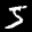

torch.Size([3, 32, 32])


In [7]:
batch_size_train = 256
batch_size_test = 256
batch_size_wm = 64

trainset = datasets.ImageFolder('./data/CIFAR10_7030/with_trigger/train/', transform=transform_train)
incset = datasets.ImageFolder('./data/CIFAR10_7030/with_trigger/train_incre/', transform=transform_train)
testset = datasets.ImageFolder('./data/CIFAR10_7030/test', transform=transform_test)
# valset = datasets.ImageFolder('./data/CIFAR10_7030/with_trigger/val/', transform=transform_test)
watermarkset = datasets.ImageFolder('./data/CIFAR10_7030/with_trigger/trigger_random/', transform=transform_test)
advwatermarkset = datasets.ImageFolder('./data/CIFAR10_7030/with_trigger/trigger_adv/', transform=transform_test)

unrelatedset = watermark_unrelated(count=100)
train_watermark_mixset = torch.utils.data.ConcatDataset((trainset,unrelatedset))


# testset = torchvision.datasets.CIFAR10(
#     root='./data', train=False, download=True, transform=transform_test)

unrelatedloader = torch.utils.data.DataLoader(
    unrelatedset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size_test, shuffle=False, num_workers=8)

# valloader = torch.utils.data.DataLoader(
    # valset, batch_size=batch_size_test, shuffle=False, num_workers=8)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

incloader = torch.utils.data.DataLoader(
    incset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

wmloader = torch.utils.data.DataLoader(
    watermarkset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
advwmloader = torch.utils.data.DataLoader(
    advwatermarkset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
train_watermark_loader = torch.utils.data.DataLoader(
    train_watermark_mixset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

In [8]:
## Sanity Check
print(f"Length of trainset {len(trainset)}")
print(f"Length of incset {len(incset)}")
print(f"Length of testset {len(testset)}")
# print(f"Length of # valset {len(# valset)}")
print(f"Length of watermarkset {len(watermarkset)}")
print(f"Length of advwatermarkset {len(advwatermarkset)}")

Length of trainset 34930
Length of incset 14970
Length of testset 10000
Length of watermarkset 100
Length of advwatermarkset 100


LR=0.001

In [9]:
net = ResNet18()
net.load_state_dict(torch.load('./models/wm_cifar10_certify_random_7030.pth')['model_state_dict'])
net2 = ResNet18()
net2.load_state_dict(torch.load('./checkpoints/resnet18_wm_7030.ckpt'))
net3 = ResNet18()
net3.load_state_dict(torch.load('./checkpoints/resnet18_wm_frozen_7030.ckpt'))
net4 = ResNet18()
net4.load_state_dict(torch.load('./checkpoints/resnet18_wm_rowback_7030.ckpt'))

<All keys matched successfully>

In [10]:
evaluator = Evaluator(net, torch.nn.CrossEntropyLoss())
print(evaluator.eval(testloader))
print(evaluator.eval(unrelatedloader))

{'loss': 0.6196484971925617, 'accuracy': 87.48}
{'loss': 1.9523219089023768e-05, 'accuracy': 100.0}


In [11]:
evaluator = Evaluator(net2, torch.nn.CrossEntropyLoss())
print("Original watermarking scheme")
print(f"Test accuracy {evaluator.eval(testloader)}")
print(f"Watermark accuracy {evaluator.eval(wmloader)}")

Original watermarking scheme
Test accuracy {'loss': 0.4954307278931141, 'accuracy': 86.14}
Watermark accuracy {'loss': 0.00022258851677179337, 'accuracy': 100.0}


In [12]:
evaluator = Evaluator(net3, torch.nn.CrossEntropyLoss())
print("Frozen watermarking scheme")
print(f"Test accuracy {evaluator.eval(testloader)}")
print(f"Watermark accuracy {evaluator.eval(wmloader)}")

Frozen watermarking scheme
Test accuracy {'loss': 0.5337510022163391, 'accuracy': 85.11999999999999}
Watermark accuracy {'loss': 0.0010847439058125018, 'accuracy': 100.0}


In [13]:
evaluator = Evaluator(net4, torch.nn.CrossEntropyLoss())
print("ROWBack watermarking scheme")
print(f"Test accuracy {evaluator.eval(testloader)}")
print(f"Watermark accuracy {evaluator.eval(advwmloader)}")

ROWBack watermarking scheme
Test accuracy {'loss': 0.528250137591362, 'accuracy': 85.41}
Watermark accuracy {'loss': 0.0008670831844210625, 'accuracy': 100.0}


In [14]:
logcmt = f"incre_train_certified_7030"

optimizer = torch.optim.SGD(lr=0.001, params=net.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer = Trainer(net, criterion, optimizer, incloader)
evaluator = Evaluator(net, criterion)

metrics = train(trainer, evaluator, testloader, savename='inccheckpoints/incre_train_cert_7030_lr0.001', logdir='./runs', logcmt=logcmt, trigger_loader=unrelatedloader, epochs=100)

Start Training...


2023-02-23 15:32:52.534321: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-23 15:32:52.617592: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-23 15:32:52.633748: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-23 15:32:52.910678: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

Epoch 0 | Time 25s| Train Loss 0.5678 | Train Acc 86.83| Val Loss 0.596 | Val Acc 87.34| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:04<00:00, 11.85it/s]


Epoch 1 | Time 33s| Train Loss 0.4865 | Train Acc 87.24| Val Loss 0.558 | Val Acc 87.03| Trigger Loss 0.012 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:04<00:00, 11.85it/s]


Epoch 2 | Time 40s| Train Loss 0.4251 | Train Acc 87.92| Val Loss 0.504 | Val Acc 87.14| Trigger Loss 0.107 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:04<00:00, 11.86it/s]


Epoch 3 | Time 47s| Train Loss 0.3888 | Train Acc 88.22| Val Loss 0.474 | Val Acc 87.28| Trigger Loss 0.214 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.76it/s]


Epoch 4 | Time 54s| Train Loss 0.3568 | Train Acc 88.56| Val Loss 0.452 | Val Acc 87.32| Trigger Loss 0.398 | Trigger Acc 81.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.68it/s]


Epoch 5 | Time 61s| Train Loss 0.3502 | Train Acc 88.68| Val Loss 0.441 | Val Acc 87.46| Trigger Loss 0.485 | Trigger Acc 76.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.68it/s]


Epoch 6 | Time 68s| Train Loss 0.3333 | Train Acc 88.97| Val Loss 0.447 | Val Acc 87.25| Trigger Loss 0.452 | Trigger Acc 80.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.62it/s]


Epoch 7 | Time 74s| Train Loss 0.3293 | Train Acc 88.94| Val Loss 0.452 | Val Acc 87.13| Trigger Loss 0.453 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.60it/s]


Epoch 8 | Time 81s| Train Loss 0.3119 | Train Acc 89.45| Val Loss 0.429 | Val Acc 87.25| Trigger Loss 0.462 | Trigger Acc 80.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.60it/s]


Epoch 9 | Time 88s| Train Loss 0.3088 | Train Acc 89.79| Val Loss 0.417 | Val Acc 87.44| Trigger Loss 0.508 | Trigger Acc 78.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.57it/s]


Epoch 10 | Time 95s| Train Loss 0.3058 | Train Acc 89.58| Val Loss 0.421 | Val Acc 87.49| Trigger Loss 0.368 | Trigger Acc 83.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.57it/s]


Epoch 11 | Time 102s| Train Loss 0.2965 | Train Acc 90.01| Val Loss 0.421 | Val Acc 87.38| Trigger Loss 0.467 | Trigger Acc 81.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.51it/s]


Epoch 12 | Time 109s| Train Loss 0.2911 | Train Acc 90.07| Val Loss 0.424 | Val Acc 87.62| Trigger Loss 0.400 | Trigger Acc 83.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.49it/s]


Epoch 13 | Time 116s| Train Loss 0.2840 | Train Acc 90.25| Val Loss 0.410 | Val Acc 87.73| Trigger Loss 0.340 | Trigger Acc 86.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.46it/s]


Epoch 14 | Time 123s| Train Loss 0.2856 | Train Acc 90.53| Val Loss 0.414 | Val Acc 87.47| Trigger Loss 0.327 | Trigger Acc 86.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.50it/s]


Epoch 15 | Time 130s| Train Loss 0.2798 | Train Acc 90.46| Val Loss 0.416 | Val Acc 87.51| Trigger Loss 0.236 | Trigger Acc 89.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.47it/s]


Epoch 16 | Time 137s| Train Loss 0.2709 | Train Acc 90.67| Val Loss 0.412 | Val Acc 87.64| Trigger Loss 0.273 | Trigger Acc 88.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.51it/s]


Epoch 17 | Time 144s| Train Loss 0.2651 | Train Acc 91.22| Val Loss 0.410 | Val Acc 87.62| Trigger Loss 0.213 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.47it/s]


Epoch 18 | Time 151s| Train Loss 0.2670 | Train Acc 91.02| Val Loss 0.415 | Val Acc 87.49| Trigger Loss 0.215 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.47it/s]


Epoch 19 | Time 158s| Train Loss 0.2653 | Train Acc 90.95| Val Loss 0.412 | Val Acc 87.60| Trigger Loss 0.194 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.47it/s]


Epoch 20 | Time 165s| Train Loss 0.2600 | Train Acc 91.18| Val Loss 0.417 | Val Acc 87.77| Trigger Loss 0.182 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 21 | Time 172s| Train Loss 0.2518 | Train Acc 91.40| Val Loss 0.415 | Val Acc 87.56| Trigger Loss 0.198 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.47it/s]


Epoch 22 | Time 179s| Train Loss 0.2456 | Train Acc 91.81| Val Loss 0.418 | Val Acc 87.64| Trigger Loss 0.210 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.48it/s]


Epoch 23 | Time 186s| Train Loss 0.2436 | Train Acc 91.88| Val Loss 0.422 | Val Acc 87.54| Trigger Loss 0.184 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 24 | Time 193s| Train Loss 0.2349 | Train Acc 91.91| Val Loss 0.421 | Val Acc 87.60| Trigger Loss 0.210 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 25 | Time 200s| Train Loss 0.2310 | Train Acc 92.06| Val Loss 0.423 | Val Acc 87.68| Trigger Loss 0.188 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.46it/s]


Epoch 26 | Time 207s| Train Loss 0.2343 | Train Acc 91.85| Val Loss 0.425 | Val Acc 87.51| Trigger Loss 0.142 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 27 | Time 214s| Train Loss 0.2285 | Train Acc 92.20| Val Loss 0.422 | Val Acc 87.72| Trigger Loss 0.109 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 28 | Time 221s| Train Loss 0.2298 | Train Acc 92.00| Val Loss 0.422 | Val Acc 87.90| Trigger Loss 0.131 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 29 | Time 228s| Train Loss 0.2220 | Train Acc 92.38| Val Loss 0.420 | Val Acc 87.81| Trigger Loss 0.136 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 30 | Time 235s| Train Loss 0.2208 | Train Acc 92.29| Val Loss 0.421 | Val Acc 87.66| Trigger Loss 0.164 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 31 | Time 242s| Train Loss 0.2114 | Train Acc 92.89| Val Loss 0.427 | Val Acc 87.60| Trigger Loss 0.145 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 32 | Time 249s| Train Loss 0.2066 | Train Acc 92.93| Val Loss 0.432 | Val Acc 87.44| Trigger Loss 0.113 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 33 | Time 256s| Train Loss 0.2053 | Train Acc 92.86| Val Loss 0.437 | Val Acc 87.55| Trigger Loss 0.137 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 34 | Time 263s| Train Loss 0.2029 | Train Acc 93.16| Val Loss 0.450 | Val Acc 87.73| Trigger Loss 0.062 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 35 | Time 270s| Train Loss 0.2026 | Train Acc 92.99| Val Loss 0.437 | Val Acc 87.61| Trigger Loss 0.134 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 36 | Time 277s| Train Loss 0.1976 | Train Acc 93.39| Val Loss 0.437 | Val Acc 87.56| Trigger Loss 0.111 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 37 | Time 284s| Train Loss 0.1920 | Train Acc 93.35| Val Loss 0.443 | Val Acc 87.72| Trigger Loss 0.082 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 38 | Time 291s| Train Loss 0.1892 | Train Acc 93.54| Val Loss 0.444 | Val Acc 87.53| Trigger Loss 0.108 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 39 | Time 298s| Train Loss 0.1867 | Train Acc 93.71| Val Loss 0.445 | Val Acc 87.68| Trigger Loss 0.096 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 40 | Time 305s| Train Loss 0.1844 | Train Acc 93.65| Val Loss 0.452 | Val Acc 87.48| Trigger Loss 0.053 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 41 | Time 312s| Train Loss 0.1856 | Train Acc 93.49| Val Loss 0.451 | Val Acc 87.43| Trigger Loss 0.065 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 42 | Time 319s| Train Loss 0.1762 | Train Acc 94.23| Val Loss 0.455 | Val Acc 87.52| Trigger Loss 0.051 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 43 | Time 326s| Train Loss 0.1765 | Train Acc 93.85| Val Loss 0.455 | Val Acc 87.36| Trigger Loss 0.062 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 44 | Time 333s| Train Loss 0.1711 | Train Acc 94.30| Val Loss 0.457 | Val Acc 87.32| Trigger Loss 0.055 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 45 | Time 340s| Train Loss 0.1707 | Train Acc 94.15| Val Loss 0.463 | Val Acc 87.37| Trigger Loss 0.054 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 46 | Time 347s| Train Loss 0.1613 | Train Acc 94.46| Val Loss 0.463 | Val Acc 87.36| Trigger Loss 0.047 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 47 | Time 354s| Train Loss 0.1638 | Train Acc 94.48| Val Loss 0.463 | Val Acc 87.46| Trigger Loss 0.056 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 48 | Time 361s| Train Loss 0.1659 | Train Acc 94.52| Val Loss 0.468 | Val Acc 87.49| Trigger Loss 0.044 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 49 | Time 369s| Train Loss 0.1543 | Train Acc 94.72| Val Loss 0.466 | Val Acc 87.52| Trigger Loss 0.034 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 50 | Time 376s| Train Loss 0.1615 | Train Acc 94.51| Val Loss 0.475 | Val Acc 87.45| Trigger Loss 0.028 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 51 | Time 383s| Train Loss 0.1557 | Train Acc 94.32| Val Loss 0.474 | Val Acc 87.24| Trigger Loss 0.030 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 52 | Time 390s| Train Loss 0.1506 | Train Acc 94.84| Val Loss 0.473 | Val Acc 87.34| Trigger Loss 0.045 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 53 | Time 397s| Train Loss 0.1439 | Train Acc 95.15| Val Loss 0.480 | Val Acc 87.39| Trigger Loss 0.032 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 54 | Time 404s| Train Loss 0.1431 | Train Acc 95.09| Val Loss 0.487 | Val Acc 87.31| Trigger Loss 0.036 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 55 | Time 411s| Train Loss 0.1402 | Train Acc 95.25| Val Loss 0.488 | Val Acc 87.42| Trigger Loss 0.030 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 56 | Time 418s| Train Loss 0.1357 | Train Acc 95.31| Val Loss 0.491 | Val Acc 87.31| Trigger Loss 0.044 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 57 | Time 425s| Train Loss 0.1345 | Train Acc 95.58| Val Loss 0.496 | Val Acc 87.39| Trigger Loss 0.020 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 58 | Time 433s| Train Loss 0.1328 | Train Acc 95.52| Val Loss 0.493 | Val Acc 87.32| Trigger Loss 0.020 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 59 | Time 440s| Train Loss 0.1327 | Train Acc 95.58| Val Loss 0.501 | Val Acc 87.15| Trigger Loss 0.032 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 60 | Time 447s| Train Loss 0.1314 | Train Acc 95.62| Val Loss 0.502 | Val Acc 87.18| Trigger Loss 0.030 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 61 | Time 454s| Train Loss 0.1290 | Train Acc 95.66| Val Loss 0.502 | Val Acc 87.23| Trigger Loss 0.023 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 62 | Time 462s| Train Loss 0.1234 | Train Acc 95.87| Val Loss 0.505 | Val Acc 87.12| Trigger Loss 0.010 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 63 | Time 469s| Train Loss 0.1178 | Train Acc 95.94| Val Loss 0.513 | Val Acc 87.20| Trigger Loss 0.019 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 64 | Time 476s| Train Loss 0.1189 | Train Acc 95.94| Val Loss 0.512 | Val Acc 87.24| Trigger Loss 0.013 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 65 | Time 483s| Train Loss 0.1158 | Train Acc 96.09| Val Loss 0.513 | Val Acc 87.19| Trigger Loss 0.011 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 66 | Time 491s| Train Loss 0.1123 | Train Acc 96.13| Val Loss 0.520 | Val Acc 87.19| Trigger Loss 0.015 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 67 | Time 498s| Train Loss 0.1106 | Train Acc 96.25| Val Loss 0.519 | Val Acc 87.07| Trigger Loss 0.013 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 68 | Time 505s| Train Loss 0.1103 | Train Acc 96.38| Val Loss 0.520 | Val Acc 87.19| Trigger Loss 0.028 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 69 | Time 512s| Train Loss 0.1090 | Train Acc 96.44| Val Loss 0.521 | Val Acc 87.15| Trigger Loss 0.021 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 70 | Time 520s| Train Loss 0.1026 | Train Acc 96.57| Val Loss 0.526 | Val Acc 87.15| Trigger Loss 0.014 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 71 | Time 527s| Train Loss 0.1039 | Train Acc 96.50| Val Loss 0.522 | Val Acc 87.12| Trigger Loss 0.034 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 72 | Time 534s| Train Loss 0.1042 | Train Acc 96.30| Val Loss 0.532 | Val Acc 86.94| Trigger Loss 0.031 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 73 | Time 541s| Train Loss 0.1011 | Train Acc 96.56| Val Loss 0.534 | Val Acc 87.00| Trigger Loss 0.030 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 74 | Time 548s| Train Loss 0.0964 | Train Acc 96.83| Val Loss 0.537 | Val Acc 86.98| Trigger Loss 0.019 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 75 | Time 555s| Train Loss 0.0937 | Train Acc 96.89| Val Loss 0.536 | Val Acc 87.06| Trigger Loss 0.028 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 76 | Time 562s| Train Loss 0.0917 | Train Acc 97.06| Val Loss 0.550 | Val Acc 86.88| Trigger Loss 0.031 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 77 | Time 569s| Train Loss 0.0911 | Train Acc 96.96| Val Loss 0.548 | Val Acc 87.03| Trigger Loss 0.019 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 78 | Time 576s| Train Loss 0.0886 | Train Acc 97.00| Val Loss 0.550 | Val Acc 87.01| Trigger Loss 0.017 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 79 | Time 584s| Train Loss 0.0895 | Train Acc 97.02| Val Loss 0.552 | Val Acc 87.04| Trigger Loss 0.011 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 80 | Time 591s| Train Loss 0.0868 | Train Acc 97.05| Val Loss 0.562 | Val Acc 86.66| Trigger Loss 0.013 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 81 | Time 598s| Train Loss 0.0879 | Train Acc 97.05| Val Loss 0.554 | Val Acc 86.89| Trigger Loss 0.010 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 82 | Time 605s| Train Loss 0.0824 | Train Acc 97.25| Val Loss 0.555 | Val Acc 87.16| Trigger Loss 0.019 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 83 | Time 613s| Train Loss 0.0834 | Train Acc 97.30| Val Loss 0.553 | Val Acc 87.08| Trigger Loss 0.020 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 84 | Time 620s| Train Loss 0.0759 | Train Acc 97.40| Val Loss 0.558 | Val Acc 87.14| Trigger Loss 0.013 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 85 | Time 627s| Train Loss 0.0783 | Train Acc 97.35| Val Loss 0.562 | Val Acc 86.88| Trigger Loss 0.012 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 86 | Time 635s| Train Loss 0.0792 | Train Acc 97.41| Val Loss 0.561 | Val Acc 86.92| Trigger Loss 0.017 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 87 | Time 642s| Train Loss 0.0776 | Train Acc 97.28| Val Loss 0.566 | Val Acc 86.86| Trigger Loss 0.008 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 88 | Time 649s| Train Loss 0.0704 | Train Acc 97.90| Val Loss 0.566 | Val Acc 86.95| Trigger Loss 0.011 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 89 | Time 656s| Train Loss 0.0736 | Train Acc 97.54| Val Loss 0.573 | Val Acc 87.07| Trigger Loss 0.009 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 90 | Time 664s| Train Loss 0.0712 | Train Acc 97.70| Val Loss 0.575 | Val Acc 86.85| Trigger Loss 0.013 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 91 | Time 671s| Train Loss 0.0667 | Train Acc 97.80| Val Loss 0.576 | Val Acc 87.14| Trigger Loss 0.020 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 92 | Time 678s| Train Loss 0.0709 | Train Acc 97.68| Val Loss 0.579 | Val Acc 87.08| Trigger Loss 0.024 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 93 | Time 685s| Train Loss 0.0655 | Train Acc 97.90| Val Loss 0.581 | Val Acc 87.02| Trigger Loss 0.032 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 94 | Time 692s| Train Loss 0.0704 | Train Acc 97.60| Val Loss 0.587 | Val Acc 86.84| Trigger Loss 0.023 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 95 | Time 700s| Train Loss 0.0646 | Train Acc 98.12| Val Loss 0.584 | Val Acc 87.03| Trigger Loss 0.036 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 96 | Time 707s| Train Loss 0.0637 | Train Acc 97.94| Val Loss 0.586 | Val Acc 86.93| Trigger Loss 0.020 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 97 | Time 714s| Train Loss 0.0626 | Train Acc 98.07| Val Loss 0.588 | Val Acc 86.87| Trigger Loss 0.028 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 98 | Time 721s| Train Loss 0.0600 | Train Acc 98.23| Val Loss 0.592 | Val Acc 86.92| Trigger Loss 0.016 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 99 | Time 728s| Train Loss 0.0554 | Train Acc 98.28| Val Loss 0.593 | Val Acc 86.99| Trigger Loss 0.035 | Trigger Acc 98.00


In [15]:
logcmt = f"incre_train_baseline_7030"

optimizer2 = torch.optim.SGD(lr=0.001, params=net2.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer2 = Trainer(net2, criterion, optimizer2, incloader)
evaluator2 = Evaluator(net2, criterion)

metrics2 = train(trainer2, evaluator2, testloader, savename='inccheckpoints/incre_train_baseline_7030_lr0.001', logdir='./runs', logcmt=logcmt, trigger_loader=wmloader, epochs=100)

Start Training...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 0 | Time 7s| Train Loss 0.4789 | Train Acc 85.96| Val Loss 0.487 | Val Acc 86.18| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 1 | Time 15s| Train Loss 0.4264 | Train Acc 86.77| Val Loss 0.468 | Val Acc 86.03| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 2 | Time 22s| Train Loss 0.3944 | Train Acc 87.16| Val Loss 0.452 | Val Acc 86.37| Trigger Loss 0.003 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 3 | Time 29s| Train Loss 0.3798 | Train Acc 87.51| Val Loss 0.440 | Val Acc 86.22| Trigger Loss 0.005 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 4 | Time 37s| Train Loss 0.3592 | Train Acc 87.89| Val Loss 0.439 | Val Acc 86.12| Trigger Loss 0.010 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 5 | Time 44s| Train Loss 0.3519 | Train Acc 88.12| Val Loss 0.429 | Val Acc 86.12| Trigger Loss 0.013 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 6 | Time 51s| Train Loss 0.3470 | Train Acc 88.24| Val Loss 0.427 | Val Acc 86.29| Trigger Loss 0.011 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 7 | Time 59s| Train Loss 0.3334 | Train Acc 88.52| Val Loss 0.425 | Val Acc 86.30| Trigger Loss 0.015 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 8 | Time 66s| Train Loss 0.3218 | Train Acc 88.68| Val Loss 0.419 | Val Acc 86.54| Trigger Loss 0.018 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 9 | Time 73s| Train Loss 0.3199 | Train Acc 89.24| Val Loss 0.418 | Val Acc 86.37| Trigger Loss 0.021 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 10 | Time 80s| Train Loss 0.3158 | Train Acc 89.08| Val Loss 0.419 | Val Acc 86.39| Trigger Loss 0.032 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 11 | Time 88s| Train Loss 0.3093 | Train Acc 89.24| Val Loss 0.414 | Val Acc 86.41| Trigger Loss 0.022 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 12 | Time 95s| Train Loss 0.3048 | Train Acc 89.68| Val Loss 0.413 | Val Acc 86.43| Trigger Loss 0.024 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 13 | Time 102s| Train Loss 0.2947 | Train Acc 89.93| Val Loss 0.415 | Val Acc 86.47| Trigger Loss 0.024 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 14 | Time 109s| Train Loss 0.2940 | Train Acc 89.62| Val Loss 0.414 | Val Acc 86.61| Trigger Loss 0.029 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 15 | Time 117s| Train Loss 0.2880 | Train Acc 90.06| Val Loss 0.410 | Val Acc 86.58| Trigger Loss 0.037 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 16 | Time 124s| Train Loss 0.2811 | Train Acc 90.29| Val Loss 0.413 | Val Acc 86.40| Trigger Loss 0.037 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 17 | Time 131s| Train Loss 0.2853 | Train Acc 90.28| Val Loss 0.416 | Val Acc 86.34| Trigger Loss 0.035 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 18 | Time 138s| Train Loss 0.2760 | Train Acc 90.44| Val Loss 0.417 | Val Acc 86.41| Trigger Loss 0.037 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 19 | Time 145s| Train Loss 0.2769 | Train Acc 90.25| Val Loss 0.413 | Val Acc 86.43| Trigger Loss 0.041 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 20 | Time 153s| Train Loss 0.2665 | Train Acc 90.99| Val Loss 0.413 | Val Acc 86.59| Trigger Loss 0.043 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 21 | Time 160s| Train Loss 0.2643 | Train Acc 90.71| Val Loss 0.416 | Val Acc 86.69| Trigger Loss 0.043 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 22 | Time 167s| Train Loss 0.2619 | Train Acc 90.96| Val Loss 0.415 | Val Acc 86.59| Trigger Loss 0.048 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 23 | Time 174s| Train Loss 0.2616 | Train Acc 90.91| Val Loss 0.418 | Val Acc 86.40| Trigger Loss 0.045 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 24 | Time 182s| Train Loss 0.2526 | Train Acc 91.34| Val Loss 0.424 | Val Acc 86.30| Trigger Loss 0.056 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 25 | Time 189s| Train Loss 0.2524 | Train Acc 91.08| Val Loss 0.421 | Val Acc 86.48| Trigger Loss 0.048 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 26 | Time 196s| Train Loss 0.2453 | Train Acc 91.70| Val Loss 0.422 | Val Acc 86.54| Trigger Loss 0.051 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 27 | Time 204s| Train Loss 0.2489 | Train Acc 91.27| Val Loss 0.423 | Val Acc 86.53| Trigger Loss 0.061 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 28 | Time 211s| Train Loss 0.2449 | Train Acc 91.52| Val Loss 0.423 | Val Acc 86.56| Trigger Loss 0.064 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 29 | Time 218s| Train Loss 0.2399 | Train Acc 91.94| Val Loss 0.429 | Val Acc 86.31| Trigger Loss 0.068 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 30 | Time 225s| Train Loss 0.2435 | Train Acc 91.54| Val Loss 0.430 | Val Acc 86.54| Trigger Loss 0.072 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 31 | Time 232s| Train Loss 0.2319 | Train Acc 92.05| Val Loss 0.433 | Val Acc 86.40| Trigger Loss 0.067 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 32 | Time 239s| Train Loss 0.2287 | Train Acc 92.40| Val Loss 0.433 | Val Acc 86.46| Trigger Loss 0.078 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 33 | Time 246s| Train Loss 0.2278 | Train Acc 92.14| Val Loss 0.435 | Val Acc 86.50| Trigger Loss 0.105 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 34 | Time 253s| Train Loss 0.2223 | Train Acc 92.68| Val Loss 0.435 | Val Acc 86.38| Trigger Loss 0.114 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 35 | Time 260s| Train Loss 0.2216 | Train Acc 92.57| Val Loss 0.438 | Val Acc 86.20| Trigger Loss 0.114 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 36 | Time 267s| Train Loss 0.2201 | Train Acc 92.44| Val Loss 0.436 | Val Acc 86.41| Trigger Loss 0.085 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 37 | Time 274s| Train Loss 0.2201 | Train Acc 92.50| Val Loss 0.439 | Val Acc 86.37| Trigger Loss 0.102 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 38 | Time 281s| Train Loss 0.2180 | Train Acc 92.43| Val Loss 0.440 | Val Acc 86.33| Trigger Loss 0.137 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 39 | Time 288s| Train Loss 0.2088 | Train Acc 93.02| Val Loss 0.441 | Val Acc 86.70| Trigger Loss 0.106 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 40 | Time 295s| Train Loss 0.2041 | Train Acc 92.97| Val Loss 0.447 | Val Acc 86.47| Trigger Loss 0.167 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.29it/s]


Epoch 41 | Time 302s| Train Loss 0.2028 | Train Acc 93.14| Val Loss 0.443 | Val Acc 86.42| Trigger Loss 0.147 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 42 | Time 309s| Train Loss 0.2007 | Train Acc 93.16| Val Loss 0.449 | Val Acc 86.36| Trigger Loss 0.160 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 43 | Time 316s| Train Loss 0.1963 | Train Acc 93.16| Val Loss 0.456 | Val Acc 86.57| Trigger Loss 0.165 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 44 | Time 323s| Train Loss 0.1904 | Train Acc 93.61| Val Loss 0.456 | Val Acc 86.54| Trigger Loss 0.139 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 45 | Time 330s| Train Loss 0.1911 | Train Acc 93.45| Val Loss 0.455 | Val Acc 86.28| Trigger Loss 0.125 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 46 | Time 337s| Train Loss 0.1882 | Train Acc 93.35| Val Loss 0.460 | Val Acc 86.41| Trigger Loss 0.120 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 47 | Time 345s| Train Loss 0.1886 | Train Acc 93.73| Val Loss 0.460 | Val Acc 86.35| Trigger Loss 0.178 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 48 | Time 352s| Train Loss 0.1894 | Train Acc 93.57| Val Loss 0.462 | Val Acc 86.07| Trigger Loss 0.177 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 49 | Time 359s| Train Loss 0.1799 | Train Acc 93.85| Val Loss 0.460 | Val Acc 86.50| Trigger Loss 0.159 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 50 | Time 366s| Train Loss 0.1739 | Train Acc 94.29| Val Loss 0.463 | Val Acc 86.26| Trigger Loss 0.178 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 51 | Time 373s| Train Loss 0.1742 | Train Acc 94.32| Val Loss 0.466 | Val Acc 86.46| Trigger Loss 0.240 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 52 | Time 380s| Train Loss 0.1718 | Train Acc 94.26| Val Loss 0.463 | Val Acc 86.48| Trigger Loss 0.215 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 53 | Time 387s| Train Loss 0.1678 | Train Acc 94.29| Val Loss 0.475 | Val Acc 86.36| Trigger Loss 0.213 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 54 | Time 394s| Train Loss 0.1633 | Train Acc 94.46| Val Loss 0.466 | Val Acc 86.33| Trigger Loss 0.209 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 55 | Time 401s| Train Loss 0.1598 | Train Acc 94.56| Val Loss 0.476 | Val Acc 86.34| Trigger Loss 0.262 | Trigger Acc 89.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 56 | Time 408s| Train Loss 0.1606 | Train Acc 94.63| Val Loss 0.473 | Val Acc 86.35| Trigger Loss 0.262 | Trigger Acc 88.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 57 | Time 415s| Train Loss 0.1523 | Train Acc 95.04| Val Loss 0.480 | Val Acc 86.32| Trigger Loss 0.203 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 58 | Time 422s| Train Loss 0.1539 | Train Acc 94.66| Val Loss 0.483 | Val Acc 86.40| Trigger Loss 0.218 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 59 | Time 429s| Train Loss 0.1539 | Train Acc 94.90| Val Loss 0.484 | Val Acc 86.46| Trigger Loss 0.292 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 60 | Time 436s| Train Loss 0.1512 | Train Acc 94.95| Val Loss 0.488 | Val Acc 86.33| Trigger Loss 0.189 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 61 | Time 443s| Train Loss 0.1456 | Train Acc 95.12| Val Loss 0.492 | Val Acc 86.34| Trigger Loss 0.283 | Trigger Acc 89.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 62 | Time 450s| Train Loss 0.1468 | Train Acc 95.24| Val Loss 0.495 | Val Acc 86.25| Trigger Loss 0.251 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.32it/s]


Epoch 63 | Time 457s| Train Loss 0.1413 | Train Acc 95.37| Val Loss 0.497 | Val Acc 86.34| Trigger Loss 0.264 | Trigger Acc 89.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 64 | Time 464s| Train Loss 0.1382 | Train Acc 95.35| Val Loss 0.498 | Val Acc 86.24| Trigger Loss 0.365 | Trigger Acc 87.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 65 | Time 471s| Train Loss 0.1346 | Train Acc 95.56| Val Loss 0.504 | Val Acc 86.26| Trigger Loss 0.296 | Trigger Acc 87.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 66 | Time 478s| Train Loss 0.1375 | Train Acc 95.48| Val Loss 0.506 | Val Acc 86.22| Trigger Loss 0.345 | Trigger Acc 86.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 67 | Time 485s| Train Loss 0.1310 | Train Acc 95.64| Val Loss 0.507 | Val Acc 86.27| Trigger Loss 0.296 | Trigger Acc 88.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 68 | Time 492s| Train Loss 0.1320 | Train Acc 95.67| Val Loss 0.514 | Val Acc 86.32| Trigger Loss 0.276 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 69 | Time 499s| Train Loss 0.1291 | Train Acc 95.75| Val Loss 0.517 | Val Acc 86.17| Trigger Loss 0.291 | Trigger Acc 87.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 70 | Time 506s| Train Loss 0.1292 | Train Acc 95.74| Val Loss 0.515 | Val Acc 86.26| Trigger Loss 0.310 | Trigger Acc 87.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 71 | Time 513s| Train Loss 0.1217 | Train Acc 95.96| Val Loss 0.518 | Val Acc 86.21| Trigger Loss 0.296 | Trigger Acc 88.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 72 | Time 520s| Train Loss 0.1216 | Train Acc 96.00| Val Loss 0.523 | Val Acc 86.07| Trigger Loss 0.348 | Trigger Acc 85.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 73 | Time 527s| Train Loss 0.1226 | Train Acc 95.93| Val Loss 0.524 | Val Acc 86.14| Trigger Loss 0.310 | Trigger Acc 87.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 74 | Time 534s| Train Loss 0.1209 | Train Acc 95.97| Val Loss 0.528 | Val Acc 86.21| Trigger Loss 0.297 | Trigger Acc 86.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 75 | Time 541s| Train Loss 0.1161 | Train Acc 95.99| Val Loss 0.529 | Val Acc 86.31| Trigger Loss 0.340 | Trigger Acc 87.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 76 | Time 548s| Train Loss 0.1143 | Train Acc 96.27| Val Loss 0.531 | Val Acc 86.39| Trigger Loss 0.395 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 77 | Time 555s| Train Loss 0.1090 | Train Acc 96.59| Val Loss 0.533 | Val Acc 86.17| Trigger Loss 0.400 | Trigger Acc 87.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 78 | Time 562s| Train Loss 0.1094 | Train Acc 96.37| Val Loss 0.541 | Val Acc 86.12| Trigger Loss 0.442 | Trigger Acc 83.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 79 | Time 569s| Train Loss 0.1077 | Train Acc 96.54| Val Loss 0.545 | Val Acc 86.46| Trigger Loss 0.403 | Trigger Acc 86.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 80 | Time 576s| Train Loss 0.1064 | Train Acc 96.55| Val Loss 0.543 | Val Acc 86.01| Trigger Loss 0.421 | Trigger Acc 85.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 81 | Time 583s| Train Loss 0.1011 | Train Acc 96.77| Val Loss 0.545 | Val Acc 86.05| Trigger Loss 0.469 | Trigger Acc 80.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 82 | Time 590s| Train Loss 0.1033 | Train Acc 96.62| Val Loss 0.554 | Val Acc 86.00| Trigger Loss 0.461 | Trigger Acc 84.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 83 | Time 597s| Train Loss 0.1009 | Train Acc 96.64| Val Loss 0.552 | Val Acc 86.22| Trigger Loss 0.465 | Trigger Acc 83.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 84 | Time 604s| Train Loss 0.0992 | Train Acc 96.68| Val Loss 0.557 | Val Acc 86.02| Trigger Loss 0.500 | Trigger Acc 78.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 85 | Time 611s| Train Loss 0.1003 | Train Acc 96.63| Val Loss 0.560 | Val Acc 86.12| Trigger Loss 0.510 | Trigger Acc 79.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 86 | Time 618s| Train Loss 0.1018 | Train Acc 96.59| Val Loss 0.561 | Val Acc 86.08| Trigger Loss 0.483 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.32it/s]


Epoch 87 | Time 625s| Train Loss 0.0957 | Train Acc 96.93| Val Loss 0.560 | Val Acc 85.93| Trigger Loss 0.527 | Trigger Acc 81.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 88 | Time 632s| Train Loss 0.0938 | Train Acc 96.91| Val Loss 0.565 | Val Acc 86.14| Trigger Loss 0.485 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 89 | Time 639s| Train Loss 0.0919 | Train Acc 97.07| Val Loss 0.576 | Val Acc 85.77| Trigger Loss 0.520 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 90 | Time 646s| Train Loss 0.0891 | Train Acc 97.21| Val Loss 0.577 | Val Acc 86.06| Trigger Loss 0.624 | Trigger Acc 79.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 91 | Time 653s| Train Loss 0.0834 | Train Acc 97.28| Val Loss 0.575 | Val Acc 85.98| Trigger Loss 0.508 | Trigger Acc 83.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 92 | Time 660s| Train Loss 0.0848 | Train Acc 97.27| Val Loss 0.571 | Val Acc 86.04| Trigger Loss 0.591 | Trigger Acc 80.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 93 | Time 667s| Train Loss 0.0825 | Train Acc 97.22| Val Loss 0.577 | Val Acc 86.04| Trigger Loss 0.624 | Trigger Acc 78.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 94 | Time 674s| Train Loss 0.0829 | Train Acc 97.31| Val Loss 0.586 | Val Acc 85.95| Trigger Loss 0.588 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.46it/s]


Epoch 95 | Time 681s| Train Loss 0.0786 | Train Acc 97.47| Val Loss 0.584 | Val Acc 85.87| Trigger Loss 0.513 | Trigger Acc 83.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 96 | Time 688s| Train Loss 0.0775 | Train Acc 97.62| Val Loss 0.577 | Val Acc 86.33| Trigger Loss 0.573 | Trigger Acc 78.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 97 | Time 695s| Train Loss 0.0759 | Train Acc 97.57| Val Loss 0.597 | Val Acc 86.21| Trigger Loss 0.528 | Trigger Acc 79.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 98 | Time 703s| Train Loss 0.0722 | Train Acc 97.76| Val Loss 0.589 | Val Acc 86.14| Trigger Loss 0.663 | Trigger Acc 79.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 99 | Time 710s| Train Loss 0.0750 | Train Acc 97.62| Val Loss 0.586 | Val Acc 86.23| Trigger Loss 0.621 | Trigger Acc 80.00


In [16]:
logcmt = f"incre_train_baseline_frozen_7030"

optimizer3 = torch.optim.SGD(lr=0.001, params=net3.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer3 = Trainer(net3, criterion, optimizer3, incloader)
evaluator3 = Evaluator(net3, criterion)

metrics3 = train(trainer3, evaluator3, testloader, savename='inccheckpoints/incre_train_baseline_frozen_7030_lr0.001', logdir='./runs', logcmt=logcmt, trigger_loader=wmloader, epochs=100)

Start Training...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 0 | Time 7s| Train Loss 0.5036 | Train Acc 84.78| Val Loss 0.541 | Val Acc 84.67| Trigger Loss 0.245 | Trigger Acc 89.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 1 | Time 15s| Train Loss 0.4521 | Train Acc 85.63| Val Loss 0.505 | Val Acc 84.82| Trigger Loss 0.605 | Trigger Acc 79.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 2 | Time 22s| Train Loss 0.4332 | Train Acc 86.15| Val Loss 0.493 | Val Acc 84.85| Trigger Loss 0.844 | Trigger Acc 70.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 3 | Time 29s| Train Loss 0.4062 | Train Acc 86.55| Val Loss 0.489 | Val Acc 85.05| Trigger Loss 0.854 | Trigger Acc 69.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 4 | Time 36s| Train Loss 0.3865 | Train Acc 87.05| Val Loss 0.482 | Val Acc 84.89| Trigger Loss 1.010 | Trigger Acc 63.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 5 | Time 43s| Train Loss 0.3810 | Train Acc 87.14| Val Loss 0.480 | Val Acc 84.84| Trigger Loss 1.221 | Trigger Acc 57.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 6 | Time 50s| Train Loss 0.3666 | Train Acc 87.55| Val Loss 0.467 | Val Acc 85.11| Trigger Loss 1.105 | Trigger Acc 61.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.46it/s]


Epoch 7 | Time 57s| Train Loss 0.3591 | Train Acc 87.86| Val Loss 0.474 | Val Acc 85.04| Trigger Loss 1.281 | Trigger Acc 59.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 8 | Time 64s| Train Loss 0.3514 | Train Acc 88.04| Val Loss 0.472 | Val Acc 85.29| Trigger Loss 1.138 | Trigger Acc 58.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 9 | Time 71s| Train Loss 0.3425 | Train Acc 87.98| Val Loss 0.462 | Val Acc 85.45| Trigger Loss 1.178 | Trigger Acc 64.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 10 | Time 78s| Train Loss 0.3324 | Train Acc 88.48| Val Loss 0.461 | Val Acc 85.34| Trigger Loss 1.290 | Trigger Acc 54.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 11 | Time 85s| Train Loss 0.3295 | Train Acc 88.79| Val Loss 0.462 | Val Acc 85.21| Trigger Loss 1.249 | Trigger Acc 57.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 12 | Time 92s| Train Loss 0.3234 | Train Acc 88.92| Val Loss 0.462 | Val Acc 85.27| Trigger Loss 1.308 | Trigger Acc 58.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 13 | Time 99s| Train Loss 0.3233 | Train Acc 88.88| Val Loss 0.459 | Val Acc 85.43| Trigger Loss 1.407 | Trigger Acc 54.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 14 | Time 106s| Train Loss 0.3108 | Train Acc 89.28| Val Loss 0.455 | Val Acc 85.36| Trigger Loss 1.442 | Trigger Acc 53.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 15 | Time 113s| Train Loss 0.3073 | Train Acc 89.31| Val Loss 0.460 | Val Acc 85.45| Trigger Loss 1.362 | Trigger Acc 60.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 16 | Time 120s| Train Loss 0.3048 | Train Acc 89.57| Val Loss 0.460 | Val Acc 85.56| Trigger Loss 1.488 | Trigger Acc 54.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 17 | Time 127s| Train Loss 0.3000 | Train Acc 89.79| Val Loss 0.458 | Val Acc 85.38| Trigger Loss 1.452 | Trigger Acc 56.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 18 | Time 134s| Train Loss 0.2959 | Train Acc 89.84| Val Loss 0.453 | Val Acc 85.72| Trigger Loss 1.541 | Trigger Acc 55.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 19 | Time 141s| Train Loss 0.2884 | Train Acc 90.06| Val Loss 0.463 | Val Acc 85.40| Trigger Loss 1.674 | Trigger Acc 54.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 20 | Time 148s| Train Loss 0.2869 | Train Acc 90.05| Val Loss 0.461 | Val Acc 85.43| Trigger Loss 1.565 | Trigger Acc 51.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 21 | Time 155s| Train Loss 0.2791 | Train Acc 90.47| Val Loss 0.460 | Val Acc 85.42| Trigger Loss 1.592 | Trigger Acc 54.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 22 | Time 162s| Train Loss 0.2805 | Train Acc 90.37| Val Loss 0.456 | Val Acc 85.61| Trigger Loss 1.707 | Trigger Acc 51.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 23 | Time 169s| Train Loss 0.2729 | Train Acc 90.51| Val Loss 0.464 | Val Acc 85.49| Trigger Loss 1.682 | Trigger Acc 52.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 24 | Time 176s| Train Loss 0.2659 | Train Acc 90.80| Val Loss 0.467 | Val Acc 85.36| Trigger Loss 1.518 | Trigger Acc 51.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 25 | Time 183s| Train Loss 0.2635 | Train Acc 90.80| Val Loss 0.468 | Val Acc 85.38| Trigger Loss 1.780 | Trigger Acc 48.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 26 | Time 190s| Train Loss 0.2596 | Train Acc 91.20| Val Loss 0.469 | Val Acc 85.25| Trigger Loss 1.604 | Trigger Acc 52.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 27 | Time 197s| Train Loss 0.2595 | Train Acc 90.98| Val Loss 0.464 | Val Acc 85.62| Trigger Loss 1.738 | Trigger Acc 47.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 28 | Time 204s| Train Loss 0.2600 | Train Acc 91.02| Val Loss 0.464 | Val Acc 85.71| Trigger Loss 1.647 | Trigger Acc 51.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 29 | Time 211s| Train Loss 0.2459 | Train Acc 91.48| Val Loss 0.471 | Val Acc 85.47| Trigger Loss 1.839 | Trigger Acc 47.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 30 | Time 218s| Train Loss 0.2457 | Train Acc 91.75| Val Loss 0.474 | Val Acc 85.34| Trigger Loss 1.745 | Trigger Acc 50.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 31 | Time 225s| Train Loss 0.2433 | Train Acc 91.64| Val Loss 0.479 | Val Acc 85.21| Trigger Loss 1.898 | Trigger Acc 43.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 32 | Time 232s| Train Loss 0.2373 | Train Acc 91.95| Val Loss 0.476 | Val Acc 85.39| Trigger Loss 1.886 | Trigger Acc 52.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 33 | Time 240s| Train Loss 0.2358 | Train Acc 91.78| Val Loss 0.477 | Val Acc 85.52| Trigger Loss 1.959 | Trigger Acc 47.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 34 | Time 247s| Train Loss 0.2290 | Train Acc 92.22| Val Loss 0.486 | Val Acc 85.37| Trigger Loss 2.008 | Trigger Acc 46.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 35 | Time 254s| Train Loss 0.2201 | Train Acc 92.46| Val Loss 0.482 | Val Acc 85.39| Trigger Loss 1.819 | Trigger Acc 51.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 36 | Time 261s| Train Loss 0.2209 | Train Acc 92.58| Val Loss 0.488 | Val Acc 85.38| Trigger Loss 1.971 | Trigger Acc 44.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 37 | Time 268s| Train Loss 0.2210 | Train Acc 92.61| Val Loss 0.489 | Val Acc 85.49| Trigger Loss 2.088 | Trigger Acc 46.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 38 | Time 275s| Train Loss 0.2142 | Train Acc 92.75| Val Loss 0.488 | Val Acc 85.49| Trigger Loss 2.062 | Trigger Acc 46.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 39 | Time 282s| Train Loss 0.2149 | Train Acc 92.64| Val Loss 0.496 | Val Acc 85.18| Trigger Loss 2.052 | Trigger Acc 45.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 40 | Time 289s| Train Loss 0.2094 | Train Acc 92.94| Val Loss 0.496 | Val Acc 85.49| Trigger Loss 1.949 | Trigger Acc 43.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 41 | Time 296s| Train Loss 0.2065 | Train Acc 93.01| Val Loss 0.502 | Val Acc 85.22| Trigger Loss 2.013 | Trigger Acc 48.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 42 | Time 303s| Train Loss 0.1997 | Train Acc 93.29| Val Loss 0.498 | Val Acc 85.31| Trigger Loss 2.207 | Trigger Acc 41.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 43 | Time 310s| Train Loss 0.1969 | Train Acc 93.51| Val Loss 0.508 | Val Acc 85.24| Trigger Loss 2.290 | Trigger Acc 47.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 44 | Time 317s| Train Loss 0.2020 | Train Acc 93.28| Val Loss 0.505 | Val Acc 85.21| Trigger Loss 2.182 | Trigger Acc 45.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 45 | Time 324s| Train Loss 0.1924 | Train Acc 93.66| Val Loss 0.497 | Val Acc 85.39| Trigger Loss 2.221 | Trigger Acc 45.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 46 | Time 331s| Train Loss 0.1894 | Train Acc 93.71| Val Loss 0.510 | Val Acc 85.29| Trigger Loss 2.388 | Trigger Acc 47.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 47 | Time 338s| Train Loss 0.1851 | Train Acc 93.67| Val Loss 0.516 | Val Acc 85.22| Trigger Loss 2.466 | Trigger Acc 43.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 48 | Time 345s| Train Loss 0.1897 | Train Acc 93.63| Val Loss 0.514 | Val Acc 85.08| Trigger Loss 2.359 | Trigger Acc 39.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 49 | Time 352s| Train Loss 0.1739 | Train Acc 94.28| Val Loss 0.520 | Val Acc 84.96| Trigger Loss 2.407 | Trigger Acc 38.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 50 | Time 359s| Train Loss 0.1765 | Train Acc 94.07| Val Loss 0.525 | Val Acc 85.02| Trigger Loss 2.505 | Trigger Acc 41.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 51 | Time 366s| Train Loss 0.1716 | Train Acc 94.20| Val Loss 0.516 | Val Acc 85.49| Trigger Loss 2.376 | Trigger Acc 46.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 52 | Time 373s| Train Loss 0.1718 | Train Acc 94.39| Val Loss 0.526 | Val Acc 85.17| Trigger Loss 2.420 | Trigger Acc 45.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 53 | Time 380s| Train Loss 0.1712 | Train Acc 94.35| Val Loss 0.530 | Val Acc 84.98| Trigger Loss 2.509 | Trigger Acc 44.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 54 | Time 387s| Train Loss 0.1620 | Train Acc 94.80| Val Loss 0.533 | Val Acc 85.30| Trigger Loss 2.618 | Trigger Acc 44.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 55 | Time 394s| Train Loss 0.1623 | Train Acc 94.65| Val Loss 0.534 | Val Acc 84.91| Trigger Loss 2.679 | Trigger Acc 42.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 56 | Time 401s| Train Loss 0.1587 | Train Acc 94.69| Val Loss 0.529 | Val Acc 85.27| Trigger Loss 2.497 | Trigger Acc 41.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 57 | Time 408s| Train Loss 0.1556 | Train Acc 94.74| Val Loss 0.545 | Val Acc 85.10| Trigger Loss 2.862 | Trigger Acc 41.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 58 | Time 415s| Train Loss 0.1550 | Train Acc 94.91| Val Loss 0.538 | Val Acc 85.38| Trigger Loss 2.579 | Trigger Acc 44.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 59 | Time 422s| Train Loss 0.1517 | Train Acc 94.81| Val Loss 0.544 | Val Acc 85.19| Trigger Loss 2.761 | Trigger Acc 43.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 60 | Time 429s| Train Loss 0.1531 | Train Acc 95.02| Val Loss 0.546 | Val Acc 85.18| Trigger Loss 2.737 | Trigger Acc 41.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 61 | Time 436s| Train Loss 0.1486 | Train Acc 95.08| Val Loss 0.551 | Val Acc 85.18| Trigger Loss 2.676 | Trigger Acc 42.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 62 | Time 443s| Train Loss 0.1393 | Train Acc 95.34| Val Loss 0.548 | Val Acc 85.36| Trigger Loss 2.841 | Trigger Acc 39.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.47it/s]


Epoch 63 | Time 450s| Train Loss 0.1424 | Train Acc 95.12| Val Loss 0.555 | Val Acc 85.19| Trigger Loss 2.897 | Trigger Acc 39.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 64 | Time 457s| Train Loss 0.1438 | Train Acc 95.26| Val Loss 0.566 | Val Acc 84.92| Trigger Loss 3.126 | Trigger Acc 35.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 65 | Time 464s| Train Loss 0.1368 | Train Acc 95.44| Val Loss 0.554 | Val Acc 85.13| Trigger Loss 2.780 | Trigger Acc 43.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 66 | Time 471s| Train Loss 0.1280 | Train Acc 95.82| Val Loss 0.560 | Val Acc 85.08| Trigger Loss 2.838 | Trigger Acc 41.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 67 | Time 478s| Train Loss 0.1290 | Train Acc 95.68| Val Loss 0.560 | Val Acc 85.23| Trigger Loss 3.110 | Trigger Acc 36.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 68 | Time 485s| Train Loss 0.1243 | Train Acc 96.07| Val Loss 0.576 | Val Acc 85.10| Trigger Loss 3.195 | Trigger Acc 38.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 69 | Time 492s| Train Loss 0.1259 | Train Acc 95.86| Val Loss 0.577 | Val Acc 85.05| Trigger Loss 3.098 | Trigger Acc 40.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 70 | Time 499s| Train Loss 0.1205 | Train Acc 95.97| Val Loss 0.578 | Val Acc 85.12| Trigger Loss 3.224 | Trigger Acc 37.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 71 | Time 506s| Train Loss 0.1217 | Train Acc 96.09| Val Loss 0.587 | Val Acc 85.10| Trigger Loss 3.114 | Trigger Acc 39.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 72 | Time 513s| Train Loss 0.1187 | Train Acc 96.05| Val Loss 0.580 | Val Acc 84.99| Trigger Loss 3.138 | Trigger Acc 41.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 73 | Time 520s| Train Loss 0.1115 | Train Acc 96.36| Val Loss 0.579 | Val Acc 85.08| Trigger Loss 3.146 | Trigger Acc 41.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 74 | Time 527s| Train Loss 0.1132 | Train Acc 96.29| Val Loss 0.594 | Val Acc 84.78| Trigger Loss 3.204 | Trigger Acc 40.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 75 | Time 534s| Train Loss 0.1137 | Train Acc 96.15| Val Loss 0.595 | Val Acc 84.93| Trigger Loss 3.120 | Trigger Acc 41.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 76 | Time 541s| Train Loss 0.1074 | Train Acc 96.57| Val Loss 0.586 | Val Acc 85.27| Trigger Loss 3.251 | Trigger Acc 38.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 77 | Time 548s| Train Loss 0.1012 | Train Acc 96.77| Val Loss 0.607 | Val Acc 85.00| Trigger Loss 3.042 | Trigger Acc 40.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 78 | Time 555s| Train Loss 0.1015 | Train Acc 96.74| Val Loss 0.604 | Val Acc 85.01| Trigger Loss 3.257 | Trigger Acc 39.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 79 | Time 562s| Train Loss 0.0967 | Train Acc 96.93| Val Loss 0.600 | Val Acc 85.11| Trigger Loss 2.995 | Trigger Acc 41.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 80 | Time 569s| Train Loss 0.0993 | Train Acc 96.92| Val Loss 0.601 | Val Acc 85.09| Trigger Loss 3.331 | Trigger Acc 40.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 81 | Time 576s| Train Loss 0.1026 | Train Acc 96.72| Val Loss 0.623 | Val Acc 84.82| Trigger Loss 3.324 | Trigger Acc 41.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 82 | Time 583s| Train Loss 0.0958 | Train Acc 96.91| Val Loss 0.610 | Val Acc 85.03| Trigger Loss 3.559 | Trigger Acc 37.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 83 | Time 590s| Train Loss 0.0944 | Train Acc 96.93| Val Loss 0.623 | Val Acc 84.67| Trigger Loss 3.389 | Trigger Acc 37.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 84 | Time 597s| Train Loss 0.0923 | Train Acc 97.11| Val Loss 0.623 | Val Acc 84.83| Trigger Loss 3.548 | Trigger Acc 38.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 85 | Time 605s| Train Loss 0.0931 | Train Acc 96.95| Val Loss 0.620 | Val Acc 84.99| Trigger Loss 3.651 | Trigger Acc 37.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 86 | Time 612s| Train Loss 0.0932 | Train Acc 96.90| Val Loss 0.636 | Val Acc 84.71| Trigger Loss 3.543 | Trigger Acc 39.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 87 | Time 619s| Train Loss 0.0870 | Train Acc 97.18| Val Loss 0.637 | Val Acc 84.59| Trigger Loss 3.638 | Trigger Acc 35.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 88 | Time 626s| Train Loss 0.0840 | Train Acc 97.47| Val Loss 0.641 | Val Acc 84.83| Trigger Loss 3.990 | Trigger Acc 35.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 89 | Time 633s| Train Loss 0.0817 | Train Acc 97.47| Val Loss 0.637 | Val Acc 84.95| Trigger Loss 3.773 | Trigger Acc 35.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 90 | Time 640s| Train Loss 0.0768 | Train Acc 97.58| Val Loss 0.640 | Val Acc 84.87| Trigger Loss 3.742 | Trigger Acc 35.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 91 | Time 647s| Train Loss 0.0830 | Train Acc 97.34| Val Loss 0.649 | Val Acc 84.63| Trigger Loss 3.816 | Trigger Acc 37.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 92 | Time 654s| Train Loss 0.0802 | Train Acc 97.56| Val Loss 0.660 | Val Acc 84.84| Trigger Loss 3.848 | Trigger Acc 39.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 93 | Time 661s| Train Loss 0.0738 | Train Acc 97.57| Val Loss 0.636 | Val Acc 85.19| Trigger Loss 3.656 | Trigger Acc 38.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 94 | Time 668s| Train Loss 0.0754 | Train Acc 97.65| Val Loss 0.651 | Val Acc 85.06| Trigger Loss 3.937 | Trigger Acc 34.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 95 | Time 675s| Train Loss 0.0717 | Train Acc 97.66| Val Loss 0.654 | Val Acc 84.87| Trigger Loss 4.031 | Trigger Acc 38.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 96 | Time 682s| Train Loss 0.0734 | Train Acc 97.58| Val Loss 0.650 | Val Acc 85.28| Trigger Loss 4.156 | Trigger Acc 36.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 97 | Time 689s| Train Loss 0.0722 | Train Acc 97.74| Val Loss 0.650 | Val Acc 84.87| Trigger Loss 3.923 | Trigger Acc 37.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 98 | Time 696s| Train Loss 0.0709 | Train Acc 97.76| Val Loss 0.657 | Val Acc 85.20| Trigger Loss 4.115 | Trigger Acc 32.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 99 | Time 703s| Train Loss 0.0711 | Train Acc 97.65| Val Loss 0.673 | Val Acc 84.70| Trigger Loss 4.104 | Trigger Acc 39.00


In [17]:
logcmt = f"incre_train_baseline_rowback_7030"

optimizer4 = torch.optim.SGD(lr=0.001, params=net4.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer4 = Trainer(net4, criterion, optimizer4, incloader)
evaluator4 = Evaluator(net4, criterion)

metrics4 = train(trainer4, evaluator4, testloader, savename='inccheckpoints/incre_train_baseline_rowback_7030_lr0.001', logdir='./runs', logcmt=logcmt, trigger_loader=advwmloader, epochs=100)

Start Training...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 0 | Time 7s| Train Loss 0.5048 | Train Acc 84.84| Val Loss 0.531 | Val Acc 84.89| Trigger Loss 0.135 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 1 | Time 15s| Train Loss 0.4511 | Train Acc 85.18| Val Loss 0.493 | Val Acc 85.57| Trigger Loss 0.330 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 2 | Time 22s| Train Loss 0.4271 | Train Acc 86.00| Val Loss 0.491 | Val Acc 85.04| Trigger Loss 0.423 | Trigger Acc 86.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 3 | Time 29s| Train Loss 0.4042 | Train Acc 86.61| Val Loss 0.490 | Val Acc 84.92| Trigger Loss 0.612 | Trigger Acc 80.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 4 | Time 36s| Train Loss 0.3942 | Train Acc 86.72| Val Loss 0.464 | Val Acc 85.48| Trigger Loss 0.660 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 5 | Time 43s| Train Loss 0.3758 | Train Acc 87.24| Val Loss 0.466 | Val Acc 85.57| Trigger Loss 0.665 | Trigger Acc 80.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 6 | Time 50s| Train Loss 0.3667 | Train Acc 87.66| Val Loss 0.461 | Val Acc 85.65| Trigger Loss 0.650 | Trigger Acc 85.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 7 | Time 57s| Train Loss 0.3625 | Train Acc 87.68| Val Loss 0.457 | Val Acc 85.32| Trigger Loss 0.667 | Trigger Acc 83.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 8 | Time 64s| Train Loss 0.3496 | Train Acc 88.02| Val Loss 0.453 | Val Acc 85.56| Trigger Loss 0.806 | Trigger Acc 80.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 9 | Time 71s| Train Loss 0.3455 | Train Acc 88.14| Val Loss 0.455 | Val Acc 85.64| Trigger Loss 0.744 | Trigger Acc 79.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 10 | Time 78s| Train Loss 0.3382 | Train Acc 88.44| Val Loss 0.450 | Val Acc 85.58| Trigger Loss 0.808 | Trigger Acc 76.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 11 | Time 85s| Train Loss 0.3359 | Train Acc 88.18| Val Loss 0.448 | Val Acc 85.56| Trigger Loss 0.815 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 12 | Time 92s| Train Loss 0.3254 | Train Acc 88.72| Val Loss 0.446 | Val Acc 85.77| Trigger Loss 0.802 | Trigger Acc 79.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 13 | Time 99s| Train Loss 0.3204 | Train Acc 88.84| Val Loss 0.450 | Val Acc 85.65| Trigger Loss 0.951 | Trigger Acc 71.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 14 | Time 106s| Train Loss 0.3171 | Train Acc 88.88| Val Loss 0.449 | Val Acc 85.54| Trigger Loss 0.809 | Trigger Acc 78.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 15 | Time 113s| Train Loss 0.3138 | Train Acc 88.94| Val Loss 0.452 | Val Acc 85.71| Trigger Loss 0.867 | Trigger Acc 75.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 16 | Time 120s| Train Loss 0.3040 | Train Acc 89.53| Val Loss 0.451 | Val Acc 85.43| Trigger Loss 0.751 | Trigger Acc 83.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 17 | Time 127s| Train Loss 0.2994 | Train Acc 89.64| Val Loss 0.448 | Val Acc 85.76| Trigger Loss 0.943 | Trigger Acc 72.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 18 | Time 134s| Train Loss 0.3021 | Train Acc 89.41| Val Loss 0.456 | Val Acc 85.52| Trigger Loss 1.088 | Trigger Acc 70.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 19 | Time 141s| Train Loss 0.2944 | Train Acc 89.91| Val Loss 0.453 | Val Acc 85.54| Trigger Loss 0.943 | Trigger Acc 73.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 20 | Time 148s| Train Loss 0.2889 | Train Acc 90.01| Val Loss 0.451 | Val Acc 85.47| Trigger Loss 1.002 | Trigger Acc 70.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 21 | Time 156s| Train Loss 0.2780 | Train Acc 90.43| Val Loss 0.465 | Val Acc 85.25| Trigger Loss 1.031 | Trigger Acc 69.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 22 | Time 163s| Train Loss 0.2786 | Train Acc 90.57| Val Loss 0.456 | Val Acc 85.34| Trigger Loss 0.935 | Trigger Acc 73.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 23 | Time 170s| Train Loss 0.2765 | Train Acc 90.73| Val Loss 0.452 | Val Acc 85.75| Trigger Loss 0.968 | Trigger Acc 68.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 24 | Time 177s| Train Loss 0.2706 | Train Acc 90.77| Val Loss 0.457 | Val Acc 85.49| Trigger Loss 1.118 | Trigger Acc 66.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 25 | Time 184s| Train Loss 0.2691 | Train Acc 90.65| Val Loss 0.456 | Val Acc 85.58| Trigger Loss 0.981 | Trigger Acc 71.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 26 | Time 191s| Train Loss 0.2597 | Train Acc 91.20| Val Loss 0.459 | Val Acc 85.51| Trigger Loss 0.990 | Trigger Acc 72.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 27 | Time 198s| Train Loss 0.2578 | Train Acc 90.92| Val Loss 0.463 | Val Acc 85.33| Trigger Loss 1.034 | Trigger Acc 72.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 28 | Time 205s| Train Loss 0.2526 | Train Acc 91.39| Val Loss 0.463 | Val Acc 85.40| Trigger Loss 1.076 | Trigger Acc 66.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 29 | Time 212s| Train Loss 0.2460 | Train Acc 91.44| Val Loss 0.467 | Val Acc 85.25| Trigger Loss 1.062 | Trigger Acc 68.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 30 | Time 219s| Train Loss 0.2462 | Train Acc 91.60| Val Loss 0.468 | Val Acc 85.60| Trigger Loss 1.071 | Trigger Acc 68.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 31 | Time 226s| Train Loss 0.2445 | Train Acc 91.54| Val Loss 0.471 | Val Acc 85.69| Trigger Loss 1.205 | Trigger Acc 66.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 32 | Time 233s| Train Loss 0.2392 | Train Acc 91.84| Val Loss 0.466 | Val Acc 85.60| Trigger Loss 1.051 | Trigger Acc 67.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 33 | Time 240s| Train Loss 0.2339 | Train Acc 91.90| Val Loss 0.475 | Val Acc 85.30| Trigger Loss 1.052 | Trigger Acc 66.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 34 | Time 247s| Train Loss 0.2315 | Train Acc 92.00| Val Loss 0.471 | Val Acc 85.48| Trigger Loss 1.091 | Trigger Acc 68.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 35 | Time 254s| Train Loss 0.2278 | Train Acc 92.31| Val Loss 0.467 | Val Acc 85.49| Trigger Loss 1.110 | Trigger Acc 63.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 36 | Time 261s| Train Loss 0.2263 | Train Acc 92.00| Val Loss 0.476 | Val Acc 85.36| Trigger Loss 1.278 | Trigger Acc 62.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 37 | Time 268s| Train Loss 0.2218 | Train Acc 92.32| Val Loss 0.480 | Val Acc 85.55| Trigger Loss 1.171 | Trigger Acc 63.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 38 | Time 275s| Train Loss 0.2168 | Train Acc 92.61| Val Loss 0.479 | Val Acc 85.30| Trigger Loss 1.197 | Trigger Acc 66.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 39 | Time 282s| Train Loss 0.2142 | Train Acc 92.60| Val Loss 0.480 | Val Acc 85.31| Trigger Loss 1.090 | Trigger Acc 67.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 40 | Time 289s| Train Loss 0.2126 | Train Acc 92.79| Val Loss 0.488 | Val Acc 85.19| Trigger Loss 1.099 | Trigger Acc 68.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 41 | Time 296s| Train Loss 0.2087 | Train Acc 92.80| Val Loss 0.490 | Val Acc 84.99| Trigger Loss 1.234 | Trigger Acc 64.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 42 | Time 303s| Train Loss 0.2066 | Train Acc 92.83| Val Loss 0.492 | Val Acc 85.37| Trigger Loss 1.262 | Trigger Acc 66.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 43 | Time 310s| Train Loss 0.1981 | Train Acc 93.08| Val Loss 0.494 | Val Acc 85.08| Trigger Loss 1.272 | Trigger Acc 63.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 44 | Time 317s| Train Loss 0.1966 | Train Acc 93.39| Val Loss 0.490 | Val Acc 85.35| Trigger Loss 1.473 | Trigger Acc 60.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 45 | Time 324s| Train Loss 0.1932 | Train Acc 93.53| Val Loss 0.501 | Val Acc 85.32| Trigger Loss 1.312 | Trigger Acc 63.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 46 | Time 331s| Train Loss 0.1918 | Train Acc 93.38| Val Loss 0.504 | Val Acc 85.21| Trigger Loss 1.250 | Trigger Acc 63.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 47 | Time 338s| Train Loss 0.1939 | Train Acc 93.55| Val Loss 0.507 | Val Acc 85.19| Trigger Loss 1.390 | Trigger Acc 66.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 48 | Time 345s| Train Loss 0.1825 | Train Acc 93.89| Val Loss 0.505 | Val Acc 85.22| Trigger Loss 1.341 | Trigger Acc 64.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 49 | Time 352s| Train Loss 0.1807 | Train Acc 93.89| Val Loss 0.509 | Val Acc 85.16| Trigger Loss 1.273 | Trigger Acc 63.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 50 | Time 359s| Train Loss 0.1783 | Train Acc 94.12| Val Loss 0.510 | Val Acc 85.21| Trigger Loss 1.402 | Trigger Acc 65.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 51 | Time 366s| Train Loss 0.1779 | Train Acc 93.74| Val Loss 0.517 | Val Acc 85.21| Trigger Loss 1.515 | Trigger Acc 59.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 52 | Time 373s| Train Loss 0.1666 | Train Acc 94.39| Val Loss 0.518 | Val Acc 85.06| Trigger Loss 1.577 | Trigger Acc 62.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 53 | Time 380s| Train Loss 0.1699 | Train Acc 94.30| Val Loss 0.515 | Val Acc 85.24| Trigger Loss 1.543 | Trigger Acc 61.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 54 | Time 387s| Train Loss 0.1662 | Train Acc 94.41| Val Loss 0.523 | Val Acc 85.09| Trigger Loss 1.452 | Trigger Acc 64.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 55 | Time 394s| Train Loss 0.1578 | Train Acc 94.90| Val Loss 0.520 | Val Acc 85.00| Trigger Loss 1.446 | Trigger Acc 64.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 56 | Time 401s| Train Loss 0.1605 | Train Acc 94.65| Val Loss 0.521 | Val Acc 85.07| Trigger Loss 1.522 | Trigger Acc 60.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 57 | Time 408s| Train Loss 0.1591 | Train Acc 94.82| Val Loss 0.531 | Val Acc 85.34| Trigger Loss 1.729 | Trigger Acc 56.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 58 | Time 415s| Train Loss 0.1527 | Train Acc 94.88| Val Loss 0.533 | Val Acc 84.99| Trigger Loss 1.702 | Trigger Acc 58.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 59 | Time 422s| Train Loss 0.1548 | Train Acc 94.88| Val Loss 0.535 | Val Acc 85.12| Trigger Loss 1.634 | Trigger Acc 58.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 60 | Time 429s| Train Loss 0.1467 | Train Acc 95.19| Val Loss 0.543 | Val Acc 84.96| Trigger Loss 1.758 | Trigger Acc 58.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 61 | Time 436s| Train Loss 0.1484 | Train Acc 94.90| Val Loss 0.542 | Val Acc 84.91| Trigger Loss 1.781 | Trigger Acc 58.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 62 | Time 443s| Train Loss 0.1482 | Train Acc 95.08| Val Loss 0.548 | Val Acc 85.05| Trigger Loss 1.758 | Trigger Acc 54.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 63 | Time 450s| Train Loss 0.1411 | Train Acc 95.24| Val Loss 0.548 | Val Acc 84.99| Trigger Loss 1.931 | Trigger Acc 55.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 64 | Time 457s| Train Loss 0.1407 | Train Acc 95.32| Val Loss 0.565 | Val Acc 84.78| Trigger Loss 1.732 | Trigger Acc 60.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 65 | Time 465s| Train Loss 0.1339 | Train Acc 95.71| Val Loss 0.555 | Val Acc 85.07| Trigger Loss 1.745 | Trigger Acc 58.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 66 | Time 472s| Train Loss 0.1386 | Train Acc 95.40| Val Loss 0.556 | Val Acc 84.96| Trigger Loss 1.771 | Trigger Acc 58.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 67 | Time 479s| Train Loss 0.1326 | Train Acc 95.64| Val Loss 0.556 | Val Acc 85.00| Trigger Loss 1.822 | Trigger Acc 55.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 68 | Time 486s| Train Loss 0.1281 | Train Acc 95.79| Val Loss 0.561 | Val Acc 85.03| Trigger Loss 1.816 | Trigger Acc 56.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 69 | Time 493s| Train Loss 0.1241 | Train Acc 95.74| Val Loss 0.567 | Val Acc 85.04| Trigger Loss 1.829 | Trigger Acc 55.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 70 | Time 500s| Train Loss 0.1216 | Train Acc 95.95| Val Loss 0.571 | Val Acc 85.03| Trigger Loss 2.183 | Trigger Acc 50.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 71 | Time 507s| Train Loss 0.1180 | Train Acc 96.29| Val Loss 0.578 | Val Acc 85.01| Trigger Loss 1.677 | Trigger Acc 59.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 72 | Time 514s| Train Loss 0.1221 | Train Acc 95.90| Val Loss 0.590 | Val Acc 84.79| Trigger Loss 1.746 | Trigger Acc 58.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 73 | Time 521s| Train Loss 0.1153 | Train Acc 96.23| Val Loss 0.583 | Val Acc 84.85| Trigger Loss 2.064 | Trigger Acc 53.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 74 | Time 528s| Train Loss 0.1146 | Train Acc 96.10| Val Loss 0.581 | Val Acc 85.06| Trigger Loss 1.962 | Trigger Acc 54.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 75 | Time 535s| Train Loss 0.1116 | Train Acc 96.28| Val Loss 0.585 | Val Acc 85.11| Trigger Loss 2.229 | Trigger Acc 48.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 76 | Time 542s| Train Loss 0.1126 | Train Acc 96.37| Val Loss 0.587 | Val Acc 85.02| Trigger Loss 1.990 | Trigger Acc 50.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 77 | Time 549s| Train Loss 0.1104 | Train Acc 96.43| Val Loss 0.591 | Val Acc 85.03| Trigger Loss 2.054 | Trigger Acc 52.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 78 | Time 556s| Train Loss 0.1095 | Train Acc 96.40| Val Loss 0.602 | Val Acc 84.94| Trigger Loss 2.011 | Trigger Acc 53.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 79 | Time 563s| Train Loss 0.1045 | Train Acc 96.50| Val Loss 0.593 | Val Acc 84.82| Trigger Loss 1.985 | Trigger Acc 55.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 80 | Time 570s| Train Loss 0.1005 | Train Acc 96.79| Val Loss 0.597 | Val Acc 85.01| Trigger Loss 2.147 | Trigger Acc 55.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 81 | Time 577s| Train Loss 0.0984 | Train Acc 96.67| Val Loss 0.605 | Val Acc 85.17| Trigger Loss 2.249 | Trigger Acc 50.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 82 | Time 584s| Train Loss 0.0940 | Train Acc 96.95| Val Loss 0.605 | Val Acc 85.06| Trigger Loss 2.340 | Trigger Acc 48.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 83 | Time 591s| Train Loss 0.0955 | Train Acc 97.02| Val Loss 0.618 | Val Acc 84.76| Trigger Loss 2.443 | Trigger Acc 47.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 84 | Time 598s| Train Loss 0.0918 | Train Acc 97.07| Val Loss 0.617 | Val Acc 85.01| Trigger Loss 2.251 | Trigger Acc 49.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 85 | Time 605s| Train Loss 0.0882 | Train Acc 97.29| Val Loss 0.632 | Val Acc 84.66| Trigger Loss 2.273 | Trigger Acc 51.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 86 | Time 612s| Train Loss 0.0912 | Train Acc 97.02| Val Loss 0.613 | Val Acc 85.14| Trigger Loss 2.429 | Trigger Acc 46.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 87 | Time 619s| Train Loss 0.0894 | Train Acc 97.11| Val Loss 0.626 | Val Acc 84.83| Trigger Loss 2.368 | Trigger Acc 50.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 88 | Time 626s| Train Loss 0.0866 | Train Acc 97.21| Val Loss 0.636 | Val Acc 84.44| Trigger Loss 2.259 | Trigger Acc 51.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 89 | Time 633s| Train Loss 0.0862 | Train Acc 97.23| Val Loss 0.645 | Val Acc 84.54| Trigger Loss 2.552 | Trigger Acc 51.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 90 | Time 640s| Train Loss 0.0808 | Train Acc 97.48| Val Loss 0.633 | Val Acc 84.79| Trigger Loss 2.266 | Trigger Acc 50.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 91 | Time 647s| Train Loss 0.0791 | Train Acc 97.43| Val Loss 0.630 | Val Acc 84.86| Trigger Loss 2.538 | Trigger Acc 49.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 92 | Time 654s| Train Loss 0.0806 | Train Acc 97.40| Val Loss 0.635 | Val Acc 84.91| Trigger Loss 2.676 | Trigger Acc 48.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 93 | Time 661s| Train Loss 0.0762 | Train Acc 97.57| Val Loss 0.652 | Val Acc 84.78| Trigger Loss 2.476 | Trigger Acc 44.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 94 | Time 668s| Train Loss 0.0756 | Train Acc 97.47| Val Loss 0.640 | Val Acc 84.77| Trigger Loss 2.724 | Trigger Acc 43.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 95 | Time 675s| Train Loss 0.0732 | Train Acc 97.70| Val Loss 0.651 | Val Acc 84.47| Trigger Loss 2.511 | Trigger Acc 53.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.32it/s]


Epoch 96 | Time 682s| Train Loss 0.0725 | Train Acc 97.86| Val Loss 0.663 | Val Acc 84.54| Trigger Loss 2.686 | Trigger Acc 46.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 97 | Time 689s| Train Loss 0.0765 | Train Acc 97.60| Val Loss 0.659 | Val Acc 84.76| Trigger Loss 2.619 | Trigger Acc 47.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 98 | Time 696s| Train Loss 0.0709 | Train Acc 97.85| Val Loss 0.655 | Val Acc 84.45| Trigger Loss 2.752 | Trigger Acc 41.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 99 | Time 703s| Train Loss 0.0708 | Train Acc 97.76| Val Loss 0.658 | Val Acc 84.68| Trigger Loss 2.737 | Trigger Acc 46.00


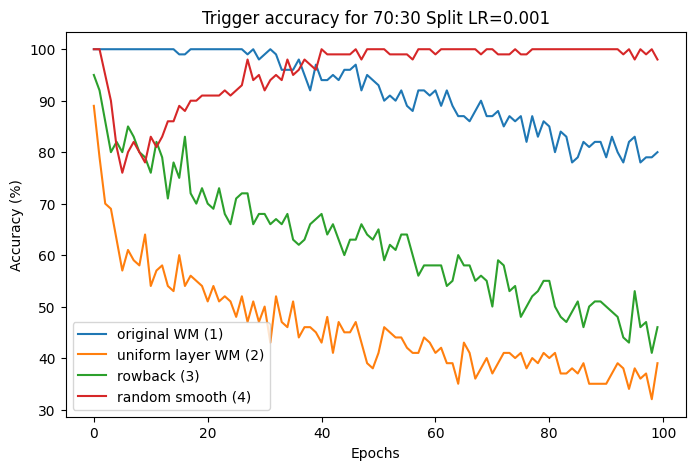

In [18]:
plt.figure(figsize=(8, 5))

plt.plot(range(len(metrics2['trigger_acc'])), metrics2['trigger_acc'], label='original WM (1)')
plt.plot(range(len(metrics3['trigger_acc'])), metrics3['trigger_acc'], label='uniform layer WM (2)')
plt.plot(range(len(metrics4['trigger_acc'])), metrics4['trigger_acc'], label='rowback (3)')

plt.plot(range(len(metrics['trigger_acc'])), metrics['trigger_acc'], label='random smooth (4)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Trigger accuracy for 70:30 Split LR=0.001')
plt.legend()
plt.savefig('incre_trigger_acc_7030_lr0.001.png')

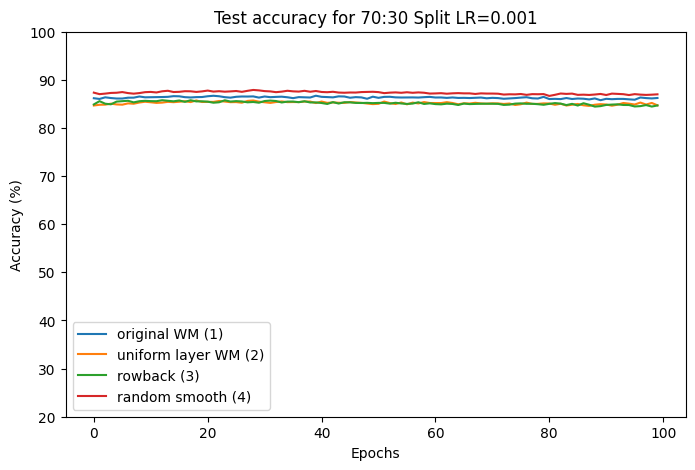

In [19]:
plt.figure(figsize=(8, 5))
plt.plot(range(len(metrics2['val_acc'])), metrics2['val_acc'], label='original WM (1)')
plt.plot(range(len(metrics3['val_acc'])), metrics3['val_acc'], label='uniform layer WM (2)')
plt.plot(range(len(metrics4['val_acc'])), metrics4['val_acc'], label='rowback (3)')

plt.plot(range(len(metrics['val_acc'])), metrics['val_acc'], label='random smooth (4)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test accuracy for 70:30 Split LR=0.001')
plt.ylim([20, 100])
plt.legend()
plt.savefig('incre_test_acc_7030_lr0.001.png')

LR=0.005

In [20]:
net5 = ResNet18()
net5.load_state_dict(torch.load('./models/wm_cifar10_certify_random_7030.pth')['model_state_dict'])
net6 = ResNet18()
net6.load_state_dict(torch.load('./checkpoints/resnet18_wm_7030.ckpt'))
net7 = ResNet18()
net7.load_state_dict(torch.load('./checkpoints/resnet18_wm_frozen_7030.ckpt'))
net8 = ResNet18()
net8.load_state_dict(torch.load('./checkpoints/resnet18_wm_rowback_7030.ckpt'))

<All keys matched successfully>

In [21]:
evaluator = Evaluator(net5, torch.nn.CrossEntropyLoss())
print(evaluator.eval(testloader))
print(evaluator.eval(unrelatedloader))

{'loss': 0.6196484971925617, 'accuracy': 87.48}
{'loss': 1.9492251813062466e-05, 'accuracy': 100.0}


In [22]:
evaluator = Evaluator(net6, torch.nn.CrossEntropyLoss())
print("Original watermarking scheme")
print(f"Test accuracy {evaluator.eval(testloader)}")
print(f"Watermark accuracy {evaluator.eval(wmloader)}")

Original watermarking scheme
Test accuracy {'loss': 0.4954307278931141, 'accuracy': 86.14}
Watermark accuracy {'loss': 0.00022258853365201504, 'accuracy': 100.0}


In [23]:
evaluator = Evaluator(net7, torch.nn.CrossEntropyLoss())
print("Frozen watermarking scheme")
print(f"Test accuracy {evaluator.eval(testloader)}")
print(f"Watermark accuracy {evaluator.eval(wmloader)}")

Frozen watermarking scheme
Test accuracy {'loss': 0.5337510022163391, 'accuracy': 85.11999999999999}
Watermark accuracy {'loss': 0.0010847488371655346, 'accuracy': 100.0}


In [24]:
evaluator = Evaluator(net8, torch.nn.CrossEntropyLoss())
print("ROWBack watermarking scheme")
print(f"Test accuracy {evaluator.eval(testloader)}")
print(f"Watermark accuracy {evaluator.eval(advwmloader)}")

ROWBack watermarking scheme
Test accuracy {'loss': 0.528250137591362, 'accuracy': 85.41}
Watermark accuracy {'loss': 0.0008670927817001939, 'accuracy': 100.0}


In [25]:
logcmt = f"incre_train_certified_7030"

optimizer5 = torch.optim.SGD(lr=0.005, params=net5.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer5 = Trainer(net5, criterion, optimizer5, incloader)
evaluator5 = Evaluator(net5, criterion)

metrics5 = train(trainer5, evaluator5, testloader, savename='inccheckpoints/incre_train_cert_7030_lr0.005', logdir='./runs', logcmt=logcmt, trigger_loader=unrelatedloader, epochs=100)

Start Training...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 0 | Time 7s| Train Loss 0.5185 | Train Acc 86.30| Val Loss 0.509 | Val Acc 86.61| Trigger Loss 0.539 | Trigger Acc 74.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 1 | Time 15s| Train Loss 0.3658 | Train Acc 88.08| Val Loss 0.429 | Val Acc 87.33| Trigger Loss 0.667 | Trigger Acc 64.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 2 | Time 22s| Train Loss 0.3196 | Train Acc 89.12| Val Loss 0.430 | Val Acc 87.23| Trigger Loss 0.554 | Trigger Acc 77.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 3 | Time 29s| Train Loss 0.3010 | Train Acc 89.63| Val Loss 0.432 | Val Acc 87.00| Trigger Loss 0.223 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 4 | Time 37s| Train Loss 0.2844 | Train Acc 90.33| Val Loss 0.424 | Val Acc 87.25| Trigger Loss 0.127 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 5 | Time 44s| Train Loss 0.2654 | Train Acc 90.83| Val Loss 0.417 | Val Acc 87.42| Trigger Loss 0.239 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 6 | Time 51s| Train Loss 0.2525 | Train Acc 91.26| Val Loss 0.420 | Val Acc 87.08| Trigger Loss 0.089 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 7 | Time 58s| Train Loss 0.2426 | Train Acc 91.72| Val Loss 0.427 | Val Acc 87.22| Trigger Loss 0.107 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 8 | Time 65s| Train Loss 0.2274 | Train Acc 92.38| Val Loss 0.426 | Val Acc 87.39| Trigger Loss 0.131 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 9 | Time 72s| Train Loss 0.2093 | Train Acc 92.77| Val Loss 0.434 | Val Acc 87.13| Trigger Loss 0.252 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 10 | Time 79s| Train Loss 0.1938 | Train Acc 93.38| Val Loss 0.460 | Val Acc 86.84| Trigger Loss 0.043 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 11 | Time 87s| Train Loss 0.1904 | Train Acc 93.47| Val Loss 0.458 | Val Acc 87.07| Trigger Loss 0.159 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 12 | Time 94s| Train Loss 0.1756 | Train Acc 93.85| Val Loss 0.462 | Val Acc 87.03| Trigger Loss 0.147 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 13 | Time 101s| Train Loss 0.1754 | Train Acc 93.89| Val Loss 0.456 | Val Acc 87.11| Trigger Loss 0.172 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 14 | Time 108s| Train Loss 0.1564 | Train Acc 94.78| Val Loss 0.467 | Val Acc 87.07| Trigger Loss 0.058 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 15 | Time 115s| Train Loss 0.1497 | Train Acc 94.84| Val Loss 0.493 | Val Acc 86.99| Trigger Loss 0.097 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 16 | Time 122s| Train Loss 0.1351 | Train Acc 95.34| Val Loss 0.487 | Val Acc 87.18| Trigger Loss 0.062 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 17 | Time 129s| Train Loss 0.1339 | Train Acc 95.12| Val Loss 0.502 | Val Acc 86.97| Trigger Loss 0.068 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 18 | Time 136s| Train Loss 0.1208 | Train Acc 95.86| Val Loss 0.501 | Val Acc 87.03| Trigger Loss 0.089 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 19 | Time 143s| Train Loss 0.1169 | Train Acc 96.15| Val Loss 0.512 | Val Acc 86.87| Trigger Loss 0.048 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 20 | Time 150s| Train Loss 0.1066 | Train Acc 96.47| Val Loss 0.533 | Val Acc 86.75| Trigger Loss 0.027 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 21 | Time 158s| Train Loss 0.0975 | Train Acc 96.91| Val Loss 0.531 | Val Acc 86.51| Trigger Loss 0.044 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 22 | Time 165s| Train Loss 0.0927 | Train Acc 97.00| Val Loss 0.538 | Val Acc 86.92| Trigger Loss 0.078 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 23 | Time 172s| Train Loss 0.0926 | Train Acc 96.97| Val Loss 0.552 | Val Acc 86.51| Trigger Loss 0.081 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 24 | Time 179s| Train Loss 0.0847 | Train Acc 97.05| Val Loss 0.549 | Val Acc 86.87| Trigger Loss 0.331 | Trigger Acc 88.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 25 | Time 186s| Train Loss 0.0810 | Train Acc 97.24| Val Loss 0.572 | Val Acc 86.46| Trigger Loss 0.126 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 26 | Time 193s| Train Loss 0.0680 | Train Acc 97.67| Val Loss 0.583 | Val Acc 86.94| Trigger Loss 0.109 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 27 | Time 200s| Train Loss 0.0645 | Train Acc 97.83| Val Loss 0.580 | Val Acc 87.14| Trigger Loss 0.198 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 28 | Time 207s| Train Loss 0.0623 | Train Acc 98.04| Val Loss 0.589 | Val Acc 86.98| Trigger Loss 0.326 | Trigger Acc 88.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 29 | Time 214s| Train Loss 0.0634 | Train Acc 97.92| Val Loss 0.586 | Val Acc 86.79| Trigger Loss 0.290 | Trigger Acc 88.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 30 | Time 221s| Train Loss 0.0568 | Train Acc 98.16| Val Loss 0.609 | Val Acc 86.55| Trigger Loss 0.167 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 31 | Time 228s| Train Loss 0.0572 | Train Acc 98.06| Val Loss 0.610 | Val Acc 86.29| Trigger Loss 0.063 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 32 | Time 235s| Train Loss 0.0521 | Train Acc 98.22| Val Loss 0.603 | Val Acc 86.40| Trigger Loss 0.158 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 33 | Time 243s| Train Loss 0.0503 | Train Acc 98.39| Val Loss 0.631 | Val Acc 86.14| Trigger Loss 0.194 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 34 | Time 250s| Train Loss 0.0500 | Train Acc 98.45| Val Loss 0.641 | Val Acc 86.26| Trigger Loss 0.179 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 35 | Time 257s| Train Loss 0.0493 | Train Acc 98.45| Val Loss 0.606 | Val Acc 86.78| Trigger Loss 0.148 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 36 | Time 264s| Train Loss 0.0438 | Train Acc 98.61| Val Loss 0.618 | Val Acc 86.50| Trigger Loss 0.288 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 37 | Time 271s| Train Loss 0.0397 | Train Acc 98.75| Val Loss 0.632 | Val Acc 86.53| Trigger Loss 0.091 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 38 | Time 278s| Train Loss 0.0365 | Train Acc 98.82| Val Loss 0.646 | Val Acc 86.31| Trigger Loss 0.221 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 39 | Time 285s| Train Loss 0.0383 | Train Acc 98.91| Val Loss 0.674 | Val Acc 86.18| Trigger Loss 0.566 | Trigger Acc 72.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 40 | Time 292s| Train Loss 0.0347 | Train Acc 98.97| Val Loss 0.633 | Val Acc 86.75| Trigger Loss 0.583 | Trigger Acc 70.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 41 | Time 299s| Train Loss 0.0346 | Train Acc 98.94| Val Loss 0.649 | Val Acc 86.79| Trigger Loss 0.261 | Trigger Acc 88.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 42 | Time 306s| Train Loss 0.0315 | Train Acc 99.00| Val Loss 0.643 | Val Acc 86.81| Trigger Loss 0.242 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 43 | Time 313s| Train Loss 0.0329 | Train Acc 99.00| Val Loss 0.646 | Val Acc 86.78| Trigger Loss 0.433 | Trigger Acc 84.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 44 | Time 320s| Train Loss 0.0256 | Train Acc 99.29| Val Loss 0.657 | Val Acc 86.79| Trigger Loss 0.482 | Trigger Acc 79.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 45 | Time 327s| Train Loss 0.0266 | Train Acc 99.24| Val Loss 0.658 | Val Acc 86.73| Trigger Loss 0.582 | Trigger Acc 72.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 46 | Time 334s| Train Loss 0.0279 | Train Acc 99.12| Val Loss 0.659 | Val Acc 86.68| Trigger Loss 0.211 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 47 | Time 341s| Train Loss 0.0268 | Train Acc 99.16| Val Loss 0.663 | Val Acc 86.62| Trigger Loss 0.086 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 48 | Time 348s| Train Loss 0.0244 | Train Acc 99.24| Val Loss 0.668 | Val Acc 86.91| Trigger Loss 0.127 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 49 | Time 355s| Train Loss 0.0252 | Train Acc 99.20| Val Loss 0.660 | Val Acc 86.75| Trigger Loss 0.095 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 50 | Time 362s| Train Loss 0.0272 | Train Acc 99.12| Val Loss 0.676 | Val Acc 86.64| Trigger Loss 0.119 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 51 | Time 369s| Train Loss 0.0232 | Train Acc 99.39| Val Loss 0.683 | Val Acc 86.83| Trigger Loss 0.078 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 52 | Time 376s| Train Loss 0.0214 | Train Acc 99.39| Val Loss 0.691 | Val Acc 86.97| Trigger Loss 0.164 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 53 | Time 383s| Train Loss 0.0203 | Train Acc 99.39| Val Loss 0.690 | Val Acc 86.89| Trigger Loss 0.032 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 54 | Time 391s| Train Loss 0.0193 | Train Acc 99.45| Val Loss 0.694 | Val Acc 87.00| Trigger Loss 0.109 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 55 | Time 398s| Train Loss 0.0178 | Train Acc 99.50| Val Loss 0.703 | Val Acc 87.03| Trigger Loss 0.087 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 56 | Time 405s| Train Loss 0.0202 | Train Acc 99.39| Val Loss 0.704 | Val Acc 86.86| Trigger Loss 0.133 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 57 | Time 412s| Train Loss 0.0188 | Train Acc 99.46| Val Loss 0.706 | Val Acc 87.21| Trigger Loss 0.361 | Trigger Acc 84.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 58 | Time 419s| Train Loss 0.0194 | Train Acc 99.39| Val Loss 0.725 | Val Acc 86.65| Trigger Loss 0.219 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.46it/s]


Epoch 59 | Time 426s| Train Loss 0.0204 | Train Acc 99.46| Val Loss 0.711 | Val Acc 86.47| Trigger Loss 0.173 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 60 | Time 433s| Train Loss 0.0162 | Train Acc 99.59| Val Loss 0.722 | Val Acc 86.43| Trigger Loss 0.476 | Trigger Acc 79.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 61 | Time 440s| Train Loss 0.0163 | Train Acc 99.55| Val Loss 0.709 | Val Acc 86.61| Trigger Loss 0.362 | Trigger Acc 86.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 62 | Time 447s| Train Loss 0.0174 | Train Acc 99.55| Val Loss 0.720 | Val Acc 86.47| Trigger Loss 0.555 | Trigger Acc 75.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 63 | Time 454s| Train Loss 0.0162 | Train Acc 99.53| Val Loss 0.708 | Val Acc 86.78| Trigger Loss 0.055 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 64 | Time 461s| Train Loss 0.0136 | Train Acc 99.60| Val Loss 0.729 | Val Acc 86.37| Trigger Loss 0.113 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 65 | Time 468s| Train Loss 0.0140 | Train Acc 99.63| Val Loss 0.724 | Val Acc 86.90| Trigger Loss 0.115 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 66 | Time 475s| Train Loss 0.0132 | Train Acc 99.65| Val Loss 0.739 | Val Acc 86.65| Trigger Loss 0.090 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 67 | Time 482s| Train Loss 0.0152 | Train Acc 99.57| Val Loss 0.727 | Val Acc 86.70| Trigger Loss 0.275 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 68 | Time 489s| Train Loss 0.0118 | Train Acc 99.73| Val Loss 0.718 | Val Acc 86.93| Trigger Loss 0.194 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 69 | Time 496s| Train Loss 0.0113 | Train Acc 99.71| Val Loss 0.719 | Val Acc 86.87| Trigger Loss 0.410 | Trigger Acc 85.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 70 | Time 503s| Train Loss 0.0115 | Train Acc 99.69| Val Loss 0.723 | Val Acc 87.25| Trigger Loss 0.242 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 71 | Time 511s| Train Loss 0.0116 | Train Acc 99.68| Val Loss 0.740 | Val Acc 86.72| Trigger Loss 0.319 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.46it/s]


Epoch 72 | Time 518s| Train Loss 0.0139 | Train Acc 99.61| Val Loss 0.726 | Val Acc 86.79| Trigger Loss 0.122 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 73 | Time 525s| Train Loss 0.0113 | Train Acc 99.71| Val Loss 0.748 | Val Acc 86.69| Trigger Loss 0.481 | Trigger Acc 79.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 74 | Time 532s| Train Loss 0.0114 | Train Acc 99.73| Val Loss 0.746 | Val Acc 86.72| Trigger Loss 0.142 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 75 | Time 539s| Train Loss 0.0123 | Train Acc 99.65| Val Loss 0.758 | Val Acc 86.72| Trigger Loss 0.465 | Trigger Acc 77.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 76 | Time 546s| Train Loss 0.0112 | Train Acc 99.71| Val Loss 0.758 | Val Acc 86.56| Trigger Loss 0.228 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 77 | Time 553s| Train Loss 0.0100 | Train Acc 99.78| Val Loss 0.745 | Val Acc 86.62| Trigger Loss 0.259 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 78 | Time 560s| Train Loss 0.0088 | Train Acc 99.79| Val Loss 0.755 | Val Acc 86.69| Trigger Loss 0.315 | Trigger Acc 88.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 79 | Time 567s| Train Loss 0.0090 | Train Acc 99.76| Val Loss 0.759 | Val Acc 86.70| Trigger Loss 0.377 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 80 | Time 574s| Train Loss 0.0090 | Train Acc 99.78| Val Loss 0.759 | Val Acc 86.71| Trigger Loss 0.305 | Trigger Acc 89.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 81 | Time 581s| Train Loss 0.0085 | Train Acc 99.79| Val Loss 0.759 | Val Acc 86.75| Trigger Loss 0.253 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.47it/s]


Epoch 82 | Time 588s| Train Loss 0.0074 | Train Acc 99.81| Val Loss 0.753 | Val Acc 86.72| Trigger Loss 0.265 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 83 | Time 595s| Train Loss 0.0096 | Train Acc 99.74| Val Loss 0.775 | Val Acc 86.62| Trigger Loss 0.344 | Trigger Acc 88.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 84 | Time 602s| Train Loss 0.0081 | Train Acc 99.83| Val Loss 0.761 | Val Acc 86.77| Trigger Loss 0.289 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.47it/s]


Epoch 85 | Time 609s| Train Loss 0.0088 | Train Acc 99.81| Val Loss 0.763 | Val Acc 87.01| Trigger Loss 0.509 | Trigger Acc 76.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 86 | Time 616s| Train Loss 0.0084 | Train Acc 99.79| Val Loss 0.780 | Val Acc 86.82| Trigger Loss 0.312 | Trigger Acc 89.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 87 | Time 623s| Train Loss 0.0082 | Train Acc 99.77| Val Loss 0.767 | Val Acc 86.81| Trigger Loss 0.321 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 88 | Time 630s| Train Loss 0.0089 | Train Acc 99.80| Val Loss 0.789 | Val Acc 86.61| Trigger Loss 0.242 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.47it/s]


Epoch 89 | Time 637s| Train Loss 0.0079 | Train Acc 99.77| Val Loss 0.776 | Val Acc 86.74| Trigger Loss 0.177 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 90 | Time 644s| Train Loss 0.0077 | Train Acc 99.79| Val Loss 0.754 | Val Acc 86.85| Trigger Loss 0.450 | Trigger Acc 83.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 91 | Time 651s| Train Loss 0.0081 | Train Acc 99.79| Val Loss 0.789 | Val Acc 86.41| Trigger Loss 0.196 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 92 | Time 658s| Train Loss 0.0073 | Train Acc 99.85| Val Loss 0.777 | Val Acc 86.69| Trigger Loss 0.315 | Trigger Acc 87.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 93 | Time 665s| Train Loss 0.0065 | Train Acc 99.84| Val Loss 0.771 | Val Acc 86.91| Trigger Loss 0.863 | Trigger Acc 63.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 94 | Time 673s| Train Loss 0.0070 | Train Acc 99.85| Val Loss 0.805 | Val Acc 86.81| Trigger Loss 0.947 | Trigger Acc 56.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 95 | Time 680s| Train Loss 0.0100 | Train Acc 99.75| Val Loss 0.795 | Val Acc 86.49| Trigger Loss 0.630 | Trigger Acc 72.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 96 | Time 687s| Train Loss 0.0087 | Train Acc 99.76| Val Loss 0.793 | Val Acc 86.81| Trigger Loss 1.140 | Trigger Acc 52.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 97 | Time 694s| Train Loss 0.0069 | Train Acc 99.81| Val Loss 0.776 | Val Acc 86.62| Trigger Loss 0.537 | Trigger Acc 76.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 98 | Time 701s| Train Loss 0.0076 | Train Acc 99.81| Val Loss 0.780 | Val Acc 86.58| Trigger Loss 0.237 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 99 | Time 708s| Train Loss 0.0109 | Train Acc 99.72| Val Loss 0.805 | Val Acc 86.53| Trigger Loss 0.415 | Trigger Acc 85.00


In [26]:
logcmt = f"incre_train_baseline_7030"

optimizer6 = torch.optim.SGD(lr=0.005, params=net6.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer6 = Trainer(net6, criterion, optimizer6, incloader)
evaluator6 = Evaluator(net6, criterion)

metrics6 = train(trainer6, evaluator6, testloader, savename='inccheckpoints/incre_train_baseline_7030_lr0.005', logdir='./runs', logcmt=logcmt, trigger_loader=wmloader, epochs=100)

Start Training...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 0 | Time 7s| Train Loss 0.4976 | Train Acc 84.74| Val Loss 0.498 | Val Acc 84.80| Trigger Loss 0.065 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 1 | Time 15s| Train Loss 0.3877 | Train Acc 86.89| Val Loss 0.462 | Val Acc 85.02| Trigger Loss 0.162 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 2 | Time 22s| Train Loss 0.3539 | Train Acc 87.92| Val Loss 0.446 | Val Acc 85.15| Trigger Loss 0.206 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 3 | Time 29s| Train Loss 0.3340 | Train Acc 88.64| Val Loss 0.428 | Val Acc 85.68| Trigger Loss 0.162 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 4 | Time 36s| Train Loss 0.3217 | Train Acc 89.15| Val Loss 0.429 | Val Acc 85.80| Trigger Loss 0.211 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 5 | Time 44s| Train Loss 0.3014 | Train Acc 89.47| Val Loss 0.426 | Val Acc 86.03| Trigger Loss 0.258 | Trigger Acc 89.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 6 | Time 51s| Train Loss 0.2886 | Train Acc 90.05| Val Loss 0.428 | Val Acc 86.33| Trigger Loss 0.274 | Trigger Acc 87.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 7 | Time 58s| Train Loss 0.2805 | Train Acc 90.37| Val Loss 0.433 | Val Acc 86.03| Trigger Loss 0.406 | Trigger Acc 84.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 8 | Time 65s| Train Loss 0.2680 | Train Acc 90.81| Val Loss 0.433 | Val Acc 86.60| Trigger Loss 0.387 | Trigger Acc 85.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 9 | Time 72s| Train Loss 0.2558 | Train Acc 91.30| Val Loss 0.446 | Val Acc 85.59| Trigger Loss 0.313 | Trigger Acc 89.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 10 | Time 79s| Train Loss 0.2406 | Train Acc 91.83| Val Loss 0.427 | Val Acc 86.43| Trigger Loss 0.409 | Trigger Acc 86.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 11 | Time 86s| Train Loss 0.2306 | Train Acc 92.18| Val Loss 0.473 | Val Acc 85.44| Trigger Loss 0.548 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 12 | Time 93s| Train Loss 0.2238 | Train Acc 92.48| Val Loss 0.464 | Val Acc 86.15| Trigger Loss 0.467 | Trigger Acc 78.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 13 | Time 100s| Train Loss 0.2166 | Train Acc 92.63| Val Loss 0.482 | Val Acc 85.66| Trigger Loss 0.483 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 14 | Time 107s| Train Loss 0.2121 | Train Acc 92.81| Val Loss 0.470 | Val Acc 85.61| Trigger Loss 0.675 | Trigger Acc 75.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 15 | Time 114s| Train Loss 0.1983 | Train Acc 93.26| Val Loss 0.491 | Val Acc 85.68| Trigger Loss 0.562 | Trigger Acc 80.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.22it/s]


Epoch 16 | Time 122s| Train Loss 0.1827 | Train Acc 93.83| Val Loss 0.500 | Val Acc 85.30| Trigger Loss 0.679 | Trigger Acc 73.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 17 | Time 129s| Train Loss 0.1798 | Train Acc 93.85| Val Loss 0.503 | Val Acc 85.54| Trigger Loss 0.819 | Trigger Acc 73.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 18 | Time 136s| Train Loss 0.1664 | Train Acc 94.42| Val Loss 0.552 | Val Acc 84.86| Trigger Loss 0.816 | Trigger Acc 71.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 19 | Time 143s| Train Loss 0.1633 | Train Acc 94.38| Val Loss 0.517 | Val Acc 85.46| Trigger Loss 0.886 | Trigger Acc 70.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 20 | Time 150s| Train Loss 0.1565 | Train Acc 94.50| Val Loss 0.513 | Val Acc 85.74| Trigger Loss 1.132 | Trigger Acc 64.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 21 | Time 157s| Train Loss 0.1507 | Train Acc 94.92| Val Loss 0.534 | Val Acc 85.49| Trigger Loss 0.897 | Trigger Acc 74.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 22 | Time 164s| Train Loss 0.1452 | Train Acc 94.95| Val Loss 0.514 | Val Acc 86.12| Trigger Loss 1.128 | Trigger Acc 62.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 23 | Time 171s| Train Loss 0.1328 | Train Acc 95.48| Val Loss 0.546 | Val Acc 85.67| Trigger Loss 1.120 | Trigger Acc 70.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 24 | Time 178s| Train Loss 0.1337 | Train Acc 95.26| Val Loss 0.560 | Val Acc 85.78| Trigger Loss 1.420 | Trigger Acc 58.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 25 | Time 185s| Train Loss 0.1271 | Train Acc 95.56| Val Loss 0.548 | Val Acc 85.79| Trigger Loss 1.118 | Trigger Acc 64.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 26 | Time 192s| Train Loss 0.1162 | Train Acc 95.99| Val Loss 0.565 | Val Acc 85.37| Trigger Loss 1.292 | Trigger Acc 63.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 27 | Time 199s| Train Loss 0.1125 | Train Acc 96.17| Val Loss 0.594 | Val Acc 85.16| Trigger Loss 1.627 | Trigger Acc 58.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 28 | Time 207s| Train Loss 0.1100 | Train Acc 96.26| Val Loss 0.565 | Val Acc 85.47| Trigger Loss 1.378 | Trigger Acc 66.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 29 | Time 214s| Train Loss 0.1097 | Train Acc 96.03| Val Loss 0.575 | Val Acc 85.47| Trigger Loss 1.576 | Trigger Acc 61.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 30 | Time 221s| Train Loss 0.0923 | Train Acc 96.81| Val Loss 0.633 | Val Acc 84.88| Trigger Loss 1.634 | Trigger Acc 58.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 31 | Time 228s| Train Loss 0.0942 | Train Acc 96.87| Val Loss 0.602 | Val Acc 85.28| Trigger Loss 1.598 | Trigger Acc 55.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 32 | Time 235s| Train Loss 0.0833 | Train Acc 97.03| Val Loss 0.595 | Val Acc 85.35| Trigger Loss 1.716 | Trigger Acc 50.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 33 | Time 242s| Train Loss 0.0856 | Train Acc 96.95| Val Loss 0.633 | Val Acc 85.64| Trigger Loss 1.554 | Trigger Acc 53.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 34 | Time 249s| Train Loss 0.0795 | Train Acc 97.27| Val Loss 0.655 | Val Acc 85.12| Trigger Loss 1.752 | Trigger Acc 55.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 35 | Time 256s| Train Loss 0.0746 | Train Acc 97.44| Val Loss 0.646 | Val Acc 85.17| Trigger Loss 1.698 | Trigger Acc 50.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 36 | Time 263s| Train Loss 0.0809 | Train Acc 97.16| Val Loss 0.680 | Val Acc 84.29| Trigger Loss 2.256 | Trigger Acc 49.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 37 | Time 270s| Train Loss 0.0722 | Train Acc 97.64| Val Loss 0.630 | Val Acc 85.67| Trigger Loss 2.365 | Trigger Acc 52.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 38 | Time 277s| Train Loss 0.0660 | Train Acc 97.72| Val Loss 0.655 | Val Acc 85.17| Trigger Loss 2.043 | Trigger Acc 57.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 39 | Time 284s| Train Loss 0.0638 | Train Acc 97.96| Val Loss 0.658 | Val Acc 85.54| Trigger Loss 2.351 | Trigger Acc 51.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 40 | Time 292s| Train Loss 0.0572 | Train Acc 98.01| Val Loss 0.668 | Val Acc 85.55| Trigger Loss 2.129 | Trigger Acc 53.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 41 | Time 299s| Train Loss 0.0565 | Train Acc 98.18| Val Loss 0.703 | Val Acc 85.08| Trigger Loss 2.295 | Trigger Acc 48.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 42 | Time 306s| Train Loss 0.0575 | Train Acc 98.15| Val Loss 0.659 | Val Acc 85.64| Trigger Loss 2.558 | Trigger Acc 48.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 43 | Time 313s| Train Loss 0.0526 | Train Acc 98.29| Val Loss 0.675 | Val Acc 85.48| Trigger Loss 2.166 | Trigger Acc 52.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 44 | Time 320s| Train Loss 0.0530 | Train Acc 98.20| Val Loss 0.720 | Val Acc 85.03| Trigger Loss 2.535 | Trigger Acc 45.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 45 | Time 327s| Train Loss 0.0522 | Train Acc 98.19| Val Loss 0.694 | Val Acc 85.68| Trigger Loss 2.611 | Trigger Acc 48.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 46 | Time 334s| Train Loss 0.0462 | Train Acc 98.48| Val Loss 0.702 | Val Acc 85.69| Trigger Loss 2.061 | Trigger Acc 52.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 47 | Time 341s| Train Loss 0.0438 | Train Acc 98.54| Val Loss 0.702 | Val Acc 85.17| Trigger Loss 2.392 | Trigger Acc 45.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 48 | Time 348s| Train Loss 0.0428 | Train Acc 98.60| Val Loss 0.728 | Val Acc 85.12| Trigger Loss 2.881 | Trigger Acc 46.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 49 | Time 355s| Train Loss 0.0374 | Train Acc 98.80| Val Loss 0.696 | Val Acc 85.80| Trigger Loss 2.772 | Trigger Acc 49.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 50 | Time 362s| Train Loss 0.0390 | Train Acc 98.69| Val Loss 0.770 | Val Acc 85.09| Trigger Loss 2.988 | Trigger Acc 47.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 51 | Time 369s| Train Loss 0.0390 | Train Acc 98.70| Val Loss 0.713 | Val Acc 85.62| Trigger Loss 2.773 | Trigger Acc 48.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 52 | Time 376s| Train Loss 0.0353 | Train Acc 98.83| Val Loss 0.708 | Val Acc 85.65| Trigger Loss 3.205 | Trigger Acc 46.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 53 | Time 383s| Train Loss 0.0329 | Train Acc 98.98| Val Loss 0.732 | Val Acc 85.48| Trigger Loss 2.772 | Trigger Acc 49.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 54 | Time 390s| Train Loss 0.0329 | Train Acc 98.89| Val Loss 0.742 | Val Acc 85.23| Trigger Loss 3.040 | Trigger Acc 46.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 55 | Time 398s| Train Loss 0.0373 | Train Acc 98.77| Val Loss 0.735 | Val Acc 85.65| Trigger Loss 3.176 | Trigger Acc 43.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 56 | Time 405s| Train Loss 0.0329 | Train Acc 98.87| Val Loss 0.720 | Val Acc 85.60| Trigger Loss 2.978 | Trigger Acc 44.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 57 | Time 412s| Train Loss 0.0286 | Train Acc 99.07| Val Loss 0.754 | Val Acc 85.73| Trigger Loss 2.932 | Trigger Acc 41.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 58 | Time 419s| Train Loss 0.0351 | Train Acc 98.83| Val Loss 0.800 | Val Acc 85.15| Trigger Loss 3.131 | Trigger Acc 42.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 59 | Time 426s| Train Loss 0.0278 | Train Acc 99.12| Val Loss 0.743 | Val Acc 85.71| Trigger Loss 3.286 | Trigger Acc 41.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 60 | Time 433s| Train Loss 0.0266 | Train Acc 99.14| Val Loss 0.743 | Val Acc 85.90| Trigger Loss 3.399 | Trigger Acc 40.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 61 | Time 440s| Train Loss 0.0272 | Train Acc 99.12| Val Loss 0.764 | Val Acc 85.83| Trigger Loss 3.019 | Trigger Acc 42.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 62 | Time 447s| Train Loss 0.0262 | Train Acc 99.12| Val Loss 0.764 | Val Acc 85.25| Trigger Loss 3.386 | Trigger Acc 43.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 63 | Time 454s| Train Loss 0.0283 | Train Acc 99.07| Val Loss 0.780 | Val Acc 85.70| Trigger Loss 3.413 | Trigger Acc 45.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 64 | Time 461s| Train Loss 0.0320 | Train Acc 98.94| Val Loss 0.784 | Val Acc 85.64| Trigger Loss 3.525 | Trigger Acc 38.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 65 | Time 468s| Train Loss 0.0279 | Train Acc 99.06| Val Loss 0.763 | Val Acc 85.52| Trigger Loss 3.284 | Trigger Acc 42.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 66 | Time 475s| Train Loss 0.0265 | Train Acc 99.00| Val Loss 0.781 | Val Acc 85.53| Trigger Loss 3.677 | Trigger Acc 35.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 67 | Time 482s| Train Loss 0.0268 | Train Acc 99.14| Val Loss 0.789 | Val Acc 85.51| Trigger Loss 3.566 | Trigger Acc 46.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 68 | Time 490s| Train Loss 0.0207 | Train Acc 99.35| Val Loss 0.764 | Val Acc 85.85| Trigger Loss 3.950 | Trigger Acc 38.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 69 | Time 497s| Train Loss 0.0218 | Train Acc 99.35| Val Loss 0.782 | Val Acc 85.92| Trigger Loss 3.754 | Trigger Acc 40.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 70 | Time 504s| Train Loss 0.0272 | Train Acc 99.06| Val Loss 0.775 | Val Acc 85.72| Trigger Loss 3.718 | Trigger Acc 35.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 71 | Time 511s| Train Loss 0.0233 | Train Acc 99.16| Val Loss 0.757 | Val Acc 86.17| Trigger Loss 3.920 | Trigger Acc 36.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.29it/s]


Epoch 72 | Time 518s| Train Loss 0.0208 | Train Acc 99.36| Val Loss 0.789 | Val Acc 85.79| Trigger Loss 3.860 | Trigger Acc 37.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 73 | Time 525s| Train Loss 0.0222 | Train Acc 99.31| Val Loss 0.789 | Val Acc 85.37| Trigger Loss 3.935 | Trigger Acc 35.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 74 | Time 532s| Train Loss 0.0181 | Train Acc 99.45| Val Loss 0.795 | Val Acc 85.49| Trigger Loss 3.981 | Trigger Acc 40.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 75 | Time 539s| Train Loss 0.0162 | Train Acc 99.55| Val Loss 0.820 | Val Acc 85.19| Trigger Loss 4.315 | Trigger Acc 37.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 76 | Time 546s| Train Loss 0.0178 | Train Acc 99.45| Val Loss 0.785 | Val Acc 85.68| Trigger Loss 3.837 | Trigger Acc 44.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 77 | Time 553s| Train Loss 0.0170 | Train Acc 99.53| Val Loss 0.825 | Val Acc 85.38| Trigger Loss 3.387 | Trigger Acc 43.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 78 | Time 560s| Train Loss 0.0184 | Train Acc 99.40| Val Loss 0.793 | Val Acc 85.58| Trigger Loss 4.066 | Trigger Acc 36.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 79 | Time 567s| Train Loss 0.0194 | Train Acc 99.36| Val Loss 0.787 | Val Acc 85.58| Trigger Loss 4.013 | Trigger Acc 39.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 80 | Time 574s| Train Loss 0.0173 | Train Acc 99.50| Val Loss 0.810 | Val Acc 85.80| Trigger Loss 3.872 | Trigger Acc 35.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 81 | Time 581s| Train Loss 0.0193 | Train Acc 99.36| Val Loss 0.793 | Val Acc 85.88| Trigger Loss 4.028 | Trigger Acc 39.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 82 | Time 589s| Train Loss 0.0153 | Train Acc 99.55| Val Loss 0.799 | Val Acc 85.55| Trigger Loss 3.969 | Trigger Acc 39.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 83 | Time 596s| Train Loss 0.0177 | Train Acc 99.50| Val Loss 0.812 | Val Acc 85.32| Trigger Loss 4.085 | Trigger Acc 37.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 84 | Time 603s| Train Loss 0.0188 | Train Acc 99.36| Val Loss 0.807 | Val Acc 85.71| Trigger Loss 4.056 | Trigger Acc 32.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 85 | Time 610s| Train Loss 0.0195 | Train Acc 99.42| Val Loss 0.809 | Val Acc 85.76| Trigger Loss 3.676 | Trigger Acc 35.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 86 | Time 617s| Train Loss 0.0163 | Train Acc 99.45| Val Loss 0.807 | Val Acc 85.90| Trigger Loss 4.230 | Trigger Acc 35.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 87 | Time 624s| Train Loss 0.0145 | Train Acc 99.54| Val Loss 0.814 | Val Acc 86.03| Trigger Loss 4.477 | Trigger Acc 36.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 88 | Time 631s| Train Loss 0.0110 | Train Acc 99.69| Val Loss 0.788 | Val Acc 85.98| Trigger Loss 4.158 | Trigger Acc 38.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 89 | Time 638s| Train Loss 0.0122 | Train Acc 99.63| Val Loss 0.809 | Val Acc 86.04| Trigger Loss 4.374 | Trigger Acc 33.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 90 | Time 645s| Train Loss 0.0125 | Train Acc 99.66| Val Loss 0.824 | Val Acc 85.72| Trigger Loss 4.623 | Trigger Acc 37.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 91 | Time 652s| Train Loss 0.0106 | Train Acc 99.69| Val Loss 0.876 | Val Acc 85.36| Trigger Loss 4.398 | Trigger Acc 36.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 92 | Time 659s| Train Loss 0.0133 | Train Acc 99.54| Val Loss 0.840 | Val Acc 85.69| Trigger Loss 4.601 | Trigger Acc 34.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 93 | Time 666s| Train Loss 0.0117 | Train Acc 99.65| Val Loss 0.831 | Val Acc 85.73| Trigger Loss 4.599 | Trigger Acc 31.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 94 | Time 673s| Train Loss 0.0090 | Train Acc 99.79| Val Loss 0.833 | Val Acc 85.74| Trigger Loss 4.367 | Trigger Acc 33.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 95 | Time 680s| Train Loss 0.0102 | Train Acc 99.69| Val Loss 0.830 | Val Acc 85.84| Trigger Loss 4.428 | Trigger Acc 34.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 96 | Time 688s| Train Loss 0.0104 | Train Acc 99.73| Val Loss 0.829 | Val Acc 85.97| Trigger Loss 4.792 | Trigger Acc 35.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 97 | Time 695s| Train Loss 0.0111 | Train Acc 99.63| Val Loss 0.841 | Val Acc 85.99| Trigger Loss 4.592 | Trigger Acc 33.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 98 | Time 702s| Train Loss 0.0131 | Train Acc 99.60| Val Loss 0.841 | Val Acc 85.97| Trigger Loss 4.469 | Trigger Acc 38.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 99 | Time 709s| Train Loss 0.0116 | Train Acc 99.65| Val Loss 0.826 | Val Acc 85.93| Trigger Loss 4.860 | Trigger Acc 33.00


In [27]:
logcmt = f"incre_train_baseline_frozen_7030"

optimizer7 = torch.optim.SGD(lr=0.005, params=net7.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer7 = Trainer(net7, criterion, optimizer7, incloader)
evaluator7 = Evaluator(net7, criterion)
metrics6
metrics7 = train(trainer7, evaluator7, testloader, savename='inccheckpoints/incre_train_baseline_frozen_7030_lr0.005', logdir='./runs', logcmt=logcmt, trigger_loader=wmloader, epochs=100)

Start Training...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 0 | Time 7s| Train Loss 0.5366 | Train Acc 83.12| Val Loss 0.579 | Val Acc 82.43| Trigger Loss 3.464 | Trigger Acc 36.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 1 | Time 15s| Train Loss 0.4424 | Train Acc 85.06| Val Loss 0.485 | Val Acc 84.03| Trigger Loss 3.164 | Trigger Acc 29.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 2 | Time 22s| Train Loss 0.3939 | Train Acc 86.34| Val Loss 0.454 | Val Acc 84.92| Trigger Loss 3.347 | Trigger Acc 27.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 3 | Time 29s| Train Loss 0.3732 | Train Acc 87.03| Val Loss 0.486 | Val Acc 84.01| Trigger Loss 3.855 | Trigger Acc 25.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 4 | Time 36s| Train Loss 0.3540 | Train Acc 87.69| Val Loss 0.460 | Val Acc 84.98| Trigger Loss 3.729 | Trigger Acc 27.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 5 | Time 43s| Train Loss 0.3399 | Train Acc 88.22| Val Loss 0.476 | Val Acc 84.37| Trigger Loss 3.536 | Trigger Acc 25.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 6 | Time 51s| Train Loss 0.3231 | Train Acc 88.76| Val Loss 0.475 | Val Acc 84.62| Trigger Loss 4.002 | Trigger Acc 23.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 7 | Time 58s| Train Loss 0.3116 | Train Acc 89.05| Val Loss 0.483 | Val Acc 84.14| Trigger Loss 4.211 | Trigger Acc 26.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 8 | Time 65s| Train Loss 0.2957 | Train Acc 89.88| Val Loss 0.485 | Val Acc 84.42| Trigger Loss 3.842 | Trigger Acc 25.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 9 | Time 72s| Train Loss 0.2800 | Train Acc 90.47| Val Loss 0.514 | Val Acc 84.13| Trigger Loss 4.122 | Trigger Acc 21.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 10 | Time 79s| Train Loss 0.2735 | Train Acc 90.47| Val Loss 0.474 | Val Acc 85.23| Trigger Loss 4.700 | Trigger Acc 22.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 11 | Time 86s| Train Loss 0.2579 | Train Acc 91.02| Val Loss 0.499 | Val Acc 84.98| Trigger Loss 4.567 | Trigger Acc 26.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 12 | Time 93s| Train Loss 0.2493 | Train Acc 91.56| Val Loss 0.520 | Val Acc 84.57| Trigger Loss 4.783 | Trigger Acc 20.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 13 | Time 100s| Train Loss 0.2364 | Train Acc 91.96| Val Loss 0.521 | Val Acc 84.64| Trigger Loss 5.241 | Trigger Acc 21.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 14 | Time 107s| Train Loss 0.2290 | Train Acc 92.01| Val Loss 0.524 | Val Acc 84.51| Trigger Loss 5.070 | Trigger Acc 20.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 15 | Time 114s| Train Loss 0.2220 | Train Acc 92.23| Val Loss 0.546 | Val Acc 84.01| Trigger Loss 5.912 | Trigger Acc 15.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 16 | Time 121s| Train Loss 0.2118 | Train Acc 92.59| Val Loss 0.561 | Val Acc 84.37| Trigger Loss 5.672 | Trigger Acc 22.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 17 | Time 128s| Train Loss 0.2054 | Train Acc 92.67| Val Loss 0.587 | Val Acc 83.60| Trigger Loss 5.649 | Trigger Acc 22.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 18 | Time 135s| Train Loss 0.1931 | Train Acc 93.38| Val Loss 0.574 | Val Acc 83.85| Trigger Loss 5.435 | Trigger Acc 21.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 19 | Time 142s| Train Loss 0.1803 | Train Acc 93.87| Val Loss 0.576 | Val Acc 83.93| Trigger Loss 5.782 | Trigger Acc 18.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 20 | Time 150s| Train Loss 0.1755 | Train Acc 94.00| Val Loss 0.576 | Val Acc 84.54| Trigger Loss 5.895 | Trigger Acc 16.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 21 | Time 157s| Train Loss 0.1634 | Train Acc 94.57| Val Loss 0.576 | Val Acc 84.39| Trigger Loss 6.199 | Trigger Acc 15.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.32it/s]


Epoch 22 | Time 164s| Train Loss 0.1646 | Train Acc 94.38| Val Loss 0.589 | Val Acc 83.98| Trigger Loss 5.959 | Trigger Acc 20.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 23 | Time 171s| Train Loss 0.1494 | Train Acc 94.52| Val Loss 0.579 | Val Acc 84.79| Trigger Loss 6.736 | Trigger Acc 15.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 24 | Time 178s| Train Loss 0.1437 | Train Acc 94.97| Val Loss 0.602 | Val Acc 84.23| Trigger Loss 6.462 | Trigger Acc 17.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 25 | Time 185s| Train Loss 0.1388 | Train Acc 95.24| Val Loss 0.599 | Val Acc 84.10| Trigger Loss 6.662 | Trigger Acc 20.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 26 | Time 192s| Train Loss 0.1342 | Train Acc 95.38| Val Loss 0.622 | Val Acc 84.10| Trigger Loss 6.840 | Trigger Acc 19.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 27 | Time 199s| Train Loss 0.1266 | Train Acc 95.65| Val Loss 0.611 | Val Acc 84.57| Trigger Loss 7.182 | Trigger Acc 16.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 28 | Time 206s| Train Loss 0.1266 | Train Acc 95.65| Val Loss 0.669 | Val Acc 83.98| Trigger Loss 7.099 | Trigger Acc 15.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 29 | Time 213s| Train Loss 0.1113 | Train Acc 96.15| Val Loss 0.622 | Val Acc 84.91| Trigger Loss 7.202 | Trigger Acc 18.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.32it/s]


Epoch 30 | Time 220s| Train Loss 0.1058 | Train Acc 96.54| Val Loss 0.658 | Val Acc 84.08| Trigger Loss 7.787 | Trigger Acc 16.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 31 | Time 227s| Train Loss 0.1023 | Train Acc 96.51| Val Loss 0.659 | Val Acc 84.51| Trigger Loss 7.546 | Trigger Acc 15.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.32it/s]


Epoch 32 | Time 235s| Train Loss 0.0973 | Train Acc 96.65| Val Loss 0.701 | Val Acc 83.87| Trigger Loss 7.378 | Trigger Acc 15.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 33 | Time 242s| Train Loss 0.1053 | Train Acc 96.26| Val Loss 0.669 | Val Acc 83.81| Trigger Loss 7.656 | Trigger Acc 15.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 34 | Time 249s| Train Loss 0.0920 | Train Acc 96.83| Val Loss 0.641 | Val Acc 84.76| Trigger Loss 7.912 | Trigger Acc 15.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 35 | Time 256s| Train Loss 0.0830 | Train Acc 97.11| Val Loss 0.643 | Val Acc 84.83| Trigger Loss 8.167 | Trigger Acc 15.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 36 | Time 263s| Train Loss 0.0793 | Train Acc 97.31| Val Loss 0.706 | Val Acc 84.28| Trigger Loss 7.987 | Trigger Acc 18.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 37 | Time 270s| Train Loss 0.0749 | Train Acc 97.63| Val Loss 0.675 | Val Acc 84.73| Trigger Loss 8.286 | Trigger Acc 17.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 38 | Time 277s| Train Loss 0.0753 | Train Acc 97.44| Val Loss 0.678 | Val Acc 84.63| Trigger Loss 8.087 | Trigger Acc 16.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 39 | Time 284s| Train Loss 0.0744 | Train Acc 97.52| Val Loss 0.692 | Val Acc 84.49| Trigger Loss 8.433 | Trigger Acc 13.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 40 | Time 291s| Train Loss 0.0708 | Train Acc 97.69| Val Loss 0.709 | Val Acc 84.68| Trigger Loss 8.729 | Trigger Acc 11.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 41 | Time 298s| Train Loss 0.0650 | Train Acc 97.80| Val Loss 0.691 | Val Acc 84.57| Trigger Loss 8.791 | Trigger Acc 11.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 42 | Time 305s| Train Loss 0.0668 | Train Acc 97.76| Val Loss 0.702 | Val Acc 84.85| Trigger Loss 8.714 | Trigger Acc 11.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 43 | Time 312s| Train Loss 0.0654 | Train Acc 97.80| Val Loss 0.762 | Val Acc 83.84| Trigger Loss 8.759 | Trigger Acc 17.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 44 | Time 320s| Train Loss 0.0665 | Train Acc 97.64| Val Loss 0.767 | Val Acc 83.94| Trigger Loss 8.843 | Trigger Acc 14.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 45 | Time 327s| Train Loss 0.0598 | Train Acc 97.94| Val Loss 0.778 | Val Acc 83.59| Trigger Loss 8.863 | Trigger Acc 13.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 46 | Time 334s| Train Loss 0.0593 | Train Acc 98.12| Val Loss 0.693 | Val Acc 85.33| Trigger Loss 8.932 | Trigger Acc 15.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 47 | Time 341s| Train Loss 0.0537 | Train Acc 98.18| Val Loss 0.738 | Val Acc 84.29| Trigger Loss 8.817 | Trigger Acc 14.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 48 | Time 348s| Train Loss 0.0476 | Train Acc 98.36| Val Loss 0.726 | Val Acc 84.75| Trigger Loss 9.141 | Trigger Acc 14.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 49 | Time 355s| Train Loss 0.0504 | Train Acc 98.20| Val Loss 0.826 | Val Acc 83.90| Trigger Loss 9.759 | Trigger Acc 9.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 50 | Time 362s| Train Loss 0.0603 | Train Acc 98.04| Val Loss 0.728 | Val Acc 84.83| Trigger Loss 9.057 | Trigger Acc 15.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 51 | Time 369s| Train Loss 0.0490 | Train Acc 98.31| Val Loss 0.743 | Val Acc 84.60| Trigger Loss 9.721 | Trigger Acc 13.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 52 | Time 376s| Train Loss 0.0442 | Train Acc 98.50| Val Loss 0.743 | Val Acc 85.06| Trigger Loss 9.515 | Trigger Acc 11.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 53 | Time 383s| Train Loss 0.0397 | Train Acc 98.75| Val Loss 0.763 | Val Acc 84.28| Trigger Loss 9.826 | Trigger Acc 10.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.32it/s]


Epoch 54 | Time 390s| Train Loss 0.0372 | Train Acc 98.70| Val Loss 0.758 | Val Acc 84.58| Trigger Loss 9.369 | Trigger Acc 15.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 55 | Time 397s| Train Loss 0.0380 | Train Acc 98.79| Val Loss 0.778 | Val Acc 85.00| Trigger Loss 10.226 | Trigger Acc 11.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.31it/s]


Epoch 56 | Time 404s| Train Loss 0.0280 | Train Acc 99.11| Val Loss 0.778 | Val Acc 85.11| Trigger Loss 10.015 | Trigger Acc 10.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 57 | Time 411s| Train Loss 0.0335 | Train Acc 98.91| Val Loss 0.774 | Val Acc 84.90| Trigger Loss 10.153 | Trigger Acc 8.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 58 | Time 418s| Train Loss 0.0334 | Train Acc 98.96| Val Loss 0.788 | Val Acc 84.72| Trigger Loss 10.630 | Trigger Acc 11.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 59 | Time 426s| Train Loss 0.0353 | Train Acc 98.93| Val Loss 0.804 | Val Acc 84.50| Trigger Loss 9.815 | Trigger Acc 10.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 60 | Time 433s| Train Loss 0.0303 | Train Acc 99.12| Val Loss 0.789 | Val Acc 84.73| Trigger Loss 10.532 | Trigger Acc 10.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 61 | Time 440s| Train Loss 0.0249 | Train Acc 99.27| Val Loss 0.796 | Val Acc 84.97| Trigger Loss 10.641 | Trigger Acc 10.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.31it/s]


Epoch 62 | Time 447s| Train Loss 0.0326 | Train Acc 98.94| Val Loss 0.877 | Val Acc 84.36| Trigger Loss 11.178 | Trigger Acc 9.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 63 | Time 454s| Train Loss 0.0331 | Train Acc 98.88| Val Loss 0.767 | Val Acc 85.25| Trigger Loss 10.587 | Trigger Acc 8.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 64 | Time 461s| Train Loss 0.0276 | Train Acc 99.13| Val Loss 0.807 | Val Acc 84.85| Trigger Loss 10.993 | Trigger Acc 8.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 65 | Time 468s| Train Loss 0.0226 | Train Acc 99.34| Val Loss 0.764 | Val Acc 85.30| Trigger Loss 10.576 | Trigger Acc 10.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 66 | Time 475s| Train Loss 0.0182 | Train Acc 99.51| Val Loss 0.761 | Val Acc 85.32| Trigger Loss 10.482 | Trigger Acc 12.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 67 | Time 482s| Train Loss 0.0199 | Train Acc 99.41| Val Loss 0.814 | Val Acc 84.80| Trigger Loss 10.721 | Trigger Acc 9.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 68 | Time 489s| Train Loss 0.0214 | Train Acc 99.34| Val Loss 0.829 | Val Acc 85.13| Trigger Loss 11.341 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 69 | Time 496s| Train Loss 0.0230 | Train Acc 99.25| Val Loss 0.792 | Val Acc 85.32| Trigger Loss 10.869 | Trigger Acc 8.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 70 | Time 503s| Train Loss 0.0233 | Train Acc 99.23| Val Loss 0.856 | Val Acc 84.59| Trigger Loss 10.638 | Trigger Acc 10.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 71 | Time 510s| Train Loss 0.0245 | Train Acc 99.19| Val Loss 0.830 | Val Acc 84.86| Trigger Loss 11.027 | Trigger Acc 10.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 72 | Time 517s| Train Loss 0.0259 | Train Acc 99.17| Val Loss 0.869 | Val Acc 84.51| Trigger Loss 11.034 | Trigger Acc 9.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 73 | Time 525s| Train Loss 0.0255 | Train Acc 99.11| Val Loss 0.834 | Val Acc 84.43| Trigger Loss 11.459 | Trigger Acc 9.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 74 | Time 532s| Train Loss 0.0247 | Train Acc 99.21| Val Loss 0.839 | Val Acc 85.04| Trigger Loss 11.276 | Trigger Acc 11.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 75 | Time 539s| Train Loss 0.0277 | Train Acc 99.14| Val Loss 0.821 | Val Acc 85.09| Trigger Loss 11.307 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 76 | Time 546s| Train Loss 0.0278 | Train Acc 99.09| Val Loss 0.899 | Val Acc 84.44| Trigger Loss 11.189 | Trigger Acc 9.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 77 | Time 553s| Train Loss 0.0247 | Train Acc 99.19| Val Loss 0.883 | Val Acc 84.14| Trigger Loss 11.271 | Trigger Acc 10.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 78 | Time 560s| Train Loss 0.0207 | Train Acc 99.36| Val Loss 0.828 | Val Acc 84.95| Trigger Loss 11.334 | Trigger Acc 12.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 79 | Time 567s| Train Loss 0.0229 | Train Acc 99.22| Val Loss 0.842 | Val Acc 84.99| Trigger Loss 11.911 | Trigger Acc 12.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 80 | Time 574s| Train Loss 0.0230 | Train Acc 99.23| Val Loss 0.925 | Val Acc 84.49| Trigger Loss 11.653 | Trigger Acc 10.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 81 | Time 581s| Train Loss 0.0223 | Train Acc 99.26| Val Loss 0.868 | Val Acc 84.64| Trigger Loss 11.766 | Trigger Acc 8.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 82 | Time 588s| Train Loss 0.0251 | Train Acc 99.27| Val Loss 0.846 | Val Acc 85.09| Trigger Loss 11.917 | Trigger Acc 8.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 83 | Time 595s| Train Loss 0.0244 | Train Acc 99.21| Val Loss 0.832 | Val Acc 85.21| Trigger Loss 11.608 | Trigger Acc 9.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 84 | Time 602s| Train Loss 0.0186 | Train Acc 99.41| Val Loss 0.881 | Val Acc 84.91| Trigger Loss 12.230 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 85 | Time 609s| Train Loss 0.0163 | Train Acc 99.52| Val Loss 0.838 | Val Acc 85.18| Trigger Loss 12.058 | Trigger Acc 10.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 86 | Time 616s| Train Loss 0.0175 | Train Acc 99.47| Val Loss 0.853 | Val Acc 85.38| Trigger Loss 12.039 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 87 | Time 624s| Train Loss 0.0196 | Train Acc 99.39| Val Loss 0.873 | Val Acc 84.56| Trigger Loss 12.157 | Trigger Acc 10.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 88 | Time 631s| Train Loss 0.0159 | Train Acc 99.54| Val Loss 0.877 | Val Acc 84.69| Trigger Loss 12.237 | Trigger Acc 8.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 89 | Time 638s| Train Loss 0.0154 | Train Acc 99.54| Val Loss 0.838 | Val Acc 85.17| Trigger Loss 11.842 | Trigger Acc 11.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 90 | Time 645s| Train Loss 0.0143 | Train Acc 99.55| Val Loss 0.841 | Val Acc 85.56| Trigger Loss 12.656 | Trigger Acc 8.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 91 | Time 652s| Train Loss 0.0123 | Train Acc 99.67| Val Loss 0.848 | Val Acc 85.12| Trigger Loss 12.288 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 92 | Time 659s| Train Loss 0.0144 | Train Acc 99.55| Val Loss 0.884 | Val Acc 85.00| Trigger Loss 12.527 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 93 | Time 666s| Train Loss 0.0136 | Train Acc 99.59| Val Loss 0.859 | Val Acc 85.01| Trigger Loss 12.251 | Trigger Acc 8.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 94 | Time 673s| Train Loss 0.0125 | Train Acc 99.61| Val Loss 0.854 | Val Acc 85.35| Trigger Loss 12.368 | Trigger Acc 8.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 95 | Time 680s| Train Loss 0.0111 | Train Acc 99.66| Val Loss 0.836 | Val Acc 85.68| Trigger Loss 12.488 | Trigger Acc 8.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 96 | Time 687s| Train Loss 0.0104 | Train Acc 99.74| Val Loss 0.876 | Val Acc 84.92| Trigger Loss 12.393 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 97 | Time 694s| Train Loss 0.0087 | Train Acc 99.79| Val Loss 0.855 | Val Acc 85.53| Trigger Loss 12.199 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 98 | Time 701s| Train Loss 0.0103 | Train Acc 99.70| Val Loss 0.837 | Val Acc 85.17| Trigger Loss 11.903 | Trigger Acc 8.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 99 | Time 709s| Train Loss 0.0104 | Train Acc 99.72| Val Loss 0.847 | Val Acc 85.42| Trigger Loss 12.629 | Trigger Acc 8.00


In [28]:
logcmt = f"incre_train_baseline_rowback_7030"

optimizer8 = torch.optim.SGD(lr=0.005, params=net8.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer8 = Trainer(net8, criterion, optimizer8, incloader)
evaluator8 = Evaluator(net8, criterion)

metrics8 = train(trainer8, evaluator8, testloader, savename='inccheckpoints/incre_train_baseline_rowback_7030_lr0.005', logdir='./runs', logcmt=logcmt, trigger_loader=advwmloader, epochs=100)

Start Training...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 0 | Time 7s| Train Loss 0.5251 | Train Acc 83.69| Val Loss 0.564 | Val Acc 83.02| Trigger Loss 2.494 | Trigger Acc 42.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 1 | Time 15s| Train Loss 0.4317 | Train Acc 85.55| Val Loss 0.479 | Val Acc 84.42| Trigger Loss 1.892 | Trigger Acc 43.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 2 | Time 23s| Train Loss 0.3974 | Train Acc 86.39| Val Loss 0.488 | Val Acc 84.36| Trigger Loss 2.224 | Trigger Acc 40.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 3 | Time 30s| Train Loss 0.3745 | Train Acc 86.97| Val Loss 0.489 | Val Acc 84.03| Trigger Loss 2.090 | Trigger Acc 45.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 4 | Time 37s| Train Loss 0.3480 | Train Acc 87.77| Val Loss 0.472 | Val Acc 84.79| Trigger Loss 2.701 | Trigger Acc 31.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 5 | Time 44s| Train Loss 0.3339 | Train Acc 88.37| Val Loss 0.477 | Val Acc 84.47| Trigger Loss 2.976 | Trigger Acc 33.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 6 | Time 51s| Train Loss 0.3180 | Train Acc 89.12| Val Loss 0.482 | Val Acc 84.59| Trigger Loss 2.499 | Trigger Acc 35.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 7 | Time 58s| Train Loss 0.3038 | Train Acc 89.52| Val Loss 0.475 | Val Acc 84.98| Trigger Loss 2.656 | Trigger Acc 34.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 8 | Time 65s| Train Loss 0.2965 | Train Acc 89.59| Val Loss 0.470 | Val Acc 85.07| Trigger Loss 2.402 | Trigger Acc 40.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 9 | Time 72s| Train Loss 0.2870 | Train Acc 90.11| Val Loss 0.495 | Val Acc 84.41| Trigger Loss 3.107 | Trigger Acc 34.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 10 | Time 79s| Train Loss 0.2682 | Train Acc 90.83| Val Loss 0.496 | Val Acc 84.73| Trigger Loss 2.643 | Trigger Acc 26.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 11 | Time 87s| Train Loss 0.2575 | Train Acc 91.28| Val Loss 0.474 | Val Acc 85.18| Trigger Loss 3.235 | Trigger Acc 29.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 12 | Time 94s| Train Loss 0.2413 | Train Acc 91.80| Val Loss 0.489 | Val Acc 85.40| Trigger Loss 2.635 | Trigger Acc 30.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 13 | Time 101s| Train Loss 0.2322 | Train Acc 91.82| Val Loss 0.510 | Val Acc 85.11| Trigger Loss 3.590 | Trigger Acc 21.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 14 | Time 108s| Train Loss 0.2229 | Train Acc 92.10| Val Loss 0.528 | Val Acc 84.55| Trigger Loss 3.561 | Trigger Acc 31.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 15 | Time 115s| Train Loss 0.2149 | Train Acc 92.44| Val Loss 0.543 | Val Acc 83.81| Trigger Loss 3.438 | Trigger Acc 25.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 16 | Time 122s| Train Loss 0.1996 | Train Acc 93.10| Val Loss 0.524 | Val Acc 84.92| Trigger Loss 3.611 | Trigger Acc 25.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 17 | Time 129s| Train Loss 0.1995 | Train Acc 93.11| Val Loss 0.542 | Val Acc 84.85| Trigger Loss 3.456 | Trigger Acc 32.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 18 | Time 136s| Train Loss 0.1883 | Train Acc 93.41| Val Loss 0.548 | Val Acc 84.27| Trigger Loss 3.586 | Trigger Acc 30.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 19 | Time 143s| Train Loss 0.1824 | Train Acc 93.56| Val Loss 0.565 | Val Acc 84.33| Trigger Loss 4.601 | Trigger Acc 17.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 20 | Time 150s| Train Loss 0.1737 | Train Acc 94.07| Val Loss 0.564 | Val Acc 84.60| Trigger Loss 4.228 | Trigger Acc 23.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 21 | Time 157s| Train Loss 0.1629 | Train Acc 94.19| Val Loss 0.598 | Val Acc 84.12| Trigger Loss 3.961 | Trigger Acc 30.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 22 | Time 164s| Train Loss 0.1567 | Train Acc 94.48| Val Loss 0.566 | Val Acc 84.66| Trigger Loss 3.997 | Trigger Acc 29.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 23 | Time 171s| Train Loss 0.1508 | Train Acc 94.81| Val Loss 0.613 | Val Acc 84.24| Trigger Loss 4.649 | Trigger Acc 19.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 24 | Time 178s| Train Loss 0.1372 | Train Acc 95.46| Val Loss 0.630 | Val Acc 83.57| Trigger Loss 4.686 | Trigger Acc 24.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 25 | Time 186s| Train Loss 0.1287 | Train Acc 95.54| Val Loss 0.577 | Val Acc 84.84| Trigger Loss 4.854 | Trigger Acc 19.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 26 | Time 193s| Train Loss 0.1293 | Train Acc 95.48| Val Loss 0.585 | Val Acc 84.77| Trigger Loss 5.145 | Trigger Acc 22.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 27 | Time 200s| Train Loss 0.1194 | Train Acc 95.78| Val Loss 0.623 | Val Acc 84.33| Trigger Loss 4.454 | Trigger Acc 27.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 28 | Time 207s| Train Loss 0.1175 | Train Acc 95.97| Val Loss 0.612 | Val Acc 84.60| Trigger Loss 5.387 | Trigger Acc 23.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 29 | Time 214s| Train Loss 0.1104 | Train Acc 96.14| Val Loss 0.652 | Val Acc 84.33| Trigger Loss 5.284 | Trigger Acc 24.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 30 | Time 221s| Train Loss 0.1094 | Train Acc 96.30| Val Loss 0.648 | Val Acc 83.95| Trigger Loss 5.173 | Trigger Acc 23.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 31 | Time 228s| Train Loss 0.1061 | Train Acc 96.35| Val Loss 0.657 | Val Acc 84.42| Trigger Loss 5.541 | Trigger Acc 15.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 32 | Time 235s| Train Loss 0.1001 | Train Acc 96.39| Val Loss 0.645 | Val Acc 84.39| Trigger Loss 5.757 | Trigger Acc 16.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 33 | Time 242s| Train Loss 0.0962 | Train Acc 96.65| Val Loss 0.661 | Val Acc 84.54| Trigger Loss 5.589 | Trigger Acc 18.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 34 | Time 249s| Train Loss 0.0863 | Train Acc 96.93| Val Loss 0.648 | Val Acc 84.65| Trigger Loss 5.049 | Trigger Acc 22.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 35 | Time 256s| Train Loss 0.0825 | Train Acc 97.17| Val Loss 0.683 | Val Acc 84.59| Trigger Loss 6.104 | Trigger Acc 19.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 36 | Time 263s| Train Loss 0.0845 | Train Acc 97.17| Val Loss 0.719 | Val Acc 83.92| Trigger Loss 5.803 | Trigger Acc 19.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 37 | Time 271s| Train Loss 0.0785 | Train Acc 97.16| Val Loss 0.682 | Val Acc 84.72| Trigger Loss 5.882 | Trigger Acc 18.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 38 | Time 278s| Train Loss 0.0715 | Train Acc 97.46| Val Loss 0.760 | Val Acc 83.12| Trigger Loss 6.281 | Trigger Acc 11.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 39 | Time 285s| Train Loss 0.0733 | Train Acc 97.70| Val Loss 0.717 | Val Acc 84.36| Trigger Loss 6.948 | Trigger Acc 13.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 40 | Time 292s| Train Loss 0.0733 | Train Acc 97.37| Val Loss 0.756 | Val Acc 83.76| Trigger Loss 7.027 | Trigger Acc 9.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 41 | Time 299s| Train Loss 0.0703 | Train Acc 97.56| Val Loss 0.709 | Val Acc 84.03| Trigger Loss 6.468 | Trigger Acc 16.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 42 | Time 306s| Train Loss 0.0638 | Train Acc 97.80| Val Loss 0.746 | Val Acc 84.53| Trigger Loss 6.293 | Trigger Acc 19.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 43 | Time 313s| Train Loss 0.0526 | Train Acc 98.31| Val Loss 0.712 | Val Acc 84.88| Trigger Loss 6.576 | Trigger Acc 16.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 44 | Time 320s| Train Loss 0.0539 | Train Acc 98.12| Val Loss 0.735 | Val Acc 84.42| Trigger Loss 7.625 | Trigger Acc 13.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 45 | Time 327s| Train Loss 0.0517 | Train Acc 98.31| Val Loss 0.713 | Val Acc 84.94| Trigger Loss 6.530 | Trigger Acc 19.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 46 | Time 334s| Train Loss 0.0571 | Train Acc 98.08| Val Loss 0.724 | Val Acc 84.70| Trigger Loss 7.430 | Trigger Acc 13.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 47 | Time 341s| Train Loss 0.0524 | Train Acc 98.22| Val Loss 0.756 | Val Acc 84.39| Trigger Loss 7.494 | Trigger Acc 14.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 48 | Time 348s| Train Loss 0.0446 | Train Acc 98.56| Val Loss 0.741 | Val Acc 84.83| Trigger Loss 7.139 | Trigger Acc 14.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 49 | Time 355s| Train Loss 0.0473 | Train Acc 98.42| Val Loss 0.800 | Val Acc 84.10| Trigger Loss 7.527 | Trigger Acc 11.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 50 | Time 363s| Train Loss 0.0463 | Train Acc 98.46| Val Loss 0.761 | Val Acc 84.67| Trigger Loss 7.596 | Trigger Acc 14.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 51 | Time 370s| Train Loss 0.0418 | Train Acc 98.66| Val Loss 0.773 | Val Acc 84.67| Trigger Loss 7.237 | Trigger Acc 13.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 52 | Time 377s| Train Loss 0.0410 | Train Acc 98.62| Val Loss 0.834 | Val Acc 84.20| Trigger Loss 8.008 | Trigger Acc 14.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 53 | Time 384s| Train Loss 0.0423 | Train Acc 98.52| Val Loss 0.754 | Val Acc 84.65| Trigger Loss 7.424 | Trigger Acc 16.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 54 | Time 391s| Train Loss 0.0441 | Train Acc 98.40| Val Loss 0.765 | Val Acc 84.87| Trigger Loss 7.918 | Trigger Acc 14.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 55 | Time 398s| Train Loss 0.0416 | Train Acc 98.66| Val Loss 0.786 | Val Acc 84.09| Trigger Loss 7.292 | Trigger Acc 16.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 56 | Time 405s| Train Loss 0.0400 | Train Acc 98.65| Val Loss 0.772 | Val Acc 84.32| Trigger Loss 7.423 | Trigger Acc 10.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 57 | Time 412s| Train Loss 0.0443 | Train Acc 98.41| Val Loss 0.794 | Val Acc 84.86| Trigger Loss 7.802 | Trigger Acc 16.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 58 | Time 419s| Train Loss 0.0393 | Train Acc 98.70| Val Loss 0.787 | Val Acc 84.51| Trigger Loss 8.154 | Trigger Acc 12.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 59 | Time 426s| Train Loss 0.0325 | Train Acc 98.98| Val Loss 0.764 | Val Acc 84.97| Trigger Loss 7.607 | Trigger Acc 13.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 60 | Time 433s| Train Loss 0.0332 | Train Acc 98.93| Val Loss 0.794 | Val Acc 84.72| Trigger Loss 7.918 | Trigger Acc 11.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 61 | Time 440s| Train Loss 0.0341 | Train Acc 98.91| Val Loss 0.797 | Val Acc 84.87| Trigger Loss 7.857 | Trigger Acc 11.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 62 | Time 447s| Train Loss 0.0284 | Train Acc 99.08| Val Loss 0.809 | Val Acc 84.28| Trigger Loss 8.358 | Trigger Acc 9.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 63 | Time 454s| Train Loss 0.0274 | Train Acc 99.14| Val Loss 0.842 | Val Acc 84.10| Trigger Loss 8.577 | Trigger Acc 16.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 64 | Time 462s| Train Loss 0.0251 | Train Acc 99.21| Val Loss 0.790 | Val Acc 85.01| Trigger Loss 8.198 | Trigger Acc 9.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 65 | Time 469s| Train Loss 0.0259 | Train Acc 99.20| Val Loss 0.842 | Val Acc 84.24| Trigger Loss 8.461 | Trigger Acc 16.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 66 | Time 476s| Train Loss 0.0257 | Train Acc 99.25| Val Loss 0.818 | Val Acc 85.17| Trigger Loss 8.319 | Trigger Acc 14.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 67 | Time 483s| Train Loss 0.0280 | Train Acc 99.08| Val Loss 0.898 | Val Acc 84.24| Trigger Loss 8.249 | Trigger Acc 9.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 68 | Time 490s| Train Loss 0.0267 | Train Acc 99.13| Val Loss 0.841 | Val Acc 84.82| Trigger Loss 8.888 | Trigger Acc 13.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 69 | Time 497s| Train Loss 0.0246 | Train Acc 99.15| Val Loss 0.851 | Val Acc 84.25| Trigger Loss 8.466 | Trigger Acc 10.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 70 | Time 504s| Train Loss 0.0209 | Train Acc 99.40| Val Loss 0.925 | Val Acc 83.27| Trigger Loss 9.081 | Trigger Acc 9.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 71 | Time 511s| Train Loss 0.0253 | Train Acc 99.12| Val Loss 0.812 | Val Acc 84.96| Trigger Loss 8.615 | Trigger Acc 10.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 72 | Time 518s| Train Loss 0.0222 | Train Acc 99.32| Val Loss 0.858 | Val Acc 84.67| Trigger Loss 8.795 | Trigger Acc 10.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 73 | Time 525s| Train Loss 0.0267 | Train Acc 99.21| Val Loss 0.819 | Val Acc 85.12| Trigger Loss 8.113 | Trigger Acc 14.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 74 | Time 532s| Train Loss 0.0212 | Train Acc 99.35| Val Loss 0.832 | Val Acc 84.85| Trigger Loss 8.564 | Trigger Acc 10.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 75 | Time 539s| Train Loss 0.0197 | Train Acc 99.47| Val Loss 0.830 | Val Acc 85.04| Trigger Loss 8.579 | Trigger Acc 9.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 76 | Time 546s| Train Loss 0.0245 | Train Acc 99.24| Val Loss 0.933 | Val Acc 84.09| Trigger Loss 8.933 | Trigger Acc 13.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 77 | Time 554s| Train Loss 0.0258 | Train Acc 99.13| Val Loss 0.843 | Val Acc 85.00| Trigger Loss 8.802 | Trigger Acc 12.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 78 | Time 561s| Train Loss 0.0229 | Train Acc 99.23| Val Loss 0.843 | Val Acc 84.58| Trigger Loss 8.492 | Trigger Acc 10.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 79 | Time 568s| Train Loss 0.0216 | Train Acc 99.36| Val Loss 0.889 | Val Acc 84.63| Trigger Loss 8.407 | Trigger Acc 15.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 80 | Time 575s| Train Loss 0.0213 | Train Acc 99.32| Val Loss 0.878 | Val Acc 84.26| Trigger Loss 9.206 | Trigger Acc 11.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 81 | Time 582s| Train Loss 0.0159 | Train Acc 99.54| Val Loss 0.853 | Val Acc 84.94| Trigger Loss 8.642 | Trigger Acc 9.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 82 | Time 589s| Train Loss 0.0156 | Train Acc 99.54| Val Loss 0.847 | Val Acc 84.64| Trigger Loss 8.669 | Trigger Acc 13.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.32it/s]


Epoch 83 | Time 596s| Train Loss 0.0159 | Train Acc 99.57| Val Loss 0.826 | Val Acc 85.46| Trigger Loss 9.155 | Trigger Acc 11.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 84 | Time 603s| Train Loss 0.0143 | Train Acc 99.60| Val Loss 0.845 | Val Acc 84.82| Trigger Loss 8.994 | Trigger Acc 10.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 85 | Time 610s| Train Loss 0.0153 | Train Acc 99.47| Val Loss 0.833 | Val Acc 85.24| Trigger Loss 8.671 | Trigger Acc 12.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 86 | Time 617s| Train Loss 0.0149 | Train Acc 99.55| Val Loss 0.860 | Val Acc 84.91| Trigger Loss 9.311 | Trigger Acc 12.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 87 | Time 624s| Train Loss 0.0151 | Train Acc 99.57| Val Loss 0.884 | Val Acc 84.58| Trigger Loss 9.435 | Trigger Acc 11.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 88 | Time 631s| Train Loss 0.0129 | Train Acc 99.60| Val Loss 0.893 | Val Acc 84.79| Trigger Loss 9.525 | Trigger Acc 11.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 89 | Time 638s| Train Loss 0.0147 | Train Acc 99.56| Val Loss 0.869 | Val Acc 85.01| Trigger Loss 9.554 | Trigger Acc 12.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 90 | Time 645s| Train Loss 0.0183 | Train Acc 99.42| Val Loss 0.872 | Val Acc 84.54| Trigger Loss 9.630 | Trigger Acc 10.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 91 | Time 653s| Train Loss 0.0157 | Train Acc 99.49| Val Loss 0.869 | Val Acc 84.64| Trigger Loss 9.856 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 92 | Time 660s| Train Loss 0.0139 | Train Acc 99.59| Val Loss 0.903 | Val Acc 84.79| Trigger Loss 9.779 | Trigger Acc 11.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 93 | Time 667s| Train Loss 0.0163 | Train Acc 99.47| Val Loss 0.947 | Val Acc 84.75| Trigger Loss 9.564 | Trigger Acc 10.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 94 | Time 674s| Train Loss 0.0132 | Train Acc 99.66| Val Loss 0.891 | Val Acc 84.69| Trigger Loss 9.871 | Trigger Acc 9.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 95 | Time 681s| Train Loss 0.0108 | Train Acc 99.70| Val Loss 0.858 | Val Acc 85.56| Trigger Loss 9.611 | Trigger Acc 9.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 96 | Time 688s| Train Loss 0.0114 | Train Acc 99.64| Val Loss 0.882 | Val Acc 85.11| Trigger Loss 9.412 | Trigger Acc 10.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 97 | Time 695s| Train Loss 0.0122 | Train Acc 99.69| Val Loss 0.886 | Val Acc 85.15| Trigger Loss 9.614 | Trigger Acc 13.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 98 | Time 702s| Train Loss 0.0104 | Train Acc 99.69| Val Loss 0.910 | Val Acc 84.88| Trigger Loss 9.715 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 99 | Time 709s| Train Loss 0.0142 | Train Acc 99.49| Val Loss 0.919 | Val Acc 84.38| Trigger Loss 9.483 | Trigger Acc 8.00


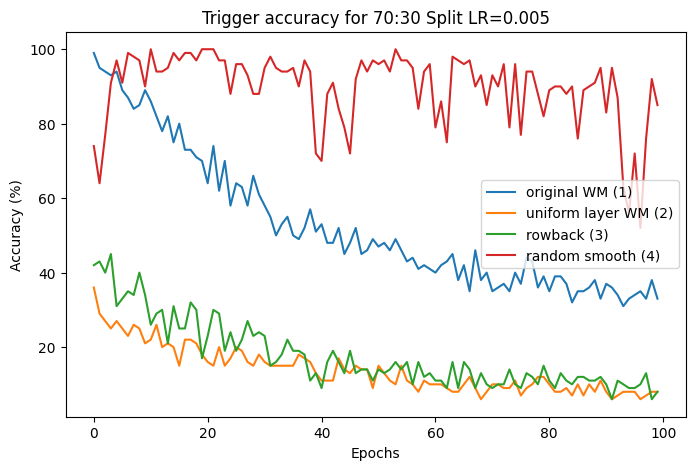

In [29]:
plt.figure(figsize=(8, 5))

plt.plot(range(len(metrics6['trigger_acc'])), metrics6['trigger_acc'], label='original WM (1)')
plt.plot(range(len(metrics7['trigger_acc'])), metrics7['trigger_acc'], label='uniform layer WM (2)')
plt.plot(range(len(metrics8['trigger_acc'])), metrics8['trigger_acc'], label='rowback (3)')

plt.plot(range(len(metrics5['trigger_acc'])), metrics5['trigger_acc'], label='random smooth (4)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Trigger accuracy for 70:30 Split LR=0.005')
plt.legend()
plt.savefig('incre_trigger_acc_7030_lr0.005.png')

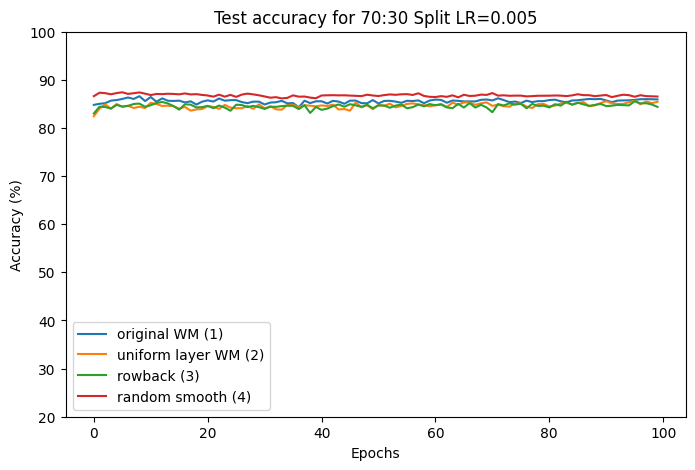

In [30]:
plt.figure(figsize=(8, 5))
plt.plot(range(len(metrics6['val_acc'])), metrics6['val_acc'], label='original WM (1)')
plt.plot(range(len(metrics7['val_acc'])), metrics7['val_acc'], label='uniform layer WM (2)')
plt.plot(range(len(metrics8['val_acc'])), metrics8['val_acc'], label='rowback (3)')

plt.plot(range(len(metrics5['val_acc'])), metrics5['val_acc'], label='random smooth (4)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test accuracy for 70:30 Split LR=0.005')
plt.ylim([20, 100])
plt.legend()
plt.savefig('incre_test_acc_7030_lr0.005.png')

lr=0.01

In [31]:
net9 = ResNet18()
net9.load_state_dict(torch.load('./models/wm_cifar10_certify_random_7030.pth')['model_state_dict'])
net10 = ResNet18()
net10.load_state_dict(torch.load('./checkpoints/resnet18_wm_7030.ckpt'))
net11 = ResNet18()
net11.load_state_dict(torch.load('./checkpoints/resnet18_wm_frozen_7030.ckpt'))
net12 = ResNet18()
net12.load_state_dict(torch.load('./checkpoints/resnet18_wm_rowback_7030.ckpt'))

<All keys matched successfully>

In [32]:
evaluator = Evaluator(net9, torch.nn.CrossEntropyLoss())
print(evaluator.eval(testloader))
print(evaluator.eval(unrelatedloader))

{'loss': 0.6196484971925617, 'accuracy': 87.48}
{'loss': 1.9488676880428102e-05, 'accuracy': 100.0}


In [33]:
evaluator = Evaluator(net10, torch.nn.CrossEntropyLoss())
print("Original watermarking scheme")
print(f"Test accuracy {evaluator.eval(testloader)}")
print(f"Watermark accuracy {evaluator.eval(wmloader)}")

Original watermarking scheme
Test accuracy {'loss': 0.4954307278931141, 'accuracy': 86.14}
Watermark accuracy {'loss': 0.00022260994766838847, 'accuracy': 100.0}


In [34]:
evaluator = Evaluator(net11, torch.nn.CrossEntropyLoss())
print("Frozen watermarking scheme")
print(f"Test accuracy {evaluator.eval(testloader)}")
print(f"Watermark accuracy {evaluator.eval(wmloader)}")

Frozen watermarking scheme
Test accuracy {'loss': 0.5337510022163391, 'accuracy': 85.11999999999999}
Watermark accuracy {'loss': 0.0010848487727344036, 'accuracy': 100.0}


In [35]:
evaluator = Evaluator(net12, torch.nn.CrossEntropyLoss())
print("ROWBack watermarking scheme")
print(f"Test accuracy {evaluator.eval(testloader)}")
print(f"Watermark accuracy {evaluator.eval(advwmloader)}")

ROWBack watermarking scheme
Test accuracy {'loss': 0.528250137591362, 'accuracy': 85.41}
Watermark accuracy {'loss': 0.0008671285235323012, 'accuracy': 100.0}


In [36]:
logcmt = f"incre_train_certified_7030"

optimizer9 = torch.optim.SGD(lr=0.01, params=net9.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer9 = Trainer(net9, criterion, optimizer9, incloader)
evaluator9 = Evaluator(net9, criterion)

metrics9 = train(trainer9, evaluator9, testloader, savename='inccheckpoints/incre_train_cert_7030_lr0.01', logdir='./runs', logcmt=logcmt, trigger_loader=unrelatedloader, epochs=100)

Start Training...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 0 | Time 7s| Train Loss 0.5266 | Train Acc 85.59| Val Loss 0.496 | Val Acc 85.57| Trigger Loss 2.226 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.46it/s]


Epoch 1 | Time 15s| Train Loss 0.3480 | Train Acc 88.34| Val Loss 0.397 | Val Acc 87.26| Trigger Loss 0.884 | Trigger Acc 64.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 2 | Time 23s| Train Loss 0.3171 | Train Acc 89.27| Val Loss 0.409 | Val Acc 87.03| Trigger Loss 1.257 | Trigger Acc 42.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 3 | Time 30s| Train Loss 0.2829 | Train Acc 90.44| Val Loss 0.410 | Val Acc 86.83| Trigger Loss 0.779 | Trigger Acc 69.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 4 | Time 37s| Train Loss 0.2622 | Train Acc 91.12| Val Loss 0.416 | Val Acc 87.03| Trigger Loss 0.428 | Trigger Acc 87.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 5 | Time 44s| Train Loss 0.2341 | Train Acc 91.92| Val Loss 0.433 | Val Acc 87.00| Trigger Loss 0.652 | Trigger Acc 74.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 6 | Time 51s| Train Loss 0.2168 | Train Acc 92.48| Val Loss 0.444 | Val Acc 86.88| Trigger Loss 0.493 | Trigger Acc 74.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 7 | Time 59s| Train Loss 0.2062 | Train Acc 92.97| Val Loss 0.479 | Val Acc 86.53| Trigger Loss 0.210 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 8 | Time 66s| Train Loss 0.1909 | Train Acc 93.32| Val Loss 0.477 | Val Acc 86.26| Trigger Loss 0.234 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 9 | Time 73s| Train Loss 0.1847 | Train Acc 93.71| Val Loss 0.468 | Val Acc 86.67| Trigger Loss 0.420 | Trigger Acc 84.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 10 | Time 80s| Train Loss 0.1632 | Train Acc 94.44| Val Loss 0.480 | Val Acc 87.12| Trigger Loss 0.100 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 11 | Time 88s| Train Loss 0.1391 | Train Acc 95.31| Val Loss 0.488 | Val Acc 86.77| Trigger Loss 0.201 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 12 | Time 95s| Train Loss 0.1310 | Train Acc 95.66| Val Loss 0.524 | Val Acc 85.74| Trigger Loss 0.211 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 13 | Time 102s| Train Loss 0.1247 | Train Acc 95.65| Val Loss 0.518 | Val Acc 86.39| Trigger Loss 0.151 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 14 | Time 109s| Train Loss 0.1117 | Train Acc 96.22| Val Loss 0.550 | Val Acc 86.57| Trigger Loss 0.060 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 15 | Time 116s| Train Loss 0.1073 | Train Acc 96.25| Val Loss 0.549 | Val Acc 86.26| Trigger Loss 0.234 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 16 | Time 123s| Train Loss 0.1054 | Train Acc 96.46| Val Loss 0.587 | Val Acc 85.45| Trigger Loss 0.188 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 17 | Time 130s| Train Loss 0.0927 | Train Acc 96.88| Val Loss 0.550 | Val Acc 86.78| Trigger Loss 0.081 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 18 | Time 138s| Train Loss 0.0826 | Train Acc 97.22| Val Loss 0.577 | Val Acc 86.03| Trigger Loss 0.085 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 19 | Time 145s| Train Loss 0.0829 | Train Acc 97.21| Val Loss 0.591 | Val Acc 86.10| Trigger Loss 0.705 | Trigger Acc 65.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 20 | Time 152s| Train Loss 0.0694 | Train Acc 97.71| Val Loss 0.580 | Val Acc 86.01| Trigger Loss 0.120 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 21 | Time 159s| Train Loss 0.0736 | Train Acc 97.35| Val Loss 0.610 | Val Acc 86.76| Trigger Loss 0.275 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 22 | Time 166s| Train Loss 0.0607 | Train Acc 97.99| Val Loss 0.628 | Val Acc 85.83| Trigger Loss 0.055 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 23 | Time 174s| Train Loss 0.0623 | Train Acc 97.90| Val Loss 0.607 | Val Acc 86.37| Trigger Loss 0.312 | Trigger Acc 88.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 24 | Time 181s| Train Loss 0.0555 | Train Acc 98.10| Val Loss 0.618 | Val Acc 86.34| Trigger Loss 0.091 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 25 | Time 188s| Train Loss 0.0477 | Train Acc 98.44| Val Loss 0.609 | Val Acc 86.16| Trigger Loss 0.101 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 26 | Time 195s| Train Loss 0.0455 | Train Acc 98.44| Val Loss 0.627 | Val Acc 86.67| Trigger Loss 0.059 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 27 | Time 202s| Train Loss 0.0461 | Train Acc 98.49| Val Loss 0.683 | Val Acc 85.93| Trigger Loss 0.141 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 28 | Time 209s| Train Loss 0.0518 | Train Acc 98.26| Val Loss 0.640 | Val Acc 86.25| Trigger Loss 0.024 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 29 | Time 217s| Train Loss 0.0416 | Train Acc 98.60| Val Loss 0.637 | Val Acc 86.51| Trigger Loss 0.023 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 30 | Time 224s| Train Loss 0.0400 | Train Acc 98.71| Val Loss 0.666 | Val Acc 86.40| Trigger Loss 0.145 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 31 | Time 231s| Train Loss 0.0399 | Train Acc 98.71| Val Loss 0.684 | Val Acc 86.51| Trigger Loss 0.518 | Trigger Acc 77.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 32 | Time 238s| Train Loss 0.0363 | Train Acc 98.84| Val Loss 0.690 | Val Acc 86.45| Trigger Loss 0.065 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 33 | Time 245s| Train Loss 0.0311 | Train Acc 99.05| Val Loss 0.659 | Val Acc 86.10| Trigger Loss 1.056 | Trigger Acc 58.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 34 | Time 252s| Train Loss 0.0309 | Train Acc 99.08| Val Loss 0.680 | Val Acc 86.62| Trigger Loss 0.656 | Trigger Acc 68.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 35 | Time 259s| Train Loss 0.0267 | Train Acc 99.23| Val Loss 0.692 | Val Acc 86.54| Trigger Loss 0.507 | Trigger Acc 78.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 36 | Time 266s| Train Loss 0.0248 | Train Acc 99.23| Val Loss 0.689 | Val Acc 86.50| Trigger Loss 0.505 | Trigger Acc 77.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 37 | Time 274s| Train Loss 0.0257 | Train Acc 99.25| Val Loss 0.691 | Val Acc 86.44| Trigger Loss 0.270 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 38 | Time 281s| Train Loss 0.0267 | Train Acc 99.09| Val Loss 0.703 | Val Acc 86.24| Trigger Loss 0.517 | Trigger Acc 72.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 39 | Time 288s| Train Loss 0.0260 | Train Acc 99.10| Val Loss 0.721 | Val Acc 86.16| Trigger Loss 0.242 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 40 | Time 295s| Train Loss 0.0339 | Train Acc 98.86| Val Loss 0.695 | Val Acc 86.63| Trigger Loss 0.554 | Trigger Acc 73.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 41 | Time 302s| Train Loss 0.0239 | Train Acc 99.23| Val Loss 0.702 | Val Acc 86.33| Trigger Loss 0.350 | Trigger Acc 88.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 42 | Time 309s| Train Loss 0.0241 | Train Acc 99.24| Val Loss 0.706 | Val Acc 86.55| Trigger Loss 0.609 | Trigger Acc 72.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 43 | Time 316s| Train Loss 0.0218 | Train Acc 99.32| Val Loss 0.694 | Val Acc 86.94| Trigger Loss 0.902 | Trigger Acc 59.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 44 | Time 323s| Train Loss 0.0182 | Train Acc 99.45| Val Loss 0.710 | Val Acc 86.85| Trigger Loss 0.419 | Trigger Acc 84.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 45 | Time 330s| Train Loss 0.0171 | Train Acc 99.52| Val Loss 0.714 | Val Acc 86.67| Trigger Loss 0.786 | Trigger Acc 62.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 46 | Time 337s| Train Loss 0.0192 | Train Acc 99.45| Val Loss 0.715 | Val Acc 86.50| Trigger Loss 0.475 | Trigger Acc 81.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 47 | Time 344s| Train Loss 0.0188 | Train Acc 99.42| Val Loss 0.726 | Val Acc 86.48| Trigger Loss 0.113 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 48 | Time 352s| Train Loss 0.0216 | Train Acc 99.31| Val Loss 0.736 | Val Acc 86.13| Trigger Loss 0.237 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 49 | Time 359s| Train Loss 0.0183 | Train Acc 99.49| Val Loss 0.730 | Val Acc 86.43| Trigger Loss 0.505 | Trigger Acc 77.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 50 | Time 366s| Train Loss 0.0169 | Train Acc 99.53| Val Loss 0.727 | Val Acc 86.54| Trigger Loss 0.770 | Trigger Acc 66.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 51 | Time 373s| Train Loss 0.0155 | Train Acc 99.49| Val Loss 0.742 | Val Acc 86.60| Trigger Loss 1.005 | Trigger Acc 55.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 52 | Time 380s| Train Loss 0.0185 | Train Acc 99.45| Val Loss 0.742 | Val Acc 86.73| Trigger Loss 3.099 | Trigger Acc 16.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 53 | Time 387s| Train Loss 0.0151 | Train Acc 99.57| Val Loss 0.788 | Val Acc 85.98| Trigger Loss 1.139 | Trigger Acc 57.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 54 | Time 394s| Train Loss 0.0170 | Train Acc 99.45| Val Loss 0.722 | Val Acc 86.60| Trigger Loss 0.710 | Trigger Acc 70.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 55 | Time 401s| Train Loss 0.0151 | Train Acc 99.52| Val Loss 0.759 | Val Acc 86.17| Trigger Loss 0.931 | Trigger Acc 58.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 56 | Time 408s| Train Loss 0.0156 | Train Acc 99.48| Val Loss 0.772 | Val Acc 86.30| Trigger Loss 0.652 | Trigger Acc 74.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 57 | Time 415s| Train Loss 0.0138 | Train Acc 99.58| Val Loss 0.751 | Val Acc 86.68| Trigger Loss 0.707 | Trigger Acc 69.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 58 | Time 422s| Train Loss 0.0163 | Train Acc 99.49| Val Loss 0.760 | Val Acc 86.39| Trigger Loss 0.632 | Trigger Acc 79.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 59 | Time 430s| Train Loss 0.0127 | Train Acc 99.67| Val Loss 0.744 | Val Acc 86.81| Trigger Loss 0.606 | Trigger Acc 75.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 60 | Time 437s| Train Loss 0.0109 | Train Acc 99.73| Val Loss 0.742 | Val Acc 86.83| Trigger Loss 0.738 | Trigger Acc 68.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 61 | Time 444s| Train Loss 0.0099 | Train Acc 99.70| Val Loss 0.785 | Val Acc 85.90| Trigger Loss 0.579 | Trigger Acc 71.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 62 | Time 451s| Train Loss 0.0112 | Train Acc 99.71| Val Loss 0.758 | Val Acc 86.62| Trigger Loss 0.289 | Trigger Acc 89.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.46it/s]


Epoch 63 | Time 458s| Train Loss 0.0108 | Train Acc 99.67| Val Loss 0.773 | Val Acc 86.68| Trigger Loss 0.609 | Trigger Acc 73.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 64 | Time 465s| Train Loss 0.0124 | Train Acc 99.65| Val Loss 0.787 | Val Acc 86.57| Trigger Loss 0.324 | Trigger Acc 87.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 65 | Time 472s| Train Loss 0.0123 | Train Acc 99.58| Val Loss 0.819 | Val Acc 86.09| Trigger Loss 0.447 | Trigger Acc 73.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 66 | Time 479s| Train Loss 0.0136 | Train Acc 99.59| Val Loss 0.790 | Val Acc 86.32| Trigger Loss 0.262 | Trigger Acc 88.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 67 | Time 486s| Train Loss 0.0124 | Train Acc 99.59| Val Loss 0.785 | Val Acc 86.46| Trigger Loss 0.883 | Trigger Acc 56.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 68 | Time 493s| Train Loss 0.0108 | Train Acc 99.75| Val Loss 0.771 | Val Acc 86.74| Trigger Loss 0.748 | Trigger Acc 67.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 69 | Time 500s| Train Loss 0.0086 | Train Acc 99.79| Val Loss 0.772 | Val Acc 86.82| Trigger Loss 0.352 | Trigger Acc 86.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 70 | Time 507s| Train Loss 0.0093 | Train Acc 99.75| Val Loss 0.793 | Val Acc 86.60| Trigger Loss 0.027 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 71 | Time 515s| Train Loss 0.0106 | Train Acc 99.68| Val Loss 0.764 | Val Acc 86.80| Trigger Loss 0.311 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 72 | Time 522s| Train Loss 0.0139 | Train Acc 99.54| Val Loss 0.792 | Val Acc 86.17| Trigger Loss 0.489 | Trigger Acc 79.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 73 | Time 529s| Train Loss 0.0142 | Train Acc 99.60| Val Loss 0.797 | Val Acc 86.58| Trigger Loss 1.643 | Trigger Acc 44.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 74 | Time 536s| Train Loss 0.0125 | Train Acc 99.67| Val Loss 0.796 | Val Acc 86.24| Trigger Loss 1.197 | Trigger Acc 54.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 75 | Time 543s| Train Loss 0.0106 | Train Acc 99.64| Val Loss 0.798 | Val Acc 86.31| Trigger Loss 0.199 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 76 | Time 550s| Train Loss 0.0096 | Train Acc 99.69| Val Loss 0.794 | Val Acc 86.28| Trigger Loss 0.080 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 77 | Time 557s| Train Loss 0.0114 | Train Acc 99.63| Val Loss 0.800 | Val Acc 86.13| Trigger Loss 0.181 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 78 | Time 564s| Train Loss 0.0090 | Train Acc 99.74| Val Loss 0.801 | Val Acc 86.07| Trigger Loss 0.291 | Trigger Acc 89.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 79 | Time 571s| Train Loss 0.0066 | Train Acc 99.83| Val Loss 0.785 | Val Acc 86.65| Trigger Loss 0.569 | Trigger Acc 73.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 80 | Time 578s| Train Loss 0.0077 | Train Acc 99.79| Val Loss 0.774 | Val Acc 86.67| Trigger Loss 1.436 | Trigger Acc 47.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 81 | Time 586s| Train Loss 0.0102 | Train Acc 99.75| Val Loss 0.780 | Val Acc 86.60| Trigger Loss 0.709 | Trigger Acc 67.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 82 | Time 593s| Train Loss 0.0076 | Train Acc 99.79| Val Loss 0.784 | Val Acc 86.71| Trigger Loss 0.758 | Trigger Acc 64.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 83 | Time 600s| Train Loss 0.0116 | Train Acc 99.65| Val Loss 0.781 | Val Acc 86.68| Trigger Loss 0.431 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 84 | Time 607s| Train Loss 0.0096 | Train Acc 99.75| Val Loss 0.794 | Val Acc 86.62| Trigger Loss 0.608 | Trigger Acc 75.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 85 | Time 614s| Train Loss 0.0102 | Train Acc 99.66| Val Loss 0.813 | Val Acc 86.33| Trigger Loss 0.376 | Trigger Acc 83.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 86 | Time 621s| Train Loss 0.0092 | Train Acc 99.73| Val Loss 0.766 | Val Acc 86.76| Trigger Loss 0.647 | Trigger Acc 66.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 87 | Time 628s| Train Loss 0.0076 | Train Acc 99.75| Val Loss 0.794 | Val Acc 86.63| Trigger Loss 0.718 | Trigger Acc 66.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 88 | Time 635s| Train Loss 0.0090 | Train Acc 99.75| Val Loss 0.902 | Val Acc 85.10| Trigger Loss 0.305 | Trigger Acc 87.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 89 | Time 642s| Train Loss 0.0096 | Train Acc 99.71| Val Loss 0.782 | Val Acc 86.63| Trigger Loss 0.421 | Trigger Acc 79.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 90 | Time 649s| Train Loss 0.0086 | Train Acc 99.77| Val Loss 0.804 | Val Acc 86.62| Trigger Loss 0.560 | Trigger Acc 74.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 91 | Time 657s| Train Loss 0.0067 | Train Acc 99.83| Val Loss 0.789 | Val Acc 86.30| Trigger Loss 1.440 | Trigger Acc 46.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 92 | Time 664s| Train Loss 0.0068 | Train Acc 99.78| Val Loss 0.808 | Val Acc 86.44| Trigger Loss 0.894 | Trigger Acc 60.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 93 | Time 671s| Train Loss 0.0055 | Train Acc 99.87| Val Loss 0.786 | Val Acc 86.71| Trigger Loss 0.900 | Trigger Acc 64.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 94 | Time 678s| Train Loss 0.0053 | Train Acc 99.87| Val Loss 0.815 | Val Acc 86.26| Trigger Loss 1.695 | Trigger Acc 42.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 95 | Time 685s| Train Loss 0.0071 | Train Acc 99.77| Val Loss 0.811 | Val Acc 86.66| Trigger Loss 0.686 | Trigger Acc 66.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 96 | Time 692s| Train Loss 0.0078 | Train Acc 99.73| Val Loss 0.831 | Val Acc 86.76| Trigger Loss 1.432 | Trigger Acc 47.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 97 | Time 699s| Train Loss 0.0109 | Train Acc 99.65| Val Loss 0.828 | Val Acc 86.48| Trigger Loss 2.253 | Trigger Acc 25.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 98 | Time 706s| Train Loss 0.0098 | Train Acc 99.72| Val Loss 0.831 | Val Acc 86.22| Trigger Loss 0.913 | Trigger Acc 54.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 99 | Time 713s| Train Loss 0.0088 | Train Acc 99.79| Val Loss 0.834 | Val Acc 86.28| Trigger Loss 0.837 | Trigger Acc 60.00


In [37]:
logcmt = f"incre_train_baseline_7030"

optimizer10 = torch.optim.SGD(lr=0.01, params=net10.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer10 = Trainer(net10, criterion, optimizer10, incloader)
evaluator10 = Evaluator(net10, criterion)

metrics10 = train(trainer10, evaluator10, testloader, savename='inccheckpoints/incre_train_baseline_7030_lr0.01', logdir='./runs', logcmt=logcmt, trigger_loader=wmloader, epochs=100)

Start Training...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 0 | Time 7s| Train Loss 0.5273 | Train Acc 83.31| Val Loss 0.553 | Val Acc 82.07| Trigger Loss 0.970 | Trigger Acc 73.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 1 | Time 15s| Train Loss 0.4046 | Train Acc 86.11| Val Loss 0.485 | Val Acc 83.99| Trigger Loss 0.623 | Trigger Acc 80.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 2 | Time 23s| Train Loss 0.3677 | Train Acc 87.41| Val Loss 0.497 | Val Acc 83.86| Trigger Loss 0.767 | Trigger Acc 68.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 3 | Time 30s| Train Loss 0.3422 | Train Acc 88.39| Val Loss 0.494 | Val Acc 84.35| Trigger Loss 0.849 | Trigger Acc 69.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 4 | Time 37s| Train Loss 0.3210 | Train Acc 89.03| Val Loss 0.497 | Val Acc 84.23| Trigger Loss 0.940 | Trigger Acc 65.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 5 | Time 44s| Train Loss 0.3036 | Train Acc 89.35| Val Loss 0.514 | Val Acc 84.08| Trigger Loss 0.947 | Trigger Acc 66.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 6 | Time 51s| Train Loss 0.2831 | Train Acc 90.21| Val Loss 0.479 | Val Acc 84.80| Trigger Loss 1.112 | Trigger Acc 66.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 7 | Time 58s| Train Loss 0.2685 | Train Acc 90.76| Val Loss 0.502 | Val Acc 84.50| Trigger Loss 1.419 | Trigger Acc 64.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 8 | Time 65s| Train Loss 0.2518 | Train Acc 91.46| Val Loss 0.454 | Val Acc 85.58| Trigger Loss 1.194 | Trigger Acc 60.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 9 | Time 72s| Train Loss 0.2385 | Train Acc 91.76| Val Loss 0.526 | Val Acc 84.19| Trigger Loss 1.194 | Trigger Acc 58.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 10 | Time 80s| Train Loss 0.2284 | Train Acc 91.94| Val Loss 0.561 | Val Acc 83.69| Trigger Loss 1.316 | Trigger Acc 56.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 11 | Time 87s| Train Loss 0.2251 | Train Acc 91.99| Val Loss 0.522 | Val Acc 85.19| Trigger Loss 1.618 | Trigger Acc 48.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 12 | Time 94s| Train Loss 0.1973 | Train Acc 93.02| Val Loss 0.508 | Val Acc 85.26| Trigger Loss 1.886 | Trigger Acc 50.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 13 | Time 101s| Train Loss 0.1910 | Train Acc 93.51| Val Loss 0.519 | Val Acc 85.17| Trigger Loss 2.041 | Trigger Acc 44.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 14 | Time 108s| Train Loss 0.1785 | Train Acc 93.86| Val Loss 0.512 | Val Acc 85.43| Trigger Loss 1.937 | Trigger Acc 51.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 15 | Time 115s| Train Loss 0.1689 | Train Acc 94.02| Val Loss 0.572 | Val Acc 84.19| Trigger Loss 2.025 | Trigger Acc 49.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 16 | Time 122s| Train Loss 0.1596 | Train Acc 94.40| Val Loss 0.585 | Val Acc 84.25| Trigger Loss 2.205 | Trigger Acc 51.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 17 | Time 129s| Train Loss 0.1597 | Train Acc 94.43| Val Loss 0.558 | Val Acc 84.83| Trigger Loss 2.470 | Trigger Acc 43.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.31it/s]


Epoch 18 | Time 136s| Train Loss 0.1368 | Train Acc 95.18| Val Loss 0.583 | Val Acc 84.40| Trigger Loss 2.704 | Trigger Acc 42.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 19 | Time 144s| Train Loss 0.1430 | Train Acc 95.06| Val Loss 0.612 | Val Acc 84.39| Trigger Loss 3.081 | Trigger Acc 47.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 20 | Time 151s| Train Loss 0.1223 | Train Acc 95.80| Val Loss 0.587 | Val Acc 85.00| Trigger Loss 2.925 | Trigger Acc 43.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 21 | Time 158s| Train Loss 0.1113 | Train Acc 96.23| Val Loss 0.623 | Val Acc 84.69| Trigger Loss 2.790 | Trigger Acc 43.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 22 | Time 165s| Train Loss 0.1192 | Train Acc 95.64| Val Loss 0.607 | Val Acc 85.20| Trigger Loss 3.245 | Trigger Acc 40.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 23 | Time 172s| Train Loss 0.1106 | Train Acc 96.05| Val Loss 0.605 | Val Acc 85.71| Trigger Loss 2.969 | Trigger Acc 41.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.31it/s]


Epoch 24 | Time 179s| Train Loss 0.1062 | Train Acc 96.19| Val Loss 0.753 | Val Acc 82.76| Trigger Loss 3.276 | Trigger Acc 40.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 25 | Time 186s| Train Loss 0.1025 | Train Acc 96.45| Val Loss 0.656 | Val Acc 84.88| Trigger Loss 3.776 | Trigger Acc 30.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 26 | Time 193s| Train Loss 0.0871 | Train Acc 96.87| Val Loss 0.642 | Val Acc 84.54| Trigger Loss 3.267 | Trigger Acc 38.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 27 | Time 200s| Train Loss 0.0874 | Train Acc 96.99| Val Loss 0.670 | Val Acc 84.55| Trigger Loss 3.597 | Trigger Acc 35.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 28 | Time 208s| Train Loss 0.0836 | Train Acc 97.14| Val Loss 0.713 | Val Acc 84.09| Trigger Loss 3.983 | Trigger Acc 34.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 29 | Time 215s| Train Loss 0.0823 | Train Acc 97.05| Val Loss 0.769 | Val Acc 84.23| Trigger Loss 3.395 | Trigger Acc 31.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 30 | Time 222s| Train Loss 0.0844 | Train Acc 97.01| Val Loss 0.660 | Val Acc 85.10| Trigger Loss 4.385 | Trigger Acc 29.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 31 | Time 229s| Train Loss 0.0739 | Train Acc 97.45| Val Loss 0.644 | Val Acc 85.42| Trigger Loss 3.960 | Trigger Acc 30.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 32 | Time 236s| Train Loss 0.0619 | Train Acc 97.88| Val Loss 0.722 | Val Acc 84.41| Trigger Loss 4.457 | Trigger Acc 34.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 33 | Time 243s| Train Loss 0.0713 | Train Acc 97.51| Val Loss 0.686 | Val Acc 85.42| Trigger Loss 4.252 | Trigger Acc 33.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 34 | Time 250s| Train Loss 0.0632 | Train Acc 97.73| Val Loss 0.696 | Val Acc 85.46| Trigger Loss 4.490 | Trigger Acc 33.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 35 | Time 257s| Train Loss 0.0559 | Train Acc 97.98| Val Loss 0.696 | Val Acc 84.62| Trigger Loss 4.392 | Trigger Acc 37.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 36 | Time 264s| Train Loss 0.0554 | Train Acc 98.11| Val Loss 0.727 | Val Acc 84.95| Trigger Loss 4.615 | Trigger Acc 28.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 37 | Time 271s| Train Loss 0.0527 | Train Acc 98.15| Val Loss 0.733 | Val Acc 84.85| Trigger Loss 4.544 | Trigger Acc 35.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 38 | Time 279s| Train Loss 0.0543 | Train Acc 98.12| Val Loss 0.793 | Val Acc 84.24| Trigger Loss 5.461 | Trigger Acc 26.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 39 | Time 286s| Train Loss 0.0570 | Train Acc 98.04| Val Loss 0.756 | Val Acc 84.71| Trigger Loss 5.242 | Trigger Acc 31.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 40 | Time 293s| Train Loss 0.0452 | Train Acc 98.49| Val Loss 0.699 | Val Acc 85.26| Trigger Loss 5.039 | Trigger Acc 29.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 41 | Time 300s| Train Loss 0.0431 | Train Acc 98.57| Val Loss 0.766 | Val Acc 84.50| Trigger Loss 5.170 | Trigger Acc 27.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 42 | Time 307s| Train Loss 0.0443 | Train Acc 98.45| Val Loss 0.899 | Val Acc 83.58| Trigger Loss 6.083 | Trigger Acc 22.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 43 | Time 314s| Train Loss 0.0443 | Train Acc 98.39| Val Loss 0.766 | Val Acc 85.03| Trigger Loss 5.170 | Trigger Acc 27.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.32it/s]


Epoch 44 | Time 321s| Train Loss 0.0424 | Train Acc 98.51| Val Loss 0.760 | Val Acc 84.93| Trigger Loss 5.759 | Trigger Acc 29.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 45 | Time 328s| Train Loss 0.0412 | Train Acc 98.58| Val Loss 0.794 | Val Acc 84.86| Trigger Loss 4.900 | Trigger Acc 32.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 46 | Time 336s| Train Loss 0.0391 | Train Acc 98.68| Val Loss 0.792 | Val Acc 85.22| Trigger Loss 5.597 | Trigger Acc 23.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 47 | Time 343s| Train Loss 0.0357 | Train Acc 98.75| Val Loss 0.747 | Val Acc 85.29| Trigger Loss 5.191 | Trigger Acc 30.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 48 | Time 350s| Train Loss 0.0389 | Train Acc 98.70| Val Loss 0.727 | Val Acc 85.69| Trigger Loss 5.630 | Trigger Acc 27.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 49 | Time 357s| Train Loss 0.0367 | Train Acc 98.68| Val Loss 0.829 | Val Acc 84.55| Trigger Loss 6.087 | Trigger Acc 25.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 50 | Time 364s| Train Loss 0.0341 | Train Acc 98.84| Val Loss 0.799 | Val Acc 84.68| Trigger Loss 5.866 | Trigger Acc 30.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 51 | Time 371s| Train Loss 0.0413 | Train Acc 98.60| Val Loss 0.797 | Val Acc 85.22| Trigger Loss 5.645 | Trigger Acc 33.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 52 | Time 378s| Train Loss 0.0443 | Train Acc 98.42| Val Loss 0.803 | Val Acc 84.63| Trigger Loss 5.883 | Trigger Acc 25.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 53 | Time 385s| Train Loss 0.0378 | Train Acc 98.69| Val Loss 0.801 | Val Acc 85.43| Trigger Loss 5.980 | Trigger Acc 25.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 54 | Time 392s| Train Loss 0.0321 | Train Acc 98.80| Val Loss 0.764 | Val Acc 85.55| Trigger Loss 5.869 | Trigger Acc 27.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 55 | Time 399s| Train Loss 0.0249 | Train Acc 99.16| Val Loss 0.746 | Val Acc 85.65| Trigger Loss 5.697 | Trigger Acc 26.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 56 | Time 406s| Train Loss 0.0250 | Train Acc 99.16| Val Loss 0.851 | Val Acc 84.16| Trigger Loss 6.309 | Trigger Acc 23.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 57 | Time 414s| Train Loss 0.0270 | Train Acc 99.08| Val Loss 0.833 | Val Acc 84.83| Trigger Loss 6.341 | Trigger Acc 29.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 58 | Time 421s| Train Loss 0.0272 | Train Acc 99.10| Val Loss 0.817 | Val Acc 84.85| Trigger Loss 7.057 | Trigger Acc 23.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 59 | Time 428s| Train Loss 0.0234 | Train Acc 99.28| Val Loss 0.776 | Val Acc 85.38| Trigger Loss 6.375 | Trigger Acc 23.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 60 | Time 435s| Train Loss 0.0273 | Train Acc 99.08| Val Loss 0.809 | Val Acc 85.46| Trigger Loss 6.904 | Trigger Acc 24.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 61 | Time 442s| Train Loss 0.0252 | Train Acc 99.18| Val Loss 0.769 | Val Acc 85.68| Trigger Loss 6.430 | Trigger Acc 26.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 62 | Time 449s| Train Loss 0.0221 | Train Acc 99.35| Val Loss 0.771 | Val Acc 86.19| Trigger Loss 6.350 | Trigger Acc 22.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 63 | Time 456s| Train Loss 0.0215 | Train Acc 99.33| Val Loss 0.804 | Val Acc 85.64| Trigger Loss 6.299 | Trigger Acc 25.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 64 | Time 463s| Train Loss 0.0206 | Train Acc 99.35| Val Loss 0.794 | Val Acc 86.10| Trigger Loss 7.115 | Trigger Acc 22.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 65 | Time 471s| Train Loss 0.0229 | Train Acc 99.16| Val Loss 0.789 | Val Acc 85.59| Trigger Loss 7.452 | Trigger Acc 20.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 66 | Time 478s| Train Loss 0.0172 | Train Acc 99.48| Val Loss 0.794 | Val Acc 85.51| Trigger Loss 6.749 | Trigger Acc 25.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 67 | Time 485s| Train Loss 0.0185 | Train Acc 99.37| Val Loss 0.775 | Val Acc 86.00| Trigger Loss 6.974 | Trigger Acc 25.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 68 | Time 492s| Train Loss 0.0207 | Train Acc 99.31| Val Loss 0.794 | Val Acc 85.69| Trigger Loss 6.965 | Trigger Acc 26.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 69 | Time 499s| Train Loss 0.0246 | Train Acc 99.18| Val Loss 0.839 | Val Acc 85.90| Trigger Loss 7.749 | Trigger Acc 25.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 70 | Time 506s| Train Loss 0.0233 | Train Acc 99.14| Val Loss 0.831 | Val Acc 85.20| Trigger Loss 7.236 | Trigger Acc 26.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 71 | Time 513s| Train Loss 0.0247 | Train Acc 99.14| Val Loss 0.848 | Val Acc 85.18| Trigger Loss 7.703 | Trigger Acc 19.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 72 | Time 520s| Train Loss 0.0301 | Train Acc 98.91| Val Loss 0.873 | Val Acc 84.70| Trigger Loss 8.018 | Trigger Acc 19.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 73 | Time 527s| Train Loss 0.0235 | Train Acc 99.19| Val Loss 0.831 | Val Acc 85.29| Trigger Loss 7.468 | Trigger Acc 23.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 74 | Time 534s| Train Loss 0.0204 | Train Acc 99.37| Val Loss 0.801 | Val Acc 85.72| Trigger Loss 8.404 | Trigger Acc 19.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 75 | Time 542s| Train Loss 0.0146 | Train Acc 99.59| Val Loss 0.946 | Val Acc 84.43| Trigger Loss 8.001 | Trigger Acc 25.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 76 | Time 549s| Train Loss 0.0187 | Train Acc 99.43| Val Loss 0.809 | Val Acc 85.61| Trigger Loss 8.094 | Trigger Acc 19.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 77 | Time 556s| Train Loss 0.0175 | Train Acc 99.43| Val Loss 0.856 | Val Acc 85.38| Trigger Loss 8.095 | Trigger Acc 22.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 78 | Time 563s| Train Loss 0.0220 | Train Acc 99.25| Val Loss 0.872 | Val Acc 85.03| Trigger Loss 7.832 | Trigger Acc 22.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 79 | Time 570s| Train Loss 0.0256 | Train Acc 99.05| Val Loss 0.889 | Val Acc 84.93| Trigger Loss 7.849 | Trigger Acc 26.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 80 | Time 577s| Train Loss 0.0190 | Train Acc 99.37| Val Loss 0.857 | Val Acc 85.49| Trigger Loss 8.132 | Trigger Acc 18.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 81 | Time 584s| Train Loss 0.0189 | Train Acc 99.39| Val Loss 0.826 | Val Acc 85.08| Trigger Loss 7.932 | Trigger Acc 20.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 82 | Time 591s| Train Loss 0.0185 | Train Acc 99.35| Val Loss 0.835 | Val Acc 85.23| Trigger Loss 8.426 | Trigger Acc 22.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 83 | Time 598s| Train Loss 0.0143 | Train Acc 99.54| Val Loss 0.803 | Val Acc 85.99| Trigger Loss 7.953 | Trigger Acc 20.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 84 | Time 605s| Train Loss 0.0124 | Train Acc 99.59| Val Loss 0.873 | Val Acc 85.30| Trigger Loss 8.254 | Trigger Acc 15.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 85 | Time 613s| Train Loss 0.0170 | Train Acc 99.44| Val Loss 0.833 | Val Acc 85.85| Trigger Loss 8.332 | Trigger Acc 19.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 86 | Time 620s| Train Loss 0.0162 | Train Acc 99.47| Val Loss 0.844 | Val Acc 85.39| Trigger Loss 8.356 | Trigger Acc 23.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 87 | Time 627s| Train Loss 0.0126 | Train Acc 99.61| Val Loss 0.833 | Val Acc 86.10| Trigger Loss 8.658 | Trigger Acc 21.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 88 | Time 634s| Train Loss 0.0098 | Train Acc 99.71| Val Loss 0.840 | Val Acc 85.80| Trigger Loss 8.510 | Trigger Acc 23.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 89 | Time 641s| Train Loss 0.0103 | Train Acc 99.70| Val Loss 0.818 | Val Acc 85.88| Trigger Loss 8.413 | Trigger Acc 24.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 90 | Time 648s| Train Loss 0.0087 | Train Acc 99.75| Val Loss 0.815 | Val Acc 86.25| Trigger Loss 8.056 | Trigger Acc 21.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 91 | Time 655s| Train Loss 0.0129 | Train Acc 99.57| Val Loss 0.841 | Val Acc 85.80| Trigger Loss 7.745 | Trigger Acc 24.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 92 | Time 662s| Train Loss 0.0123 | Train Acc 99.60| Val Loss 0.933 | Val Acc 85.31| Trigger Loss 8.132 | Trigger Acc 21.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 93 | Time 669s| Train Loss 0.0113 | Train Acc 99.67| Val Loss 0.867 | Val Acc 85.34| Trigger Loss 8.011 | Trigger Acc 24.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 94 | Time 676s| Train Loss 0.0123 | Train Acc 99.64| Val Loss 0.830 | Val Acc 86.03| Trigger Loss 8.285 | Trigger Acc 20.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 95 | Time 684s| Train Loss 0.0155 | Train Acc 99.47| Val Loss 0.880 | Val Acc 85.48| Trigger Loss 8.301 | Trigger Acc 19.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 96 | Time 691s| Train Loss 0.0128 | Train Acc 99.58| Val Loss 0.827 | Val Acc 86.13| Trigger Loss 9.005 | Trigger Acc 20.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 97 | Time 698s| Train Loss 0.0102 | Train Acc 99.73| Val Loss 0.834 | Val Acc 85.99| Trigger Loss 8.980 | Trigger Acc 23.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 98 | Time 705s| Train Loss 0.0094 | Train Acc 99.71| Val Loss 0.865 | Val Acc 85.51| Trigger Loss 8.405 | Trigger Acc 23.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 99 | Time 712s| Train Loss 0.0102 | Train Acc 99.69| Val Loss 0.855 | Val Acc 85.83| Trigger Loss 8.529 | Trigger Acc 19.00


In [38]:
logcmt = f"incre_train_baseline_frozen_7030"

optimizer11 = torch.optim.SGD(lr=0.01, params=net11.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer11 = Trainer(net11, criterion, optimizer11, incloader)
evaluator11 = Evaluator(net11, criterion)
metrics10
metrics11 = train(trainer11, evaluator11, testloader, savename='inccheckpoints/incre_train_baseline_frozen_7030_lr0.01', logdir='./runs', logcmt=logcmt, trigger_loader=wmloader, epochs=100)

Start Training...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 0 | Time 7s| Train Loss 0.5915 | Train Acc 81.45| Val Loss 0.583 | Val Acc 81.27| Trigger Loss 5.231 | Trigger Acc 14.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 1 | Time 15s| Train Loss 0.4465 | Train Acc 84.68| Val Loss 0.546 | Val Acc 82.22| Trigger Loss 5.051 | Trigger Acc 16.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 2 | Time 23s| Train Loss 0.4120 | Train Acc 85.89| Val Loss 0.497 | Val Acc 83.47| Trigger Loss 4.859 | Trigger Acc 17.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 3 | Time 30s| Train Loss 0.3788 | Train Acc 86.78| Val Loss 0.491 | Val Acc 84.06| Trigger Loss 5.600 | Trigger Acc 18.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.46it/s]


Epoch 4 | Time 37s| Train Loss 0.3620 | Train Acc 87.78| Val Loss 0.491 | Val Acc 84.06| Trigger Loss 5.525 | Trigger Acc 14.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 5 | Time 44s| Train Loss 0.3390 | Train Acc 88.12| Val Loss 0.484 | Val Acc 84.62| Trigger Loss 5.629 | Trigger Acc 10.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 6 | Time 52s| Train Loss 0.3284 | Train Acc 88.44| Val Loss 0.570 | Val Acc 81.88| Trigger Loss 5.773 | Trigger Acc 16.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 7 | Time 59s| Train Loss 0.2988 | Train Acc 89.77| Val Loss 0.543 | Val Acc 83.26| Trigger Loss 5.992 | Trigger Acc 13.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 8 | Time 66s| Train Loss 0.2919 | Train Acc 89.90| Val Loss 0.598 | Val Acc 82.05| Trigger Loss 6.989 | Trigger Acc 13.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 9 | Time 73s| Train Loss 0.2781 | Train Acc 90.36| Val Loss 0.541 | Val Acc 83.68| Trigger Loss 6.777 | Trigger Acc 10.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 10 | Time 80s| Train Loss 0.2615 | Train Acc 90.90| Val Loss 0.554 | Val Acc 83.58| Trigger Loss 6.615 | Trigger Acc 13.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 11 | Time 87s| Train Loss 0.2457 | Train Acc 91.61| Val Loss 0.562 | Val Acc 83.44| Trigger Loss 7.141 | Trigger Acc 12.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 12 | Time 94s| Train Loss 0.2421 | Train Acc 91.69| Val Loss 0.533 | Val Acc 84.83| Trigger Loss 7.486 | Trigger Acc 15.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 13 | Time 101s| Train Loss 0.2207 | Train Acc 92.22| Val Loss 0.638 | Val Acc 82.26| Trigger Loss 7.251 | Trigger Acc 10.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 14 | Time 108s| Train Loss 0.2036 | Train Acc 92.99| Val Loss 0.567 | Val Acc 83.90| Trigger Loss 7.179 | Trigger Acc 14.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 15 | Time 116s| Train Loss 0.1978 | Train Acc 93.13| Val Loss 0.624 | Val Acc 82.88| Trigger Loss 7.660 | Trigger Acc 15.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 16 | Time 123s| Train Loss 0.1866 | Train Acc 93.73| Val Loss 0.613 | Val Acc 83.34| Trigger Loss 7.804 | Trigger Acc 13.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 17 | Time 130s| Train Loss 0.1763 | Train Acc 93.72| Val Loss 0.621 | Val Acc 83.33| Trigger Loss 7.983 | Trigger Acc 12.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 18 | Time 137s| Train Loss 0.1676 | Train Acc 94.05| Val Loss 0.642 | Val Acc 83.06| Trigger Loss 8.423 | Trigger Acc 13.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 19 | Time 144s| Train Loss 0.1610 | Train Acc 94.51| Val Loss 0.647 | Val Acc 83.06| Trigger Loss 8.563 | Trigger Acc 15.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 20 | Time 151s| Train Loss 0.1489 | Train Acc 94.80| Val Loss 0.692 | Val Acc 82.74| Trigger Loss 8.871 | Trigger Acc 10.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 21 | Time 158s| Train Loss 0.1445 | Train Acc 94.82| Val Loss 0.688 | Val Acc 83.49| Trigger Loss 9.485 | Trigger Acc 9.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 22 | Time 165s| Train Loss 0.1333 | Train Acc 95.19| Val Loss 0.745 | Val Acc 82.46| Trigger Loss 9.179 | Trigger Acc 13.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 23 | Time 172s| Train Loss 0.1295 | Train Acc 95.39| Val Loss 0.722 | Val Acc 82.93| Trigger Loss 9.484 | Trigger Acc 9.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 24 | Time 179s| Train Loss 0.1320 | Train Acc 95.24| Val Loss 0.649 | Val Acc 84.07| Trigger Loss 10.186 | Trigger Acc 8.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 25 | Time 187s| Train Loss 0.1158 | Train Acc 96.02| Val Loss 0.682 | Val Acc 83.26| Trigger Loss 9.754 | Trigger Acc 12.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 26 | Time 194s| Train Loss 0.1126 | Train Acc 95.97| Val Loss 0.770 | Val Acc 82.06| Trigger Loss 10.189 | Trigger Acc 9.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 27 | Time 201s| Train Loss 0.1171 | Train Acc 95.73| Val Loss 0.707 | Val Acc 83.50| Trigger Loss 10.573 | Trigger Acc 10.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 28 | Time 208s| Train Loss 0.1002 | Train Acc 96.49| Val Loss 0.768 | Val Acc 82.55| Trigger Loss 10.002 | Trigger Acc 11.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 29 | Time 215s| Train Loss 0.1029 | Train Acc 96.41| Val Loss 0.765 | Val Acc 82.72| Trigger Loss 11.350 | Trigger Acc 10.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 30 | Time 222s| Train Loss 0.0916 | Train Acc 96.72| Val Loss 0.744 | Val Acc 83.12| Trigger Loss 10.984 | Trigger Acc 9.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 31 | Time 229s| Train Loss 0.0850 | Train Acc 97.05| Val Loss 0.821 | Val Acc 82.74| Trigger Loss 11.875 | Trigger Acc 8.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 32 | Time 236s| Train Loss 0.0797 | Train Acc 97.21| Val Loss 0.689 | Val Acc 84.16| Trigger Loss 11.313 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 33 | Time 244s| Train Loss 0.0799 | Train Acc 97.39| Val Loss 0.735 | Val Acc 84.17| Trigger Loss 11.612 | Trigger Acc 10.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 34 | Time 251s| Train Loss 0.0771 | Train Acc 97.25| Val Loss 0.750 | Val Acc 83.50| Trigger Loss 11.737 | Trigger Acc 10.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 35 | Time 258s| Train Loss 0.0693 | Train Acc 97.62| Val Loss 0.769 | Val Acc 83.72| Trigger Loss 11.548 | Trigger Acc 10.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 36 | Time 265s| Train Loss 0.0667 | Train Acc 97.63| Val Loss 0.797 | Val Acc 83.68| Trigger Loss 12.233 | Trigger Acc 9.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 37 | Time 272s| Train Loss 0.0710 | Train Acc 97.58| Val Loss 0.831 | Val Acc 83.14| Trigger Loss 12.399 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 38 | Time 279s| Train Loss 0.0639 | Train Acc 97.84| Val Loss 0.848 | Val Acc 82.38| Trigger Loss 12.002 | Trigger Acc 11.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 39 | Time 286s| Train Loss 0.0550 | Train Acc 98.06| Val Loss 0.743 | Val Acc 83.97| Trigger Loss 11.774 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 40 | Time 293s| Train Loss 0.0560 | Train Acc 98.18| Val Loss 0.839 | Val Acc 83.30| Trigger Loss 12.408 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 41 | Time 300s| Train Loss 0.0611 | Train Acc 97.83| Val Loss 0.821 | Val Acc 83.61| Trigger Loss 12.589 | Trigger Acc 11.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 42 | Time 308s| Train Loss 0.0579 | Train Acc 97.86| Val Loss 0.786 | Val Acc 83.98| Trigger Loss 12.715 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 43 | Time 315s| Train Loss 0.0490 | Train Acc 98.31| Val Loss 0.811 | Val Acc 84.16| Trigger Loss 12.648 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 44 | Time 322s| Train Loss 0.0496 | Train Acc 98.26| Val Loss 0.793 | Val Acc 83.90| Trigger Loss 12.726 | Trigger Acc 8.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 45 | Time 329s| Train Loss 0.0520 | Train Acc 98.18| Val Loss 0.810 | Val Acc 83.98| Trigger Loss 12.661 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 46 | Time 336s| Train Loss 0.0519 | Train Acc 98.18| Val Loss 0.849 | Val Acc 83.72| Trigger Loss 12.997 | Trigger Acc 9.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 47 | Time 343s| Train Loss 0.0464 | Train Acc 98.42| Val Loss 0.913 | Val Acc 83.31| Trigger Loss 13.717 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 48 | Time 350s| Train Loss 0.0424 | Train Acc 98.51| Val Loss 0.783 | Val Acc 84.25| Trigger Loss 12.687 | Trigger Acc 9.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 49 | Time 357s| Train Loss 0.0456 | Train Acc 98.48| Val Loss 0.795 | Val Acc 84.78| Trigger Loss 13.080 | Trigger Acc 8.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 50 | Time 364s| Train Loss 0.0374 | Train Acc 98.73| Val Loss 0.799 | Val Acc 84.32| Trigger Loss 13.599 | Trigger Acc 8.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.30it/s]


Epoch 51 | Time 372s| Train Loss 0.0306 | Train Acc 99.06| Val Loss 0.801 | Val Acc 84.78| Trigger Loss 13.527 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 52 | Time 379s| Train Loss 0.0313 | Train Acc 98.95| Val Loss 0.880 | Val Acc 83.73| Trigger Loss 13.261 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 53 | Time 386s| Train Loss 0.0392 | Train Acc 98.64| Val Loss 0.881 | Val Acc 83.81| Trigger Loss 13.007 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 54 | Time 393s| Train Loss 0.0396 | Train Acc 98.71| Val Loss 0.834 | Val Acc 84.50| Trigger Loss 13.543 | Trigger Acc 9.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 55 | Time 400s| Train Loss 0.0345 | Train Acc 98.83| Val Loss 0.917 | Val Acc 82.53| Trigger Loss 13.423 | Trigger Acc 8.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 56 | Time 407s| Train Loss 0.0373 | Train Acc 98.68| Val Loss 0.875 | Val Acc 83.67| Trigger Loss 13.418 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 57 | Time 414s| Train Loss 0.0386 | Train Acc 98.60| Val Loss 0.825 | Val Acc 84.64| Trigger Loss 13.386 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 58 | Time 421s| Train Loss 0.0360 | Train Acc 98.70| Val Loss 0.845 | Val Acc 84.21| Trigger Loss 13.800 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 59 | Time 428s| Train Loss 0.0373 | Train Acc 98.76| Val Loss 0.874 | Val Acc 83.55| Trigger Loss 14.351 | Trigger Acc 9.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 60 | Time 436s| Train Loss 0.0299 | Train Acc 98.99| Val Loss 0.847 | Val Acc 84.09| Trigger Loss 14.336 | Trigger Acc 10.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 61 | Time 443s| Train Loss 0.0329 | Train Acc 98.87| Val Loss 0.843 | Val Acc 83.62| Trigger Loss 14.406 | Trigger Acc 9.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 62 | Time 450s| Train Loss 0.0273 | Train Acc 99.11| Val Loss 0.883 | Val Acc 83.82| Trigger Loss 14.531 | Trigger Acc 8.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 63 | Time 457s| Train Loss 0.0333 | Train Acc 98.85| Val Loss 0.850 | Val Acc 84.34| Trigger Loss 14.539 | Trigger Acc 10.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 64 | Time 464s| Train Loss 0.0339 | Train Acc 98.78| Val Loss 0.826 | Val Acc 84.43| Trigger Loss 14.672 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 65 | Time 471s| Train Loss 0.0328 | Train Acc 98.90| Val Loss 0.867 | Val Acc 84.23| Trigger Loss 14.362 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 66 | Time 478s| Train Loss 0.0330 | Train Acc 98.84| Val Loss 0.883 | Val Acc 83.56| Trigger Loss 14.677 | Trigger Acc 8.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 67 | Time 485s| Train Loss 0.0292 | Train Acc 99.03| Val Loss 0.888 | Val Acc 83.79| Trigger Loss 14.340 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 68 | Time 492s| Train Loss 0.0265 | Train Acc 99.12| Val Loss 0.847 | Val Acc 84.53| Trigger Loss 14.249 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 69 | Time 500s| Train Loss 0.0279 | Train Acc 99.04| Val Loss 0.848 | Val Acc 84.58| Trigger Loss 14.668 | Trigger Acc 8.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 70 | Time 507s| Train Loss 0.0269 | Train Acc 99.04| Val Loss 0.846 | Val Acc 84.67| Trigger Loss 15.087 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 71 | Time 514s| Train Loss 0.0195 | Train Acc 99.32| Val Loss 0.975 | Val Acc 83.51| Trigger Loss 14.334 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 72 | Time 521s| Train Loss 0.0183 | Train Acc 99.43| Val Loss 0.874 | Val Acc 84.58| Trigger Loss 14.582 | Trigger Acc 8.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 73 | Time 528s| Train Loss 0.0168 | Train Acc 99.43| Val Loss 0.855 | Val Acc 84.87| Trigger Loss 14.990 | Trigger Acc 8.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 74 | Time 535s| Train Loss 0.0187 | Train Acc 99.37| Val Loss 0.950 | Val Acc 84.31| Trigger Loss 15.179 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 75 | Time 542s| Train Loss 0.0215 | Train Acc 99.26| Val Loss 1.064 | Val Acc 83.37| Trigger Loss 16.196 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 76 | Time 549s| Train Loss 0.0252 | Train Acc 99.17| Val Loss 0.998 | Val Acc 83.52| Trigger Loss 15.325 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 77 | Time 556s| Train Loss 0.0209 | Train Acc 99.27| Val Loss 0.868 | Val Acc 84.67| Trigger Loss 14.886 | Trigger Acc 8.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 78 | Time 563s| Train Loss 0.0133 | Train Acc 99.56| Val Loss 0.860 | Val Acc 84.98| Trigger Loss 15.181 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 79 | Time 571s| Train Loss 0.0151 | Train Acc 99.55| Val Loss 0.910 | Val Acc 84.57| Trigger Loss 15.448 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 80 | Time 578s| Train Loss 0.0189 | Train Acc 99.36| Val Loss 0.886 | Val Acc 84.64| Trigger Loss 15.045 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 81 | Time 585s| Train Loss 0.0228 | Train Acc 99.21| Val Loss 0.917 | Val Acc 84.52| Trigger Loss 15.398 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 82 | Time 592s| Train Loss 0.0245 | Train Acc 99.22| Val Loss 0.875 | Val Acc 84.79| Trigger Loss 15.488 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 83 | Time 599s| Train Loss 0.0203 | Train Acc 99.33| Val Loss 0.873 | Val Acc 84.33| Trigger Loss 15.212 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 84 | Time 606s| Train Loss 0.0133 | Train Acc 99.59| Val Loss 0.837 | Val Acc 85.20| Trigger Loss 15.687 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 85 | Time 613s| Train Loss 0.0112 | Train Acc 99.67| Val Loss 0.877 | Val Acc 84.98| Trigger Loss 15.806 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 86 | Time 620s| Train Loss 0.0112 | Train Acc 99.61| Val Loss 0.849 | Val Acc 85.29| Trigger Loss 16.086 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 87 | Time 627s| Train Loss 0.0090 | Train Acc 99.73| Val Loss 0.892 | Val Acc 84.74| Trigger Loss 16.060 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 88 | Time 635s| Train Loss 0.0081 | Train Acc 99.78| Val Loss 0.858 | Val Acc 85.51| Trigger Loss 15.521 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.31it/s]


Epoch 89 | Time 642s| Train Loss 0.0107 | Train Acc 99.68| Val Loss 0.836 | Val Acc 85.39| Trigger Loss 15.687 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 90 | Time 649s| Train Loss 0.0088 | Train Acc 99.79| Val Loss 0.845 | Val Acc 85.75| Trigger Loss 16.055 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 91 | Time 656s| Train Loss 0.0093 | Train Acc 99.72| Val Loss 0.852 | Val Acc 85.32| Trigger Loss 15.837 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 92 | Time 663s| Train Loss 0.0071 | Train Acc 99.83| Val Loss 0.876 | Val Acc 84.95| Trigger Loss 15.933 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 93 | Time 670s| Train Loss 0.0072 | Train Acc 99.78| Val Loss 0.846 | Val Acc 85.48| Trigger Loss 16.044 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 94 | Time 677s| Train Loss 0.0070 | Train Acc 99.80| Val Loss 0.867 | Val Acc 85.28| Trigger Loss 16.171 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 95 | Time 684s| Train Loss 0.0091 | Train Acc 99.71| Val Loss 0.893 | Val Acc 84.77| Trigger Loss 15.997 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 96 | Time 691s| Train Loss 0.0092 | Train Acc 99.73| Val Loss 0.886 | Val Acc 85.25| Trigger Loss 15.961 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 97 | Time 699s| Train Loss 0.0073 | Train Acc 99.78| Val Loss 0.868 | Val Acc 85.47| Trigger Loss 15.660 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 98 | Time 706s| Train Loss 0.0084 | Train Acc 99.74| Val Loss 0.884 | Val Acc 84.90| Trigger Loss 15.808 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 99 | Time 713s| Train Loss 0.0098 | Train Acc 99.70| Val Loss 0.916 | Val Acc 84.96| Trigger Loss 15.744 | Trigger Acc 4.00


In [39]:
logcmt = f"incre_train_baseline_rowback_7030"

optimizer12 = torch.optim.SGD(lr=0.01, params=net12.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer12 = Trainer(net12, criterion, optimizer12, incloader)
evaluator12 = Evaluator(net12, criterion)

metrics12 = train(trainer12, evaluator12, testloader, savename='inccheckpoints/incre_train_baseline_rowback_7030_lr0.01', logdir='./runs', logcmt=logcmt, trigger_loader=advwmloader, epochs=100)

Start Training...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 0 | Time 7s| Train Loss 0.5743 | Train Acc 81.76| Val Loss 0.593 | Val Acc 81.07| Trigger Loss 4.207 | Trigger Acc 27.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 1 | Time 15s| Train Loss 0.4516 | Train Acc 84.30| Val Loss 0.568 | Val Acc 81.08| Trigger Loss 4.355 | Trigger Acc 12.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 2 | Time 22s| Train Loss 0.4077 | Train Acc 86.02| Val Loss 0.542 | Val Acc 81.96| Trigger Loss 3.786 | Trigger Acc 20.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 3 | Time 30s| Train Loss 0.3767 | Train Acc 86.98| Val Loss 0.496 | Val Acc 83.68| Trigger Loss 3.871 | Trigger Acc 23.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 4 | Time 37s| Train Loss 0.3621 | Train Acc 87.60| Val Loss 0.482 | Val Acc 84.03| Trigger Loss 3.803 | Trigger Acc 22.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 5 | Time 44s| Train Loss 0.3358 | Train Acc 88.52| Val Loss 0.527 | Val Acc 83.46| Trigger Loss 4.780 | Trigger Acc 17.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 6 | Time 51s| Train Loss 0.3229 | Train Acc 88.72| Val Loss 0.551 | Val Acc 82.31| Trigger Loss 4.312 | Trigger Acc 24.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 7 | Time 58s| Train Loss 0.3046 | Train Acc 89.50| Val Loss 0.565 | Val Acc 82.49| Trigger Loss 4.567 | Trigger Acc 12.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 8 | Time 65s| Train Loss 0.2803 | Train Acc 90.22| Val Loss 0.536 | Val Acc 83.11| Trigger Loss 4.980 | Trigger Acc 10.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 9 | Time 72s| Train Loss 0.2685 | Train Acc 90.77| Val Loss 0.591 | Val Acc 81.96| Trigger Loss 5.231 | Trigger Acc 15.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 10 | Time 79s| Train Loss 0.2508 | Train Acc 91.28| Val Loss 0.584 | Val Acc 82.82| Trigger Loss 5.285 | Trigger Acc 14.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 11 | Time 86s| Train Loss 0.2437 | Train Acc 91.39| Val Loss 0.582 | Val Acc 83.32| Trigger Loss 4.788 | Trigger Acc 17.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 12 | Time 94s| Train Loss 0.2277 | Train Acc 92.10| Val Loss 0.586 | Val Acc 82.96| Trigger Loss 5.460 | Trigger Acc 12.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 13 | Time 101s| Train Loss 0.2162 | Train Acc 92.32| Val Loss 0.574 | Val Acc 83.91| Trigger Loss 5.648 | Trigger Acc 14.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 14 | Time 108s| Train Loss 0.2115 | Train Acc 92.68| Val Loss 0.642 | Val Acc 82.55| Trigger Loss 5.788 | Trigger Acc 8.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 15 | Time 115s| Train Loss 0.2021 | Train Acc 92.99| Val Loss 0.544 | Val Acc 84.27| Trigger Loss 5.894 | Trigger Acc 11.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 16 | Time 122s| Train Loss 0.1838 | Train Acc 93.53| Val Loss 0.587 | Val Acc 84.07| Trigger Loss 6.486 | Trigger Acc 8.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 17 | Time 129s| Train Loss 0.1764 | Train Acc 93.83| Val Loss 0.571 | Val Acc 84.34| Trigger Loss 6.547 | Trigger Acc 13.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 18 | Time 136s| Train Loss 0.1596 | Train Acc 94.44| Val Loss 0.618 | Val Acc 83.83| Trigger Loss 6.351 | Trigger Acc 11.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 19 | Time 143s| Train Loss 0.1582 | Train Acc 94.44| Val Loss 0.767 | Val Acc 81.34| Trigger Loss 7.225 | Trigger Acc 12.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 20 | Time 150s| Train Loss 0.1501 | Train Acc 94.64| Val Loss 0.640 | Val Acc 83.32| Trigger Loss 6.489 | Trigger Acc 9.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 21 | Time 158s| Train Loss 0.1435 | Train Acc 94.88| Val Loss 0.661 | Val Acc 83.31| Trigger Loss 8.144 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 22 | Time 165s| Train Loss 0.1312 | Train Acc 95.46| Val Loss 0.678 | Val Acc 83.64| Trigger Loss 7.075 | Trigger Acc 17.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 23 | Time 172s| Train Loss 0.1333 | Train Acc 95.24| Val Loss 0.636 | Val Acc 84.08| Trigger Loss 8.052 | Trigger Acc 11.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 24 | Time 179s| Train Loss 0.1280 | Train Acc 95.39| Val Loss 0.747 | Val Acc 82.69| Trigger Loss 7.354 | Trigger Acc 15.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 25 | Time 186s| Train Loss 0.1161 | Train Acc 95.87| Val Loss 0.788 | Val Acc 82.31| Trigger Loss 8.484 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 26 | Time 193s| Train Loss 0.1119 | Train Acc 95.93| Val Loss 0.715 | Val Acc 82.97| Trigger Loss 8.010 | Trigger Acc 8.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 27 | Time 200s| Train Loss 0.1038 | Train Acc 96.19| Val Loss 0.641 | Val Acc 84.39| Trigger Loss 7.495 | Trigger Acc 11.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 28 | Time 207s| Train Loss 0.0957 | Train Acc 96.75| Val Loss 0.726 | Val Acc 83.20| Trigger Loss 7.789 | Trigger Acc 14.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 29 | Time 214s| Train Loss 0.0911 | Train Acc 96.99| Val Loss 0.722 | Val Acc 83.65| Trigger Loss 8.519 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.28it/s]


Epoch 30 | Time 222s| Train Loss 0.0900 | Train Acc 96.75| Val Loss 0.720 | Val Acc 84.18| Trigger Loss 8.625 | Trigger Acc 14.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 31 | Time 229s| Train Loss 0.0924 | Train Acc 96.66| Val Loss 0.858 | Val Acc 81.31| Trigger Loss 9.478 | Trigger Acc 8.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 32 | Time 236s| Train Loss 0.0842 | Train Acc 96.85| Val Loss 0.727 | Val Acc 84.33| Trigger Loss 8.934 | Trigger Acc 15.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 33 | Time 243s| Train Loss 0.0770 | Train Acc 97.33| Val Loss 0.698 | Val Acc 84.34| Trigger Loss 8.782 | Trigger Acc 10.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 34 | Time 250s| Train Loss 0.0699 | Train Acc 97.51| Val Loss 0.764 | Val Acc 83.35| Trigger Loss 9.015 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 35 | Time 257s| Train Loss 0.0675 | Train Acc 97.61| Val Loss 0.756 | Val Acc 83.74| Trigger Loss 8.757 | Trigger Acc 11.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 36 | Time 264s| Train Loss 0.0801 | Train Acc 97.15| Val Loss 0.761 | Val Acc 84.09| Trigger Loss 9.776 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 37 | Time 271s| Train Loss 0.0668 | Train Acc 97.78| Val Loss 0.818 | Val Acc 82.99| Trigger Loss 9.671 | Trigger Acc 9.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 38 | Time 279s| Train Loss 0.0649 | Train Acc 97.66| Val Loss 0.792 | Val Acc 83.48| Trigger Loss 9.352 | Trigger Acc 12.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 39 | Time 286s| Train Loss 0.0665 | Train Acc 97.66| Val Loss 0.831 | Val Acc 83.17| Trigger Loss 9.303 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 40 | Time 293s| Train Loss 0.0550 | Train Acc 98.00| Val Loss 0.738 | Val Acc 83.68| Trigger Loss 9.258 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 41 | Time 300s| Train Loss 0.0562 | Train Acc 98.04| Val Loss 0.789 | Val Acc 84.03| Trigger Loss 10.013 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 42 | Time 307s| Train Loss 0.0522 | Train Acc 98.24| Val Loss 0.741 | Val Acc 84.43| Trigger Loss 10.337 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 43 | Time 314s| Train Loss 0.0579 | Train Acc 97.96| Val Loss 0.824 | Val Acc 83.53| Trigger Loss 9.611 | Trigger Acc 9.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 44 | Time 321s| Train Loss 0.0544 | Train Acc 98.10| Val Loss 0.793 | Val Acc 83.90| Trigger Loss 9.622 | Trigger Acc 9.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 45 | Time 328s| Train Loss 0.0476 | Train Acc 98.36| Val Loss 0.806 | Val Acc 83.94| Trigger Loss 10.195 | Trigger Acc 10.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 46 | Time 335s| Train Loss 0.0503 | Train Acc 98.20| Val Loss 0.925 | Val Acc 82.21| Trigger Loss 10.763 | Trigger Acc 9.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 47 | Time 343s| Train Loss 0.0497 | Train Acc 98.23| Val Loss 0.797 | Val Acc 84.13| Trigger Loss 10.562 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 48 | Time 350s| Train Loss 0.0446 | Train Acc 98.46| Val Loss 0.925 | Val Acc 82.76| Trigger Loss 11.622 | Trigger Acc 8.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 49 | Time 357s| Train Loss 0.0493 | Train Acc 98.34| Val Loss 0.824 | Val Acc 83.73| Trigger Loss 10.614 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 50 | Time 364s| Train Loss 0.0437 | Train Acc 98.48| Val Loss 0.788 | Val Acc 84.70| Trigger Loss 9.918 | Trigger Acc 8.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 51 | Time 371s| Train Loss 0.0376 | Train Acc 98.67| Val Loss 0.837 | Val Acc 84.51| Trigger Loss 10.656 | Trigger Acc 8.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 52 | Time 378s| Train Loss 0.0380 | Train Acc 98.70| Val Loss 0.857 | Val Acc 83.93| Trigger Loss 11.424 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 53 | Time 385s| Train Loss 0.0345 | Train Acc 98.82| Val Loss 0.790 | Val Acc 84.96| Trigger Loss 10.474 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 54 | Time 392s| Train Loss 0.0327 | Train Acc 98.92| Val Loss 0.847 | Val Acc 84.17| Trigger Loss 10.743 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 55 | Time 399s| Train Loss 0.0371 | Train Acc 98.70| Val Loss 0.830 | Val Acc 84.17| Trigger Loss 11.229 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 56 | Time 406s| Train Loss 0.0322 | Train Acc 98.88| Val Loss 0.806 | Val Acc 84.61| Trigger Loss 11.083 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 57 | Time 414s| Train Loss 0.0364 | Train Acc 98.76| Val Loss 0.909 | Val Acc 83.97| Trigger Loss 10.773 | Trigger Acc 8.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 58 | Time 421s| Train Loss 0.0298 | Train Acc 98.99| Val Loss 0.851 | Val Acc 84.27| Trigger Loss 11.577 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 59 | Time 428s| Train Loss 0.0309 | Train Acc 98.92| Val Loss 0.807 | Val Acc 84.67| Trigger Loss 11.500 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 60 | Time 435s| Train Loss 0.0285 | Train Acc 99.01| Val Loss 0.913 | Val Acc 83.55| Trigger Loss 12.487 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 61 | Time 442s| Train Loss 0.0232 | Train Acc 99.26| Val Loss 0.859 | Val Acc 84.81| Trigger Loss 11.325 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 62 | Time 449s| Train Loss 0.0349 | Train Acc 98.70| Val Loss 0.911 | Val Acc 83.37| Trigger Loss 11.379 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 63 | Time 456s| Train Loss 0.0292 | Train Acc 99.06| Val Loss 0.861 | Val Acc 84.42| Trigger Loss 11.082 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 64 | Time 463s| Train Loss 0.0240 | Train Acc 99.28| Val Loss 0.825 | Val Acc 85.07| Trigger Loss 11.208 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 65 | Time 471s| Train Loss 0.0256 | Train Acc 99.13| Val Loss 0.831 | Val Acc 85.15| Trigger Loss 11.682 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 66 | Time 478s| Train Loss 0.0268 | Train Acc 99.10| Val Loss 0.851 | Val Acc 84.72| Trigger Loss 12.180 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 67 | Time 485s| Train Loss 0.0283 | Train Acc 99.02| Val Loss 0.846 | Val Acc 84.70| Trigger Loss 11.885 | Trigger Acc 8.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 68 | Time 492s| Train Loss 0.0264 | Train Acc 99.00| Val Loss 0.950 | Val Acc 84.35| Trigger Loss 11.439 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 69 | Time 499s| Train Loss 0.0276 | Train Acc 99.08| Val Loss 1.023 | Val Acc 82.99| Trigger Loss 12.145 | Trigger Acc 8.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 70 | Time 506s| Train Loss 0.0228 | Train Acc 99.27| Val Loss 0.902 | Val Acc 84.42| Trigger Loss 12.294 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 71 | Time 513s| Train Loss 0.0263 | Train Acc 99.14| Val Loss 0.893 | Val Acc 84.20| Trigger Loss 12.050 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 72 | Time 520s| Train Loss 0.0295 | Train Acc 98.98| Val Loss 0.962 | Val Acc 83.51| Trigger Loss 12.139 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 73 | Time 527s| Train Loss 0.0292 | Train Acc 99.04| Val Loss 0.866 | Val Acc 84.83| Trigger Loss 11.786 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 74 | Time 535s| Train Loss 0.0230 | Train Acc 99.23| Val Loss 0.857 | Val Acc 84.88| Trigger Loss 12.670 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 75 | Time 542s| Train Loss 0.0171 | Train Acc 99.50| Val Loss 0.912 | Val Acc 84.35| Trigger Loss 11.998 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 76 | Time 549s| Train Loss 0.0152 | Train Acc 99.56| Val Loss 0.845 | Val Acc 84.82| Trigger Loss 12.090 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 77 | Time 556s| Train Loss 0.0143 | Train Acc 99.53| Val Loss 0.842 | Val Acc 85.44| Trigger Loss 11.769 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 78 | Time 563s| Train Loss 0.0142 | Train Acc 99.49| Val Loss 0.889 | Val Acc 84.74| Trigger Loss 12.204 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 79 | Time 570s| Train Loss 0.0223 | Train Acc 99.23| Val Loss 0.954 | Val Acc 83.51| Trigger Loss 12.109 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 80 | Time 577s| Train Loss 0.0262 | Train Acc 99.04| Val Loss 0.913 | Val Acc 83.81| Trigger Loss 12.791 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 81 | Time 584s| Train Loss 0.0205 | Train Acc 99.30| Val Loss 0.901 | Val Acc 84.15| Trigger Loss 12.946 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 82 | Time 591s| Train Loss 0.0170 | Train Acc 99.45| Val Loss 0.936 | Val Acc 84.25| Trigger Loss 13.627 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 83 | Time 598s| Train Loss 0.0139 | Train Acc 99.53| Val Loss 0.847 | Val Acc 84.93| Trigger Loss 12.041 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 84 | Time 606s| Train Loss 0.0110 | Train Acc 99.69| Val Loss 0.828 | Val Acc 85.72| Trigger Loss 12.579 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 85 | Time 613s| Train Loss 0.0138 | Train Acc 99.52| Val Loss 0.867 | Val Acc 85.24| Trigger Loss 12.184 | Trigger Acc 8.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.32it/s]


Epoch 86 | Time 620s| Train Loss 0.0085 | Train Acc 99.78| Val Loss 0.852 | Val Acc 85.17| Trigger Loss 12.066 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.30it/s]


Epoch 87 | Time 627s| Train Loss 0.0091 | Train Acc 99.77| Val Loss 0.868 | Val Acc 85.48| Trigger Loss 12.419 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 88 | Time 634s| Train Loss 0.0103 | Train Acc 99.69| Val Loss 0.868 | Val Acc 85.12| Trigger Loss 12.401 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 89 | Time 641s| Train Loss 0.0114 | Train Acc 99.65| Val Loss 0.919 | Val Acc 85.04| Trigger Loss 12.427 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 90 | Time 648s| Train Loss 0.0135 | Train Acc 99.55| Val Loss 0.954 | Val Acc 84.27| Trigger Loss 12.201 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 91 | Time 655s| Train Loss 0.0156 | Train Acc 99.45| Val Loss 0.929 | Val Acc 85.03| Trigger Loss 12.545 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 92 | Time 662s| Train Loss 0.0158 | Train Acc 99.54| Val Loss 0.947 | Val Acc 84.18| Trigger Loss 12.647 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 93 | Time 669s| Train Loss 0.0125 | Train Acc 99.55| Val Loss 0.944 | Val Acc 84.35| Trigger Loss 12.850 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 94 | Time 677s| Train Loss 0.0145 | Train Acc 99.41| Val Loss 1.004 | Val Acc 84.16| Trigger Loss 12.364 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.31it/s]


Epoch 95 | Time 684s| Train Loss 0.0294 | Train Acc 98.98| Val Loss 0.958 | Val Acc 84.11| Trigger Loss 13.045 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 96 | Time 691s| Train Loss 0.0262 | Train Acc 99.04| Val Loss 0.913 | Val Acc 84.63| Trigger Loss 12.953 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 97 | Time 698s| Train Loss 0.0199 | Train Acc 99.31| Val Loss 0.880 | Val Acc 85.14| Trigger Loss 12.779 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 98 | Time 705s| Train Loss 0.0164 | Train Acc 99.45| Val Loss 0.854 | Val Acc 85.74| Trigger Loss 13.074 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 99 | Time 712s| Train Loss 0.0158 | Train Acc 99.45| Val Loss 0.956 | Val Acc 84.25| Trigger Loss 13.249 | Trigger Acc 5.00


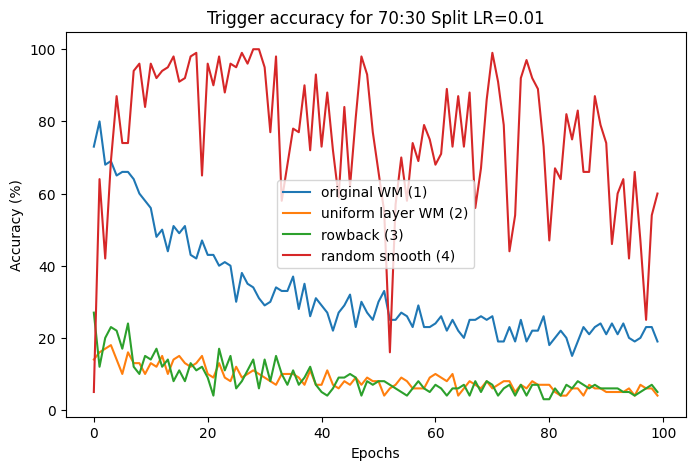

In [40]:
plt.figure(figsize=(8, 5))

plt.plot(range(len(metrics10['trigger_acc'])), metrics10['trigger_acc'], label='original WM (1)')
plt.plot(range(len(metrics11['trigger_acc'])), metrics11['trigger_acc'], label='uniform layer WM (2)')
plt.plot(range(len(metrics12['trigger_acc'])), metrics12['trigger_acc'], label='rowback (3)')

plt.plot(range(len(metrics9['trigger_acc'])), metrics9['trigger_acc'], label='random smooth (4)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Trigger accuracy for 70:30 Split LR=0.01')
plt.legend()
plt.savefig('incre_trigger_acc_7030_lr0.01.png')

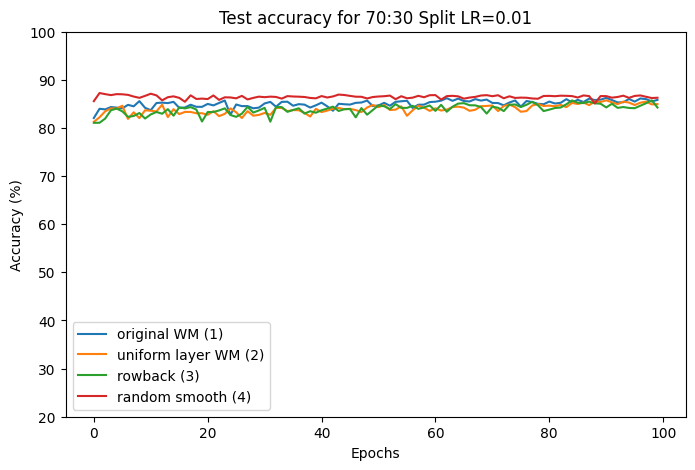

In [41]:
plt.figure(figsize=(8, 5))
plt.plot(range(len(metrics10['val_acc'])), metrics10['val_acc'], label='original WM (1)')
plt.plot(range(len(metrics11['val_acc'])), metrics11['val_acc'], label='uniform layer WM (2)')
plt.plot(range(len(metrics12['val_acc'])), metrics12['val_acc'], label='rowback (3)')

plt.plot(range(len(metrics9['val_acc'])), metrics9['val_acc'], label='random smooth (4)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test accuracy for 70:30 Split LR=0.01')
plt.ylim([20, 100])
plt.legend()
plt.savefig('incre_test_acc_7030_lr0.01.png')

lr=0.0005

In [42]:
net13 = ResNet18()
net13.load_state_dict(torch.load('./models/wm_cifar10_certify_random_7030.pth')['model_state_dict'])
net14 = ResNet18()
net14.load_state_dict(torch.load('./checkpoints/resnet18_wm_7030.ckpt'))
net15 = ResNet18()
net15.load_state_dict(torch.load('./checkpoints/resnet18_wm_frozen_7030.ckpt'))
net16 = ResNet18()
net16.load_state_dict(torch.load('./checkpoints/resnet18_wm_rowback_7030.ckpt'))

<All keys matched successfully>

In [43]:
evaluator = Evaluator(net13, torch.nn.CrossEntropyLoss())
print(evaluator.eval(testloader))
print(evaluator.eval(unrelatedloader))

{'loss': 0.6196484971925617, 'accuracy': 87.48}
{'loss': 1.951130005181767e-05, 'accuracy': 100.0}


In [44]:
evaluator = Evaluator(net14, torch.nn.CrossEntropyLoss())
print("Original watermarking scheme")
print(f"Test accuracy {evaluator.eval(testloader)}")
print(f"Watermark accuracy {evaluator.eval(wmloader)}")

Original watermarking scheme
Test accuracy {'loss': 0.4954307278931141, 'accuracy': 86.14}
Watermark accuracy {'loss': 0.000222562343114987, 'accuracy': 100.0}


In [45]:
evaluator = Evaluator(net15, torch.nn.CrossEntropyLoss())
print("Frozen watermarking scheme")
print(f"Test accuracy {evaluator.eval(testloader)}")
print(f"Watermark accuracy {evaluator.eval(wmloader)}")

Frozen watermarking scheme
Test accuracy {'loss': 0.5337510022163391, 'accuracy': 85.11999999999999}
Watermark accuracy {'loss': 0.00108483558986336, 'accuracy': 100.0}


In [46]:
evaluator = Evaluator(net16, torch.nn.CrossEntropyLoss())
print("ROWBack watermarking scheme")
print(f"Test accuracy {evaluator.eval(testloader)}")
print(f"Watermark accuracy {evaluator.eval(advwmloader)}")

ROWBack watermarking scheme
Test accuracy {'loss': 0.528250137591362, 'accuracy': 85.41}
Watermark accuracy {'loss': 0.0008671070565469563, 'accuracy': 100.0}


In [47]:
logcmt = f"incre_train_certified_7030"

optimizer13 = torch.optim.SGD(lr=0.0005, params=net13.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer13 = Trainer(net13, criterion, optimizer13, incloader)
evaluator13 = Evaluator(net13, criterion)

metrics13 = train(trainer13, evaluator13, testloader, savename='inccheckpoints/incre_train_cert_7030_lr0.0005', logdir='./runs', logcmt=logcmt, trigger_loader=unrelatedloader, epochs=100)

Start Training...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 0 | Time 7s| Train Loss 0.5752 | Train Acc 86.93| Val Loss 0.601 | Val Acc 87.43| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 1 | Time 15s| Train Loss 0.5217 | Train Acc 87.08| Val Loss 0.577 | Val Acc 87.60| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 2 | Time 23s| Train Loss 0.4845 | Train Acc 87.09| Val Loss 0.551 | Val Acc 87.45| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.46it/s]


Epoch 3 | Time 30s| Train Loss 0.4456 | Train Acc 87.80| Val Loss 0.528 | Val Acc 87.37| Trigger Loss 0.008 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 4 | Time 37s| Train Loss 0.4159 | Train Acc 88.08| Val Loss 0.503 | Val Acc 87.27| Trigger Loss 0.023 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 5 | Time 45s| Train Loss 0.3950 | Train Acc 88.42| Val Loss 0.497 | Val Acc 87.51| Trigger Loss 0.034 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.46it/s]


Epoch 6 | Time 52s| Train Loss 0.3870 | Train Acc 88.06| Val Loss 0.473 | Val Acc 87.39| Trigger Loss 0.111 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 7 | Time 59s| Train Loss 0.3656 | Train Acc 88.58| Val Loss 0.464 | Val Acc 87.51| Trigger Loss 0.139 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 8 | Time 66s| Train Loss 0.3677 | Train Acc 88.42| Val Loss 0.473 | Val Acc 87.34| Trigger Loss 0.121 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 9 | Time 73s| Train Loss 0.3497 | Train Acc 88.92| Val Loss 0.450 | Val Acc 87.55| Trigger Loss 0.226 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 10 | Time 80s| Train Loss 0.3394 | Train Acc 89.11| Val Loss 0.464 | Val Acc 87.33| Trigger Loss 0.123 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 11 | Time 87s| Train Loss 0.3502 | Train Acc 88.92| Val Loss 0.438 | Val Acc 87.59| Trigger Loss 0.221 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 12 | Time 94s| Train Loss 0.3321 | Train Acc 88.96| Val Loss 0.447 | Val Acc 87.38| Trigger Loss 0.227 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 13 | Time 102s| Train Loss 0.3273 | Train Acc 89.16| Val Loss 0.432 | Val Acc 87.34| Trigger Loss 0.257 | Trigger Acc 89.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 14 | Time 109s| Train Loss 0.3202 | Train Acc 89.20| Val Loss 0.432 | Val Acc 87.34| Trigger Loss 0.261 | Trigger Acc 89.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 15 | Time 116s| Train Loss 0.3150 | Train Acc 89.55| Val Loss 0.430 | Val Acc 87.35| Trigger Loss 0.275 | Trigger Acc 89.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 16 | Time 123s| Train Loss 0.3091 | Train Acc 89.43| Val Loss 0.424 | Val Acc 87.35| Trigger Loss 0.307 | Trigger Acc 87.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 17 | Time 130s| Train Loss 0.3068 | Train Acc 89.76| Val Loss 0.420 | Val Acc 87.44| Trigger Loss 0.401 | Trigger Acc 84.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 18 | Time 137s| Train Loss 0.3083 | Train Acc 89.54| Val Loss 0.430 | Val Acc 87.70| Trigger Loss 0.257 | Trigger Acc 89.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 19 | Time 144s| Train Loss 0.3024 | Train Acc 89.85| Val Loss 0.426 | Val Acc 87.54| Trigger Loss 0.271 | Trigger Acc 88.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 20 | Time 151s| Train Loss 0.3015 | Train Acc 89.98| Val Loss 0.420 | Val Acc 87.62| Trigger Loss 0.297 | Trigger Acc 87.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 21 | Time 159s| Train Loss 0.2993 | Train Acc 90.03| Val Loss 0.425 | Val Acc 87.65| Trigger Loss 0.255 | Trigger Acc 88.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 22 | Time 166s| Train Loss 0.2971 | Train Acc 89.77| Val Loss 0.420 | Val Acc 87.58| Trigger Loss 0.407 | Trigger Acc 83.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 23 | Time 173s| Train Loss 0.2868 | Train Acc 90.49| Val Loss 0.420 | Val Acc 87.65| Trigger Loss 0.316 | Trigger Acc 86.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 24 | Time 180s| Train Loss 0.2878 | Train Acc 90.09| Val Loss 0.426 | Val Acc 87.81| Trigger Loss 0.192 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 25 | Time 187s| Train Loss 0.2863 | Train Acc 90.39| Val Loss 0.413 | Val Acc 87.71| Trigger Loss 0.256 | Trigger Acc 88.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 26 | Time 194s| Train Loss 0.2904 | Train Acc 90.09| Val Loss 0.414 | Val Acc 87.66| Trigger Loss 0.297 | Trigger Acc 87.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 27 | Time 201s| Train Loss 0.2817 | Train Acc 90.47| Val Loss 0.415 | Val Acc 87.58| Trigger Loss 0.307 | Trigger Acc 86.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 28 | Time 208s| Train Loss 0.2815 | Train Acc 90.43| Val Loss 0.409 | Val Acc 87.58| Trigger Loss 0.266 | Trigger Acc 88.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 29 | Time 215s| Train Loss 0.2779 | Train Acc 90.54| Val Loss 0.412 | Val Acc 87.48| Trigger Loss 0.339 | Trigger Acc 86.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 30 | Time 222s| Train Loss 0.2718 | Train Acc 90.92| Val Loss 0.412 | Val Acc 87.77| Trigger Loss 0.267 | Trigger Acc 88.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 31 | Time 230s| Train Loss 0.2820 | Train Acc 90.54| Val Loss 0.415 | Val Acc 87.69| Trigger Loss 0.238 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 32 | Time 237s| Train Loss 0.2674 | Train Acc 90.86| Val Loss 0.412 | Val Acc 87.58| Trigger Loss 0.289 | Trigger Acc 88.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 33 | Time 244s| Train Loss 0.2626 | Train Acc 91.12| Val Loss 0.412 | Val Acc 87.67| Trigger Loss 0.308 | Trigger Acc 87.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 34 | Time 251s| Train Loss 0.2632 | Train Acc 91.04| Val Loss 0.418 | Val Acc 87.62| Trigger Loss 0.233 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 35 | Time 258s| Train Loss 0.2631 | Train Acc 91.12| Val Loss 0.417 | Val Acc 87.62| Trigger Loss 0.248 | Trigger Acc 88.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 36 | Time 265s| Train Loss 0.2599 | Train Acc 90.83| Val Loss 0.414 | Val Acc 87.73| Trigger Loss 0.228 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 37 | Time 272s| Train Loss 0.2546 | Train Acc 91.20| Val Loss 0.412 | Val Acc 87.76| Trigger Loss 0.236 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 38 | Time 279s| Train Loss 0.2581 | Train Acc 90.99| Val Loss 0.421 | Val Acc 87.75| Trigger Loss 0.174 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 39 | Time 286s| Train Loss 0.2534 | Train Acc 91.36| Val Loss 0.423 | Val Acc 87.66| Trigger Loss 0.177 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 40 | Time 293s| Train Loss 0.2529 | Train Acc 91.48| Val Loss 0.420 | Val Acc 87.62| Trigger Loss 0.159 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 41 | Time 301s| Train Loss 0.2475 | Train Acc 91.66| Val Loss 0.414 | Val Acc 87.59| Trigger Loss 0.191 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 42 | Time 308s| Train Loss 0.2459 | Train Acc 91.75| Val Loss 0.418 | Val Acc 87.58| Trigger Loss 0.153 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 43 | Time 315s| Train Loss 0.2445 | Train Acc 91.57| Val Loss 0.423 | Val Acc 87.60| Trigger Loss 0.192 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 44 | Time 322s| Train Loss 0.2447 | Train Acc 91.52| Val Loss 0.416 | Val Acc 87.75| Trigger Loss 0.196 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 45 | Time 329s| Train Loss 0.2459 | Train Acc 91.66| Val Loss 0.417 | Val Acc 87.55| Trigger Loss 0.220 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 46 | Time 336s| Train Loss 0.2360 | Train Acc 91.87| Val Loss 0.426 | Val Acc 87.56| Trigger Loss 0.180 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 47 | Time 343s| Train Loss 0.2330 | Train Acc 92.01| Val Loss 0.422 | Val Acc 87.54| Trigger Loss 0.146 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 48 | Time 350s| Train Loss 0.2332 | Train Acc 91.82| Val Loss 0.429 | Val Acc 87.49| Trigger Loss 0.107 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 49 | Time 357s| Train Loss 0.2347 | Train Acc 92.26| Val Loss 0.432 | Val Acc 87.41| Trigger Loss 0.141 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 50 | Time 365s| Train Loss 0.2317 | Train Acc 92.06| Val Loss 0.419 | Val Acc 87.70| Trigger Loss 0.190 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.28it/s]


Epoch 51 | Time 372s| Train Loss 0.2313 | Train Acc 92.10| Val Loss 0.424 | Val Acc 87.58| Trigger Loss 0.173 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 52 | Time 379s| Train Loss 0.2274 | Train Acc 92.15| Val Loss 0.421 | Val Acc 87.78| Trigger Loss 0.190 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 53 | Time 386s| Train Loss 0.2237 | Train Acc 92.26| Val Loss 0.431 | Val Acc 87.52| Trigger Loss 0.157 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 54 | Time 393s| Train Loss 0.2280 | Train Acc 92.18| Val Loss 0.426 | Val Acc 87.66| Trigger Loss 0.156 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 55 | Time 400s| Train Loss 0.2185 | Train Acc 92.67| Val Loss 0.424 | Val Acc 87.56| Trigger Loss 0.164 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 56 | Time 407s| Train Loss 0.2284 | Train Acc 92.21| Val Loss 0.431 | Val Acc 87.59| Trigger Loss 0.148 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 57 | Time 414s| Train Loss 0.2217 | Train Acc 92.36| Val Loss 0.430 | Val Acc 87.60| Trigger Loss 0.139 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 58 | Time 422s| Train Loss 0.2199 | Train Acc 92.55| Val Loss 0.425 | Val Acc 87.60| Trigger Loss 0.164 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 59 | Time 429s| Train Loss 0.2158 | Train Acc 92.71| Val Loss 0.429 | Val Acc 87.55| Trigger Loss 0.160 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 60 | Time 436s| Train Loss 0.2130 | Train Acc 92.67| Val Loss 0.428 | Val Acc 87.68| Trigger Loss 0.123 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 61 | Time 443s| Train Loss 0.2067 | Train Acc 92.90| Val Loss 0.429 | Val Acc 87.61| Trigger Loss 0.141 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 62 | Time 450s| Train Loss 0.2103 | Train Acc 92.80| Val Loss 0.434 | Val Acc 87.42| Trigger Loss 0.117 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 63 | Time 457s| Train Loss 0.2119 | Train Acc 92.61| Val Loss 0.430 | Val Acc 87.54| Trigger Loss 0.154 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.27it/s]


Epoch 64 | Time 464s| Train Loss 0.2088 | Train Acc 92.68| Val Loss 0.431 | Val Acc 87.69| Trigger Loss 0.162 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 65 | Time 471s| Train Loss 0.2035 | Train Acc 92.88| Val Loss 0.432 | Val Acc 87.61| Trigger Loss 0.146 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 66 | Time 478s| Train Loss 0.1981 | Train Acc 93.24| Val Loss 0.435 | Val Acc 87.56| Trigger Loss 0.111 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 67 | Time 486s| Train Loss 0.1949 | Train Acc 93.13| Val Loss 0.440 | Val Acc 87.38| Trigger Loss 0.105 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 68 | Time 493s| Train Loss 0.2006 | Train Acc 93.23| Val Loss 0.439 | Val Acc 87.51| Trigger Loss 0.081 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 69 | Time 500s| Train Loss 0.1958 | Train Acc 93.17| Val Loss 0.437 | Val Acc 87.61| Trigger Loss 0.114 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 70 | Time 507s| Train Loss 0.1979 | Train Acc 93.23| Val Loss 0.443 | Val Acc 87.42| Trigger Loss 0.118 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 71 | Time 514s| Train Loss 0.1923 | Train Acc 93.36| Val Loss 0.442 | Val Acc 87.51| Trigger Loss 0.104 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 72 | Time 521s| Train Loss 0.1874 | Train Acc 93.47| Val Loss 0.447 | Val Acc 87.45| Trigger Loss 0.119 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 73 | Time 528s| Train Loss 0.1832 | Train Acc 93.68| Val Loss 0.443 | Val Acc 87.33| Trigger Loss 0.101 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 74 | Time 535s| Train Loss 0.1857 | Train Acc 93.57| Val Loss 0.447 | Val Acc 87.38| Trigger Loss 0.104 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 75 | Time 543s| Train Loss 0.1864 | Train Acc 93.60| Val Loss 0.451 | Val Acc 87.35| Trigger Loss 0.101 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 76 | Time 550s| Train Loss 0.1872 | Train Acc 93.67| Val Loss 0.450 | Val Acc 87.43| Trigger Loss 0.072 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 77 | Time 557s| Train Loss 0.1773 | Train Acc 93.97| Val Loss 0.460 | Val Acc 87.22| Trigger Loss 0.063 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.47it/s]


Epoch 78 | Time 564s| Train Loss 0.1757 | Train Acc 94.03| Val Loss 0.459 | Val Acc 87.48| Trigger Loss 0.054 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 79 | Time 572s| Train Loss 0.1835 | Train Acc 93.83| Val Loss 0.460 | Val Acc 87.56| Trigger Loss 0.056 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 80 | Time 579s| Train Loss 0.1755 | Train Acc 93.82| Val Loss 0.456 | Val Acc 87.55| Trigger Loss 0.061 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.46it/s]


Epoch 81 | Time 586s| Train Loss 0.1802 | Train Acc 93.89| Val Loss 0.458 | Val Acc 87.45| Trigger Loss 0.062 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.47it/s]


Epoch 82 | Time 594s| Train Loss 0.1754 | Train Acc 94.07| Val Loss 0.458 | Val Acc 87.46| Trigger Loss 0.075 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 83 | Time 601s| Train Loss 0.1770 | Train Acc 93.70| Val Loss 0.455 | Val Acc 87.62| Trigger Loss 0.081 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 84 | Time 608s| Train Loss 0.1716 | Train Acc 94.05| Val Loss 0.464 | Val Acc 87.46| Trigger Loss 0.053 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.46it/s]


Epoch 85 | Time 615s| Train Loss 0.1689 | Train Acc 94.22| Val Loss 0.458 | Val Acc 87.65| Trigger Loss 0.063 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 86 | Time 622s| Train Loss 0.1707 | Train Acc 94.11| Val Loss 0.458 | Val Acc 87.56| Trigger Loss 0.072 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 87 | Time 629s| Train Loss 0.1654 | Train Acc 94.17| Val Loss 0.461 | Val Acc 87.58| Trigger Loss 0.060 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 88 | Time 636s| Train Loss 0.1713 | Train Acc 94.14| Val Loss 0.459 | Val Acc 87.40| Trigger Loss 0.075 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 89 | Time 644s| Train Loss 0.1607 | Train Acc 94.53| Val Loss 0.463 | Val Acc 87.49| Trigger Loss 0.045 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 90 | Time 651s| Train Loss 0.1607 | Train Acc 94.51| Val Loss 0.465 | Val Acc 87.47| Trigger Loss 0.082 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 91 | Time 658s| Train Loss 0.1596 | Train Acc 94.46| Val Loss 0.469 | Val Acc 87.35| Trigger Loss 0.037 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 92 | Time 665s| Train Loss 0.1635 | Train Acc 94.41| Val Loss 0.471 | Val Acc 87.42| Trigger Loss 0.034 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 93 | Time 673s| Train Loss 0.1590 | Train Acc 94.66| Val Loss 0.469 | Val Acc 87.47| Trigger Loss 0.038 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 94 | Time 680s| Train Loss 0.1538 | Train Acc 94.73| Val Loss 0.469 | Val Acc 87.41| Trigger Loss 0.033 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 95 | Time 687s| Train Loss 0.1596 | Train Acc 94.60| Val Loss 0.471 | Val Acc 87.43| Trigger Loss 0.030 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 96 | Time 695s| Train Loss 0.1541 | Train Acc 94.63| Val Loss 0.476 | Val Acc 87.51| Trigger Loss 0.029 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 97 | Time 702s| Train Loss 0.1518 | Train Acc 94.84| Val Loss 0.474 | Val Acc 87.33| Trigger Loss 0.040 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 98 | Time 710s| Train Loss 0.1492 | Train Acc 94.85| Val Loss 0.480 | Val Acc 87.50| Trigger Loss 0.049 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 99 | Time 717s| Train Loss 0.1473 | Train Acc 94.95| Val Loss 0.481 | Val Acc 87.46| Trigger Loss 0.035 | Trigger Acc 100.00


In [48]:
logcmt = f"incre_train_baseline_7030"

optimizer14 = torch.optim.SGD(lr=0.0005, params=net14.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer14 = Trainer(net14, criterion, optimizer14, incloader)
evaluator14 = Evaluator(net14, criterion)

metrics14 = train(trainer14, evaluator14, testloader, savename='inccheckpoints/incre_train_baseline_7030_lr0.0005', logdir='./runs', logcmt=logcmt, trigger_loader=wmloader, epochs=100)

Start Training...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 0 | Time 7s| Train Loss 0.4670 | Train Acc 86.29| Val Loss 0.487 | Val Acc 86.24| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 1 | Time 15s| Train Loss 0.4339 | Train Acc 86.95| Val Loss 0.477 | Val Acc 86.49| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 2 | Time 23s| Train Loss 0.4211 | Train Acc 86.98| Val Loss 0.468 | Val Acc 86.30| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 3 | Time 30s| Train Loss 0.4041 | Train Acc 87.11| Val Loss 0.461 | Val Acc 86.28| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 4 | Time 37s| Train Loss 0.3962 | Train Acc 87.07| Val Loss 0.454 | Val Acc 86.38| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 5 | Time 45s| Train Loss 0.3886 | Train Acc 87.47| Val Loss 0.449 | Val Acc 86.32| Trigger Loss 0.003 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 6 | Time 52s| Train Loss 0.3759 | Train Acc 87.55| Val Loss 0.444 | Val Acc 86.31| Trigger Loss 0.004 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 7 | Time 59s| Train Loss 0.3671 | Train Acc 87.72| Val Loss 0.442 | Val Acc 86.22| Trigger Loss 0.004 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 8 | Time 67s| Train Loss 0.3580 | Train Acc 88.00| Val Loss 0.437 | Val Acc 86.34| Trigger Loss 0.005 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 9 | Time 74s| Train Loss 0.3520 | Train Acc 88.16| Val Loss 0.434 | Val Acc 86.46| Trigger Loss 0.006 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 10 | Time 82s| Train Loss 0.3449 | Train Acc 88.12| Val Loss 0.430 | Val Acc 86.50| Trigger Loss 0.006 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 11 | Time 89s| Train Loss 0.3349 | Train Acc 88.69| Val Loss 0.429 | Val Acc 86.39| Trigger Loss 0.006 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 12 | Time 96s| Train Loss 0.3410 | Train Acc 88.17| Val Loss 0.429 | Val Acc 86.36| Trigger Loss 0.009 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.32it/s]


Epoch 13 | Time 104s| Train Loss 0.3263 | Train Acc 89.10| Val Loss 0.422 | Val Acc 86.42| Trigger Loss 0.010 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 14 | Time 111s| Train Loss 0.3274 | Train Acc 88.76| Val Loss 0.420 | Val Acc 86.31| Trigger Loss 0.010 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 15 | Time 119s| Train Loss 0.3210 | Train Acc 88.87| Val Loss 0.421 | Val Acc 86.34| Trigger Loss 0.012 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 16 | Time 126s| Train Loss 0.3174 | Train Acc 89.05| Val Loss 0.420 | Val Acc 86.56| Trigger Loss 0.011 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 17 | Time 133s| Train Loss 0.3188 | Train Acc 89.07| Val Loss 0.418 | Val Acc 86.49| Trigger Loss 0.011 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 18 | Time 141s| Train Loss 0.3159 | Train Acc 89.13| Val Loss 0.417 | Val Acc 86.58| Trigger Loss 0.013 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 19 | Time 148s| Train Loss 0.3059 | Train Acc 89.57| Val Loss 0.417 | Val Acc 86.69| Trigger Loss 0.013 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 20 | Time 156s| Train Loss 0.3074 | Train Acc 89.59| Val Loss 0.415 | Val Acc 86.63| Trigger Loss 0.014 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 21 | Time 163s| Train Loss 0.3071 | Train Acc 89.45| Val Loss 0.417 | Val Acc 86.56| Trigger Loss 0.015 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 22 | Time 170s| Train Loss 0.3068 | Train Acc 89.41| Val Loss 0.411 | Val Acc 86.68| Trigger Loss 0.015 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 23 | Time 178s| Train Loss 0.3059 | Train Acc 89.51| Val Loss 0.415 | Val Acc 86.46| Trigger Loss 0.017 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 24 | Time 185s| Train Loss 0.2983 | Train Acc 89.70| Val Loss 0.416 | Val Acc 86.48| Trigger Loss 0.023 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 25 | Time 193s| Train Loss 0.2942 | Train Acc 90.01| Val Loss 0.416 | Val Acc 86.58| Trigger Loss 0.023 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 26 | Time 200s| Train Loss 0.2958 | Train Acc 89.89| Val Loss 0.415 | Val Acc 86.63| Trigger Loss 0.023 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 27 | Time 207s| Train Loss 0.2976 | Train Acc 89.81| Val Loss 0.415 | Val Acc 86.51| Trigger Loss 0.028 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 28 | Time 215s| Train Loss 0.2870 | Train Acc 90.17| Val Loss 0.412 | Val Acc 86.62| Trigger Loss 0.026 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 29 | Time 222s| Train Loss 0.2820 | Train Acc 90.33| Val Loss 0.414 | Val Acc 86.65| Trigger Loss 0.026 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 30 | Time 229s| Train Loss 0.2814 | Train Acc 90.06| Val Loss 0.413 | Val Acc 86.62| Trigger Loss 0.031 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 31 | Time 237s| Train Loss 0.2820 | Train Acc 90.26| Val Loss 0.410 | Val Acc 86.61| Trigger Loss 0.026 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 32 | Time 244s| Train Loss 0.2748 | Train Acc 90.50| Val Loss 0.413 | Val Acc 86.43| Trigger Loss 0.028 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 33 | Time 252s| Train Loss 0.2732 | Train Acc 90.73| Val Loss 0.416 | Val Acc 86.57| Trigger Loss 0.032 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 34 | Time 259s| Train Loss 0.2712 | Train Acc 90.71| Val Loss 0.416 | Val Acc 86.61| Trigger Loss 0.035 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 35 | Time 266s| Train Loss 0.2736 | Train Acc 90.63| Val Loss 0.416 | Val Acc 86.71| Trigger Loss 0.036 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 36 | Time 274s| Train Loss 0.2720 | Train Acc 90.69| Val Loss 0.415 | Val Acc 86.60| Trigger Loss 0.035 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 37 | Time 281s| Train Loss 0.2723 | Train Acc 90.71| Val Loss 0.417 | Val Acc 86.69| Trigger Loss 0.035 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 38 | Time 288s| Train Loss 0.2657 | Train Acc 90.78| Val Loss 0.416 | Val Acc 86.68| Trigger Loss 0.034 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 39 | Time 296s| Train Loss 0.2629 | Train Acc 91.04| Val Loss 0.416 | Val Acc 86.72| Trigger Loss 0.048 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 40 | Time 303s| Train Loss 0.2604 | Train Acc 91.14| Val Loss 0.415 | Val Acc 86.63| Trigger Loss 0.047 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 41 | Time 310s| Train Loss 0.2613 | Train Acc 91.10| Val Loss 0.419 | Val Acc 86.77| Trigger Loss 0.050 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 42 | Time 318s| Train Loss 0.2642 | Train Acc 90.81| Val Loss 0.420 | Val Acc 86.57| Trigger Loss 0.045 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 43 | Time 325s| Train Loss 0.2593 | Train Acc 90.94| Val Loss 0.420 | Val Acc 86.59| Trigger Loss 0.047 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 44 | Time 333s| Train Loss 0.2517 | Train Acc 91.26| Val Loss 0.419 | Val Acc 86.40| Trigger Loss 0.049 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 45 | Time 340s| Train Loss 0.2518 | Train Acc 91.34| Val Loss 0.418 | Val Acc 86.63| Trigger Loss 0.053 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 46 | Time 347s| Train Loss 0.2510 | Train Acc 91.51| Val Loss 0.421 | Val Acc 86.53| Trigger Loss 0.046 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 47 | Time 354s| Train Loss 0.2479 | Train Acc 91.40| Val Loss 0.422 | Val Acc 86.49| Trigger Loss 0.064 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 48 | Time 362s| Train Loss 0.2463 | Train Acc 91.48| Val Loss 0.418 | Val Acc 86.61| Trigger Loss 0.050 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 49 | Time 369s| Train Loss 0.2474 | Train Acc 91.72| Val Loss 0.422 | Val Acc 86.60| Trigger Loss 0.063 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 50 | Time 376s| Train Loss 0.2456 | Train Acc 91.55| Val Loss 0.420 | Val Acc 86.63| Trigger Loss 0.055 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 51 | Time 383s| Train Loss 0.2450 | Train Acc 91.66| Val Loss 0.422 | Val Acc 86.68| Trigger Loss 0.053 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 52 | Time 391s| Train Loss 0.2421 | Train Acc 91.60| Val Loss 0.426 | Val Acc 86.57| Trigger Loss 0.058 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 53 | Time 398s| Train Loss 0.2424 | Train Acc 91.78| Val Loss 0.426 | Val Acc 86.59| Trigger Loss 0.070 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.46it/s]


Epoch 54 | Time 405s| Train Loss 0.2367 | Train Acc 91.95| Val Loss 0.427 | Val Acc 86.45| Trigger Loss 0.071 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 55 | Time 412s| Train Loss 0.2340 | Train Acc 91.93| Val Loss 0.425 | Val Acc 86.59| Trigger Loss 0.055 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 56 | Time 419s| Train Loss 0.2368 | Train Acc 92.04| Val Loss 0.427 | Val Acc 86.56| Trigger Loss 0.061 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 57 | Time 427s| Train Loss 0.2314 | Train Acc 92.15| Val Loss 0.427 | Val Acc 86.61| Trigger Loss 0.064 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 58 | Time 434s| Train Loss 0.2265 | Train Acc 92.40| Val Loss 0.430 | Val Acc 86.18| Trigger Loss 0.071 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 59 | Time 441s| Train Loss 0.2273 | Train Acc 92.32| Val Loss 0.428 | Val Acc 86.62| Trigger Loss 0.055 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 60 | Time 448s| Train Loss 0.2286 | Train Acc 92.09| Val Loss 0.431 | Val Acc 86.55| Trigger Loss 0.060 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 61 | Time 456s| Train Loss 0.2232 | Train Acc 92.06| Val Loss 0.432 | Val Acc 86.59| Trigger Loss 0.075 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 62 | Time 463s| Train Loss 0.2234 | Train Acc 92.64| Val Loss 0.432 | Val Acc 86.73| Trigger Loss 0.070 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 63 | Time 471s| Train Loss 0.2202 | Train Acc 92.57| Val Loss 0.434 | Val Acc 86.60| Trigger Loss 0.074 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 64 | Time 478s| Train Loss 0.2218 | Train Acc 92.35| Val Loss 0.434 | Val Acc 86.59| Trigger Loss 0.074 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 65 | Time 485s| Train Loss 0.2195 | Train Acc 92.73| Val Loss 0.435 | Val Acc 86.52| Trigger Loss 0.095 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 66 | Time 492s| Train Loss 0.2145 | Train Acc 92.79| Val Loss 0.434 | Val Acc 86.48| Trigger Loss 0.071 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 67 | Time 499s| Train Loss 0.2165 | Train Acc 92.63| Val Loss 0.435 | Val Acc 86.63| Trigger Loss 0.088 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 68 | Time 506s| Train Loss 0.2161 | Train Acc 92.86| Val Loss 0.434 | Val Acc 86.53| Trigger Loss 0.081 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 69 | Time 513s| Train Loss 0.2150 | Train Acc 92.77| Val Loss 0.437 | Val Acc 86.57| Trigger Loss 0.086 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 70 | Time 520s| Train Loss 0.2075 | Train Acc 93.15| Val Loss 0.437 | Val Acc 86.59| Trigger Loss 0.084 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 71 | Time 528s| Train Loss 0.2146 | Train Acc 92.57| Val Loss 0.437 | Val Acc 86.43| Trigger Loss 0.093 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 72 | Time 535s| Train Loss 0.2078 | Train Acc 92.95| Val Loss 0.440 | Val Acc 86.43| Trigger Loss 0.106 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 73 | Time 542s| Train Loss 0.2037 | Train Acc 93.26| Val Loss 0.441 | Val Acc 86.61| Trigger Loss 0.108 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 74 | Time 549s| Train Loss 0.2045 | Train Acc 93.16| Val Loss 0.441 | Val Acc 86.65| Trigger Loss 0.103 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 75 | Time 556s| Train Loss 0.1997 | Train Acc 93.09| Val Loss 0.441 | Val Acc 86.49| Trigger Loss 0.114 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 76 | Time 563s| Train Loss 0.1961 | Train Acc 93.57| Val Loss 0.443 | Val Acc 86.54| Trigger Loss 0.096 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 77 | Time 570s| Train Loss 0.1952 | Train Acc 93.64| Val Loss 0.442 | Val Acc 86.58| Trigger Loss 0.102 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 78 | Time 577s| Train Loss 0.1970 | Train Acc 93.38| Val Loss 0.446 | Val Acc 86.55| Trigger Loss 0.096 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 79 | Time 584s| Train Loss 0.1963 | Train Acc 93.23| Val Loss 0.446 | Val Acc 86.56| Trigger Loss 0.113 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 80 | Time 592s| Train Loss 0.1945 | Train Acc 93.55| Val Loss 0.445 | Val Acc 86.50| Trigger Loss 0.117 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 81 | Time 599s| Train Loss 0.1978 | Train Acc 93.51| Val Loss 0.448 | Val Acc 86.67| Trigger Loss 0.106 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 82 | Time 606s| Train Loss 0.1876 | Train Acc 93.75| Val Loss 0.448 | Val Acc 86.38| Trigger Loss 0.151 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 83 | Time 613s| Train Loss 0.1902 | Train Acc 93.67| Val Loss 0.451 | Val Acc 86.42| Trigger Loss 0.111 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 84 | Time 620s| Train Loss 0.1880 | Train Acc 93.71| Val Loss 0.452 | Val Acc 86.44| Trigger Loss 0.118 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 85 | Time 627s| Train Loss 0.1838 | Train Acc 93.86| Val Loss 0.455 | Val Acc 86.38| Trigger Loss 0.108 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 86 | Time 634s| Train Loss 0.1880 | Train Acc 93.74| Val Loss 0.457 | Val Acc 86.45| Trigger Loss 0.128 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 87 | Time 641s| Train Loss 0.1813 | Train Acc 93.80| Val Loss 0.455 | Val Acc 86.53| Trigger Loss 0.121 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 88 | Time 649s| Train Loss 0.1820 | Train Acc 93.81| Val Loss 0.457 | Val Acc 86.41| Trigger Loss 0.151 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 89 | Time 656s| Train Loss 0.1845 | Train Acc 93.81| Val Loss 0.458 | Val Acc 86.44| Trigger Loss 0.139 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 90 | Time 663s| Train Loss 0.1811 | Train Acc 93.83| Val Loss 0.458 | Val Acc 86.46| Trigger Loss 0.154 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 91 | Time 670s| Train Loss 0.1836 | Train Acc 93.69| Val Loss 0.460 | Val Acc 86.35| Trigger Loss 0.150 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 92 | Time 677s| Train Loss 0.1784 | Train Acc 94.08| Val Loss 0.458 | Val Acc 86.36| Trigger Loss 0.158 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 93 | Time 684s| Train Loss 0.1758 | Train Acc 94.06| Val Loss 0.459 | Val Acc 86.44| Trigger Loss 0.135 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 94 | Time 691s| Train Loss 0.1698 | Train Acc 94.24| Val Loss 0.461 | Val Acc 86.51| Trigger Loss 0.164 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 95 | Time 698s| Train Loss 0.1699 | Train Acc 94.50| Val Loss 0.463 | Val Acc 86.27| Trigger Loss 0.153 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 96 | Time 705s| Train Loss 0.1717 | Train Acc 94.26| Val Loss 0.468 | Val Acc 86.39| Trigger Loss 0.156 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.21it/s]


Epoch 97 | Time 713s| Train Loss 0.1708 | Train Acc 94.34| Val Loss 0.466 | Val Acc 86.44| Trigger Loss 0.157 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 98 | Time 720s| Train Loss 0.1673 | Train Acc 94.26| Val Loss 0.467 | Val Acc 86.55| Trigger Loss 0.140 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.31it/s]


Epoch 99 | Time 727s| Train Loss 0.1644 | Train Acc 94.50| Val Loss 0.475 | Val Acc 86.34| Trigger Loss 0.168 | Trigger Acc 92.00


In [49]:
logcmt = f"incre_train_baseline_frozen_7030"

optimizer15 = torch.optim.SGD(lr=0.0005, params=net15.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer15 = Trainer(net15, criterion, optimizer15, incloader)
evaluator15 = Evaluator(net15, criterion)
metrics15 = train(trainer15, evaluator15, testloader, savename='inccheckpoints/incre_train_baseline_frozen_7030_lr0.0005', logdir='./runs', logcmt=logcmt, trigger_loader=wmloader, epochs=100)

Start Training...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 0 | Time 7s| Train Loss 0.4973 | Train Acc 84.90| Val Loss 0.539 | Val Acc 84.47| Trigger Loss 0.109 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 1 | Time 15s| Train Loss 0.4682 | Train Acc 85.46| Val Loss 0.516 | Val Acc 85.05| Trigger Loss 0.120 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 2 | Time 23s| Train Loss 0.4386 | Train Acc 85.87| Val Loss 0.504 | Val Acc 84.99| Trigger Loss 0.212 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 3 | Time 30s| Train Loss 0.4222 | Train Acc 86.17| Val Loss 0.499 | Val Acc 85.13| Trigger Loss 0.266 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 4 | Time 37s| Train Loss 0.4146 | Train Acc 86.39| Val Loss 0.493 | Val Acc 85.32| Trigger Loss 0.348 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 5 | Time 44s| Train Loss 0.4082 | Train Acc 86.45| Val Loss 0.490 | Val Acc 85.16| Trigger Loss 0.477 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 6 | Time 51s| Train Loss 0.3933 | Train Acc 86.75| Val Loss 0.485 | Val Acc 85.19| Trigger Loss 0.535 | Trigger Acc 84.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 7 | Time 58s| Train Loss 0.3896 | Train Acc 86.80| Val Loss 0.482 | Val Acc 85.34| Trigger Loss 0.580 | Trigger Acc 78.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 8 | Time 65s| Train Loss 0.3856 | Train Acc 86.98| Val Loss 0.477 | Val Acc 85.43| Trigger Loss 0.655 | Trigger Acc 81.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 9 | Time 72s| Train Loss 0.3780 | Train Acc 87.17| Val Loss 0.473 | Val Acc 85.25| Trigger Loss 0.632 | Trigger Acc 77.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 10 | Time 80s| Train Loss 0.3700 | Train Acc 87.45| Val Loss 0.472 | Val Acc 85.39| Trigger Loss 0.711 | Trigger Acc 70.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 11 | Time 87s| Train Loss 0.3677 | Train Acc 87.69| Val Loss 0.472 | Val Acc 85.20| Trigger Loss 0.711 | Trigger Acc 70.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 12 | Time 94s| Train Loss 0.3609 | Train Acc 87.92| Val Loss 0.468 | Val Acc 85.39| Trigger Loss 0.750 | Trigger Acc 68.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 13 | Time 101s| Train Loss 0.3474 | Train Acc 87.98| Val Loss 0.464 | Val Acc 85.48| Trigger Loss 0.796 | Trigger Acc 70.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 14 | Time 108s| Train Loss 0.3524 | Train Acc 88.01| Val Loss 0.467 | Val Acc 85.55| Trigger Loss 0.889 | Trigger Acc 68.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 15 | Time 115s| Train Loss 0.3437 | Train Acc 88.44| Val Loss 0.463 | Val Acc 85.45| Trigger Loss 0.748 | Trigger Acc 74.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 16 | Time 122s| Train Loss 0.3371 | Train Acc 88.54| Val Loss 0.463 | Val Acc 85.41| Trigger Loss 0.842 | Trigger Acc 67.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 17 | Time 130s| Train Loss 0.3377 | Train Acc 88.37| Val Loss 0.458 | Val Acc 85.53| Trigger Loss 0.847 | Trigger Acc 70.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 18 | Time 137s| Train Loss 0.3351 | Train Acc 88.64| Val Loss 0.459 | Val Acc 85.47| Trigger Loss 0.918 | Trigger Acc 66.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 19 | Time 144s| Train Loss 0.3199 | Train Acc 89.02| Val Loss 0.460 | Val Acc 85.49| Trigger Loss 0.918 | Trigger Acc 63.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 20 | Time 151s| Train Loss 0.3293 | Train Acc 88.74| Val Loss 0.457 | Val Acc 85.38| Trigger Loss 0.852 | Trigger Acc 69.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 21 | Time 158s| Train Loss 0.3239 | Train Acc 88.82| Val Loss 0.459 | Val Acc 85.45| Trigger Loss 0.956 | Trigger Acc 66.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 22 | Time 165s| Train Loss 0.3244 | Train Acc 88.96| Val Loss 0.462 | Val Acc 85.33| Trigger Loss 1.038 | Trigger Acc 63.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 23 | Time 172s| Train Loss 0.3192 | Train Acc 89.13| Val Loss 0.458 | Val Acc 85.57| Trigger Loss 0.967 | Trigger Acc 62.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 24 | Time 179s| Train Loss 0.3164 | Train Acc 89.12| Val Loss 0.455 | Val Acc 85.55| Trigger Loss 1.028 | Trigger Acc 61.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 25 | Time 187s| Train Loss 0.3157 | Train Acc 88.87| Val Loss 0.454 | Val Acc 85.61| Trigger Loss 1.016 | Trigger Acc 62.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 26 | Time 194s| Train Loss 0.3102 | Train Acc 89.22| Val Loss 0.456 | Val Acc 85.51| Trigger Loss 1.069 | Trigger Acc 61.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 27 | Time 201s| Train Loss 0.3074 | Train Acc 89.57| Val Loss 0.455 | Val Acc 85.65| Trigger Loss 1.000 | Trigger Acc 65.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 28 | Time 208s| Train Loss 0.3047 | Train Acc 89.53| Val Loss 0.456 | Val Acc 85.71| Trigger Loss 1.110 | Trigger Acc 59.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 29 | Time 215s| Train Loss 0.3003 | Train Acc 89.89| Val Loss 0.456 | Val Acc 85.50| Trigger Loss 1.062 | Trigger Acc 63.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 30 | Time 222s| Train Loss 0.2973 | Train Acc 89.61| Val Loss 0.456 | Val Acc 85.44| Trigger Loss 1.029 | Trigger Acc 64.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 31 | Time 229s| Train Loss 0.2950 | Train Acc 89.87| Val Loss 0.459 | Val Acc 85.51| Trigger Loss 1.000 | Trigger Acc 64.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 32 | Time 236s| Train Loss 0.2921 | Train Acc 89.83| Val Loss 0.458 | Val Acc 85.57| Trigger Loss 1.082 | Trigger Acc 62.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 33 | Time 244s| Train Loss 0.2987 | Train Acc 89.61| Val Loss 0.458 | Val Acc 85.73| Trigger Loss 1.067 | Trigger Acc 64.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 34 | Time 251s| Train Loss 0.2823 | Train Acc 90.19| Val Loss 0.461 | Val Acc 85.69| Trigger Loss 1.215 | Trigger Acc 60.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 35 | Time 258s| Train Loss 0.2844 | Train Acc 89.94| Val Loss 0.459 | Val Acc 85.59| Trigger Loss 1.104 | Trigger Acc 60.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 36 | Time 265s| Train Loss 0.2809 | Train Acc 90.41| Val Loss 0.462 | Val Acc 85.43| Trigger Loss 1.160 | Trigger Acc 63.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 37 | Time 272s| Train Loss 0.2832 | Train Acc 90.44| Val Loss 0.458 | Val Acc 85.60| Trigger Loss 1.145 | Trigger Acc 61.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 38 | Time 279s| Train Loss 0.2742 | Train Acc 90.65| Val Loss 0.458 | Val Acc 85.59| Trigger Loss 1.082 | Trigger Acc 60.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 39 | Time 286s| Train Loss 0.2756 | Train Acc 90.54| Val Loss 0.460 | Val Acc 85.44| Trigger Loss 1.225 | Trigger Acc 59.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 40 | Time 293s| Train Loss 0.2736 | Train Acc 90.81| Val Loss 0.459 | Val Acc 85.67| Trigger Loss 1.190 | Trigger Acc 58.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 41 | Time 301s| Train Loss 0.2674 | Train Acc 90.86| Val Loss 0.460 | Val Acc 85.62| Trigger Loss 1.190 | Trigger Acc 58.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 42 | Time 308s| Train Loss 0.2735 | Train Acc 90.54| Val Loss 0.465 | Val Acc 85.54| Trigger Loss 1.315 | Trigger Acc 58.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 43 | Time 315s| Train Loss 0.2632 | Train Acc 91.12| Val Loss 0.462 | Val Acc 85.60| Trigger Loss 1.273 | Trigger Acc 55.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 44 | Time 322s| Train Loss 0.2641 | Train Acc 91.17| Val Loss 0.462 | Val Acc 85.57| Trigger Loss 1.259 | Trigger Acc 60.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 45 | Time 329s| Train Loss 0.2630 | Train Acc 90.91| Val Loss 0.464 | Val Acc 85.54| Trigger Loss 1.176 | Trigger Acc 58.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 46 | Time 336s| Train Loss 0.2588 | Train Acc 91.14| Val Loss 0.463 | Val Acc 85.59| Trigger Loss 1.202 | Trigger Acc 57.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 47 | Time 343s| Train Loss 0.2590 | Train Acc 91.10| Val Loss 0.468 | Val Acc 85.45| Trigger Loss 1.310 | Trigger Acc 57.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 48 | Time 350s| Train Loss 0.2538 | Train Acc 91.26| Val Loss 0.467 | Val Acc 85.57| Trigger Loss 1.215 | Trigger Acc 55.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 49 | Time 357s| Train Loss 0.2531 | Train Acc 91.56| Val Loss 0.465 | Val Acc 85.64| Trigger Loss 1.277 | Trigger Acc 56.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 50 | Time 365s| Train Loss 0.2528 | Train Acc 91.39| Val Loss 0.470 | Val Acc 85.66| Trigger Loss 1.168 | Trigger Acc 58.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 51 | Time 372s| Train Loss 0.2467 | Train Acc 91.62| Val Loss 0.469 | Val Acc 85.78| Trigger Loss 1.245 | Trigger Acc 55.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 52 | Time 379s| Train Loss 0.2515 | Train Acc 91.40| Val Loss 0.470 | Val Acc 85.37| Trigger Loss 1.287 | Trigger Acc 58.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 53 | Time 386s| Train Loss 0.2510 | Train Acc 91.44| Val Loss 0.471 | Val Acc 85.57| Trigger Loss 1.310 | Trigger Acc 56.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 54 | Time 393s| Train Loss 0.2444 | Train Acc 91.63| Val Loss 0.472 | Val Acc 85.57| Trigger Loss 1.398 | Trigger Acc 56.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 55 | Time 400s| Train Loss 0.2417 | Train Acc 91.87| Val Loss 0.474 | Val Acc 85.65| Trigger Loss 1.372 | Trigger Acc 59.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 56 | Time 407s| Train Loss 0.2379 | Train Acc 91.86| Val Loss 0.472 | Val Acc 85.43| Trigger Loss 1.343 | Trigger Acc 58.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 57 | Time 414s| Train Loss 0.2383 | Train Acc 92.03| Val Loss 0.478 | Val Acc 85.59| Trigger Loss 1.503 | Trigger Acc 53.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 58 | Time 422s| Train Loss 0.2317 | Train Acc 92.24| Val Loss 0.473 | Val Acc 85.56| Trigger Loss 1.436 | Trigger Acc 55.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 59 | Time 429s| Train Loss 0.2315 | Train Acc 92.31| Val Loss 0.478 | Val Acc 85.47| Trigger Loss 1.505 | Trigger Acc 54.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 60 | Time 436s| Train Loss 0.2317 | Train Acc 92.01| Val Loss 0.477 | Val Acc 85.76| Trigger Loss 1.361 | Trigger Acc 57.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 61 | Time 443s| Train Loss 0.2288 | Train Acc 92.20| Val Loss 0.476 | Val Acc 85.60| Trigger Loss 1.347 | Trigger Acc 53.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 62 | Time 450s| Train Loss 0.2233 | Train Acc 92.40| Val Loss 0.479 | Val Acc 85.52| Trigger Loss 1.543 | Trigger Acc 53.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.30it/s]


Epoch 63 | Time 457s| Train Loss 0.2230 | Train Acc 92.43| Val Loss 0.481 | Val Acc 85.51| Trigger Loss 1.576 | Trigger Acc 53.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 64 | Time 464s| Train Loss 0.2196 | Train Acc 92.38| Val Loss 0.482 | Val Acc 85.79| Trigger Loss 1.518 | Trigger Acc 51.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 65 | Time 472s| Train Loss 0.2189 | Train Acc 92.59| Val Loss 0.482 | Val Acc 85.46| Trigger Loss 1.483 | Trigger Acc 50.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 66 | Time 479s| Train Loss 0.2143 | Train Acc 92.90| Val Loss 0.483 | Val Acc 85.42| Trigger Loss 1.461 | Trigger Acc 55.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 67 | Time 486s| Train Loss 0.2213 | Train Acc 92.53| Val Loss 0.486 | Val Acc 85.24| Trigger Loss 1.469 | Trigger Acc 54.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 68 | Time 493s| Train Loss 0.2146 | Train Acc 92.78| Val Loss 0.486 | Val Acc 85.31| Trigger Loss 1.597 | Trigger Acc 51.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 69 | Time 500s| Train Loss 0.2163 | Train Acc 92.64| Val Loss 0.485 | Val Acc 85.73| Trigger Loss 1.397 | Trigger Acc 56.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 70 | Time 507s| Train Loss 0.2096 | Train Acc 93.09| Val Loss 0.489 | Val Acc 85.61| Trigger Loss 1.583 | Trigger Acc 52.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 71 | Time 514s| Train Loss 0.2082 | Train Acc 92.93| Val Loss 0.489 | Val Acc 85.40| Trigger Loss 1.381 | Trigger Acc 58.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 72 | Time 522s| Train Loss 0.2103 | Train Acc 92.68| Val Loss 0.493 | Val Acc 85.42| Trigger Loss 1.541 | Trigger Acc 54.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 73 | Time 529s| Train Loss 0.2057 | Train Acc 92.89| Val Loss 0.489 | Val Acc 85.54| Trigger Loss 1.618 | Trigger Acc 53.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 74 | Time 536s| Train Loss 0.2006 | Train Acc 93.23| Val Loss 0.494 | Val Acc 85.43| Trigger Loss 1.638 | Trigger Acc 54.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 75 | Time 543s| Train Loss 0.2032 | Train Acc 93.19| Val Loss 0.489 | Val Acc 85.60| Trigger Loss 1.603 | Trigger Acc 50.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 76 | Time 550s| Train Loss 0.2000 | Train Acc 93.36| Val Loss 0.495 | Val Acc 85.26| Trigger Loss 1.667 | Trigger Acc 52.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 77 | Time 557s| Train Loss 0.1985 | Train Acc 93.41| Val Loss 0.499 | Val Acc 85.39| Trigger Loss 1.639 | Trigger Acc 50.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 78 | Time 564s| Train Loss 0.1951 | Train Acc 93.41| Val Loss 0.498 | Val Acc 85.37| Trigger Loss 1.660 | Trigger Acc 51.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 79 | Time 571s| Train Loss 0.1980 | Train Acc 93.25| Val Loss 0.500 | Val Acc 85.30| Trigger Loss 1.606 | Trigger Acc 50.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 80 | Time 579s| Train Loss 0.1962 | Train Acc 93.45| Val Loss 0.501 | Val Acc 85.44| Trigger Loss 1.633 | Trigger Acc 53.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 81 | Time 586s| Train Loss 0.1871 | Train Acc 93.65| Val Loss 0.500 | Val Acc 85.32| Trigger Loss 1.656 | Trigger Acc 49.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 82 | Time 593s| Train Loss 0.1890 | Train Acc 93.76| Val Loss 0.502 | Val Acc 85.46| Trigger Loss 1.622 | Trigger Acc 53.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 83 | Time 600s| Train Loss 0.1856 | Train Acc 93.59| Val Loss 0.501 | Val Acc 85.27| Trigger Loss 1.644 | Trigger Acc 51.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 84 | Time 607s| Train Loss 0.1883 | Train Acc 93.69| Val Loss 0.507 | Val Acc 85.22| Trigger Loss 1.672 | Trigger Acc 48.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 85 | Time 614s| Train Loss 0.1871 | Train Acc 93.63| Val Loss 0.505 | Val Acc 85.52| Trigger Loss 1.815 | Trigger Acc 50.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 86 | Time 621s| Train Loss 0.1807 | Train Acc 94.07| Val Loss 0.508 | Val Acc 85.24| Trigger Loss 1.665 | Trigger Acc 50.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 87 | Time 628s| Train Loss 0.1793 | Train Acc 94.12| Val Loss 0.510 | Val Acc 85.51| Trigger Loss 1.734 | Trigger Acc 48.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 88 | Time 636s| Train Loss 0.1794 | Train Acc 94.03| Val Loss 0.511 | Val Acc 85.51| Trigger Loss 1.745 | Trigger Acc 53.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 89 | Time 643s| Train Loss 0.1765 | Train Acc 94.18| Val Loss 0.512 | Val Acc 85.36| Trigger Loss 1.774 | Trigger Acc 49.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 90 | Time 650s| Train Loss 0.1732 | Train Acc 94.42| Val Loss 0.515 | Val Acc 85.26| Trigger Loss 1.712 | Trigger Acc 47.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 91 | Time 657s| Train Loss 0.1753 | Train Acc 94.06| Val Loss 0.519 | Val Acc 85.26| Trigger Loss 1.805 | Trigger Acc 50.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 92 | Time 664s| Train Loss 0.1705 | Train Acc 94.40| Val Loss 0.517 | Val Acc 85.35| Trigger Loss 1.846 | Trigger Acc 51.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 93 | Time 671s| Train Loss 0.1760 | Train Acc 94.14| Val Loss 0.518 | Val Acc 85.34| Trigger Loss 1.924 | Trigger Acc 47.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 94 | Time 678s| Train Loss 0.1707 | Train Acc 94.46| Val Loss 0.523 | Val Acc 85.24| Trigger Loss 1.759 | Trigger Acc 50.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 95 | Time 686s| Train Loss 0.1621 | Train Acc 94.86| Val Loss 0.521 | Val Acc 85.25| Trigger Loss 1.907 | Trigger Acc 48.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 96 | Time 693s| Train Loss 0.1671 | Train Acc 94.38| Val Loss 0.526 | Val Acc 85.11| Trigger Loss 1.922 | Trigger Acc 48.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 97 | Time 700s| Train Loss 0.1617 | Train Acc 94.57| Val Loss 0.525 | Val Acc 85.13| Trigger Loss 1.906 | Trigger Acc 46.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 98 | Time 707s| Train Loss 0.1652 | Train Acc 94.49| Val Loss 0.526 | Val Acc 85.14| Trigger Loss 1.815 | Trigger Acc 47.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 99 | Time 714s| Train Loss 0.1617 | Train Acc 94.88| Val Loss 0.531 | Val Acc 85.08| Trigger Loss 1.895 | Trigger Acc 49.00


In [50]:
logcmt = f"incre_train_baseline_rowback_7030"

optimizer16 = torch.optim.SGD(lr=0.0005, params=net16.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer16 = Trainer(net16, criterion, optimizer16, incloader)
evaluator16 = Evaluator(net16, criterion)

metrics16 = train(trainer16, evaluator16, testloader, savename='inccheckpoints/incre_train_baseline_rowback_7030_lr0.0005', logdir='./runs', logcmt=logcmt, trigger_loader=advwmloader, epochs=100)

Start Training...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 0 | Time 7s| Train Loss 0.4949 | Train Acc 85.26| Val Loss 0.523 | Val Acc 85.38| Trigger Loss 0.009 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 1 | Time 15s| Train Loss 0.4637 | Train Acc 85.21| Val Loss 0.509 | Val Acc 85.51| Trigger Loss 0.030 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 2 | Time 23s| Train Loss 0.4460 | Train Acc 85.79| Val Loss 0.505 | Val Acc 85.49| Trigger Loss 0.079 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 3 | Time 30s| Train Loss 0.4294 | Train Acc 86.10| Val Loss 0.493 | Val Acc 85.40| Trigger Loss 0.110 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 4 | Time 37s| Train Loss 0.4079 | Train Acc 86.79| Val Loss 0.488 | Val Acc 85.69| Trigger Loss 0.146 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 5 | Time 44s| Train Loss 0.4074 | Train Acc 86.49| Val Loss 0.479 | Val Acc 85.53| Trigger Loss 0.178 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 6 | Time 51s| Train Loss 0.3993 | Train Acc 86.81| Val Loss 0.476 | Val Acc 85.67| Trigger Loss 0.248 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 7 | Time 58s| Train Loss 0.3920 | Train Acc 86.75| Val Loss 0.476 | Val Acc 85.63| Trigger Loss 0.251 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 8 | Time 65s| Train Loss 0.3826 | Train Acc 87.09| Val Loss 0.470 | Val Acc 85.78| Trigger Loss 0.295 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 9 | Time 73s| Train Loss 0.3801 | Train Acc 87.28| Val Loss 0.463 | Val Acc 85.77| Trigger Loss 0.341 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 10 | Time 80s| Train Loss 0.3664 | Train Acc 87.64| Val Loss 0.466 | Val Acc 85.69| Trigger Loss 0.371 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 11 | Time 87s| Train Loss 0.3692 | Train Acc 87.40| Val Loss 0.462 | Val Acc 85.70| Trigger Loss 0.461 | Trigger Acc 87.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 12 | Time 94s| Train Loss 0.3561 | Train Acc 87.43| Val Loss 0.462 | Val Acc 85.59| Trigger Loss 0.447 | Trigger Acc 85.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 13 | Time 101s| Train Loss 0.3561 | Train Acc 87.87| Val Loss 0.457 | Val Acc 85.83| Trigger Loss 0.401 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 14 | Time 108s| Train Loss 0.3475 | Train Acc 87.90| Val Loss 0.456 | Val Acc 85.64| Trigger Loss 0.507 | Trigger Acc 85.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 15 | Time 115s| Train Loss 0.3465 | Train Acc 88.07| Val Loss 0.459 | Val Acc 85.64| Trigger Loss 0.499 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 16 | Time 122s| Train Loss 0.3452 | Train Acc 88.42| Val Loss 0.454 | Val Acc 85.66| Trigger Loss 0.470 | Trigger Acc 87.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 17 | Time 130s| Train Loss 0.3396 | Train Acc 88.33| Val Loss 0.455 | Val Acc 85.62| Trigger Loss 0.504 | Trigger Acc 84.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 18 | Time 137s| Train Loss 0.3357 | Train Acc 88.36| Val Loss 0.454 | Val Acc 85.52| Trigger Loss 0.479 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 19 | Time 144s| Train Loss 0.3300 | Train Acc 88.55| Val Loss 0.450 | Val Acc 85.64| Trigger Loss 0.484 | Trigger Acc 87.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 20 | Time 151s| Train Loss 0.3239 | Train Acc 88.76| Val Loss 0.454 | Val Acc 85.40| Trigger Loss 0.629 | Trigger Acc 81.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 21 | Time 158s| Train Loss 0.3230 | Train Acc 88.86| Val Loss 0.453 | Val Acc 85.51| Trigger Loss 0.558 | Trigger Acc 84.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 22 | Time 165s| Train Loss 0.3254 | Train Acc 88.78| Val Loss 0.453 | Val Acc 85.77| Trigger Loss 0.600 | Trigger Acc 85.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 23 | Time 172s| Train Loss 0.3157 | Train Acc 88.98| Val Loss 0.450 | Val Acc 85.64| Trigger Loss 0.510 | Trigger Acc 89.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 24 | Time 179s| Train Loss 0.3202 | Train Acc 88.88| Val Loss 0.452 | Val Acc 85.65| Trigger Loss 0.517 | Trigger Acc 88.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 25 | Time 187s| Train Loss 0.3215 | Train Acc 89.16| Val Loss 0.451 | Val Acc 85.55| Trigger Loss 0.561 | Trigger Acc 84.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.30it/s]


Epoch 26 | Time 194s| Train Loss 0.3119 | Train Acc 89.01| Val Loss 0.448 | Val Acc 85.82| Trigger Loss 0.626 | Trigger Acc 83.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.31it/s]


Epoch 27 | Time 201s| Train Loss 0.3078 | Train Acc 89.33| Val Loss 0.449 | Val Acc 85.68| Trigger Loss 0.612 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 28 | Time 208s| Train Loss 0.3067 | Train Acc 89.18| Val Loss 0.446 | Val Acc 85.51| Trigger Loss 0.594 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 29 | Time 215s| Train Loss 0.2998 | Train Acc 89.75| Val Loss 0.449 | Val Acc 85.65| Trigger Loss 0.567 | Trigger Acc 84.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 30 | Time 222s| Train Loss 0.3004 | Train Acc 89.45| Val Loss 0.449 | Val Acc 85.69| Trigger Loss 0.543 | Trigger Acc 89.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 31 | Time 229s| Train Loss 0.2963 | Train Acc 89.75| Val Loss 0.453 | Val Acc 85.68| Trigger Loss 0.643 | Trigger Acc 83.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 32 | Time 237s| Train Loss 0.2976 | Train Acc 89.61| Val Loss 0.452 | Val Acc 85.78| Trigger Loss 0.599 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 33 | Time 244s| Train Loss 0.2876 | Train Acc 90.03| Val Loss 0.454 | Val Acc 85.72| Trigger Loss 0.590 | Trigger Acc 86.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 34 | Time 251s| Train Loss 0.2904 | Train Acc 90.16| Val Loss 0.452 | Val Acc 85.70| Trigger Loss 0.548 | Trigger Acc 84.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 35 | Time 258s| Train Loss 0.2860 | Train Acc 90.34| Val Loss 0.451 | Val Acc 85.62| Trigger Loss 0.669 | Trigger Acc 81.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 36 | Time 265s| Train Loss 0.2809 | Train Acc 90.15| Val Loss 0.453 | Val Acc 85.68| Trigger Loss 0.614 | Trigger Acc 84.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 37 | Time 272s| Train Loss 0.2785 | Train Acc 90.21| Val Loss 0.455 | Val Acc 85.61| Trigger Loss 0.688 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 38 | Time 279s| Train Loss 0.2784 | Train Acc 90.32| Val Loss 0.453 | Val Acc 85.64| Trigger Loss 0.686 | Trigger Acc 81.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 39 | Time 287s| Train Loss 0.2771 | Train Acc 90.43| Val Loss 0.453 | Val Acc 85.63| Trigger Loss 0.676 | Trigger Acc 81.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 40 | Time 294s| Train Loss 0.2790 | Train Acc 90.15| Val Loss 0.454 | Val Acc 85.57| Trigger Loss 0.735 | Trigger Acc 77.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 41 | Time 301s| Train Loss 0.2723 | Train Acc 90.57| Val Loss 0.457 | Val Acc 85.36| Trigger Loss 0.753 | Trigger Acc 79.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 42 | Time 308s| Train Loss 0.2685 | Train Acc 90.75| Val Loss 0.457 | Val Acc 85.53| Trigger Loss 0.776 | Trigger Acc 76.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 43 | Time 315s| Train Loss 0.2678 | Train Acc 90.66| Val Loss 0.455 | Val Acc 85.63| Trigger Loss 0.680 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 44 | Time 322s| Train Loss 0.2692 | Train Acc 90.71| Val Loss 0.457 | Val Acc 85.51| Trigger Loss 0.703 | Trigger Acc 81.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 45 | Time 329s| Train Loss 0.2663 | Train Acc 90.59| Val Loss 0.457 | Val Acc 85.72| Trigger Loss 0.744 | Trigger Acc 76.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 46 | Time 336s| Train Loss 0.2598 | Train Acc 91.09| Val Loss 0.459 | Val Acc 85.46| Trigger Loss 0.702 | Trigger Acc 78.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 47 | Time 344s| Train Loss 0.2632 | Train Acc 90.95| Val Loss 0.461 | Val Acc 85.62| Trigger Loss 0.776 | Trigger Acc 75.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.31it/s]


Epoch 48 | Time 351s| Train Loss 0.2591 | Train Acc 90.99| Val Loss 0.460 | Val Acc 85.55| Trigger Loss 0.769 | Trigger Acc 76.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 49 | Time 358s| Train Loss 0.2532 | Train Acc 91.10| Val Loss 0.458 | Val Acc 85.59| Trigger Loss 0.780 | Trigger Acc 77.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 50 | Time 365s| Train Loss 0.2550 | Train Acc 91.13| Val Loss 0.463 | Val Acc 85.68| Trigger Loss 0.819 | Trigger Acc 77.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 51 | Time 372s| Train Loss 0.2496 | Train Acc 91.30| Val Loss 0.463 | Val Acc 85.58| Trigger Loss 0.826 | Trigger Acc 73.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 52 | Time 379s| Train Loss 0.2497 | Train Acc 91.44| Val Loss 0.465 | Val Acc 85.71| Trigger Loss 0.829 | Trigger Acc 80.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 53 | Time 386s| Train Loss 0.2461 | Train Acc 91.60| Val Loss 0.463 | Val Acc 85.67| Trigger Loss 0.783 | Trigger Acc 77.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 54 | Time 393s| Train Loss 0.2440 | Train Acc 91.48| Val Loss 0.464 | Val Acc 85.38| Trigger Loss 0.743 | Trigger Acc 77.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 55 | Time 401s| Train Loss 0.2422 | Train Acc 91.80| Val Loss 0.465 | Val Acc 85.71| Trigger Loss 0.773 | Trigger Acc 75.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 56 | Time 408s| Train Loss 0.2427 | Train Acc 91.57| Val Loss 0.466 | Val Acc 85.68| Trigger Loss 0.776 | Trigger Acc 78.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 57 | Time 415s| Train Loss 0.2388 | Train Acc 91.74| Val Loss 0.468 | Val Acc 85.49| Trigger Loss 0.752 | Trigger Acc 77.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 58 | Time 422s| Train Loss 0.2357 | Train Acc 92.00| Val Loss 0.468 | Val Acc 85.47| Trigger Loss 0.790 | Trigger Acc 81.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 59 | Time 429s| Train Loss 0.2379 | Train Acc 91.80| Val Loss 0.466 | Val Acc 85.75| Trigger Loss 0.748 | Trigger Acc 74.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 60 | Time 436s| Train Loss 0.2291 | Train Acc 92.38| Val Loss 0.470 | Val Acc 85.45| Trigger Loss 0.831 | Trigger Acc 76.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.32it/s]


Epoch 61 | Time 443s| Train Loss 0.2288 | Train Acc 92.31| Val Loss 0.474 | Val Acc 85.43| Trigger Loss 0.820 | Trigger Acc 76.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 62 | Time 451s| Train Loss 0.2278 | Train Acc 92.26| Val Loss 0.473 | Val Acc 85.45| Trigger Loss 0.867 | Trigger Acc 74.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 63 | Time 458s| Train Loss 0.2248 | Train Acc 92.26| Val Loss 0.473 | Val Acc 85.60| Trigger Loss 0.890 | Trigger Acc 74.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 64 | Time 465s| Train Loss 0.2259 | Train Acc 92.15| Val Loss 0.476 | Val Acc 85.41| Trigger Loss 0.909 | Trigger Acc 73.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 65 | Time 472s| Train Loss 0.2203 | Train Acc 92.28| Val Loss 0.472 | Val Acc 85.48| Trigger Loss 0.798 | Trigger Acc 77.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.13it/s]


Epoch 66 | Time 479s| Train Loss 0.2227 | Train Acc 92.28| Val Loss 0.477 | Val Acc 85.57| Trigger Loss 0.837 | Trigger Acc 79.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 67 | Time 486s| Train Loss 0.2212 | Train Acc 92.28| Val Loss 0.474 | Val Acc 85.47| Trigger Loss 0.873 | Trigger Acc 73.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 68 | Time 494s| Train Loss 0.2150 | Train Acc 92.73| Val Loss 0.482 | Val Acc 85.37| Trigger Loss 0.928 | Trigger Acc 73.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 69 | Time 501s| Train Loss 0.2134 | Train Acc 92.75| Val Loss 0.482 | Val Acc 85.61| Trigger Loss 0.945 | Trigger Acc 74.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 70 | Time 508s| Train Loss 0.2064 | Train Acc 93.00| Val Loss 0.480 | Val Acc 85.35| Trigger Loss 0.900 | Trigger Acc 73.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 71 | Time 515s| Train Loss 0.2165 | Train Acc 92.63| Val Loss 0.490 | Val Acc 85.36| Trigger Loss 0.795 | Trigger Acc 76.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 72 | Time 522s| Train Loss 0.2088 | Train Acc 92.88| Val Loss 0.492 | Val Acc 85.40| Trigger Loss 0.882 | Trigger Acc 77.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 73 | Time 529s| Train Loss 0.2061 | Train Acc 92.91| Val Loss 0.485 | Val Acc 85.45| Trigger Loss 1.009 | Trigger Acc 69.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 74 | Time 536s| Train Loss 0.2066 | Train Acc 93.05| Val Loss 0.493 | Val Acc 85.34| Trigger Loss 0.914 | Trigger Acc 70.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 75 | Time 543s| Train Loss 0.2045 | Train Acc 93.11| Val Loss 0.486 | Val Acc 85.49| Trigger Loss 0.907 | Trigger Acc 73.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 76 | Time 551s| Train Loss 0.2070 | Train Acc 92.94| Val Loss 0.490 | Val Acc 85.36| Trigger Loss 0.945 | Trigger Acc 68.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 77 | Time 558s| Train Loss 0.2018 | Train Acc 93.19| Val Loss 0.490 | Val Acc 85.51| Trigger Loss 0.994 | Trigger Acc 69.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 78 | Time 565s| Train Loss 0.1964 | Train Acc 93.31| Val Loss 0.492 | Val Acc 85.25| Trigger Loss 0.992 | Trigger Acc 72.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 79 | Time 572s| Train Loss 0.2006 | Train Acc 92.91| Val Loss 0.494 | Val Acc 85.48| Trigger Loss 1.057 | Trigger Acc 68.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 80 | Time 579s| Train Loss 0.1959 | Train Acc 93.28| Val Loss 0.490 | Val Acc 85.42| Trigger Loss 1.003 | Trigger Acc 72.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 81 | Time 586s| Train Loss 0.1928 | Train Acc 93.49| Val Loss 0.494 | Val Acc 85.43| Trigger Loss 1.095 | Trigger Acc 67.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 82 | Time 593s| Train Loss 0.1962 | Train Acc 93.25| Val Loss 0.494 | Val Acc 85.32| Trigger Loss 1.042 | Trigger Acc 68.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 83 | Time 600s| Train Loss 0.1868 | Train Acc 93.88| Val Loss 0.500 | Val Acc 85.36| Trigger Loss 1.020 | Trigger Acc 74.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 84 | Time 608s| Train Loss 0.1914 | Train Acc 93.35| Val Loss 0.498 | Val Acc 85.28| Trigger Loss 0.941 | Trigger Acc 72.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 85 | Time 615s| Train Loss 0.1830 | Train Acc 93.77| Val Loss 0.500 | Val Acc 85.28| Trigger Loss 1.059 | Trigger Acc 70.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 86 | Time 622s| Train Loss 0.1847 | Train Acc 93.85| Val Loss 0.508 | Val Acc 85.36| Trigger Loss 1.063 | Trigger Acc 71.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 87 | Time 629s| Train Loss 0.1816 | Train Acc 93.81| Val Loss 0.509 | Val Acc 85.15| Trigger Loss 0.986 | Trigger Acc 69.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 88 | Time 636s| Train Loss 0.1809 | Train Acc 93.73| Val Loss 0.507 | Val Acc 85.23| Trigger Loss 1.109 | Trigger Acc 69.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 89 | Time 643s| Train Loss 0.1816 | Train Acc 94.02| Val Loss 0.508 | Val Acc 85.36| Trigger Loss 1.170 | Trigger Acc 71.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 90 | Time 650s| Train Loss 0.1785 | Train Acc 94.09| Val Loss 0.511 | Val Acc 85.29| Trigger Loss 1.137 | Trigger Acc 67.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 91 | Time 657s| Train Loss 0.1790 | Train Acc 94.03| Val Loss 0.511 | Val Acc 85.30| Trigger Loss 1.127 | Trigger Acc 69.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 92 | Time 665s| Train Loss 0.1732 | Train Acc 94.20| Val Loss 0.514 | Val Acc 85.20| Trigger Loss 1.200 | Trigger Acc 66.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 93 | Time 672s| Train Loss 0.1754 | Train Acc 93.99| Val Loss 0.510 | Val Acc 85.17| Trigger Loss 1.126 | Trigger Acc 66.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 94 | Time 679s| Train Loss 0.1697 | Train Acc 94.36| Val Loss 0.512 | Val Acc 85.45| Trigger Loss 1.087 | Trigger Acc 66.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 95 | Time 686s| Train Loss 0.1675 | Train Acc 94.36| Val Loss 0.519 | Val Acc 85.13| Trigger Loss 0.988 | Trigger Acc 70.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 96 | Time 693s| Train Loss 0.1669 | Train Acc 94.50| Val Loss 0.517 | Val Acc 85.26| Trigger Loss 1.084 | Trigger Acc 69.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.32it/s]


Epoch 97 | Time 700s| Train Loss 0.1626 | Train Acc 94.50| Val Loss 0.521 | Val Acc 85.22| Trigger Loss 1.217 | Trigger Acc 67.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 98 | Time 707s| Train Loss 0.1699 | Train Acc 94.26| Val Loss 0.516 | Val Acc 85.30| Trigger Loss 1.158 | Trigger Acc 67.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 99 | Time 715s| Train Loss 0.1632 | Train Acc 94.59| Val Loss 0.525 | Val Acc 85.32| Trigger Loss 1.278 | Trigger Acc 66.00


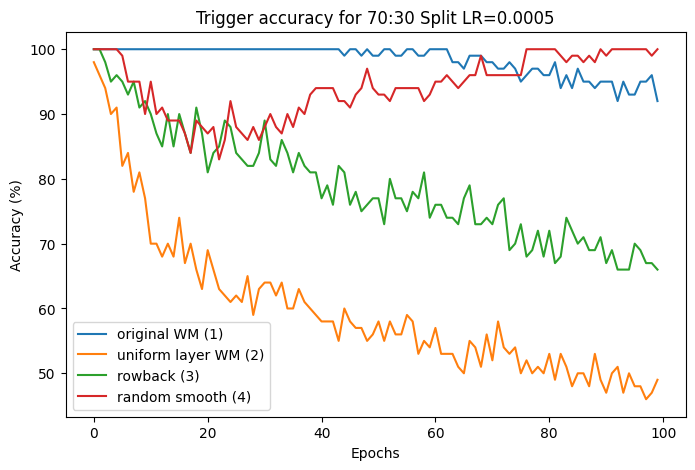

In [51]:
plt.figure(figsize=(8, 5))

plt.plot(range(len(metrics14['trigger_acc'])), metrics14['trigger_acc'], label='original WM (1)')
plt.plot(range(len(metrics15['trigger_acc'])), metrics15['trigger_acc'], label='uniform layer WM (2)')
plt.plot(range(len(metrics16['trigger_acc'])), metrics16['trigger_acc'], label='rowback (3)')

plt.plot(range(len(metrics13['trigger_acc'])), metrics13['trigger_acc'], label='random smooth (4)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Trigger accuracy for 70:30 Split LR=0.0005')
plt.legend()
plt.savefig('incre_trigger_acc_7030_lr0.0005.png')

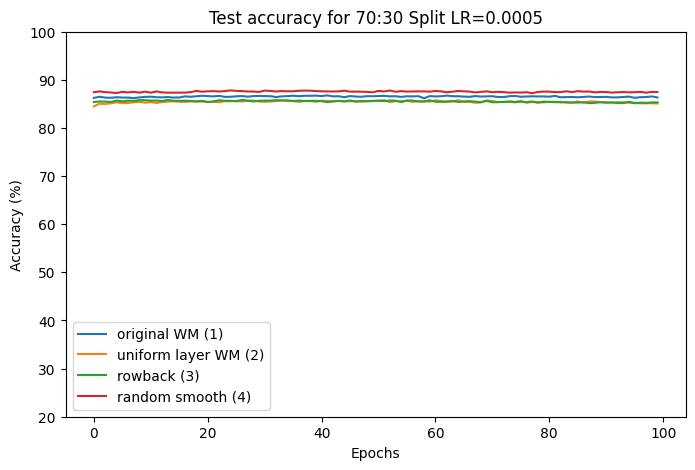

In [52]:
plt.figure(figsize=(8, 5))
plt.plot(range(len(metrics14['val_acc'])), metrics14['val_acc'], label='original WM (1)')
plt.plot(range(len(metrics15['val_acc'])), metrics15['val_acc'], label='uniform layer WM (2)')
plt.plot(range(len(metrics16['val_acc'])), metrics16['val_acc'], label='rowback (3)')

plt.plot(range(len(metrics13['val_acc'])), metrics13['val_acc'], label='random smooth (4)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test accuracy for 70:30 Split LR=0.0005')
plt.ylim([20, 100])
plt.legend()
plt.savefig('incre_test_acc_7030_lr0.0005.png')

lr=0.0001

In [53]:
net17 = ResNet18()
net17.load_state_dict(torch.load('./models/wm_cifar10_certify_random_7030.pth')['model_state_dict'])
net18 = ResNet18()
net18.load_state_dict(torch.load('./checkpoints/resnet18_wm_7030.ckpt'))
net19 = ResNet18()
net19.load_state_dict(torch.load('./checkpoints/resnet18_wm_frozen_7030.ckpt'))
net20 = ResNet18()
net20.load_state_dict(torch.load('./checkpoints/resnet18_wm_rowback_7030.ckpt'))

<All keys matched successfully>

In [54]:
evaluator = Evaluator(net17, torch.nn.CrossEntropyLoss())
print(evaluator.eval(testloader))
print(evaluator.eval(unrelatedloader))

{'loss': 0.6196484971925617, 'accuracy': 87.48}
{'loss': 1.952202699612826e-05, 'accuracy': 100.0}


In [55]:
evaluator = Evaluator(net18, torch.nn.CrossEntropyLoss())
print("Original watermarking scheme")
print(f"Test accuracy {evaluator.eval(testloader)}")
print(f"Watermark accuracy {evaluator.eval(wmloader)}")

Original watermarking scheme
Test accuracy {'loss': 0.4954307278931141, 'accuracy': 86.14}
Watermark accuracy {'loss': 0.00022255992516875266, 'accuracy': 100.0}


In [56]:
evaluator = Evaluator(net19, torch.nn.CrossEntropyLoss())
print("Frozen watermarking scheme")
print(f"Test accuracy {evaluator.eval(testloader)}")
print(f"Watermark accuracy {evaluator.eval(wmloader)}")

Frozen watermarking scheme
Test accuracy {'loss': 0.5337510022163391, 'accuracy': 85.11999999999999}
Watermark accuracy {'loss': 0.0010846880357712506, 'accuracy': 100.0}


In [57]:
evaluator = Evaluator(net20, torch.nn.CrossEntropyLoss())
print("ROWBack watermarking scheme")
print(f"Test accuracy {evaluator.eval(testloader)}")
print(f"Watermark accuracy {evaluator.eval(advwmloader)}")

ROWBack watermarking scheme
Test accuracy {'loss': 0.528250137591362, 'accuracy': 85.41}
Watermark accuracy {'loss': 0.0008671344676986337, 'accuracy': 100.0}


In [58]:
logcmt = f"incre_train_certified_7030"

optimizer17 = torch.optim.SGD(lr=0.0001, params=net17.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer17 = Trainer(net17, criterion, optimizer17, incloader)
evaluator17 = Evaluator(net17, criterion)

metrics17 = train(trainer17, evaluator17, testloader, savename='inccheckpoints/incre_train_cert_7030_lr0.0001', logdir='./runs', logcmt=logcmt, trigger_loader=unrelatedloader, epochs=100)

Start Training...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.48it/s]


Epoch 0 | Time 7s| Train Loss 0.5841 | Train Acc 86.83| Val Loss 0.628 | Val Acc 87.46| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 1 | Time 15s| Train Loss 0.5746 | Train Acc 86.74| Val Loss 0.616 | Val Acc 87.47| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 2 | Time 23s| Train Loss 0.5540 | Train Acc 87.31| Val Loss 0.608 | Val Acc 87.45| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 3 | Time 30s| Train Loss 0.5414 | Train Acc 87.10| Val Loss 0.601 | Val Acc 87.48| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 4 | Time 38s| Train Loss 0.5331 | Train Acc 87.06| Val Loss 0.598 | Val Acc 87.29| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.46it/s]


Epoch 5 | Time 45s| Train Loss 0.5152 | Train Acc 87.52| Val Loss 0.589 | Val Acc 87.43| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 6 | Time 52s| Train Loss 0.5106 | Train Acc 87.43| Val Loss 0.586 | Val Acc 87.50| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 7 | Time 60s| Train Loss 0.5066 | Train Acc 87.31| Val Loss 0.580 | Val Acc 87.47| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 8 | Time 67s| Train Loss 0.5135 | Train Acc 87.21| Val Loss 0.576 | Val Acc 87.58| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 9 | Time 74s| Train Loss 0.4936 | Train Acc 87.58| Val Loss 0.569 | Val Acc 87.36| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 10 | Time 82s| Train Loss 0.4880 | Train Acc 87.47| Val Loss 0.562 | Val Acc 87.54| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 11 | Time 89s| Train Loss 0.4749 | Train Acc 87.69| Val Loss 0.560 | Val Acc 87.39| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.46it/s]


Epoch 12 | Time 97s| Train Loss 0.4621 | Train Acc 87.87| Val Loss 0.554 | Val Acc 87.46| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 13 | Time 104s| Train Loss 0.4557 | Train Acc 87.87| Val Loss 0.546 | Val Acc 87.42| Trigger Loss 0.003 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 14 | Time 111s| Train Loss 0.4587 | Train Acc 87.76| Val Loss 0.548 | Val Acc 87.45| Trigger Loss 0.003 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 15 | Time 119s| Train Loss 0.4402 | Train Acc 87.92| Val Loss 0.541 | Val Acc 87.44| Trigger Loss 0.004 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 16 | Time 126s| Train Loss 0.4413 | Train Acc 87.65| Val Loss 0.539 | Val Acc 87.36| Trigger Loss 0.005 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.46it/s]


Epoch 17 | Time 134s| Train Loss 0.4398 | Train Acc 87.91| Val Loss 0.530 | Val Acc 87.32| Trigger Loss 0.011 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 18 | Time 141s| Train Loss 0.4326 | Train Acc 88.00| Val Loss 0.526 | Val Acc 87.54| Trigger Loss 0.012 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 19 | Time 148s| Train Loss 0.4197 | Train Acc 87.82| Val Loss 0.527 | Val Acc 87.36| Trigger Loss 0.008 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 20 | Time 156s| Train Loss 0.4233 | Train Acc 88.07| Val Loss 0.523 | Val Acc 87.33| Trigger Loss 0.008 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 21 | Time 163s| Train Loss 0.4132 | Train Acc 88.23| Val Loss 0.516 | Val Acc 87.34| Trigger Loss 0.015 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 22 | Time 171s| Train Loss 0.4093 | Train Acc 88.09| Val Loss 0.510 | Val Acc 87.30| Trigger Loss 0.026 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 23 | Time 178s| Train Loss 0.4129 | Train Acc 88.08| Val Loss 0.509 | Val Acc 87.40| Trigger Loss 0.019 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 24 | Time 185s| Train Loss 0.4010 | Train Acc 88.02| Val Loss 0.500 | Val Acc 87.29| Trigger Loss 0.024 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 25 | Time 193s| Train Loss 0.4059 | Train Acc 88.04| Val Loss 0.500 | Val Acc 87.39| Trigger Loss 0.024 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 26 | Time 200s| Train Loss 0.3965 | Train Acc 88.28| Val Loss 0.497 | Val Acc 87.32| Trigger Loss 0.032 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 27 | Time 207s| Train Loss 0.3899 | Train Acc 88.11| Val Loss 0.490 | Val Acc 87.23| Trigger Loss 0.039 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 28 | Time 214s| Train Loss 0.3891 | Train Acc 88.50| Val Loss 0.488 | Val Acc 87.42| Trigger Loss 0.031 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 29 | Time 221s| Train Loss 0.3832 | Train Acc 88.45| Val Loss 0.490 | Val Acc 87.36| Trigger Loss 0.037 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 30 | Time 228s| Train Loss 0.3856 | Train Acc 88.49| Val Loss 0.496 | Val Acc 87.22| Trigger Loss 0.038 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 31 | Time 235s| Train Loss 0.3876 | Train Acc 88.34| Val Loss 0.491 | Val Acc 87.29| Trigger Loss 0.033 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 32 | Time 242s| Train Loss 0.3742 | Train Acc 88.44| Val Loss 0.486 | Val Acc 87.23| Trigger Loss 0.052 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 33 | Time 250s| Train Loss 0.3799 | Train Acc 88.22| Val Loss 0.482 | Val Acc 87.25| Trigger Loss 0.047 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 34 | Time 257s| Train Loss 0.3710 | Train Acc 88.63| Val Loss 0.479 | Val Acc 87.24| Trigger Loss 0.074 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 35 | Time 264s| Train Loss 0.3720 | Train Acc 88.46| Val Loss 0.479 | Val Acc 87.36| Trigger Loss 0.063 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 36 | Time 271s| Train Loss 0.3576 | Train Acc 88.76| Val Loss 0.486 | Val Acc 87.24| Trigger Loss 0.075 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 37 | Time 278s| Train Loss 0.3602 | Train Acc 88.70| Val Loss 0.467 | Val Acc 87.32| Trigger Loss 0.083 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 38 | Time 285s| Train Loss 0.3682 | Train Acc 88.63| Val Loss 0.463 | Val Acc 87.43| Trigger Loss 0.106 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 39 | Time 292s| Train Loss 0.3655 | Train Acc 88.19| Val Loss 0.463 | Val Acc 87.28| Trigger Loss 0.124 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 40 | Time 300s| Train Loss 0.3503 | Train Acc 88.82| Val Loss 0.472 | Val Acc 87.27| Trigger Loss 0.072 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 41 | Time 307s| Train Loss 0.3586 | Train Acc 88.42| Val Loss 0.464 | Val Acc 87.37| Trigger Loss 0.105 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 42 | Time 314s| Train Loss 0.3548 | Train Acc 88.61| Val Loss 0.462 | Val Acc 87.49| Trigger Loss 0.097 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.46it/s]


Epoch 43 | Time 321s| Train Loss 0.3555 | Train Acc 88.72| Val Loss 0.474 | Val Acc 87.21| Trigger Loss 0.084 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 44 | Time 328s| Train Loss 0.3538 | Train Acc 88.58| Val Loss 0.466 | Val Acc 87.41| Trigger Loss 0.102 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 45 | Time 335s| Train Loss 0.3551 | Train Acc 88.69| Val Loss 0.463 | Val Acc 87.34| Trigger Loss 0.134 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 46 | Time 342s| Train Loss 0.3458 | Train Acc 88.64| Val Loss 0.451 | Val Acc 87.37| Trigger Loss 0.136 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 47 | Time 350s| Train Loss 0.3519 | Train Acc 88.60| Val Loss 0.452 | Val Acc 87.42| Trigger Loss 0.125 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 48 | Time 357s| Train Loss 0.3435 | Train Acc 88.89| Val Loss 0.457 | Val Acc 87.42| Trigger Loss 0.152 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 49 | Time 364s| Train Loss 0.3401 | Train Acc 88.90| Val Loss 0.457 | Val Acc 87.37| Trigger Loss 0.127 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 50 | Time 371s| Train Loss 0.3446 | Train Acc 88.76| Val Loss 0.452 | Val Acc 87.36| Trigger Loss 0.142 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 51 | Time 378s| Train Loss 0.3387 | Train Acc 89.03| Val Loss 0.463 | Val Acc 87.31| Trigger Loss 0.123 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 52 | Time 385s| Train Loss 0.3380 | Train Acc 89.00| Val Loss 0.455 | Val Acc 87.33| Trigger Loss 0.152 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 53 | Time 393s| Train Loss 0.3341 | Train Acc 89.10| Val Loss 0.464 | Val Acc 87.29| Trigger Loss 0.101 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 54 | Time 400s| Train Loss 0.3417 | Train Acc 88.73| Val Loss 0.453 | Val Acc 87.33| Trigger Loss 0.149 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 55 | Time 407s| Train Loss 0.3390 | Train Acc 89.06| Val Loss 0.453 | Val Acc 87.27| Trigger Loss 0.149 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 56 | Time 414s| Train Loss 0.3349 | Train Acc 88.93| Val Loss 0.436 | Val Acc 87.40| Trigger Loss 0.237 | Trigger Acc 89.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 57 | Time 421s| Train Loss 0.3326 | Train Acc 88.98| Val Loss 0.443 | Val Acc 87.29| Trigger Loss 0.203 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 58 | Time 428s| Train Loss 0.3276 | Train Acc 89.00| Val Loss 0.449 | Val Acc 87.34| Trigger Loss 0.181 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 59 | Time 435s| Train Loss 0.3291 | Train Acc 89.25| Val Loss 0.453 | Val Acc 87.31| Trigger Loss 0.153 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 60 | Time 442s| Train Loss 0.3335 | Train Acc 88.95| Val Loss 0.458 | Val Acc 87.34| Trigger Loss 0.142 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 61 | Time 450s| Train Loss 0.3278 | Train Acc 89.37| Val Loss 0.450 | Val Acc 87.31| Trigger Loss 0.149 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 62 | Time 457s| Train Loss 0.3315 | Train Acc 89.09| Val Loss 0.443 | Val Acc 87.34| Trigger Loss 0.155 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 63 | Time 464s| Train Loss 0.3200 | Train Acc 89.40| Val Loss 0.439 | Val Acc 87.36| Trigger Loss 0.210 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 64 | Time 471s| Train Loss 0.3251 | Train Acc 89.31| Val Loss 0.435 | Val Acc 87.40| Trigger Loss 0.223 | Trigger Acc 89.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 65 | Time 478s| Train Loss 0.3260 | Train Acc 89.21| Val Loss 0.439 | Val Acc 87.39| Trigger Loss 0.212 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 66 | Time 485s| Train Loss 0.3164 | Train Acc 89.60| Val Loss 0.441 | Val Acc 87.31| Trigger Loss 0.213 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 67 | Time 492s| Train Loss 0.3188 | Train Acc 89.56| Val Loss 0.432 | Val Acc 87.47| Trigger Loss 0.229 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 68 | Time 499s| Train Loss 0.3146 | Train Acc 89.62| Val Loss 0.437 | Val Acc 87.32| Trigger Loss 0.206 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 69 | Time 507s| Train Loss 0.3199 | Train Acc 89.42| Val Loss 0.438 | Val Acc 87.47| Trigger Loss 0.214 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 70 | Time 514s| Train Loss 0.3191 | Train Acc 89.37| Val Loss 0.441 | Val Acc 87.27| Trigger Loss 0.206 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 71 | Time 521s| Train Loss 0.3243 | Train Acc 89.06| Val Loss 0.450 | Val Acc 87.23| Trigger Loss 0.168 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 72 | Time 528s| Train Loss 0.3159 | Train Acc 89.41| Val Loss 0.441 | Val Acc 87.37| Trigger Loss 0.198 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 73 | Time 535s| Train Loss 0.3148 | Train Acc 89.35| Val Loss 0.426 | Val Acc 87.46| Trigger Loss 0.251 | Trigger Acc 89.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 74 | Time 542s| Train Loss 0.3194 | Train Acc 89.27| Val Loss 0.435 | Val Acc 87.38| Trigger Loss 0.215 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 75 | Time 550s| Train Loss 0.3180 | Train Acc 89.31| Val Loss 0.441 | Val Acc 87.33| Trigger Loss 0.168 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 76 | Time 557s| Train Loss 0.3215 | Train Acc 89.68| Val Loss 0.434 | Val Acc 87.52| Trigger Loss 0.177 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 77 | Time 564s| Train Loss 0.3166 | Train Acc 89.45| Val Loss 0.442 | Val Acc 87.34| Trigger Loss 0.185 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 78 | Time 571s| Train Loss 0.3101 | Train Acc 89.72| Val Loss 0.437 | Val Acc 87.32| Trigger Loss 0.192 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 79 | Time 578s| Train Loss 0.3122 | Train Acc 89.41| Val Loss 0.442 | Val Acc 87.20| Trigger Loss 0.180 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 80 | Time 585s| Train Loss 0.3085 | Train Acc 89.75| Val Loss 0.435 | Val Acc 87.43| Trigger Loss 0.199 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 81 | Time 593s| Train Loss 0.3096 | Train Acc 89.51| Val Loss 0.430 | Val Acc 87.47| Trigger Loss 0.195 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 82 | Time 600s| Train Loss 0.3108 | Train Acc 89.61| Val Loss 0.435 | Val Acc 87.38| Trigger Loss 0.199 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 83 | Time 607s| Train Loss 0.3092 | Train Acc 89.73| Val Loss 0.430 | Val Acc 87.44| Trigger Loss 0.196 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 84 | Time 614s| Train Loss 0.3094 | Train Acc 89.61| Val Loss 0.427 | Val Acc 87.52| Trigger Loss 0.303 | Trigger Acc 87.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 85 | Time 621s| Train Loss 0.3005 | Train Acc 89.93| Val Loss 0.426 | Val Acc 87.36| Trigger Loss 0.261 | Trigger Acc 88.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 86 | Time 628s| Train Loss 0.3034 | Train Acc 89.98| Val Loss 0.424 | Val Acc 87.39| Trigger Loss 0.255 | Trigger Acc 88.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 87 | Time 635s| Train Loss 0.3014 | Train Acc 89.73| Val Loss 0.431 | Val Acc 87.52| Trigger Loss 0.187 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 88 | Time 642s| Train Loss 0.3110 | Train Acc 89.43| Val Loss 0.431 | Val Acc 87.47| Trigger Loss 0.193 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 89 | Time 650s| Train Loss 0.3085 | Train Acc 89.71| Val Loss 0.434 | Val Acc 87.46| Trigger Loss 0.184 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 90 | Time 657s| Train Loss 0.3081 | Train Acc 89.54| Val Loss 0.428 | Val Acc 87.39| Trigger Loss 0.204 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 91 | Time 664s| Train Loss 0.3089 | Train Acc 89.68| Val Loss 0.438 | Val Acc 87.32| Trigger Loss 0.174 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 92 | Time 671s| Train Loss 0.3111 | Train Acc 89.53| Val Loss 0.442 | Val Acc 87.44| Trigger Loss 0.147 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 93 | Time 678s| Train Loss 0.3056 | Train Acc 89.53| Val Loss 0.428 | Val Acc 87.40| Trigger Loss 0.220 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 94 | Time 685s| Train Loss 0.3042 | Train Acc 89.85| Val Loss 0.443 | Val Acc 87.35| Trigger Loss 0.204 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 95 | Time 692s| Train Loss 0.3009 | Train Acc 89.59| Val Loss 0.425 | Val Acc 87.58| Trigger Loss 0.222 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 96 | Time 700s| Train Loss 0.3031 | Train Acc 89.50| Val Loss 0.443 | Val Acc 87.23| Trigger Loss 0.172 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 97 | Time 707s| Train Loss 0.3100 | Train Acc 89.55| Val Loss 0.429 | Val Acc 87.51| Trigger Loss 0.183 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 98 | Time 714s| Train Loss 0.2981 | Train Acc 90.02| Val Loss 0.431 | Val Acc 87.54| Trigger Loss 0.193 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 99 | Time 721s| Train Loss 0.2967 | Train Acc 89.99| Val Loss 0.425 | Val Acc 87.47| Trigger Loss 0.196 | Trigger Acc 92.00


In [59]:
logcmt = f"incre_train_baseline_7030"

optimizer18 = torch.optim.SGD(lr=0.0001, params=net18.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer18 = Trainer(net18, criterion, optimizer18, incloader)
evaluator18 = Evaluator(net18, criterion)

metrics18 = train(trainer18, evaluator18, testloader, savename='inccheckpoints/incre_train_baseline_7030_lr0.0001', logdir='./runs', logcmt=logcmt, trigger_loader=wmloader, epochs=100)

Start Training...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 0 | Time 7s| Train Loss 0.4655 | Train Acc 86.45| Val Loss 0.498 | Val Acc 86.10| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 1 | Time 15s| Train Loss 0.4630 | Train Acc 86.33| Val Loss 0.493 | Val Acc 86.36| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 2 | Time 23s| Train Loss 0.4581 | Train Acc 86.63| Val Loss 0.491 | Val Acc 86.21| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 3 | Time 30s| Train Loss 0.4514 | Train Acc 86.53| Val Loss 0.485 | Val Acc 86.31| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 4 | Time 38s| Train Loss 0.4322 | Train Acc 86.83| Val Loss 0.482 | Val Acc 86.33| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 5 | Time 45s| Train Loss 0.4285 | Train Acc 87.03| Val Loss 0.480 | Val Acc 86.33| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 6 | Time 52s| Train Loss 0.4360 | Train Acc 86.80| Val Loss 0.481 | Val Acc 86.25| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 7 | Time 60s| Train Loss 0.4280 | Train Acc 86.67| Val Loss 0.478 | Val Acc 86.41| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 8 | Time 67s| Train Loss 0.4252 | Train Acc 87.23| Val Loss 0.474 | Val Acc 86.43| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 9 | Time 75s| Train Loss 0.4215 | Train Acc 86.74| Val Loss 0.473 | Val Acc 86.40| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 10 | Time 82s| Train Loss 0.4106 | Train Acc 87.38| Val Loss 0.470 | Val Acc 86.38| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 11 | Time 89s| Train Loss 0.4205 | Train Acc 86.98| Val Loss 0.467 | Val Acc 86.43| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 12 | Time 97s| Train Loss 0.4094 | Train Acc 87.31| Val Loss 0.467 | Val Acc 86.33| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 13 | Time 104s| Train Loss 0.4041 | Train Acc 87.16| Val Loss 0.466 | Val Acc 86.35| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 14 | Time 112s| Train Loss 0.4072 | Train Acc 87.40| Val Loss 0.463 | Val Acc 86.30| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 15 | Time 119s| Train Loss 0.3967 | Train Acc 87.18| Val Loss 0.461 | Val Acc 86.34| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 16 | Time 127s| Train Loss 0.3954 | Train Acc 87.28| Val Loss 0.460 | Val Acc 86.44| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 17 | Time 134s| Train Loss 0.3984 | Train Acc 87.53| Val Loss 0.458 | Val Acc 86.36| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 18 | Time 141s| Train Loss 0.3939 | Train Acc 87.61| Val Loss 0.455 | Val Acc 86.41| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 19 | Time 149s| Train Loss 0.3914 | Train Acc 87.48| Val Loss 0.456 | Val Acc 86.42| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 20 | Time 156s| Train Loss 0.3904 | Train Acc 87.64| Val Loss 0.455 | Val Acc 86.35| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 21 | Time 164s| Train Loss 0.3803 | Train Acc 87.85| Val Loss 0.455 | Val Acc 86.45| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 22 | Time 171s| Train Loss 0.3807 | Train Acc 87.60| Val Loss 0.454 | Val Acc 86.27| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 23 | Time 178s| Train Loss 0.3787 | Train Acc 87.96| Val Loss 0.452 | Val Acc 86.25| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 24 | Time 186s| Train Loss 0.3750 | Train Acc 87.90| Val Loss 0.449 | Val Acc 86.35| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 25 | Time 193s| Train Loss 0.3682 | Train Acc 88.12| Val Loss 0.451 | Val Acc 86.37| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 26 | Time 200s| Train Loss 0.3737 | Train Acc 87.86| Val Loss 0.447 | Val Acc 86.35| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 27 | Time 208s| Train Loss 0.3783 | Train Acc 87.73| Val Loss 0.447 | Val Acc 86.39| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.32it/s]


Epoch 28 | Time 215s| Train Loss 0.3706 | Train Acc 87.86| Val Loss 0.447 | Val Acc 86.39| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 29 | Time 223s| Train Loss 0.3694 | Train Acc 87.82| Val Loss 0.445 | Val Acc 86.35| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 30 | Time 230s| Train Loss 0.3619 | Train Acc 88.14| Val Loss 0.445 | Val Acc 86.35| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 31 | Time 238s| Train Loss 0.3694 | Train Acc 87.81| Val Loss 0.443 | Val Acc 86.42| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 32 | Time 245s| Train Loss 0.3669 | Train Acc 88.06| Val Loss 0.442 | Val Acc 86.33| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 33 | Time 252s| Train Loss 0.3650 | Train Acc 87.96| Val Loss 0.443 | Val Acc 86.31| Trigger Loss 0.003 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 34 | Time 260s| Train Loss 0.3607 | Train Acc 88.12| Val Loss 0.442 | Val Acc 86.27| Trigger Loss 0.003 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 35 | Time 267s| Train Loss 0.3603 | Train Acc 88.02| Val Loss 0.440 | Val Acc 86.38| Trigger Loss 0.003 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 36 | Time 274s| Train Loss 0.3583 | Train Acc 88.24| Val Loss 0.440 | Val Acc 86.40| Trigger Loss 0.003 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 37 | Time 282s| Train Loss 0.3552 | Train Acc 88.24| Val Loss 0.442 | Val Acc 86.31| Trigger Loss 0.003 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 38 | Time 289s| Train Loss 0.3558 | Train Acc 87.84| Val Loss 0.436 | Val Acc 86.41| Trigger Loss 0.003 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 39 | Time 297s| Train Loss 0.3576 | Train Acc 88.07| Val Loss 0.437 | Val Acc 86.34| Trigger Loss 0.003 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 40 | Time 304s| Train Loss 0.3564 | Train Acc 88.24| Val Loss 0.437 | Val Acc 86.44| Trigger Loss 0.003 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 41 | Time 312s| Train Loss 0.3535 | Train Acc 88.20| Val Loss 0.435 | Val Acc 86.36| Trigger Loss 0.004 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 42 | Time 319s| Train Loss 0.3491 | Train Acc 88.25| Val Loss 0.434 | Val Acc 86.41| Trigger Loss 0.004 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 43 | Time 326s| Train Loss 0.3503 | Train Acc 88.42| Val Loss 0.434 | Val Acc 86.31| Trigger Loss 0.004 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 44 | Time 334s| Train Loss 0.3485 | Train Acc 88.62| Val Loss 0.433 | Val Acc 86.35| Trigger Loss 0.004 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 45 | Time 341s| Train Loss 0.3444 | Train Acc 88.46| Val Loss 0.432 | Val Acc 86.36| Trigger Loss 0.004 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 46 | Time 349s| Train Loss 0.3454 | Train Acc 88.20| Val Loss 0.433 | Val Acc 86.37| Trigger Loss 0.004 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 47 | Time 356s| Train Loss 0.3415 | Train Acc 88.32| Val Loss 0.431 | Val Acc 86.49| Trigger Loss 0.005 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 48 | Time 363s| Train Loss 0.3480 | Train Acc 88.41| Val Loss 0.431 | Val Acc 86.46| Trigger Loss 0.004 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 49 | Time 371s| Train Loss 0.3430 | Train Acc 88.56| Val Loss 0.431 | Val Acc 86.44| Trigger Loss 0.005 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 50 | Time 378s| Train Loss 0.3415 | Train Acc 88.36| Val Loss 0.430 | Val Acc 86.43| Trigger Loss 0.005 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 51 | Time 386s| Train Loss 0.3325 | Train Acc 88.76| Val Loss 0.432 | Val Acc 86.40| Trigger Loss 0.006 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 52 | Time 393s| Train Loss 0.3395 | Train Acc 88.50| Val Loss 0.431 | Val Acc 86.51| Trigger Loss 0.006 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 53 | Time 401s| Train Loss 0.3300 | Train Acc 88.72| Val Loss 0.429 | Val Acc 86.44| Trigger Loss 0.006 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 54 | Time 408s| Train Loss 0.3376 | Train Acc 88.72| Val Loss 0.429 | Val Acc 86.44| Trigger Loss 0.006 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 55 | Time 415s| Train Loss 0.3341 | Train Acc 88.63| Val Loss 0.427 | Val Acc 86.37| Trigger Loss 0.006 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 56 | Time 423s| Train Loss 0.3327 | Train Acc 88.71| Val Loss 0.428 | Val Acc 86.38| Trigger Loss 0.006 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 57 | Time 430s| Train Loss 0.3346 | Train Acc 88.53| Val Loss 0.427 | Val Acc 86.49| Trigger Loss 0.006 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 58 | Time 438s| Train Loss 0.3352 | Train Acc 88.50| Val Loss 0.427 | Val Acc 86.44| Trigger Loss 0.006 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 59 | Time 445s| Train Loss 0.3295 | Train Acc 88.78| Val Loss 0.427 | Val Acc 86.36| Trigger Loss 0.006 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 60 | Time 452s| Train Loss 0.3278 | Train Acc 88.82| Val Loss 0.425 | Val Acc 86.40| Trigger Loss 0.007 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 61 | Time 460s| Train Loss 0.3310 | Train Acc 88.42| Val Loss 0.426 | Val Acc 86.40| Trigger Loss 0.007 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.30it/s]


Epoch 62 | Time 467s| Train Loss 0.3237 | Train Acc 88.88| Val Loss 0.424 | Val Acc 86.42| Trigger Loss 0.007 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 63 | Time 475s| Train Loss 0.3246 | Train Acc 88.92| Val Loss 0.425 | Val Acc 86.36| Trigger Loss 0.007 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 64 | Time 482s| Train Loss 0.3254 | Train Acc 88.97| Val Loss 0.426 | Val Acc 86.53| Trigger Loss 0.008 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 65 | Time 489s| Train Loss 0.3270 | Train Acc 88.67| Val Loss 0.424 | Val Acc 86.35| Trigger Loss 0.008 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 66 | Time 497s| Train Loss 0.3304 | Train Acc 88.91| Val Loss 0.426 | Val Acc 86.49| Trigger Loss 0.008 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 67 | Time 504s| Train Loss 0.3211 | Train Acc 89.18| Val Loss 0.423 | Val Acc 86.39| Trigger Loss 0.008 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 68 | Time 512s| Train Loss 0.3251 | Train Acc 89.05| Val Loss 0.423 | Val Acc 86.45| Trigger Loss 0.008 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 69 | Time 519s| Train Loss 0.3242 | Train Acc 88.92| Val Loss 0.423 | Val Acc 86.48| Trigger Loss 0.008 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 70 | Time 526s| Train Loss 0.3297 | Train Acc 88.88| Val Loss 0.425 | Val Acc 86.34| Trigger Loss 0.008 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 71 | Time 534s| Train Loss 0.3224 | Train Acc 88.84| Val Loss 0.422 | Val Acc 86.41| Trigger Loss 0.008 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 72 | Time 541s| Train Loss 0.3281 | Train Acc 88.53| Val Loss 0.424 | Val Acc 86.49| Trigger Loss 0.008 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 73 | Time 549s| Train Loss 0.3165 | Train Acc 89.20| Val Loss 0.422 | Val Acc 86.36| Trigger Loss 0.009 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 74 | Time 556s| Train Loss 0.3182 | Train Acc 89.21| Val Loss 0.425 | Val Acc 86.44| Trigger Loss 0.010 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 75 | Time 563s| Train Loss 0.3160 | Train Acc 89.13| Val Loss 0.423 | Val Acc 86.50| Trigger Loss 0.009 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 76 | Time 571s| Train Loss 0.3192 | Train Acc 89.15| Val Loss 0.420 | Val Acc 86.47| Trigger Loss 0.010 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 77 | Time 578s| Train Loss 0.3191 | Train Acc 88.98| Val Loss 0.419 | Val Acc 86.44| Trigger Loss 0.011 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 78 | Time 586s| Train Loss 0.3173 | Train Acc 89.26| Val Loss 0.422 | Val Acc 86.58| Trigger Loss 0.010 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 79 | Time 593s| Train Loss 0.3194 | Train Acc 89.02| Val Loss 0.420 | Val Acc 86.42| Trigger Loss 0.010 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 80 | Time 601s| Train Loss 0.3182 | Train Acc 89.11| Val Loss 0.421 | Val Acc 86.52| Trigger Loss 0.011 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 81 | Time 608s| Train Loss 0.3149 | Train Acc 89.05| Val Loss 0.419 | Val Acc 86.44| Trigger Loss 0.010 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 82 | Time 615s| Train Loss 0.3158 | Train Acc 89.22| Val Loss 0.420 | Val Acc 86.47| Trigger Loss 0.012 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 83 | Time 623s| Train Loss 0.3120 | Train Acc 89.09| Val Loss 0.420 | Val Acc 86.41| Trigger Loss 0.011 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 84 | Time 630s| Train Loss 0.3094 | Train Acc 89.56| Val Loss 0.421 | Val Acc 86.46| Trigger Loss 0.011 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 85 | Time 638s| Train Loss 0.3105 | Train Acc 89.40| Val Loss 0.418 | Val Acc 86.52| Trigger Loss 0.011 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 86 | Time 645s| Train Loss 0.3089 | Train Acc 89.34| Val Loss 0.421 | Val Acc 86.44| Trigger Loss 0.012 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 87 | Time 652s| Train Loss 0.3130 | Train Acc 89.19| Val Loss 0.418 | Val Acc 86.50| Trigger Loss 0.012 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 88 | Time 660s| Train Loss 0.3020 | Train Acc 89.67| Val Loss 0.419 | Val Acc 86.62| Trigger Loss 0.012 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 89 | Time 667s| Train Loss 0.3114 | Train Acc 89.46| Val Loss 0.418 | Val Acc 86.60| Trigger Loss 0.012 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 90 | Time 675s| Train Loss 0.3065 | Train Acc 89.55| Val Loss 0.418 | Val Acc 86.49| Trigger Loss 0.013 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 91 | Time 682s| Train Loss 0.3137 | Train Acc 89.27| Val Loss 0.418 | Val Acc 86.56| Trigger Loss 0.012 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 92 | Time 690s| Train Loss 0.3102 | Train Acc 89.00| Val Loss 0.417 | Val Acc 86.73| Trigger Loss 0.013 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 93 | Time 697s| Train Loss 0.3086 | Train Acc 89.34| Val Loss 0.417 | Val Acc 86.60| Trigger Loss 0.013 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 94 | Time 704s| Train Loss 0.3054 | Train Acc 89.52| Val Loss 0.417 | Val Acc 86.58| Trigger Loss 0.014 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 95 | Time 712s| Train Loss 0.3092 | Train Acc 89.34| Val Loss 0.418 | Val Acc 86.61| Trigger Loss 0.012 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 96 | Time 719s| Train Loss 0.3060 | Train Acc 89.30| Val Loss 0.416 | Val Acc 86.64| Trigger Loss 0.013 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 97 | Time 727s| Train Loss 0.2980 | Train Acc 89.65| Val Loss 0.415 | Val Acc 86.67| Trigger Loss 0.012 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 98 | Time 734s| Train Loss 0.3018 | Train Acc 89.63| Val Loss 0.417 | Val Acc 86.72| Trigger Loss 0.013 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 99 | Time 741s| Train Loss 0.3017 | Train Acc 89.52| Val Loss 0.416 | Val Acc 86.58| Trigger Loss 0.013 | Trigger Acc 100.00


In [60]:
logcmt = f"incre_train_baseline_frozen_7030"

optimizer19 = torch.optim.SGD(lr=0.0001, params=net19.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer19 = Trainer(net19, criterion, optimizer19, incloader)
evaluator19 = Evaluator(net19, criterion)
metrics19 = train(trainer19, evaluator19, testloader, savename='inccheckpoints/incre_train_baseline_frozen_7030_lr0.0001', logdir='./runs', logcmt=logcmt, trigger_loader=wmloader, epochs=100)

Start Training...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 0 | Time 7s| Train Loss 0.4989 | Train Acc 85.22| Val Loss 0.530 | Val Acc 85.30| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 1 | Time 15s| Train Loss 0.4861 | Train Acc 85.30| Val Loss 0.526 | Val Acc 85.25| Trigger Loss 0.003 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 2 | Time 23s| Train Loss 0.4719 | Train Acc 85.52| Val Loss 0.523 | Val Acc 85.28| Trigger Loss 0.005 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 3 | Time 30s| Train Loss 0.4736 | Train Acc 85.41| Val Loss 0.519 | Val Acc 85.27| Trigger Loss 0.008 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 4 | Time 38s| Train Loss 0.4550 | Train Acc 86.09| Val Loss 0.515 | Val Acc 85.13| Trigger Loss 0.011 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 5 | Time 45s| Train Loss 0.4583 | Train Acc 85.92| Val Loss 0.515 | Val Acc 85.35| Trigger Loss 0.019 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 6 | Time 52s| Train Loss 0.4579 | Train Acc 85.45| Val Loss 0.511 | Val Acc 85.28| Trigger Loss 0.025 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 7 | Time 60s| Train Loss 0.4445 | Train Acc 85.87| Val Loss 0.509 | Val Acc 85.38| Trigger Loss 0.032 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 8 | Time 67s| Train Loss 0.4453 | Train Acc 85.70| Val Loss 0.504 | Val Acc 85.42| Trigger Loss 0.038 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 9 | Time 75s| Train Loss 0.4390 | Train Acc 85.86| Val Loss 0.504 | Val Acc 85.22| Trigger Loss 0.050 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 10 | Time 82s| Train Loss 0.4325 | Train Acc 86.14| Val Loss 0.504 | Val Acc 85.29| Trigger Loss 0.057 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 11 | Time 89s| Train Loss 0.4289 | Train Acc 86.11| Val Loss 0.503 | Val Acc 85.27| Trigger Loss 0.069 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 12 | Time 96s| Train Loss 0.4309 | Train Acc 86.32| Val Loss 0.502 | Val Acc 85.27| Trigger Loss 0.083 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.32it/s]


Epoch 13 | Time 103s| Train Loss 0.4275 | Train Acc 86.16| Val Loss 0.499 | Val Acc 85.19| Trigger Loss 0.110 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 14 | Time 110s| Train Loss 0.4256 | Train Acc 86.45| Val Loss 0.498 | Val Acc 85.38| Trigger Loss 0.106 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 15 | Time 118s| Train Loss 0.4133 | Train Acc 86.53| Val Loss 0.497 | Val Acc 85.17| Trigger Loss 0.115 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 16 | Time 125s| Train Loss 0.4177 | Train Acc 86.43| Val Loss 0.496 | Val Acc 85.34| Trigger Loss 0.118 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 17 | Time 132s| Train Loss 0.4201 | Train Acc 86.47| Val Loss 0.494 | Val Acc 85.29| Trigger Loss 0.131 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 18 | Time 139s| Train Loss 0.4124 | Train Acc 86.41| Val Loss 0.494 | Val Acc 85.20| Trigger Loss 0.139 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 19 | Time 146s| Train Loss 0.4198 | Train Acc 86.48| Val Loss 0.493 | Val Acc 85.33| Trigger Loss 0.165 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 20 | Time 153s| Train Loss 0.4063 | Train Acc 86.93| Val Loss 0.494 | Val Acc 85.04| Trigger Loss 0.178 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 21 | Time 161s| Train Loss 0.4077 | Train Acc 86.50| Val Loss 0.492 | Val Acc 85.28| Trigger Loss 0.194 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 22 | Time 168s| Train Loss 0.4054 | Train Acc 86.79| Val Loss 0.491 | Val Acc 85.17| Trigger Loss 0.203 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 23 | Time 175s| Train Loss 0.3967 | Train Acc 86.69| Val Loss 0.489 | Val Acc 85.21| Trigger Loss 0.200 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 24 | Time 182s| Train Loss 0.3939 | Train Acc 87.03| Val Loss 0.488 | Val Acc 85.28| Trigger Loss 0.217 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 25 | Time 189s| Train Loss 0.3941 | Train Acc 86.81| Val Loss 0.487 | Val Acc 85.31| Trigger Loss 0.234 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.31it/s]


Epoch 26 | Time 196s| Train Loss 0.3959 | Train Acc 86.99| Val Loss 0.487 | Val Acc 85.27| Trigger Loss 0.238 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 27 | Time 204s| Train Loss 0.3884 | Train Acc 87.12| Val Loss 0.485 | Val Acc 85.33| Trigger Loss 0.244 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 28 | Time 211s| Train Loss 0.3908 | Train Acc 86.89| Val Loss 0.484 | Val Acc 85.32| Trigger Loss 0.269 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 29 | Time 218s| Train Loss 0.3922 | Train Acc 87.12| Val Loss 0.484 | Val Acc 85.39| Trigger Loss 0.269 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 30 | Time 225s| Train Loss 0.3895 | Train Acc 87.06| Val Loss 0.482 | Val Acc 85.25| Trigger Loss 0.282 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 31 | Time 232s| Train Loss 0.3867 | Train Acc 86.93| Val Loss 0.484 | Val Acc 85.29| Trigger Loss 0.301 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 32 | Time 239s| Train Loss 0.3924 | Train Acc 86.81| Val Loss 0.481 | Val Acc 85.29| Trigger Loss 0.298 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 33 | Time 247s| Train Loss 0.3773 | Train Acc 87.43| Val Loss 0.479 | Val Acc 85.37| Trigger Loss 0.308 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 34 | Time 254s| Train Loss 0.3836 | Train Acc 87.19| Val Loss 0.481 | Val Acc 85.29| Trigger Loss 0.309 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 35 | Time 261s| Train Loss 0.3786 | Train Acc 87.11| Val Loss 0.478 | Val Acc 85.32| Trigger Loss 0.291 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 36 | Time 268s| Train Loss 0.3848 | Train Acc 87.03| Val Loss 0.477 | Val Acc 85.28| Trigger Loss 0.311 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 37 | Time 275s| Train Loss 0.3780 | Train Acc 87.23| Val Loss 0.477 | Val Acc 85.36| Trigger Loss 0.329 | Trigger Acc 89.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 38 | Time 282s| Train Loss 0.3735 | Train Acc 87.38| Val Loss 0.476 | Val Acc 85.30| Trigger Loss 0.327 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 39 | Time 290s| Train Loss 0.3757 | Train Acc 87.39| Val Loss 0.476 | Val Acc 85.36| Trigger Loss 0.341 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 40 | Time 297s| Train Loss 0.3728 | Train Acc 87.24| Val Loss 0.477 | Val Acc 85.29| Trigger Loss 0.350 | Trigger Acc 88.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 41 | Time 304s| Train Loss 0.3668 | Train Acc 87.48| Val Loss 0.475 | Val Acc 85.35| Trigger Loss 0.360 | Trigger Acc 89.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 42 | Time 311s| Train Loss 0.3692 | Train Acc 87.57| Val Loss 0.474 | Val Acc 85.39| Trigger Loss 0.384 | Trigger Acc 88.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 43 | Time 318s| Train Loss 0.3736 | Train Acc 87.31| Val Loss 0.476 | Val Acc 85.47| Trigger Loss 0.379 | Trigger Acc 86.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 44 | Time 325s| Train Loss 0.3693 | Train Acc 87.61| Val Loss 0.475 | Val Acc 85.41| Trigger Loss 0.399 | Trigger Acc 85.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 45 | Time 333s| Train Loss 0.3696 | Train Acc 87.47| Val Loss 0.473 | Val Acc 85.46| Trigger Loss 0.387 | Trigger Acc 88.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 46 | Time 340s| Train Loss 0.3621 | Train Acc 87.69| Val Loss 0.473 | Val Acc 85.19| Trigger Loss 0.417 | Trigger Acc 84.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 47 | Time 347s| Train Loss 0.3611 | Train Acc 87.96| Val Loss 0.475 | Val Acc 85.34| Trigger Loss 0.445 | Trigger Acc 85.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 48 | Time 354s| Train Loss 0.3607 | Train Acc 87.66| Val Loss 0.472 | Val Acc 85.44| Trigger Loss 0.429 | Trigger Acc 83.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 49 | Time 361s| Train Loss 0.3557 | Train Acc 88.04| Val Loss 0.473 | Val Acc 85.43| Trigger Loss 0.443 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 50 | Time 368s| Train Loss 0.3596 | Train Acc 87.85| Val Loss 0.473 | Val Acc 85.34| Trigger Loss 0.434 | Trigger Acc 83.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.23it/s]


Epoch 51 | Time 376s| Train Loss 0.3560 | Train Acc 87.76| Val Loss 0.472 | Val Acc 85.38| Trigger Loss 0.433 | Trigger Acc 84.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 52 | Time 383s| Train Loss 0.3594 | Train Acc 87.92| Val Loss 0.473 | Val Acc 85.45| Trigger Loss 0.429 | Trigger Acc 85.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 53 | Time 390s| Train Loss 0.3565 | Train Acc 87.77| Val Loss 0.472 | Val Acc 85.46| Trigger Loss 0.434 | Trigger Acc 85.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 54 | Time 397s| Train Loss 0.3521 | Train Acc 87.90| Val Loss 0.473 | Val Acc 85.42| Trigger Loss 0.461 | Trigger Acc 83.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 55 | Time 404s| Train Loss 0.3557 | Train Acc 87.91| Val Loss 0.470 | Val Acc 85.47| Trigger Loss 0.458 | Trigger Acc 84.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 56 | Time 411s| Train Loss 0.3542 | Train Acc 88.02| Val Loss 0.470 | Val Acc 85.44| Trigger Loss 0.453 | Trigger Acc 84.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 57 | Time 418s| Train Loss 0.3450 | Train Acc 88.04| Val Loss 0.470 | Val Acc 85.47| Trigger Loss 0.501 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 58 | Time 426s| Train Loss 0.3536 | Train Acc 88.02| Val Loss 0.468 | Val Acc 85.44| Trigger Loss 0.506 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 59 | Time 433s| Train Loss 0.3574 | Train Acc 87.70| Val Loss 0.468 | Val Acc 85.47| Trigger Loss 0.487 | Trigger Acc 81.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 60 | Time 440s| Train Loss 0.3511 | Train Acc 87.86| Val Loss 0.470 | Val Acc 85.55| Trigger Loss 0.474 | Trigger Acc 84.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 61 | Time 447s| Train Loss 0.3511 | Train Acc 87.98| Val Loss 0.467 | Val Acc 85.50| Trigger Loss 0.471 | Trigger Acc 83.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 62 | Time 454s| Train Loss 0.3406 | Train Acc 88.36| Val Loss 0.467 | Val Acc 85.41| Trigger Loss 0.479 | Trigger Acc 85.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 63 | Time 461s| Train Loss 0.3456 | Train Acc 88.07| Val Loss 0.469 | Val Acc 85.50| Trigger Loss 0.466 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 64 | Time 469s| Train Loss 0.3491 | Train Acc 88.07| Val Loss 0.469 | Val Acc 85.38| Trigger Loss 0.487 | Trigger Acc 81.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 65 | Time 476s| Train Loss 0.3455 | Train Acc 88.15| Val Loss 0.466 | Val Acc 85.53| Trigger Loss 0.459 | Trigger Acc 83.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 66 | Time 483s| Train Loss 0.3467 | Train Acc 88.22| Val Loss 0.466 | Val Acc 85.50| Trigger Loss 0.487 | Trigger Acc 83.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 67 | Time 490s| Train Loss 0.3486 | Train Acc 88.02| Val Loss 0.467 | Val Acc 85.39| Trigger Loss 0.519 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 68 | Time 497s| Train Loss 0.3395 | Train Acc 88.49| Val Loss 0.466 | Val Acc 85.48| Trigger Loss 0.507 | Trigger Acc 81.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 69 | Time 504s| Train Loss 0.3418 | Train Acc 88.44| Val Loss 0.465 | Val Acc 85.55| Trigger Loss 0.503 | Trigger Acc 85.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 70 | Time 511s| Train Loss 0.3349 | Train Acc 88.72| Val Loss 0.465 | Val Acc 85.47| Trigger Loss 0.499 | Trigger Acc 84.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 71 | Time 519s| Train Loss 0.3373 | Train Acc 88.42| Val Loss 0.465 | Val Acc 85.58| Trigger Loss 0.529 | Trigger Acc 81.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 72 | Time 526s| Train Loss 0.3363 | Train Acc 88.32| Val Loss 0.465 | Val Acc 85.46| Trigger Loss 0.526 | Trigger Acc 80.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 73 | Time 533s| Train Loss 0.3430 | Train Acc 88.22| Val Loss 0.465 | Val Acc 85.53| Trigger Loss 0.524 | Trigger Acc 78.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 74 | Time 540s| Train Loss 0.3380 | Train Acc 88.33| Val Loss 0.465 | Val Acc 85.59| Trigger Loss 0.542 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 75 | Time 547s| Train Loss 0.3404 | Train Acc 88.27| Val Loss 0.464 | Val Acc 85.55| Trigger Loss 0.542 | Trigger Acc 81.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 76 | Time 554s| Train Loss 0.3378 | Train Acc 88.40| Val Loss 0.462 | Val Acc 85.60| Trigger Loss 0.523 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 77 | Time 562s| Train Loss 0.3358 | Train Acc 88.52| Val Loss 0.462 | Val Acc 85.55| Trigger Loss 0.525 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 78 | Time 569s| Train Loss 0.3332 | Train Acc 88.47| Val Loss 0.463 | Val Acc 85.48| Trigger Loss 0.548 | Trigger Acc 78.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 79 | Time 576s| Train Loss 0.3325 | Train Acc 88.58| Val Loss 0.465 | Val Acc 85.52| Trigger Loss 0.563 | Trigger Acc 79.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 80 | Time 583s| Train Loss 0.3294 | Train Acc 88.81| Val Loss 0.462 | Val Acc 85.47| Trigger Loss 0.563 | Trigger Acc 81.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 81 | Time 590s| Train Loss 0.3298 | Train Acc 88.74| Val Loss 0.463 | Val Acc 85.39| Trigger Loss 0.588 | Trigger Acc 79.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 82 | Time 597s| Train Loss 0.3300 | Train Acc 88.45| Val Loss 0.462 | Val Acc 85.65| Trigger Loss 0.593 | Trigger Acc 79.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 83 | Time 605s| Train Loss 0.3335 | Train Acc 88.48| Val Loss 0.463 | Val Acc 85.54| Trigger Loss 0.584 | Trigger Acc 81.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 84 | Time 612s| Train Loss 0.3302 | Train Acc 88.98| Val Loss 0.461 | Val Acc 85.62| Trigger Loss 0.587 | Trigger Acc 78.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 85 | Time 619s| Train Loss 0.3286 | Train Acc 88.71| Val Loss 0.463 | Val Acc 85.50| Trigger Loss 0.627 | Trigger Acc 76.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 86 | Time 626s| Train Loss 0.3287 | Train Acc 88.88| Val Loss 0.462 | Val Acc 85.60| Trigger Loss 0.625 | Trigger Acc 75.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 87 | Time 633s| Train Loss 0.3288 | Train Acc 88.74| Val Loss 0.461 | Val Acc 85.48| Trigger Loss 0.588 | Trigger Acc 78.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 88 | Time 640s| Train Loss 0.3194 | Train Acc 88.98| Val Loss 0.461 | Val Acc 85.44| Trigger Loss 0.618 | Trigger Acc 76.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 89 | Time 648s| Train Loss 0.3316 | Train Acc 88.46| Val Loss 0.462 | Val Acc 85.57| Trigger Loss 0.599 | Trigger Acc 80.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 90 | Time 655s| Train Loss 0.3270 | Train Acc 88.75| Val Loss 0.461 | Val Acc 85.55| Trigger Loss 0.619 | Trigger Acc 77.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 91 | Time 662s| Train Loss 0.3222 | Train Acc 88.92| Val Loss 0.463 | Val Acc 85.59| Trigger Loss 0.633 | Trigger Acc 77.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.32it/s]


Epoch 92 | Time 669s| Train Loss 0.3282 | Train Acc 88.58| Val Loss 0.462 | Val Acc 85.48| Trigger Loss 0.625 | Trigger Acc 77.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 93 | Time 676s| Train Loss 0.3248 | Train Acc 89.05| Val Loss 0.463 | Val Acc 85.53| Trigger Loss 0.634 | Trigger Acc 77.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 94 | Time 683s| Train Loss 0.3250 | Train Acc 88.93| Val Loss 0.460 | Val Acc 85.63| Trigger Loss 0.646 | Trigger Acc 76.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 95 | Time 691s| Train Loss 0.3194 | Train Acc 89.25| Val Loss 0.460 | Val Acc 85.69| Trigger Loss 0.611 | Trigger Acc 76.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 96 | Time 698s| Train Loss 0.3240 | Train Acc 88.81| Val Loss 0.461 | Val Acc 85.50| Trigger Loss 0.643 | Trigger Acc 79.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 97 | Time 705s| Train Loss 0.3272 | Train Acc 88.88| Val Loss 0.461 | Val Acc 85.71| Trigger Loss 0.631 | Trigger Acc 74.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.28it/s]


Epoch 98 | Time 712s| Train Loss 0.3192 | Train Acc 89.19| Val Loss 0.461 | Val Acc 85.68| Trigger Loss 0.629 | Trigger Acc 80.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 99 | Time 719s| Train Loss 0.3221 | Train Acc 89.08| Val Loss 0.459 | Val Acc 85.69| Trigger Loss 0.636 | Trigger Acc 74.00


In [61]:
logcmt = f"incre_train_baseline_rowback_7030"

optimizer20 = torch.optim.SGD(lr=0.0001, params=net20.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer20 = Trainer(net20, criterion, optimizer20, incloader)
evaluator20 = Evaluator(net20, criterion)

metrics20 = train(trainer20, evaluator20, testloader, savename='inccheckpoints/incre_train_baseline_rowback_7030_lr0.0001', logdir='./runs', logcmt=logcmt, trigger_loader=advwmloader, epochs=100)

Start Training...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 0 | Time 7s| Train Loss 0.5008 | Train Acc 84.87| Val Loss 0.527 | Val Acc 85.68| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 1 | Time 15s| Train Loss 0.4742 | Train Acc 85.50| Val Loss 0.520 | Val Acc 85.52| Trigger Loss 0.003 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 2 | Time 23s| Train Loss 0.4789 | Train Acc 85.10| Val Loss 0.519 | Val Acc 85.54| Trigger Loss 0.004 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 3 | Time 30s| Train Loss 0.4623 | Train Acc 85.82| Val Loss 0.516 | Val Acc 85.49| Trigger Loss 0.006 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 4 | Time 38s| Train Loss 0.4641 | Train Acc 85.58| Val Loss 0.512 | Val Acc 85.47| Trigger Loss 0.011 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.32it/s]


Epoch 5 | Time 45s| Train Loss 0.4541 | Train Acc 85.95| Val Loss 0.511 | Val Acc 85.57| Trigger Loss 0.010 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.31it/s]


Epoch 6 | Time 53s| Train Loss 0.4479 | Train Acc 85.85| Val Loss 0.509 | Val Acc 85.57| Trigger Loss 0.020 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 7 | Time 60s| Train Loss 0.4513 | Train Acc 85.99| Val Loss 0.506 | Val Acc 85.60| Trigger Loss 0.020 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 8 | Time 67s| Train Loss 0.4435 | Train Acc 85.85| Val Loss 0.506 | Val Acc 85.59| Trigger Loss 0.025 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 9 | Time 74s| Train Loss 0.4434 | Train Acc 86.21| Val Loss 0.503 | Val Acc 85.64| Trigger Loss 0.032 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 10 | Time 81s| Train Loss 0.4319 | Train Acc 85.95| Val Loss 0.500 | Val Acc 85.46| Trigger Loss 0.028 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 11 | Time 88s| Train Loss 0.4346 | Train Acc 86.15| Val Loss 0.500 | Val Acc 85.65| Trigger Loss 0.033 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 12 | Time 96s| Train Loss 0.4238 | Train Acc 86.17| Val Loss 0.497 | Val Acc 85.50| Trigger Loss 0.048 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.31it/s]


Epoch 13 | Time 103s| Train Loss 0.4233 | Train Acc 86.21| Val Loss 0.495 | Val Acc 85.62| Trigger Loss 0.059 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 14 | Time 110s| Train Loss 0.4224 | Train Acc 86.27| Val Loss 0.492 | Val Acc 85.66| Trigger Loss 0.061 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 15 | Time 117s| Train Loss 0.4207 | Train Acc 86.27| Val Loss 0.493 | Val Acc 85.66| Trigger Loss 0.058 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 16 | Time 124s| Train Loss 0.4184 | Train Acc 86.40| Val Loss 0.492 | Val Acc 85.76| Trigger Loss 0.059 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 17 | Time 131s| Train Loss 0.4108 | Train Acc 86.77| Val Loss 0.489 | Val Acc 85.85| Trigger Loss 0.065 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 18 | Time 139s| Train Loss 0.4127 | Train Acc 86.17| Val Loss 0.488 | Val Acc 85.77| Trigger Loss 0.069 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 19 | Time 146s| Train Loss 0.4131 | Train Acc 86.67| Val Loss 0.490 | Val Acc 85.67| Trigger Loss 0.080 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.31it/s]


Epoch 20 | Time 153s| Train Loss 0.4053 | Train Acc 86.83| Val Loss 0.490 | Val Acc 85.71| Trigger Loss 0.089 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 21 | Time 160s| Train Loss 0.4038 | Train Acc 86.60| Val Loss 0.484 | Val Acc 85.68| Trigger Loss 0.107 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 22 | Time 167s| Train Loss 0.4038 | Train Acc 86.60| Val Loss 0.483 | Val Acc 85.67| Trigger Loss 0.122 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.28it/s]


Epoch 23 | Time 175s| Train Loss 0.3930 | Train Acc 86.91| Val Loss 0.482 | Val Acc 85.77| Trigger Loss 0.108 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 24 | Time 182s| Train Loss 0.3997 | Train Acc 86.59| Val Loss 0.480 | Val Acc 85.68| Trigger Loss 0.118 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 25 | Time 189s| Train Loss 0.3970 | Train Acc 86.83| Val Loss 0.481 | Val Acc 85.73| Trigger Loss 0.118 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 26 | Time 196s| Train Loss 0.3940 | Train Acc 86.78| Val Loss 0.481 | Val Acc 85.57| Trigger Loss 0.135 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 27 | Time 203s| Train Loss 0.3997 | Train Acc 86.81| Val Loss 0.476 | Val Acc 85.70| Trigger Loss 0.137 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 28 | Time 210s| Train Loss 0.3924 | Train Acc 86.56| Val Loss 0.479 | Val Acc 85.69| Trigger Loss 0.151 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 29 | Time 218s| Train Loss 0.3899 | Train Acc 87.16| Val Loss 0.477 | Val Acc 85.73| Trigger Loss 0.140 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 30 | Time 225s| Train Loss 0.3887 | Train Acc 86.94| Val Loss 0.476 | Val Acc 85.76| Trigger Loss 0.151 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 31 | Time 232s| Train Loss 0.3859 | Train Acc 87.43| Val Loss 0.476 | Val Acc 85.77| Trigger Loss 0.165 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 32 | Time 239s| Train Loss 0.3819 | Train Acc 87.37| Val Loss 0.476 | Val Acc 85.63| Trigger Loss 0.178 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 33 | Time 246s| Train Loss 0.3884 | Train Acc 87.05| Val Loss 0.472 | Val Acc 85.77| Trigger Loss 0.154 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 34 | Time 253s| Train Loss 0.3822 | Train Acc 87.18| Val Loss 0.470 | Val Acc 85.90| Trigger Loss 0.171 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 35 | Time 261s| Train Loss 0.3816 | Train Acc 86.99| Val Loss 0.470 | Val Acc 85.75| Trigger Loss 0.180 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 36 | Time 268s| Train Loss 0.3804 | Train Acc 87.07| Val Loss 0.469 | Val Acc 85.79| Trigger Loss 0.183 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 37 | Time 275s| Train Loss 0.3754 | Train Acc 87.57| Val Loss 0.470 | Val Acc 85.85| Trigger Loss 0.188 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.31it/s]


Epoch 38 | Time 282s| Train Loss 0.3756 | Train Acc 87.41| Val Loss 0.471 | Val Acc 85.73| Trigger Loss 0.180 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 39 | Time 289s| Train Loss 0.3764 | Train Acc 87.61| Val Loss 0.470 | Val Acc 85.72| Trigger Loss 0.202 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 40 | Time 296s| Train Loss 0.3744 | Train Acc 87.58| Val Loss 0.466 | Val Acc 85.76| Trigger Loss 0.202 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 41 | Time 304s| Train Loss 0.3744 | Train Acc 87.35| Val Loss 0.466 | Val Acc 85.78| Trigger Loss 0.202 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 42 | Time 311s| Train Loss 0.3792 | Train Acc 87.38| Val Loss 0.465 | Val Acc 85.85| Trigger Loss 0.213 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 43 | Time 318s| Train Loss 0.3665 | Train Acc 87.55| Val Loss 0.465 | Val Acc 85.91| Trigger Loss 0.203 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 44 | Time 325s| Train Loss 0.3686 | Train Acc 87.37| Val Loss 0.469 | Val Acc 85.90| Trigger Loss 0.224 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 45 | Time 332s| Train Loss 0.3671 | Train Acc 87.67| Val Loss 0.466 | Val Acc 85.85| Trigger Loss 0.246 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 46 | Time 339s| Train Loss 0.3672 | Train Acc 87.57| Val Loss 0.465 | Val Acc 85.84| Trigger Loss 0.233 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 47 | Time 347s| Train Loss 0.3646 | Train Acc 87.81| Val Loss 0.467 | Val Acc 85.84| Trigger Loss 0.243 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 48 | Time 354s| Train Loss 0.3646 | Train Acc 87.55| Val Loss 0.465 | Val Acc 85.73| Trigger Loss 0.248 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 49 | Time 361s| Train Loss 0.3600 | Train Acc 87.80| Val Loss 0.463 | Val Acc 85.80| Trigger Loss 0.243 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 50 | Time 368s| Train Loss 0.3606 | Train Acc 87.72| Val Loss 0.464 | Val Acc 85.76| Trigger Loss 0.266 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 51 | Time 375s| Train Loss 0.3587 | Train Acc 87.94| Val Loss 0.461 | Val Acc 85.80| Trigger Loss 0.257 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 52 | Time 382s| Train Loss 0.3614 | Train Acc 87.79| Val Loss 0.462 | Val Acc 85.83| Trigger Loss 0.277 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 53 | Time 390s| Train Loss 0.3620 | Train Acc 87.74| Val Loss 0.461 | Val Acc 85.75| Trigger Loss 0.292 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 54 | Time 397s| Train Loss 0.3565 | Train Acc 87.99| Val Loss 0.462 | Val Acc 85.78| Trigger Loss 0.264 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 55 | Time 404s| Train Loss 0.3576 | Train Acc 87.84| Val Loss 0.460 | Val Acc 85.71| Trigger Loss 0.261 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 56 | Time 411s| Train Loss 0.3558 | Train Acc 87.64| Val Loss 0.461 | Val Acc 85.64| Trigger Loss 0.271 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 57 | Time 418s| Train Loss 0.3506 | Train Acc 87.96| Val Loss 0.461 | Val Acc 85.81| Trigger Loss 0.294 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 58 | Time 425s| Train Loss 0.3500 | Train Acc 87.91| Val Loss 0.462 | Val Acc 85.75| Trigger Loss 0.293 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 59 | Time 433s| Train Loss 0.3486 | Train Acc 87.91| Val Loss 0.460 | Val Acc 85.59| Trigger Loss 0.289 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 60 | Time 440s| Train Loss 0.3494 | Train Acc 88.18| Val Loss 0.459 | Val Acc 85.70| Trigger Loss 0.279 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 61 | Time 447s| Train Loss 0.3548 | Train Acc 87.66| Val Loss 0.458 | Val Acc 85.70| Trigger Loss 0.293 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 62 | Time 454s| Train Loss 0.3470 | Train Acc 88.26| Val Loss 0.460 | Val Acc 85.76| Trigger Loss 0.293 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 63 | Time 461s| Train Loss 0.3506 | Train Acc 87.90| Val Loss 0.462 | Val Acc 85.59| Trigger Loss 0.320 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 64 | Time 469s| Train Loss 0.3512 | Train Acc 88.00| Val Loss 0.457 | Val Acc 85.70| Trigger Loss 0.295 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 65 | Time 476s| Train Loss 0.3400 | Train Acc 88.25| Val Loss 0.458 | Val Acc 85.73| Trigger Loss 0.295 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 66 | Time 483s| Train Loss 0.3507 | Train Acc 88.09| Val Loss 0.457 | Val Acc 85.67| Trigger Loss 0.298 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 67 | Time 490s| Train Loss 0.3500 | Train Acc 88.20| Val Loss 0.458 | Val Acc 85.64| Trigger Loss 0.304 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 68 | Time 497s| Train Loss 0.3445 | Train Acc 88.17| Val Loss 0.459 | Val Acc 85.68| Trigger Loss 0.314 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 69 | Time 504s| Train Loss 0.3399 | Train Acc 88.47| Val Loss 0.456 | Val Acc 85.77| Trigger Loss 0.333 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 70 | Time 512s| Train Loss 0.3413 | Train Acc 88.30| Val Loss 0.457 | Val Acc 85.92| Trigger Loss 0.309 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 71 | Time 519s| Train Loss 0.3411 | Train Acc 88.39| Val Loss 0.455 | Val Acc 85.81| Trigger Loss 0.313 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 72 | Time 526s| Train Loss 0.3447 | Train Acc 88.38| Val Loss 0.453 | Val Acc 85.76| Trigger Loss 0.324 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 73 | Time 533s| Train Loss 0.3425 | Train Acc 88.69| Val Loss 0.454 | Val Acc 85.71| Trigger Loss 0.338 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 74 | Time 540s| Train Loss 0.3447 | Train Acc 88.18| Val Loss 0.456 | Val Acc 85.71| Trigger Loss 0.333 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 75 | Time 547s| Train Loss 0.3304 | Train Acc 88.55| Val Loss 0.455 | Val Acc 85.88| Trigger Loss 0.314 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 76 | Time 555s| Train Loss 0.3389 | Train Acc 88.32| Val Loss 0.454 | Val Acc 85.78| Trigger Loss 0.330 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.26it/s]


Epoch 77 | Time 562s| Train Loss 0.3346 | Train Acc 88.42| Val Loss 0.457 | Val Acc 85.71| Trigger Loss 0.336 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 78 | Time 569s| Train Loss 0.3331 | Train Acc 88.54| Val Loss 0.455 | Val Acc 85.76| Trigger Loss 0.336 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 79 | Time 576s| Train Loss 0.3385 | Train Acc 88.53| Val Loss 0.453 | Val Acc 85.83| Trigger Loss 0.330 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 80 | Time 583s| Train Loss 0.3338 | Train Acc 88.54| Val Loss 0.455 | Val Acc 85.77| Trigger Loss 0.335 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 81 | Time 591s| Train Loss 0.3279 | Train Acc 88.57| Val Loss 0.455 | Val Acc 85.87| Trigger Loss 0.327 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 82 | Time 598s| Train Loss 0.3276 | Train Acc 88.66| Val Loss 0.456 | Val Acc 85.78| Trigger Loss 0.354 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 83 | Time 605s| Train Loss 0.3324 | Train Acc 88.17| Val Loss 0.453 | Val Acc 85.83| Trigger Loss 0.340 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 84 | Time 612s| Train Loss 0.3318 | Train Acc 88.72| Val Loss 0.455 | Val Acc 85.92| Trigger Loss 0.356 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.32it/s]


Epoch 85 | Time 619s| Train Loss 0.3319 | Train Acc 88.71| Val Loss 0.456 | Val Acc 85.67| Trigger Loss 0.349 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 86 | Time 626s| Train Loss 0.3267 | Train Acc 88.86| Val Loss 0.456 | Val Acc 85.79| Trigger Loss 0.360 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 87 | Time 634s| Train Loss 0.3281 | Train Acc 88.73| Val Loss 0.454 | Val Acc 85.70| Trigger Loss 0.363 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 88 | Time 641s| Train Loss 0.3297 | Train Acc 88.68| Val Loss 0.454 | Val Acc 85.70| Trigger Loss 0.364 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 89 | Time 648s| Train Loss 0.3292 | Train Acc 88.63| Val Loss 0.454 | Val Acc 85.77| Trigger Loss 0.369 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 90 | Time 655s| Train Loss 0.3255 | Train Acc 88.79| Val Loss 0.453 | Val Acc 85.76| Trigger Loss 0.363 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 91 | Time 662s| Train Loss 0.3264 | Train Acc 88.64| Val Loss 0.453 | Val Acc 85.74| Trigger Loss 0.377 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 92 | Time 669s| Train Loss 0.3330 | Train Acc 88.61| Val Loss 0.453 | Val Acc 85.64| Trigger Loss 0.380 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.22it/s]


Epoch 93 | Time 676s| Train Loss 0.3209 | Train Acc 89.12| Val Loss 0.454 | Val Acc 85.66| Trigger Loss 0.394 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 94 | Time 684s| Train Loss 0.3213 | Train Acc 88.86| Val Loss 0.453 | Val Acc 85.73| Trigger Loss 0.389 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 95 | Time 691s| Train Loss 0.3219 | Train Acc 89.09| Val Loss 0.453 | Val Acc 85.73| Trigger Loss 0.383 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 96 | Time 698s| Train Loss 0.3227 | Train Acc 88.67| Val Loss 0.452 | Val Acc 85.77| Trigger Loss 0.406 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 97 | Time 705s| Train Loss 0.3240 | Train Acc 88.88| Val Loss 0.451 | Val Acc 85.88| Trigger Loss 0.399 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 98 | Time 712s| Train Loss 0.3188 | Train Acc 89.14| Val Loss 0.452 | Val Acc 85.69| Trigger Loss 0.387 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 99 | Time 720s| Train Loss 0.3189 | Train Acc 88.89| Val Loss 0.454 | Val Acc 85.64| Trigger Loss 0.414 | Trigger Acc 91.00


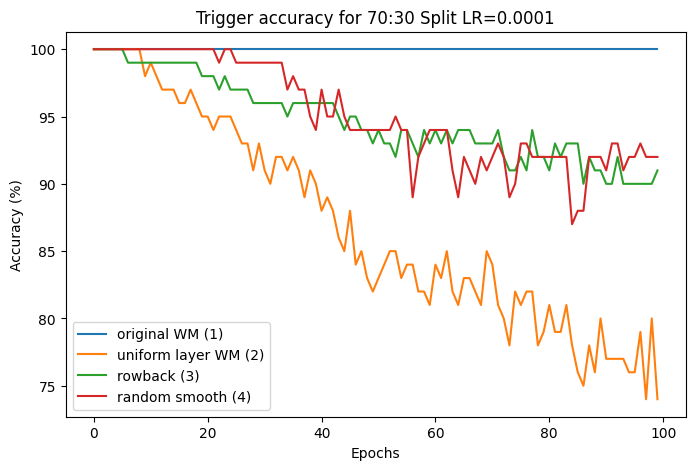

In [62]:
plt.figure(figsize=(8, 5))

plt.plot(range(len(metrics18['trigger_acc'])), metrics18['trigger_acc'], label='original WM (1)')
plt.plot(range(len(metrics19['trigger_acc'])), metrics19['trigger_acc'], label='uniform layer WM (2)')
plt.plot(range(len(metrics20['trigger_acc'])), metrics20['trigger_acc'], label='rowback (3)')

plt.plot(range(len(metrics17['trigger_acc'])), metrics17['trigger_acc'], label='random smooth (4)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Trigger accuracy for 70:30 Split LR=0.0001')
plt.legend()
plt.savefig('incre_trigger_acc_7030_lr0.0001.png')

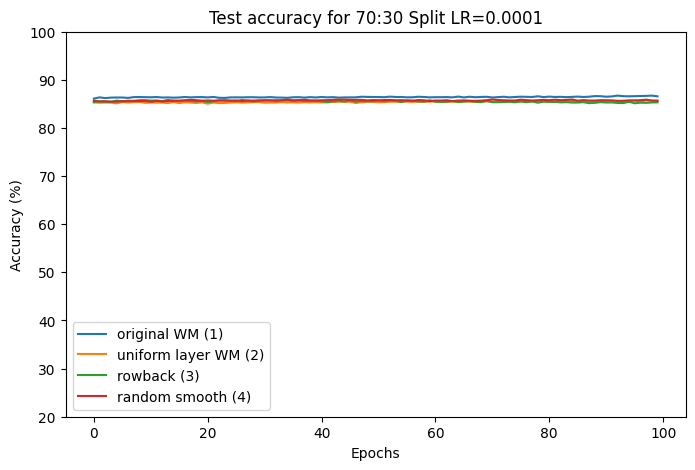

In [63]:
plt.figure(figsize=(8, 5))
plt.plot(range(len(metrics18['val_acc'])), metrics18['val_acc'], label='original WM (1)')
plt.plot(range(len(metrics19['val_acc'])), metrics19['val_acc'], label='uniform layer WM (2)')
plt.plot(range(len(metrics20['val_acc'])), metrics16['val_acc'], label='rowback (3)')

plt.plot(range(len(metrics17['val_acc'])), metrics20['val_acc'], label='random smooth (4)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test accuracy for 70:30 Split LR=0.0001')
plt.ylim([20, 100])
plt.legend()
plt.savefig('incre_test_acc_7030_lr0.0001.png')

lr=0.05

In [64]:
net21 = ResNet18()
net21.load_state_dict(torch.load('./models/wm_cifar10_certify_random_7030.pth')['model_state_dict'])
net22 = ResNet18()
net22.load_state_dict(torch.load('./checkpoints/resnet18_wm_7030.ckpt'))
net23 = ResNet18()
net23.load_state_dict(torch.load('./checkpoints/resnet18_wm_frozen_7030.ckpt'))
net24 = ResNet18()
net24.load_state_dict(torch.load('./checkpoints/resnet18_wm_rowback_7030.ckpt'))

<All keys matched successfully>

In [65]:
evaluator = Evaluator(net21, torch.nn.CrossEntropyLoss())
print(evaluator.eval(testloader))
print(evaluator.eval(unrelatedloader))

{'loss': 0.6196484971925617, 'accuracy': 87.48}
{'loss': 1.9510109414113686e-05, 'accuracy': 100.0}


In [66]:
evaluator = Evaluator(net22, torch.nn.CrossEntropyLoss())
print("Original watermarking scheme")
print(f"Test accuracy {evaluator.eval(testloader)}")
print(f"Watermark accuracy {evaluator.eval(wmloader)}")

Original watermarking scheme
Test accuracy {'loss': 0.4954307278931141, 'accuracy': 86.14}
Watermark accuracy {'loss': 0.00022259921533986926, 'accuracy': 100.0}


In [67]:
evaluator = Evaluator(net23, torch.nn.CrossEntropyLoss())
print("Frozen watermarking scheme")
print(f"Test accuracy {evaluator.eval(testloader)}")
print(f"Watermark accuracy {evaluator.eval(wmloader)}")

Frozen watermarking scheme
Test accuracy {'loss': 0.5337510022163391, 'accuracy': 85.11999999999999}
Watermark accuracy {'loss': 0.0010846821125596762, 'accuracy': 100.0}


In [68]:
evaluator = Evaluator(net24, torch.nn.CrossEntropyLoss())
print("ROWBack watermarking scheme")
print(f"Test accuracy {evaluator.eval(testloader)}")
print(f"Watermark accuracy {evaluator.eval(advwmloader)}")

ROWBack watermarking scheme
Test accuracy {'loss': 0.528250137591362, 'accuracy': 85.41}
Watermark accuracy {'loss': 0.0008671439858153463, 'accuracy': 100.0}


In [69]:
logcmt = f"incre_train_certified_7030"

optimizer21 = torch.optim.SGD(lr=0.05, params=net21.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer21 = Trainer(net21, criterion, optimizer21, incloader)
evaluator21 = Evaluator(net21, criterion)

metrics21 = train(trainer21, evaluator21, testloader, savename='inccheckpoints/incre_train_cert_7030_lr0.05', logdir='./runs', logcmt=logcmt, trigger_loader=unrelatedloader, epochs=100)

Start Training...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 0 | Time 7s| Train Loss 0.6027 | Train Acc 81.16| Val Loss 0.546 | Val Acc 81.16| Trigger Loss 1.742 | Trigger Acc 27.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 1 | Time 15s| Train Loss 0.4243 | Train Acc 85.21| Val Loss 0.583 | Val Acc 81.02| Trigger Loss 0.882 | Trigger Acc 66.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 2 | Time 23s| Train Loss 0.3737 | Train Acc 87.31| Val Loss 0.489 | Val Acc 84.14| Trigger Loss 0.151 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 3 | Time 31s| Train Loss 0.3441 | Train Acc 88.40| Val Loss 0.504 | Val Acc 83.63| Trigger Loss 0.899 | Trigger Acc 60.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 4 | Time 38s| Train Loss 0.3067 | Train Acc 89.48| Val Loss 0.520 | Val Acc 83.13| Trigger Loss 1.690 | Trigger Acc 41.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 5 | Time 45s| Train Loss 0.2762 | Train Acc 90.24| Val Loss 0.569 | Val Acc 82.81| Trigger Loss 1.874 | Trigger Acc 23.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 6 | Time 52s| Train Loss 0.2653 | Train Acc 90.88| Val Loss 0.508 | Val Acc 83.68| Trigger Loss 1.816 | Trigger Acc 29.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 7 | Time 59s| Train Loss 0.2435 | Train Acc 91.78| Val Loss 0.587 | Val Acc 82.55| Trigger Loss 2.197 | Trigger Acc 19.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 8 | Time 66s| Train Loss 0.2127 | Train Acc 92.43| Val Loss 0.599 | Val Acc 82.87| Trigger Loss 1.885 | Trigger Acc 33.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 9 | Time 74s| Train Loss 0.2164 | Train Acc 92.55| Val Loss 0.593 | Val Acc 82.39| Trigger Loss 2.746 | Trigger Acc 9.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 10 | Time 81s| Train Loss 0.2093 | Train Acc 92.49| Val Loss 0.622 | Val Acc 82.53| Trigger Loss 0.841 | Trigger Acc 62.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 11 | Time 88s| Train Loss 0.1857 | Train Acc 93.59| Val Loss 0.591 | Val Acc 84.12| Trigger Loss 2.238 | Trigger Acc 22.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 12 | Time 95s| Train Loss 0.1755 | Train Acc 93.69| Val Loss 0.602 | Val Acc 83.74| Trigger Loss 1.466 | Trigger Acc 44.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 13 | Time 102s| Train Loss 0.1547 | Train Acc 94.61| Val Loss 0.711 | Val Acc 82.29| Trigger Loss 1.151 | Trigger Acc 54.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 14 | Time 109s| Train Loss 0.1551 | Train Acc 94.72| Val Loss 0.671 | Val Acc 83.24| Trigger Loss 2.233 | Trigger Acc 27.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 15 | Time 117s| Train Loss 0.1509 | Train Acc 94.56| Val Loss 0.597 | Val Acc 83.81| Trigger Loss 3.007 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 16 | Time 124s| Train Loss 0.1405 | Train Acc 94.93| Val Loss 0.680 | Val Acc 82.81| Trigger Loss 3.699 | Trigger Acc 1.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 17 | Time 131s| Train Loss 0.1360 | Train Acc 95.20| Val Loss 0.689 | Val Acc 82.93| Trigger Loss 3.712 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 18 | Time 138s| Train Loss 0.1138 | Train Acc 95.96| Val Loss 0.678 | Val Acc 82.97| Trigger Loss 0.069 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 19 | Time 146s| Train Loss 0.1159 | Train Acc 95.77| Val Loss 0.713 | Val Acc 82.56| Trigger Loss 5.368 | Trigger Acc 0.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 20 | Time 153s| Train Loss 0.1181 | Train Acc 95.89| Val Loss 0.732 | Val Acc 82.57| Trigger Loss 0.432 | Trigger Acc 86.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 21 | Time 160s| Train Loss 0.0981 | Train Acc 96.59| Val Loss 0.769 | Val Acc 83.30| Trigger Loss 4.189 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Epoch 22 | Time 167s| Train Loss 0.1128 | Train Acc 95.85| Val Loss 0.674 | Val Acc 83.95| Trigger Loss 1.640 | Trigger Acc 47.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 23 | Time 174s| Train Loss 0.0951 | Train Acc 96.77| Val Loss 0.664 | Val Acc 84.24| Trigger Loss 5.429 | Trigger Acc 0.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 24 | Time 181s| Train Loss 0.0854 | Train Acc 97.10| Val Loss 0.722 | Val Acc 82.70| Trigger Loss 3.663 | Trigger Acc 8.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 25 | Time 189s| Train Loss 0.0836 | Train Acc 97.15| Val Loss 0.705 | Val Acc 83.51| Trigger Loss 2.142 | Trigger Acc 31.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 26 | Time 196s| Train Loss 0.0739 | Train Acc 97.49| Val Loss 0.678 | Val Acc 84.16| Trigger Loss 3.354 | Trigger Acc 10.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 27 | Time 203s| Train Loss 0.0708 | Train Acc 97.57| Val Loss 0.725 | Val Acc 83.61| Trigger Loss 4.066 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 28 | Time 210s| Train Loss 0.0680 | Train Acc 97.62| Val Loss 0.811 | Val Acc 82.96| Trigger Loss 5.852 | Trigger Acc 0.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 29 | Time 217s| Train Loss 0.0633 | Train Acc 97.82| Val Loss 0.822 | Val Acc 82.56| Trigger Loss 4.230 | Trigger Acc 1.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 30 | Time 224s| Train Loss 0.0596 | Train Acc 97.97| Val Loss 0.765 | Val Acc 83.80| Trigger Loss 3.885 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 31 | Time 232s| Train Loss 0.0589 | Train Acc 98.01| Val Loss 0.803 | Val Acc 83.30| Trigger Loss 4.569 | Trigger Acc 1.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 32 | Time 239s| Train Loss 0.0765 | Train Acc 97.33| Val Loss 0.716 | Val Acc 84.14| Trigger Loss 6.625 | Trigger Acc 0.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 33 | Time 246s| Train Loss 0.0752 | Train Acc 97.39| Val Loss 0.788 | Val Acc 83.02| Trigger Loss 2.640 | Trigger Acc 13.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 34 | Time 253s| Train Loss 0.0605 | Train Acc 97.86| Val Loss 0.796 | Val Acc 83.68| Trigger Loss 3.981 | Trigger Acc 1.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 35 | Time 260s| Train Loss 0.0684 | Train Acc 97.60| Val Loss 0.810 | Val Acc 83.54| Trigger Loss 2.256 | Trigger Acc 28.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 36 | Time 268s| Train Loss 0.0682 | Train Acc 97.51| Val Loss 0.739 | Val Acc 84.01| Trigger Loss 1.525 | Trigger Acc 44.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 37 | Time 275s| Train Loss 0.0576 | Train Acc 98.14| Val Loss 0.833 | Val Acc 82.78| Trigger Loss 2.239 | Trigger Acc 28.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 38 | Time 282s| Train Loss 0.0522 | Train Acc 98.30| Val Loss 0.721 | Val Acc 84.60| Trigger Loss 2.125 | Trigger Acc 28.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 39 | Time 289s| Train Loss 0.0504 | Train Acc 98.15| Val Loss 0.792 | Val Acc 84.20| Trigger Loss 3.121 | Trigger Acc 9.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 40 | Time 296s| Train Loss 0.0488 | Train Acc 98.38| Val Loss 0.729 | Val Acc 84.85| Trigger Loss 5.295 | Trigger Acc 0.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 41 | Time 304s| Train Loss 0.0362 | Train Acc 98.79| Val Loss 0.840 | Val Acc 83.70| Trigger Loss 3.901 | Trigger Acc 11.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 42 | Time 311s| Train Loss 0.0358 | Train Acc 98.76| Val Loss 0.832 | Val Acc 84.00| Trigger Loss 2.327 | Trigger Acc 12.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 43 | Time 318s| Train Loss 0.0509 | Train Acc 98.36| Val Loss 0.777 | Val Acc 84.77| Trigger Loss 6.604 | Trigger Acc 1.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 44 | Time 325s| Train Loss 0.0435 | Train Acc 98.50| Val Loss 0.789 | Val Acc 83.75| Trigger Loss 4.788 | Trigger Acc 2.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 45 | Time 332s| Train Loss 0.0375 | Train Acc 98.64| Val Loss 0.846 | Val Acc 83.67| Trigger Loss 7.577 | Trigger Acc 0.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 46 | Time 339s| Train Loss 0.0468 | Train Acc 98.43| Val Loss 0.846 | Val Acc 83.84| Trigger Loss 6.435 | Trigger Acc 0.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 47 | Time 347s| Train Loss 0.0381 | Train Acc 98.66| Val Loss 0.784 | Val Acc 84.06| Trigger Loss 6.547 | Trigger Acc 0.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 48 | Time 354s| Train Loss 0.0415 | Train Acc 98.66| Val Loss 0.770 | Val Acc 84.52| Trigger Loss 7.063 | Trigger Acc 0.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 49 | Time 361s| Train Loss 0.0395 | Train Acc 98.68| Val Loss 0.761 | Val Acc 84.53| Trigger Loss 5.949 | Trigger Acc 0.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 50 | Time 368s| Train Loss 0.0310 | Train Acc 99.03| Val Loss 0.793 | Val Acc 84.83| Trigger Loss 3.242 | Trigger Acc 13.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 51 | Time 375s| Train Loss 0.0405 | Train Acc 98.55| Val Loss 0.806 | Val Acc 83.64| Trigger Loss 4.419 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 52 | Time 383s| Train Loss 0.0349 | Train Acc 98.84| Val Loss 0.811 | Val Acc 84.26| Trigger Loss 7.462 | Trigger Acc 0.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 53 | Time 390s| Train Loss 0.0315 | Train Acc 98.92| Val Loss 0.830 | Val Acc 84.22| Trigger Loss 4.632 | Trigger Acc 1.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 54 | Time 397s| Train Loss 0.0357 | Train Acc 98.78| Val Loss 0.901 | Val Acc 83.44| Trigger Loss 4.160 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 55 | Time 404s| Train Loss 0.0411 | Train Acc 98.64| Val Loss 0.827 | Val Acc 84.40| Trigger Loss 5.881 | Trigger Acc 0.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 56 | Time 411s| Train Loss 0.0341 | Train Acc 98.84| Val Loss 0.807 | Val Acc 84.36| Trigger Loss 5.870 | Trigger Acc 1.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 57 | Time 418s| Train Loss 0.0319 | Train Acc 98.88| Val Loss 0.797 | Val Acc 84.30| Trigger Loss 7.270 | Trigger Acc 0.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 58 | Time 426s| Train Loss 0.0297 | Train Acc 98.99| Val Loss 0.788 | Val Acc 84.59| Trigger Loss 2.974 | Trigger Acc 11.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 59 | Time 433s| Train Loss 0.0274 | Train Acc 99.03| Val Loss 0.831 | Val Acc 84.14| Trigger Loss 4.986 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 60 | Time 440s| Train Loss 0.0299 | Train Acc 99.00| Val Loss 0.866 | Val Acc 84.25| Trigger Loss 3.323 | Trigger Acc 12.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 61 | Time 447s| Train Loss 0.0293 | Train Acc 98.96| Val Loss 0.808 | Val Acc 84.70| Trigger Loss 6.342 | Trigger Acc 2.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 62 | Time 454s| Train Loss 0.0286 | Train Acc 99.02| Val Loss 0.901 | Val Acc 83.44| Trigger Loss 5.772 | Trigger Acc 0.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 63 | Time 461s| Train Loss 0.0317 | Train Acc 98.90| Val Loss 0.813 | Val Acc 84.85| Trigger Loss 2.451 | Trigger Acc 25.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.30it/s]


Epoch 64 | Time 469s| Train Loss 0.0297 | Train Acc 98.96| Val Loss 0.788 | Val Acc 84.80| Trigger Loss 3.487 | Trigger Acc 14.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.32it/s]


Epoch 65 | Time 476s| Train Loss 0.0340 | Train Acc 98.78| Val Loss 0.889 | Val Acc 83.41| Trigger Loss 4.160 | Trigger Acc 8.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 66 | Time 483s| Train Loss 0.0309 | Train Acc 98.83| Val Loss 0.784 | Val Acc 84.66| Trigger Loss 4.422 | Trigger Acc 1.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 67 | Time 490s| Train Loss 0.0275 | Train Acc 99.09| Val Loss 0.830 | Val Acc 84.93| Trigger Loss 2.321 | Trigger Acc 28.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 68 | Time 497s| Train Loss 0.0226 | Train Acc 99.20| Val Loss 0.855 | Val Acc 84.45| Trigger Loss 2.282 | Trigger Acc 21.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.27it/s]


Epoch 69 | Time 505s| Train Loss 0.0281 | Train Acc 99.02| Val Loss 0.973 | Val Acc 82.56| Trigger Loss 3.538 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 70 | Time 512s| Train Loss 0.0347 | Train Acc 98.90| Val Loss 0.808 | Val Acc 85.07| Trigger Loss 5.890 | Trigger Acc 0.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.32it/s]


Epoch 71 | Time 519s| Train Loss 0.0349 | Train Acc 98.79| Val Loss 0.841 | Val Acc 84.56| Trigger Loss 6.371 | Trigger Acc 1.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 72 | Time 526s| Train Loss 0.0281 | Train Acc 99.07| Val Loss 0.823 | Val Acc 84.89| Trigger Loss 4.423 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 73 | Time 533s| Train Loss 0.0201 | Train Acc 99.37| Val Loss 0.780 | Val Acc 85.18| Trigger Loss 6.520 | Trigger Acc 0.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 74 | Time 540s| Train Loss 0.0286 | Train Acc 99.06| Val Loss 0.910 | Val Acc 83.45| Trigger Loss 3.730 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 75 | Time 548s| Train Loss 0.0317 | Train Acc 98.91| Val Loss 0.853 | Val Acc 83.91| Trigger Loss 6.205 | Trigger Acc 0.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 76 | Time 555s| Train Loss 0.0261 | Train Acc 99.09| Val Loss 0.828 | Val Acc 84.35| Trigger Loss 4.269 | Trigger Acc 2.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 77 | Time 562s| Train Loss 0.0259 | Train Acc 99.19| Val Loss 0.927 | Val Acc 83.52| Trigger Loss 3.458 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 78 | Time 569s| Train Loss 0.0243 | Train Acc 99.17| Val Loss 0.823 | Val Acc 84.71| Trigger Loss 4.450 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 79 | Time 576s| Train Loss 0.0235 | Train Acc 99.20| Val Loss 0.863 | Val Acc 83.64| Trigger Loss 6.316 | Trigger Acc 0.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.32it/s]


Epoch 80 | Time 584s| Train Loss 0.0191 | Train Acc 99.35| Val Loss 0.788 | Val Acc 85.29| Trigger Loss 6.237 | Trigger Acc 1.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 81 | Time 591s| Train Loss 0.0140 | Train Acc 99.55| Val Loss 0.807 | Val Acc 85.08| Trigger Loss 6.570 | Trigger Acc 2.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 82 | Time 598s| Train Loss 0.0132 | Train Acc 99.56| Val Loss 0.811 | Val Acc 85.31| Trigger Loss 7.642 | Trigger Acc 0.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 83 | Time 605s| Train Loss 0.0135 | Train Acc 99.57| Val Loss 0.826 | Val Acc 85.29| Trigger Loss 4.829 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 84 | Time 612s| Train Loss 0.0164 | Train Acc 99.50| Val Loss 0.882 | Val Acc 84.64| Trigger Loss 4.712 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 85 | Time 619s| Train Loss 0.0190 | Train Acc 99.29| Val Loss 0.858 | Val Acc 84.46| Trigger Loss 5.065 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 86 | Time 627s| Train Loss 0.0171 | Train Acc 99.37| Val Loss 0.870 | Val Acc 84.92| Trigger Loss 4.137 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 87 | Time 634s| Train Loss 0.0182 | Train Acc 99.44| Val Loss 0.869 | Val Acc 84.79| Trigger Loss 3.252 | Trigger Acc 14.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 88 | Time 641s| Train Loss 0.0148 | Train Acc 99.53| Val Loss 0.860 | Val Acc 84.94| Trigger Loss 7.575 | Trigger Acc 0.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 89 | Time 648s| Train Loss 0.0225 | Train Acc 99.25| Val Loss 0.931 | Val Acc 84.13| Trigger Loss 5.068 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 90 | Time 655s| Train Loss 0.0247 | Train Acc 99.14| Val Loss 0.899 | Val Acc 83.82| Trigger Loss 5.781 | Trigger Acc 0.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 91 | Time 662s| Train Loss 0.0296 | Train Acc 99.00| Val Loss 0.928 | Val Acc 83.63| Trigger Loss 1.945 | Trigger Acc 46.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 92 | Time 669s| Train Loss 0.0334 | Train Acc 98.95| Val Loss 0.953 | Val Acc 83.72| Trigger Loss 1.940 | Trigger Acc 33.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 93 | Time 677s| Train Loss 0.0450 | Train Acc 98.49| Val Loss 0.903 | Val Acc 83.25| Trigger Loss 3.206 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 94 | Time 684s| Train Loss 0.0350 | Train Acc 98.80| Val Loss 0.840 | Val Acc 83.78| Trigger Loss 4.607 | Trigger Acc 1.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 95 | Time 691s| Train Loss 0.0203 | Train Acc 99.31| Val Loss 0.793 | Val Acc 84.99| Trigger Loss 3.818 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 96 | Time 698s| Train Loss 0.0154 | Train Acc 99.51| Val Loss 0.784 | Val Acc 85.61| Trigger Loss 3.725 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 97 | Time 705s| Train Loss 0.0194 | Train Acc 99.35| Val Loss 0.824 | Val Acc 85.18| Trigger Loss 4.910 | Trigger Acc 0.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 98 | Time 713s| Train Loss 0.0200 | Train Acc 99.32| Val Loss 0.868 | Val Acc 84.21| Trigger Loss 5.163 | Trigger Acc 1.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 99 | Time 720s| Train Loss 0.0181 | Train Acc 99.35| Val Loss 0.864 | Val Acc 84.64| Trigger Loss 5.866 | Trigger Acc 1.00


In [70]:
logcmt = f"incre_train_baseline_7030"

optimizer22 = torch.optim.SGD(lr=0.05, params=net22.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer22 = Trainer(net22, criterion, optimizer22, incloader)
evaluator22 = Evaluator(net22, criterion)

metrics22 = train(trainer22, evaluator22, testloader, savename='inccheckpoints/incre_train_baseline_7030_lr0.05', logdir='./runs', logcmt=logcmt, trigger_loader=wmloader, epochs=100)

Start Training...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 0 | Time 7s| Train Loss 0.8087 | Train Acc 74.25| Val Loss 1.255 | Val Acc 66.04| Trigger Loss 5.245 | Trigger Acc 17.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 1 | Time 15s| Train Loss 0.6179 | Train Acc 79.57| Val Loss 0.674 | Val Acc 78.06| Trigger Loss 4.734 | Trigger Acc 16.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 2 | Time 23s| Train Loss 0.5200 | Train Acc 82.26| Val Loss 0.704 | Val Acc 77.39| Trigger Loss 4.809 | Trigger Acc 16.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 3 | Time 30s| Train Loss 0.4946 | Train Acc 83.23| Val Loss 0.723 | Val Acc 78.09| Trigger Loss 5.742 | Trigger Acc 14.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 4 | Time 37s| Train Loss 0.4400 | Train Acc 85.09| Val Loss 0.790 | Val Acc 76.70| Trigger Loss 6.090 | Trigger Acc 11.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 5 | Time 44s| Train Loss 0.3970 | Train Acc 86.30| Val Loss 0.638 | Val Acc 80.27| Trigger Loss 6.360 | Trigger Acc 12.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 6 | Time 51s| Train Loss 0.3941 | Train Acc 86.35| Val Loss 0.721 | Val Acc 79.33| Trigger Loss 7.374 | Trigger Acc 11.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 7 | Time 59s| Train Loss 0.3631 | Train Acc 87.43| Val Loss 0.759 | Val Acc 78.56| Trigger Loss 6.939 | Trigger Acc 11.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 8 | Time 66s| Train Loss 0.3251 | Train Acc 88.87| Val Loss 0.649 | Val Acc 80.89| Trigger Loss 6.560 | Trigger Acc 11.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 9 | Time 73s| Train Loss 0.3088 | Train Acc 89.27| Val Loss 0.661 | Val Acc 80.69| Trigger Loss 7.418 | Trigger Acc 12.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 10 | Time 80s| Train Loss 0.2997 | Train Acc 89.59| Val Loss 0.802 | Val Acc 78.56| Trigger Loss 7.220 | Trigger Acc 15.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 11 | Time 87s| Train Loss 0.2996 | Train Acc 89.94| Val Loss 0.679 | Val Acc 81.06| Trigger Loss 8.012 | Trigger Acc 9.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 12 | Time 95s| Train Loss 0.2566 | Train Acc 91.05| Val Loss 0.598 | Val Acc 82.18| Trigger Loss 7.264 | Trigger Acc 11.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 13 | Time 102s| Train Loss 0.2392 | Train Acc 91.68| Val Loss 0.660 | Val Acc 82.13| Trigger Loss 8.582 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 14 | Time 109s| Train Loss 0.2233 | Train Acc 92.24| Val Loss 0.643 | Val Acc 82.98| Trigger Loss 9.537 | Trigger Acc 11.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 15 | Time 116s| Train Loss 0.2158 | Train Acc 92.21| Val Loss 0.673 | Val Acc 82.35| Trigger Loss 9.216 | Trigger Acc 11.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 16 | Time 123s| Train Loss 0.1948 | Train Acc 93.09| Val Loss 0.721 | Val Acc 81.54| Trigger Loss 8.846 | Trigger Acc 12.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 17 | Time 131s| Train Loss 0.1973 | Train Acc 93.06| Val Loss 0.707 | Val Acc 81.91| Trigger Loss 10.634 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 18 | Time 138s| Train Loss 0.1863 | Train Acc 93.54| Val Loss 0.766 | Val Acc 81.16| Trigger Loss 10.475 | Trigger Acc 12.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 19 | Time 145s| Train Loss 0.1658 | Train Acc 94.22| Val Loss 0.722 | Val Acc 81.41| Trigger Loss 9.834 | Trigger Acc 10.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 20 | Time 152s| Train Loss 0.1469 | Train Acc 94.94| Val Loss 0.729 | Val Acc 82.92| Trigger Loss 11.088 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 21 | Time 159s| Train Loss 0.1403 | Train Acc 95.04| Val Loss 0.713 | Val Acc 82.78| Trigger Loss 10.293 | Trigger Acc 8.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 22 | Time 167s| Train Loss 0.1524 | Train Acc 94.64| Val Loss 0.773 | Val Acc 82.22| Trigger Loss 11.616 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 23 | Time 174s| Train Loss 0.1402 | Train Acc 95.12| Val Loss 0.878 | Val Acc 80.23| Trigger Loss 11.257 | Trigger Acc 8.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 24 | Time 181s| Train Loss 0.1359 | Train Acc 95.36| Val Loss 0.753 | Val Acc 82.79| Trigger Loss 12.025 | Trigger Acc 9.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.32it/s]


Epoch 25 | Time 188s| Train Loss 0.1206 | Train Acc 95.88| Val Loss 0.828 | Val Acc 81.88| Trigger Loss 12.622 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 26 | Time 195s| Train Loss 0.1348 | Train Acc 95.16| Val Loss 0.859 | Val Acc 81.06| Trigger Loss 11.784 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 27 | Time 202s| Train Loss 0.1238 | Train Acc 95.63| Val Loss 0.863 | Val Acc 81.38| Trigger Loss 12.961 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 28 | Time 210s| Train Loss 0.1131 | Train Acc 96.09| Val Loss 0.858 | Val Acc 81.16| Trigger Loss 12.738 | Trigger Acc 8.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 29 | Time 217s| Train Loss 0.1031 | Train Acc 96.44| Val Loss 0.936 | Val Acc 81.26| Trigger Loss 13.545 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 30 | Time 224s| Train Loss 0.1184 | Train Acc 95.65| Val Loss 0.793 | Val Acc 82.27| Trigger Loss 12.184 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 31 | Time 231s| Train Loss 0.0991 | Train Acc 96.35| Val Loss 0.881 | Val Acc 82.24| Trigger Loss 13.925 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 32 | Time 238s| Train Loss 0.0727 | Train Acc 97.46| Val Loss 0.766 | Val Acc 83.45| Trigger Loss 12.698 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 33 | Time 246s| Train Loss 0.0732 | Train Acc 97.38| Val Loss 1.031 | Val Acc 79.97| Trigger Loss 13.395 | Trigger Acc 9.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 34 | Time 253s| Train Loss 0.0916 | Train Acc 96.81| Val Loss 0.859 | Val Acc 82.15| Trigger Loss 13.610 | Trigger Acc 8.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 35 | Time 260s| Train Loss 0.0764 | Train Acc 97.27| Val Loss 0.850 | Val Acc 83.60| Trigger Loss 13.803 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 36 | Time 267s| Train Loss 0.0758 | Train Acc 97.27| Val Loss 0.961 | Val Acc 81.53| Trigger Loss 12.784 | Trigger Acc 10.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 37 | Time 274s| Train Loss 0.0838 | Train Acc 97.18| Val Loss 0.845 | Val Acc 83.21| Trigger Loss 14.299 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 38 | Time 282s| Train Loss 0.0713 | Train Acc 97.52| Val Loss 0.881 | Val Acc 83.18| Trigger Loss 13.853 | Trigger Acc 8.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 39 | Time 289s| Train Loss 0.0703 | Train Acc 97.60| Val Loss 0.842 | Val Acc 83.82| Trigger Loss 15.006 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 40 | Time 296s| Train Loss 0.0588 | Train Acc 97.76| Val Loss 0.922 | Val Acc 82.61| Trigger Loss 14.419 | Trigger Acc 8.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 41 | Time 303s| Train Loss 0.0663 | Train Acc 97.73| Val Loss 0.849 | Val Acc 83.97| Trigger Loss 15.367 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 42 | Time 310s| Train Loss 0.0671 | Train Acc 97.74| Val Loss 0.820 | Val Acc 83.42| Trigger Loss 14.264 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 43 | Time 317s| Train Loss 0.0620 | Train Acc 97.91| Val Loss 0.936 | Val Acc 82.63| Trigger Loss 14.710 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 44 | Time 325s| Train Loss 0.0488 | Train Acc 98.34| Val Loss 0.780 | Val Acc 84.13| Trigger Loss 14.816 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 45 | Time 332s| Train Loss 0.0524 | Train Acc 98.25| Val Loss 1.135 | Val Acc 81.50| Trigger Loss 16.009 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 46 | Time 339s| Train Loss 0.0657 | Train Acc 97.79| Val Loss 0.930 | Val Acc 82.18| Trigger Loss 14.939 | Trigger Acc 9.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 47 | Time 346s| Train Loss 0.0515 | Train Acc 98.33| Val Loss 0.953 | Val Acc 82.33| Trigger Loss 15.539 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.30it/s]


Epoch 48 | Time 353s| Train Loss 0.0629 | Train Acc 97.73| Val Loss 0.939 | Val Acc 82.77| Trigger Loss 16.044 | Trigger Acc 2.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 49 | Time 361s| Train Loss 0.0621 | Train Acc 97.85| Val Loss 0.961 | Val Acc 82.58| Trigger Loss 15.859 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 50 | Time 368s| Train Loss 0.0461 | Train Acc 98.46| Val Loss 0.821 | Val Acc 84.18| Trigger Loss 16.461 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 51 | Time 375s| Train Loss 0.0368 | Train Acc 98.72| Val Loss 0.846 | Val Acc 84.55| Trigger Loss 16.134 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.32it/s]


Epoch 52 | Time 382s| Train Loss 0.0329 | Train Acc 98.82| Val Loss 0.848 | Val Acc 84.52| Trigger Loss 16.612 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 53 | Time 389s| Train Loss 0.0456 | Train Acc 98.58| Val Loss 0.880 | Val Acc 83.56| Trigger Loss 14.887 | Trigger Acc 9.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 54 | Time 396s| Train Loss 0.0409 | Train Acc 98.64| Val Loss 0.851 | Val Acc 84.57| Trigger Loss 15.872 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 55 | Time 404s| Train Loss 0.0308 | Train Acc 98.88| Val Loss 0.923 | Val Acc 83.36| Trigger Loss 15.665 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 56 | Time 411s| Train Loss 0.0289 | Train Acc 99.06| Val Loss 0.981 | Val Acc 82.60| Trigger Loss 16.201 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 57 | Time 418s| Train Loss 0.0320 | Train Acc 98.79| Val Loss 0.958 | Val Acc 83.10| Trigger Loss 16.814 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 58 | Time 425s| Train Loss 0.0345 | Train Acc 98.78| Val Loss 0.898 | Val Acc 84.06| Trigger Loss 16.038 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 59 | Time 432s| Train Loss 0.0277 | Train Acc 99.06| Val Loss 0.964 | Val Acc 83.63| Trigger Loss 16.833 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 60 | Time 440s| Train Loss 0.0284 | Train Acc 99.00| Val Loss 0.913 | Val Acc 83.54| Trigger Loss 17.301 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 61 | Time 447s| Train Loss 0.0312 | Train Acc 98.88| Val Loss 0.974 | Val Acc 83.40| Trigger Loss 16.450 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 62 | Time 454s| Train Loss 0.0311 | Train Acc 98.89| Val Loss 0.943 | Val Acc 84.22| Trigger Loss 16.876 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 63 | Time 461s| Train Loss 0.0334 | Train Acc 98.91| Val Loss 0.956 | Val Acc 83.03| Trigger Loss 16.953 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 64 | Time 468s| Train Loss 0.0398 | Train Acc 98.70| Val Loss 0.902 | Val Acc 84.02| Trigger Loss 16.253 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 65 | Time 476s| Train Loss 0.0293 | Train Acc 99.04| Val Loss 0.893 | Val Acc 84.34| Trigger Loss 15.741 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.32it/s]


Epoch 66 | Time 483s| Train Loss 0.0319 | Train Acc 98.93| Val Loss 0.964 | Val Acc 83.34| Trigger Loss 17.540 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 67 | Time 490s| Train Loss 0.0356 | Train Acc 98.85| Val Loss 0.949 | Val Acc 83.31| Trigger Loss 16.886 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 68 | Time 497s| Train Loss 0.0298 | Train Acc 98.94| Val Loss 0.875 | Val Acc 84.68| Trigger Loss 16.564 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.26it/s]


Epoch 69 | Time 504s| Train Loss 0.0222 | Train Acc 99.29| Val Loss 0.838 | Val Acc 84.49| Trigger Loss 17.030 | Trigger Acc 2.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.27it/s]


Epoch 70 | Time 512s| Train Loss 0.0216 | Train Acc 99.32| Val Loss 0.906 | Val Acc 84.52| Trigger Loss 16.233 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 71 | Time 519s| Train Loss 0.0221 | Train Acc 99.18| Val Loss 0.875 | Val Acc 84.46| Trigger Loss 16.448 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 72 | Time 526s| Train Loss 0.0240 | Train Acc 99.14| Val Loss 1.011 | Val Acc 83.66| Trigger Loss 17.155 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 73 | Time 533s| Train Loss 0.0270 | Train Acc 99.06| Val Loss 0.971 | Val Acc 83.57| Trigger Loss 16.534 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 74 | Time 540s| Train Loss 0.0292 | Train Acc 98.96| Val Loss 0.926 | Val Acc 84.13| Trigger Loss 16.748 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 75 | Time 548s| Train Loss 0.0296 | Train Acc 99.05| Val Loss 0.881 | Val Acc 84.52| Trigger Loss 16.972 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 76 | Time 555s| Train Loss 0.0280 | Train Acc 99.02| Val Loss 0.904 | Val Acc 83.93| Trigger Loss 16.668 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 77 | Time 562s| Train Loss 0.0258 | Train Acc 99.10| Val Loss 0.887 | Val Acc 84.27| Trigger Loss 16.634 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.32it/s]


Epoch 78 | Time 569s| Train Loss 0.0282 | Train Acc 99.08| Val Loss 1.018 | Val Acc 83.28| Trigger Loss 17.081 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 79 | Time 576s| Train Loss 0.0247 | Train Acc 99.25| Val Loss 0.990 | Val Acc 83.76| Trigger Loss 17.126 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 80 | Time 583s| Train Loss 0.0239 | Train Acc 99.06| Val Loss 0.897 | Val Acc 84.29| Trigger Loss 17.497 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 81 | Time 591s| Train Loss 0.0327 | Train Acc 98.98| Val Loss 0.925 | Val Acc 84.29| Trigger Loss 16.930 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 82 | Time 598s| Train Loss 0.0232 | Train Acc 99.24| Val Loss 0.898 | Val Acc 84.07| Trigger Loss 17.055 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 83 | Time 605s| Train Loss 0.0160 | Train Acc 99.43| Val Loss 0.856 | Val Acc 85.04| Trigger Loss 16.331 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 84 | Time 612s| Train Loss 0.0246 | Train Acc 99.12| Val Loss 1.007 | Val Acc 83.34| Trigger Loss 17.456 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 85 | Time 619s| Train Loss 0.0224 | Train Acc 99.28| Val Loss 0.890 | Val Acc 83.91| Trigger Loss 16.558 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 86 | Time 627s| Train Loss 0.0162 | Train Acc 99.50| Val Loss 0.882 | Val Acc 84.43| Trigger Loss 16.839 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 87 | Time 634s| Train Loss 0.0118 | Train Acc 99.69| Val Loss 0.894 | Val Acc 84.91| Trigger Loss 16.878 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 88 | Time 641s| Train Loss 0.0159 | Train Acc 99.41| Val Loss 0.884 | Val Acc 84.59| Trigger Loss 16.802 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 89 | Time 648s| Train Loss 0.0234 | Train Acc 99.23| Val Loss 0.955 | Val Acc 83.95| Trigger Loss 16.981 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 90 | Time 655s| Train Loss 0.0310 | Train Acc 98.90| Val Loss 0.918 | Val Acc 84.62| Trigger Loss 18.166 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 91 | Time 662s| Train Loss 0.0356 | Train Acc 98.77| Val Loss 0.927 | Val Acc 84.54| Trigger Loss 16.774 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 92 | Time 670s| Train Loss 0.0253 | Train Acc 99.14| Val Loss 0.884 | Val Acc 84.19| Trigger Loss 17.750 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 93 | Time 677s| Train Loss 0.0202 | Train Acc 99.35| Val Loss 0.907 | Val Acc 84.40| Trigger Loss 17.226 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 94 | Time 684s| Train Loss 0.0226 | Train Acc 99.28| Val Loss 0.884 | Val Acc 84.64| Trigger Loss 16.437 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 95 | Time 691s| Train Loss 0.0263 | Train Acc 99.08| Val Loss 0.910 | Val Acc 84.75| Trigger Loss 16.747 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 96 | Time 698s| Train Loss 0.0251 | Train Acc 99.16| Val Loss 0.937 | Val Acc 83.84| Trigger Loss 16.834 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 97 | Time 706s| Train Loss 0.0240 | Train Acc 99.29| Val Loss 0.916 | Val Acc 83.84| Trigger Loss 16.277 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 98 | Time 713s| Train Loss 0.0186 | Train Acc 99.44| Val Loss 0.839 | Val Acc 84.81| Trigger Loss 16.223 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.29it/s]


Epoch 99 | Time 720s| Train Loss 0.0148 | Train Acc 99.49| Val Loss 0.906 | Val Acc 84.89| Trigger Loss 16.466 | Trigger Acc 1.00


In [71]:
logcmt = f"incre_train_baseline_frozen_7030"

optimizer23 = torch.optim.SGD(lr=0.05, params=net23.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer23 = Trainer(net23, criterion, optimizer23, incloader)
evaluator23 = Evaluator(net23, criterion)
metrics23 = train(trainer23, evaluator23, testloader, savename='inccheckpoints/incre_train_baseline_frozen_7030_lr0.05', logdir='./runs', logcmt=logcmt, trigger_loader=wmloader, epochs=100)

Start Training...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 0 | Time 7s| Train Loss 0.9561 | Train Acc 69.10| Val Loss 0.857 | Val Acc 72.58| Trigger Loss 7.171 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 1 | Time 16s| Train Loss 0.6545 | Train Acc 77.64| Val Loss 0.934 | Val Acc 71.09| Trigger Loss 7.366 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 2 | Time 23s| Train Loss 0.5650 | Train Acc 80.68| Val Loss 0.985 | Val Acc 70.72| Trigger Loss 7.649 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 3 | Time 30s| Train Loss 0.5368 | Train Acc 81.37| Val Loss 0.767 | Val Acc 76.52| Trigger Loss 8.591 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 4 | Time 38s| Train Loss 0.4790 | Train Acc 83.37| Val Loss 0.618 | Val Acc 80.38| Trigger Loss 8.969 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.31it/s]


Epoch 5 | Time 45s| Train Loss 0.4426 | Train Acc 84.46| Val Loss 0.690 | Val Acc 78.95| Trigger Loss 9.035 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 6 | Time 52s| Train Loss 0.4095 | Train Acc 85.57| Val Loss 0.756 | Val Acc 78.06| Trigger Loss 10.085 | Trigger Acc 9.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 7 | Time 60s| Train Loss 0.4086 | Train Acc 85.74| Val Loss 0.662 | Val Acc 79.48| Trigger Loss 8.858 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 8 | Time 67s| Train Loss 0.3751 | Train Acc 87.20| Val Loss 0.652 | Val Acc 80.43| Trigger Loss 9.975 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 9 | Time 74s| Train Loss 0.3421 | Train Acc 88.05| Val Loss 0.740 | Val Acc 79.25| Trigger Loss 11.161 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 10 | Time 81s| Train Loss 0.3211 | Train Acc 88.66| Val Loss 0.739 | Val Acc 79.30| Trigger Loss 10.513 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 11 | Time 88s| Train Loss 0.3117 | Train Acc 89.08| Val Loss 0.740 | Val Acc 79.19| Trigger Loss 10.578 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 12 | Time 96s| Train Loss 0.2882 | Train Acc 90.06| Val Loss 0.688 | Val Acc 79.52| Trigger Loss 10.323 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 13 | Time 103s| Train Loss 0.2693 | Train Acc 90.56| Val Loss 0.603 | Val Acc 82.63| Trigger Loss 11.045 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 14 | Time 110s| Train Loss 0.2568 | Train Acc 90.98| Val Loss 0.735 | Val Acc 81.08| Trigger Loss 12.830 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 15 | Time 117s| Train Loss 0.2458 | Train Acc 91.61| Val Loss 0.690 | Val Acc 81.33| Trigger Loss 12.378 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.28it/s]


Epoch 16 | Time 124s| Train Loss 0.2508 | Train Acc 91.26| Val Loss 0.820 | Val Acc 79.53| Trigger Loss 12.646 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.31it/s]


Epoch 17 | Time 132s| Train Loss 0.2306 | Train Acc 91.87| Val Loss 0.735 | Val Acc 80.09| Trigger Loss 11.664 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 18 | Time 139s| Train Loss 0.2182 | Train Acc 92.47| Val Loss 0.755 | Val Acc 80.28| Trigger Loss 13.221 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 19 | Time 146s| Train Loss 0.2043 | Train Acc 92.69| Val Loss 0.703 | Val Acc 80.91| Trigger Loss 13.103 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 20 | Time 153s| Train Loss 0.1879 | Train Acc 93.41| Val Loss 0.869 | Val Acc 79.92| Trigger Loss 14.803 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 21 | Time 160s| Train Loss 0.1829 | Train Acc 93.58| Val Loss 0.692 | Val Acc 82.19| Trigger Loss 13.576 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 22 | Time 168s| Train Loss 0.1625 | Train Acc 94.26| Val Loss 0.783 | Val Acc 81.06| Trigger Loss 14.364 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 23 | Time 175s| Train Loss 0.1473 | Train Acc 94.70| Val Loss 0.951 | Val Acc 78.20| Trigger Loss 13.975 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 24 | Time 182s| Train Loss 0.1552 | Train Acc 94.38| Val Loss 0.834 | Val Acc 80.66| Trigger Loss 14.049 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 25 | Time 189s| Train Loss 0.1392 | Train Acc 95.02| Val Loss 0.813 | Val Acc 80.86| Trigger Loss 14.816 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 26 | Time 196s| Train Loss 0.1547 | Train Acc 94.62| Val Loss 0.802 | Val Acc 81.14| Trigger Loss 14.654 | Trigger Acc 1.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 27 | Time 204s| Train Loss 0.1371 | Train Acc 95.08| Val Loss 0.773 | Val Acc 82.54| Trigger Loss 15.212 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 28 | Time 211s| Train Loss 0.1231 | Train Acc 95.48| Val Loss 0.838 | Val Acc 82.05| Trigger Loss 15.878 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 29 | Time 218s| Train Loss 0.1205 | Train Acc 95.55| Val Loss 0.872 | Val Acc 81.01| Trigger Loss 15.979 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 30 | Time 225s| Train Loss 0.1024 | Train Acc 96.45| Val Loss 0.765 | Val Acc 83.08| Trigger Loss 15.529 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 31 | Time 232s| Train Loss 0.0889 | Train Acc 96.64| Val Loss 0.745 | Val Acc 83.20| Trigger Loss 15.741 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 32 | Time 239s| Train Loss 0.0962 | Train Acc 96.80| Val Loss 0.882 | Val Acc 81.95| Trigger Loss 17.362 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 33 | Time 247s| Train Loss 0.0969 | Train Acc 96.49| Val Loss 0.852 | Val Acc 82.37| Trigger Loss 16.759 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 34 | Time 254s| Train Loss 0.1010 | Train Acc 96.47| Val Loss 0.880 | Val Acc 81.70| Trigger Loss 16.115 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 35 | Time 261s| Train Loss 0.1144 | Train Acc 95.90| Val Loss 0.769 | Val Acc 82.60| Trigger Loss 15.368 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 36 | Time 268s| Train Loss 0.0848 | Train Acc 97.00| Val Loss 0.904 | Val Acc 81.51| Trigger Loss 16.555 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 37 | Time 275s| Train Loss 0.0878 | Train Acc 97.07| Val Loss 0.858 | Val Acc 82.07| Trigger Loss 17.082 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 38 | Time 283s| Train Loss 0.0762 | Train Acc 97.29| Val Loss 0.922 | Val Acc 81.53| Trigger Loss 16.874 | Trigger Acc 2.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 39 | Time 290s| Train Loss 0.0748 | Train Acc 97.39| Val Loss 1.008 | Val Acc 80.00| Trigger Loss 16.197 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 40 | Time 297s| Train Loss 0.0762 | Train Acc 97.31| Val Loss 0.879 | Val Acc 82.14| Trigger Loss 17.241 | Trigger Acc 1.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 41 | Time 304s| Train Loss 0.0689 | Train Acc 97.41| Val Loss 0.904 | Val Acc 82.00| Trigger Loss 17.009 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 42 | Time 311s| Train Loss 0.0659 | Train Acc 97.61| Val Loss 0.828 | Val Acc 83.45| Trigger Loss 17.370 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 43 | Time 318s| Train Loss 0.0544 | Train Acc 98.06| Val Loss 0.768 | Val Acc 83.99| Trigger Loss 17.328 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 44 | Time 326s| Train Loss 0.0519 | Train Acc 98.18| Val Loss 0.903 | Val Acc 81.63| Trigger Loss 16.559 | Trigger Acc 9.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 45 | Time 333s| Train Loss 0.0613 | Train Acc 97.90| Val Loss 1.025 | Val Acc 81.45| Trigger Loss 18.592 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 46 | Time 340s| Train Loss 0.0688 | Train Acc 97.53| Val Loss 0.845 | Val Acc 83.34| Trigger Loss 17.357 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 47 | Time 347s| Train Loss 0.0700 | Train Acc 97.62| Val Loss 1.098 | Val Acc 80.09| Trigger Loss 17.951 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 48 | Time 355s| Train Loss 0.0693 | Train Acc 97.58| Val Loss 0.883 | Val Acc 82.62| Trigger Loss 17.273 | Trigger Acc 8.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 49 | Time 362s| Train Loss 0.0660 | Train Acc 97.64| Val Loss 0.887 | Val Acc 82.72| Trigger Loss 17.457 | Trigger Acc 2.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 50 | Time 369s| Train Loss 0.0417 | Train Acc 98.58| Val Loss 0.903 | Val Acc 82.71| Trigger Loss 17.102 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 51 | Time 376s| Train Loss 0.0372 | Train Acc 98.77| Val Loss 0.885 | Val Acc 83.79| Trigger Loss 18.128 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 52 | Time 383s| Train Loss 0.0454 | Train Acc 98.45| Val Loss 0.867 | Val Acc 83.84| Trigger Loss 18.034 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 53 | Time 391s| Train Loss 0.0445 | Train Acc 98.41| Val Loss 0.857 | Val Acc 84.01| Trigger Loss 17.554 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 54 | Time 398s| Train Loss 0.0448 | Train Acc 98.45| Val Loss 0.943 | Val Acc 82.46| Trigger Loss 17.652 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 55 | Time 405s| Train Loss 0.0388 | Train Acc 98.57| Val Loss 0.913 | Val Acc 82.62| Trigger Loss 17.800 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 56 | Time 412s| Train Loss 0.0323 | Train Acc 98.86| Val Loss 0.880 | Val Acc 83.70| Trigger Loss 18.268 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 57 | Time 419s| Train Loss 0.0318 | Train Acc 98.94| Val Loss 0.962 | Val Acc 82.64| Trigger Loss 18.428 | Trigger Acc 2.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 58 | Time 427s| Train Loss 0.0343 | Train Acc 98.84| Val Loss 0.947 | Val Acc 83.43| Trigger Loss 19.426 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 59 | Time 434s| Train Loss 0.0302 | Train Acc 99.00| Val Loss 0.871 | Val Acc 84.18| Trigger Loss 18.670 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 60 | Time 441s| Train Loss 0.0417 | Train Acc 98.48| Val Loss 0.909 | Val Acc 84.07| Trigger Loss 18.571 | Trigger Acc 1.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 61 | Time 448s| Train Loss 0.0472 | Train Acc 98.34| Val Loss 0.885 | Val Acc 83.01| Trigger Loss 17.423 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 62 | Time 455s| Train Loss 0.0402 | Train Acc 98.72| Val Loss 0.887 | Val Acc 83.75| Trigger Loss 18.127 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 63 | Time 462s| Train Loss 0.0367 | Train Acc 98.84| Val Loss 0.952 | Val Acc 82.75| Trigger Loss 18.419 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 64 | Time 470s| Train Loss 0.0335 | Train Acc 98.95| Val Loss 0.896 | Val Acc 83.36| Trigger Loss 17.939 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 65 | Time 477s| Train Loss 0.0287 | Train Acc 99.01| Val Loss 0.888 | Val Acc 83.56| Trigger Loss 18.165 | Trigger Acc 2.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 66 | Time 484s| Train Loss 0.0355 | Train Acc 98.86| Val Loss 0.903 | Val Acc 83.93| Trigger Loss 18.303 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 67 | Time 491s| Train Loss 0.0289 | Train Acc 99.00| Val Loss 0.969 | Val Acc 83.26| Trigger Loss 18.967 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 68 | Time 498s| Train Loss 0.0282 | Train Acc 99.08| Val Loss 0.924 | Val Acc 83.53| Trigger Loss 18.560 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 69 | Time 506s| Train Loss 0.0248 | Train Acc 99.21| Val Loss 0.979 | Val Acc 83.71| Trigger Loss 19.126 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 70 | Time 513s| Train Loss 0.0196 | Train Acc 99.44| Val Loss 0.887 | Val Acc 84.24| Trigger Loss 18.975 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 71 | Time 520s| Train Loss 0.0196 | Train Acc 99.31| Val Loss 0.924 | Val Acc 83.78| Trigger Loss 18.167 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 72 | Time 527s| Train Loss 0.0285 | Train Acc 99.06| Val Loss 1.013 | Val Acc 82.73| Trigger Loss 19.024 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 73 | Time 534s| Train Loss 0.0297 | Train Acc 98.94| Val Loss 0.945 | Val Acc 83.47| Trigger Loss 18.484 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 74 | Time 542s| Train Loss 0.0321 | Train Acc 99.01| Val Loss 0.935 | Val Acc 83.23| Trigger Loss 18.041 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 75 | Time 549s| Train Loss 0.0343 | Train Acc 98.86| Val Loss 0.915 | Val Acc 84.16| Trigger Loss 19.385 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.29it/s]


Epoch 76 | Time 556s| Train Loss 0.0240 | Train Acc 99.18| Val Loss 1.053 | Val Acc 82.84| Trigger Loss 18.733 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 77 | Time 563s| Train Loss 0.0285 | Train Acc 99.05| Val Loss 1.100 | Val Acc 82.17| Trigger Loss 18.850 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 78 | Time 570s| Train Loss 0.0279 | Train Acc 99.02| Val Loss 0.909 | Val Acc 83.93| Trigger Loss 19.057 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 79 | Time 577s| Train Loss 0.0306 | Train Acc 98.88| Val Loss 0.933 | Val Acc 83.71| Trigger Loss 18.801 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 80 | Time 585s| Train Loss 0.0201 | Train Acc 99.35| Val Loss 0.930 | Val Acc 83.75| Trigger Loss 18.393 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 81 | Time 592s| Train Loss 0.0209 | Train Acc 99.25| Val Loss 0.905 | Val Acc 83.96| Trigger Loss 19.197 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 82 | Time 599s| Train Loss 0.0193 | Train Acc 99.34| Val Loss 0.992 | Val Acc 83.38| Trigger Loss 19.004 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 83 | Time 606s| Train Loss 0.0182 | Train Acc 99.42| Val Loss 1.014 | Val Acc 83.14| Trigger Loss 19.085 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 84 | Time 613s| Train Loss 0.0223 | Train Acc 99.27| Val Loss 0.949 | Val Acc 83.62| Trigger Loss 19.331 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 85 | Time 621s| Train Loss 0.0247 | Train Acc 99.16| Val Loss 0.976 | Val Acc 83.29| Trigger Loss 19.069 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 86 | Time 628s| Train Loss 0.0275 | Train Acc 99.05| Val Loss 0.957 | Val Acc 83.91| Trigger Loss 19.170 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 87 | Time 635s| Train Loss 0.0181 | Train Acc 99.40| Val Loss 0.961 | Val Acc 83.94| Trigger Loss 20.021 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 88 | Time 642s| Train Loss 0.0172 | Train Acc 99.43| Val Loss 0.953 | Val Acc 83.65| Trigger Loss 19.048 | Trigger Acc 1.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 89 | Time 649s| Train Loss 0.0206 | Train Acc 99.26| Val Loss 0.963 | Val Acc 84.26| Trigger Loss 19.454 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 90 | Time 656s| Train Loss 0.0215 | Train Acc 99.24| Val Loss 0.922 | Val Acc 84.13| Trigger Loss 19.014 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 91 | Time 664s| Train Loss 0.0190 | Train Acc 99.37| Val Loss 0.961 | Val Acc 83.90| Trigger Loss 19.890 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.31it/s]


Epoch 92 | Time 671s| Train Loss 0.0218 | Train Acc 99.30| Val Loss 0.972 | Val Acc 83.72| Trigger Loss 18.750 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 93 | Time 678s| Train Loss 0.0238 | Train Acc 99.19| Val Loss 0.992 | Val Acc 83.19| Trigger Loss 19.278 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 94 | Time 685s| Train Loss 0.0260 | Train Acc 99.18| Val Loss 1.043 | Val Acc 82.43| Trigger Loss 19.207 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 95 | Time 692s| Train Loss 0.0267 | Train Acc 99.12| Val Loss 0.990 | Val Acc 83.51| Trigger Loss 18.709 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 96 | Time 700s| Train Loss 0.0301 | Train Acc 99.02| Val Loss 1.012 | Val Acc 83.04| Trigger Loss 18.767 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 97 | Time 707s| Train Loss 0.0306 | Train Acc 98.97| Val Loss 0.951 | Val Acc 83.10| Trigger Loss 19.633 | Trigger Acc 2.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 98 | Time 714s| Train Loss 0.0245 | Train Acc 99.21| Val Loss 1.038 | Val Acc 83.31| Trigger Loss 19.202 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 99 | Time 721s| Train Loss 0.0242 | Train Acc 99.14| Val Loss 0.864 | Val Acc 84.42| Trigger Loss 18.551 | Trigger Acc 3.00


In [72]:
logcmt = f"incre_train_baseline_rowback_7030"

optimizer24 = torch.optim.SGD(lr=0.05, params=net24.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer24 = Trainer(net24, criterion, optimizer24, incloader)
evaluator24 = Evaluator(net24, criterion)

metrics24 = train(trainer24, evaluator24, testloader, savename='inccheckpoints/incre_train_baseline_rowback_7030_lr0.05', logdir='./runs', logcmt=logcmt, trigger_loader=advwmloader, epochs=100)

Start Training...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 0 | Time 7s| Train Loss 0.8539 | Train Acc 72.24| Val Loss 0.868 | Val Acc 72.03| Trigger Loss 5.605 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 1 | Time 16s| Train Loss 0.6456 | Train Acc 77.79| Val Loss 0.826 | Val Acc 74.45| Trigger Loss 6.243 | Trigger Acc 8.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 2 | Time 23s| Train Loss 0.5803 | Train Acc 80.11| Val Loss 0.906 | Val Acc 73.62| Trigger Loss 7.394 | Trigger Acc 10.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 3 | Time 30s| Train Loss 0.5020 | Train Acc 82.55| Val Loss 0.930 | Val Acc 73.30| Trigger Loss 7.823 | Trigger Acc 7.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 4 | Time 38s| Train Loss 0.4856 | Train Acc 83.21| Val Loss 0.628 | Val Acc 79.38| Trigger Loss 7.620 | Trigger Acc 2.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 5 | Time 45s| Train Loss 0.4356 | Train Acc 84.88| Val Loss 0.703 | Val Acc 77.92| Trigger Loss 7.803 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 6 | Time 52s| Train Loss 0.4115 | Train Acc 85.52| Val Loss 0.709 | Val Acc 78.25| Trigger Loss 8.329 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 7 | Time 59s| Train Loss 0.3934 | Train Acc 86.33| Val Loss 0.686 | Val Acc 79.71| Trigger Loss 8.782 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 8 | Time 66s| Train Loss 0.3564 | Train Acc 87.82| Val Loss 1.057 | Val Acc 72.61| Trigger Loss 8.770 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 9 | Time 74s| Train Loss 0.3605 | Train Acc 87.45| Val Loss 0.760 | Val Acc 78.68| Trigger Loss 9.821 | Trigger Acc 1.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 10 | Time 81s| Train Loss 0.3186 | Train Acc 88.57| Val Loss 0.722 | Val Acc 78.79| Trigger Loss 9.210 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 11 | Time 88s| Train Loss 0.3158 | Train Acc 89.01| Val Loss 0.928 | Val Acc 75.85| Trigger Loss 8.381 | Trigger Acc 8.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 12 | Time 95s| Train Loss 0.2874 | Train Acc 90.05| Val Loss 0.786 | Val Acc 78.10| Trigger Loss 9.833 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 13 | Time 102s| Train Loss 0.2771 | Train Acc 90.12| Val Loss 1.044 | Val Acc 75.07| Trigger Loss 10.173 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.32it/s]


Epoch 14 | Time 110s| Train Loss 0.2577 | Train Acc 90.94| Val Loss 0.660 | Val Acc 82.20| Trigger Loss 10.245 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 15 | Time 117s| Train Loss 0.2616 | Train Acc 90.58| Val Loss 0.747 | Val Acc 80.12| Trigger Loss 10.783 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 16 | Time 124s| Train Loss 0.2333 | Train Acc 91.74| Val Loss 0.691 | Val Acc 80.83| Trigger Loss 10.007 | Trigger Acc 2.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 17 | Time 131s| Train Loss 0.2264 | Train Acc 91.71| Val Loss 0.713 | Val Acc 81.32| Trigger Loss 10.686 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 18 | Time 138s| Train Loss 0.2126 | Train Acc 92.49| Val Loss 0.841 | Val Acc 79.53| Trigger Loss 10.642 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 19 | Time 146s| Train Loss 0.1993 | Train Acc 93.01| Val Loss 0.802 | Val Acc 80.10| Trigger Loss 10.742 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.32it/s]


Epoch 20 | Time 153s| Train Loss 0.1758 | Train Acc 93.73| Val Loss 0.695 | Val Acc 82.34| Trigger Loss 10.653 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 21 | Time 160s| Train Loss 0.1707 | Train Acc 93.88| Val Loss 0.814 | Val Acc 80.94| Trigger Loss 11.983 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 22 | Time 167s| Train Loss 0.1741 | Train Acc 93.75| Val Loss 0.911 | Val Acc 78.65| Trigger Loss 11.107 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 23 | Time 174s| Train Loss 0.1619 | Train Acc 94.31| Val Loss 0.722 | Val Acc 81.78| Trigger Loss 11.842 | Trigger Acc 2.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 24 | Time 182s| Train Loss 0.1343 | Train Acc 95.40| Val Loss 0.819 | Val Acc 81.15| Trigger Loss 12.635 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 25 | Time 189s| Train Loss 0.1465 | Train Acc 94.82| Val Loss 0.768 | Val Acc 81.96| Trigger Loss 11.647 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 26 | Time 196s| Train Loss 0.1452 | Train Acc 94.82| Val Loss 0.927 | Val Acc 79.00| Trigger Loss 12.044 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 27 | Time 203s| Train Loss 0.1498 | Train Acc 94.72| Val Loss 0.814 | Val Acc 81.79| Trigger Loss 13.748 | Trigger Acc 2.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 28 | Time 210s| Train Loss 0.1095 | Train Acc 96.25| Val Loss 0.888 | Val Acc 80.17| Trigger Loss 12.044 | Trigger Acc 2.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 29 | Time 217s| Train Loss 0.1205 | Train Acc 95.68| Val Loss 0.853 | Val Acc 81.53| Trigger Loss 13.701 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 30 | Time 225s| Train Loss 0.1200 | Train Acc 95.80| Val Loss 0.810 | Val Acc 82.20| Trigger Loss 12.908 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 31 | Time 232s| Train Loss 0.1087 | Train Acc 96.16| Val Loss 0.776 | Val Acc 82.61| Trigger Loss 13.106 | Trigger Acc 2.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 32 | Time 239s| Train Loss 0.1101 | Train Acc 95.97| Val Loss 0.941 | Val Acc 80.96| Trigger Loss 14.079 | Trigger Acc 1.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 33 | Time 246s| Train Loss 0.0962 | Train Acc 96.77| Val Loss 0.803 | Val Acc 81.98| Trigger Loss 12.164 | Trigger Acc 6.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 34 | Time 253s| Train Loss 0.0835 | Train Acc 97.04| Val Loss 0.844 | Val Acc 82.31| Trigger Loss 14.500 | Trigger Acc 2.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 35 | Time 261s| Train Loss 0.0864 | Train Acc 96.93| Val Loss 0.828 | Val Acc 82.06| Trigger Loss 13.400 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 36 | Time 268s| Train Loss 0.0798 | Train Acc 97.23| Val Loss 0.787 | Val Acc 83.43| Trigger Loss 14.199 | Trigger Acc 1.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 37 | Time 275s| Train Loss 0.0813 | Train Acc 97.30| Val Loss 0.982 | Val Acc 80.11| Trigger Loss 13.580 | Trigger Acc 2.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 38 | Time 282s| Train Loss 0.0805 | Train Acc 97.21| Val Loss 0.980 | Val Acc 81.48| Trigger Loss 14.567 | Trigger Acc 2.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 39 | Time 289s| Train Loss 0.0804 | Train Acc 97.33| Val Loss 0.812 | Val Acc 83.56| Trigger Loss 14.077 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 40 | Time 296s| Train Loss 0.0698 | Train Acc 97.49| Val Loss 0.859 | Val Acc 83.19| Trigger Loss 14.696 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 41 | Time 304s| Train Loss 0.0634 | Train Acc 97.73| Val Loss 0.848 | Val Acc 83.03| Trigger Loss 14.036 | Trigger Acc 4.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 42 | Time 311s| Train Loss 0.0729 | Train Acc 97.48| Val Loss 1.004 | Val Acc 81.55| Trigger Loss 14.231 | Trigger Acc 2.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 43 | Time 318s| Train Loss 0.0661 | Train Acc 97.63| Val Loss 0.914 | Val Acc 82.27| Trigger Loss 15.389 | Trigger Acc 1.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 44 | Time 325s| Train Loss 0.0614 | Train Acc 97.90| Val Loss 0.936 | Val Acc 82.00| Trigger Loss 14.650 | Trigger Acc 2.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 45 | Time 332s| Train Loss 0.0513 | Train Acc 98.22| Val Loss 0.926 | Val Acc 82.24| Trigger Loss 15.365 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 46 | Time 340s| Train Loss 0.0636 | Train Acc 97.86| Val Loss 1.013 | Val Acc 81.54| Trigger Loss 15.145 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 47 | Time 347s| Train Loss 0.0603 | Train Acc 97.94| Val Loss 0.940 | Val Acc 82.65| Trigger Loss 15.327 | Trigger Acc 1.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 48 | Time 354s| Train Loss 0.0485 | Train Acc 98.44| Val Loss 0.906 | Val Acc 83.13| Trigger Loss 14.217 | Trigger Acc 2.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 49 | Time 361s| Train Loss 0.0497 | Train Acc 98.34| Val Loss 0.957 | Val Acc 82.76| Trigger Loss 16.326 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 50 | Time 368s| Train Loss 0.0531 | Train Acc 98.20| Val Loss 0.894 | Val Acc 82.69| Trigger Loss 15.044 | Trigger Acc 2.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 51 | Time 376s| Train Loss 0.0523 | Train Acc 98.14| Val Loss 0.878 | Val Acc 83.34| Trigger Loss 14.063 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 52 | Time 383s| Train Loss 0.0479 | Train Acc 98.34| Val Loss 0.988 | Val Acc 82.19| Trigger Loss 15.363 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 53 | Time 390s| Train Loss 0.0464 | Train Acc 98.44| Val Loss 0.876 | Val Acc 83.34| Trigger Loss 14.967 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 54 | Time 397s| Train Loss 0.0406 | Train Acc 98.62| Val Loss 0.935 | Val Acc 82.69| Trigger Loss 15.220 | Trigger Acc 2.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 55 | Time 404s| Train Loss 0.0438 | Train Acc 98.42| Val Loss 0.900 | Val Acc 82.79| Trigger Loss 13.769 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 56 | Time 411s| Train Loss 0.0364 | Train Acc 98.76| Val Loss 0.897 | Val Acc 83.62| Trigger Loss 15.526 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 57 | Time 419s| Train Loss 0.0412 | Train Acc 98.56| Val Loss 0.948 | Val Acc 82.39| Trigger Loss 15.619 | Trigger Acc 1.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 58 | Time 426s| Train Loss 0.0400 | Train Acc 98.63| Val Loss 0.970 | Val Acc 82.14| Trigger Loss 15.268 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 59 | Time 433s| Train Loss 0.0372 | Train Acc 98.73| Val Loss 0.898 | Val Acc 83.39| Trigger Loss 14.816 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 60 | Time 440s| Train Loss 0.0363 | Train Acc 98.75| Val Loss 0.886 | Val Acc 83.90| Trigger Loss 15.875 | Trigger Acc 5.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 61 | Time 447s| Train Loss 0.0359 | Train Acc 98.75| Val Loss 0.902 | Val Acc 83.59| Trigger Loss 15.130 | Trigger Acc 1.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 62 | Time 455s| Train Loss 0.0303 | Train Acc 99.01| Val Loss 0.926 | Val Acc 83.24| Trigger Loss 15.811 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 63 | Time 462s| Train Loss 0.0342 | Train Acc 98.94| Val Loss 0.886 | Val Acc 83.66| Trigger Loss 16.182 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 64 | Time 469s| Train Loss 0.0318 | Train Acc 98.74| Val Loss 0.937 | Val Acc 83.35| Trigger Loss 16.736 | Trigger Acc 1.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 65 | Time 476s| Train Loss 0.0338 | Train Acc 98.76| Val Loss 0.959 | Val Acc 83.00| Trigger Loss 15.938 | Trigger Acc 1.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 66 | Time 483s| Train Loss 0.0369 | Train Acc 98.73| Val Loss 0.933 | Val Acc 83.07| Trigger Loss 16.112 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 67 | Time 490s| Train Loss 0.0327 | Train Acc 98.88| Val Loss 1.030 | Val Acc 82.68| Trigger Loss 16.278 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 68 | Time 498s| Train Loss 0.0333 | Train Acc 98.72| Val Loss 1.010 | Val Acc 83.10| Trigger Loss 16.298 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 69 | Time 505s| Train Loss 0.0346 | Train Acc 98.85| Val Loss 0.993 | Val Acc 82.84| Trigger Loss 15.688 | Trigger Acc 2.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 70 | Time 512s| Train Loss 0.0374 | Train Acc 98.80| Val Loss 0.989 | Val Acc 82.95| Trigger Loss 15.087 | Trigger Acc 2.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 71 | Time 519s| Train Loss 0.0342 | Train Acc 98.80| Val Loss 0.909 | Val Acc 84.30| Trigger Loss 15.556 | Trigger Acc 2.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 72 | Time 526s| Train Loss 0.0315 | Train Acc 98.94| Val Loss 0.936 | Val Acc 83.46| Trigger Loss 14.868 | Trigger Acc 1.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 73 | Time 533s| Train Loss 0.0246 | Train Acc 99.18| Val Loss 0.952 | Val Acc 84.07| Trigger Loss 15.663 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 74 | Time 541s| Train Loss 0.0231 | Train Acc 99.24| Val Loss 0.909 | Val Acc 83.94| Trigger Loss 14.968 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 75 | Time 548s| Train Loss 0.0199 | Train Acc 99.34| Val Loss 0.924 | Val Acc 84.28| Trigger Loss 16.132 | Trigger Acc 2.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 76 | Time 555s| Train Loss 0.0268 | Train Acc 99.09| Val Loss 1.047 | Val Acc 82.34| Trigger Loss 15.939 | Trigger Acc 2.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 77 | Time 562s| Train Loss 0.0295 | Train Acc 99.01| Val Loss 0.942 | Val Acc 83.70| Trigger Loss 15.436 | Trigger Acc 2.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 78 | Time 569s| Train Loss 0.0313 | Train Acc 98.94| Val Loss 0.955 | Val Acc 83.52| Trigger Loss 15.616 | Trigger Acc 2.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 79 | Time 577s| Train Loss 0.0230 | Train Acc 99.27| Val Loss 0.933 | Val Acc 83.82| Trigger Loss 16.329 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 80 | Time 584s| Train Loss 0.0198 | Train Acc 99.36| Val Loss 1.024 | Val Acc 83.22| Trigger Loss 16.117 | Trigger Acc 2.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 81 | Time 591s| Train Loss 0.0239 | Train Acc 99.20| Val Loss 1.052 | Val Acc 82.96| Trigger Loss 16.160 | Trigger Acc 1.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 82 | Time 598s| Train Loss 0.0247 | Train Acc 99.17| Val Loss 0.964 | Val Acc 83.61| Trigger Loss 15.895 | Trigger Acc 2.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 83 | Time 605s| Train Loss 0.0254 | Train Acc 99.08| Val Loss 1.137 | Val Acc 81.89| Trigger Loss 15.713 | Trigger Acc 2.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 84 | Time 612s| Train Loss 0.0244 | Train Acc 99.16| Val Loss 0.954 | Val Acc 83.58| Trigger Loss 15.559 | Trigger Acc 2.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 85 | Time 620s| Train Loss 0.0285 | Train Acc 99.03| Val Loss 1.030 | Val Acc 82.87| Trigger Loss 16.312 | Trigger Acc 2.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 86 | Time 627s| Train Loss 0.0306 | Train Acc 98.90| Val Loss 0.961 | Val Acc 83.09| Trigger Loss 16.212 | Trigger Acc 0.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 87 | Time 634s| Train Loss 0.0345 | Train Acc 98.87| Val Loss 1.024 | Val Acc 82.37| Trigger Loss 15.653 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 88 | Time 641s| Train Loss 0.0253 | Train Acc 99.08| Val Loss 0.974 | Val Acc 83.14| Trigger Loss 15.530 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 89 | Time 648s| Train Loss 0.0230 | Train Acc 99.26| Val Loss 0.965 | Val Acc 84.04| Trigger Loss 16.062 | Trigger Acc 2.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 90 | Time 656s| Train Loss 0.0228 | Train Acc 99.24| Val Loss 0.979 | Val Acc 83.72| Trigger Loss 15.551 | Trigger Acc 2.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.32it/s]


Epoch 91 | Time 663s| Train Loss 0.0238 | Train Acc 99.25| Val Loss 0.932 | Val Acc 84.25| Trigger Loss 15.224 | Trigger Acc 2.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 92 | Time 670s| Train Loss 0.0211 | Train Acc 99.30| Val Loss 0.967 | Val Acc 83.69| Trigger Loss 15.805 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 93 | Time 677s| Train Loss 0.0197 | Train Acc 99.37| Val Loss 0.916 | Val Acc 84.11| Trigger Loss 15.646 | Trigger Acc 3.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 94 | Time 684s| Train Loss 0.0208 | Train Acc 99.30| Val Loss 0.976 | Val Acc 83.76| Trigger Loss 16.207 | Trigger Acc 2.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 95 | Time 691s| Train Loss 0.0272 | Train Acc 99.06| Val Loss 0.998 | Val Acc 83.63| Trigger Loss 16.272 | Trigger Acc 0.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 96 | Time 699s| Train Loss 0.0274 | Train Acc 99.10| Val Loss 0.931 | Val Acc 83.83| Trigger Loss 15.422 | Trigger Acc 1.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 97 | Time 706s| Train Loss 0.0224 | Train Acc 99.14| Val Loss 0.895 | Val Acc 84.26| Trigger Loss 15.743 | Trigger Acc 2.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 98 | Time 713s| Train Loss 0.0313 | Train Acc 98.93| Val Loss 0.973 | Val Acc 83.27| Trigger Loss 15.320 | Trigger Acc 1.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 99 | Time 720s| Train Loss 0.0287 | Train Acc 99.07| Val Loss 0.906 | Val Acc 83.25| Trigger Loss 14.242 | Trigger Acc 3.00


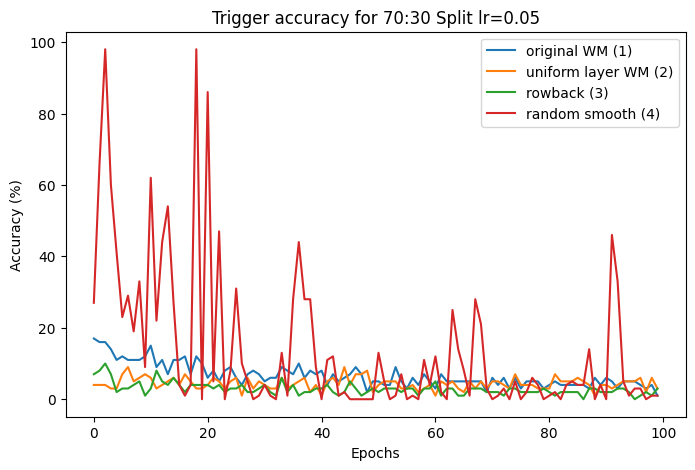

In [73]:
plt.figure(figsize=(8, 5))

plt.plot(range(len(metrics22['trigger_acc'])), metrics22['trigger_acc'], label='original WM (1)')
plt.plot(range(len(metrics23['trigger_acc'])), metrics23['trigger_acc'], label='uniform layer WM (2)')
plt.plot(range(len(metrics24['trigger_acc'])), metrics24['trigger_acc'], label='rowback (3)')

plt.plot(range(len(metrics21['trigger_acc'])), metrics21['trigger_acc'], label='random smooth (4)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Trigger accuracy for 70:30 Split lr=0.05')
plt.legend()
plt.savefig('incre_trigger_acc_7030_lr0.05.png')

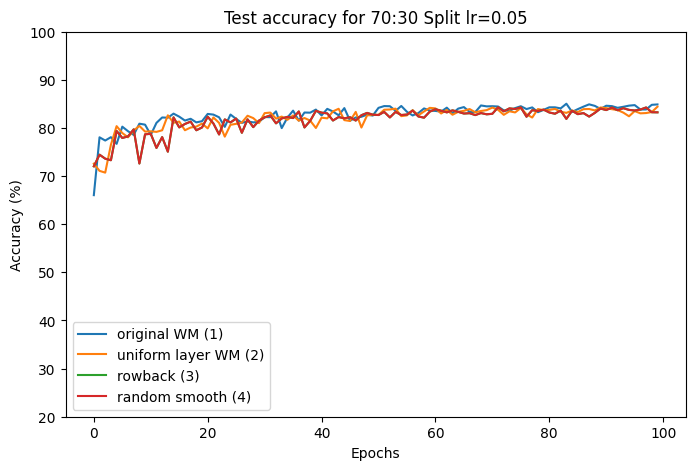

In [74]:
plt.figure(figsize=(8, 5))
plt.plot(range(len(metrics22['val_acc'])), metrics22['val_acc'], label='original WM (1)')
plt.plot(range(len(metrics23['val_acc'])), metrics23['val_acc'], label='uniform layer WM (2)')
plt.plot(range(len(metrics24['val_acc'])), metrics24['val_acc'], label='rowback (3)')

plt.plot(range(len(metrics21['val_acc'])), metrics24['val_acc'], label='random smooth (4)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test accuracy for 70:30 Split lr=0.05')
plt.ylim([20, 100])
plt.legend()
plt.savefig('incre_test_acc_7030_lr0.05.png')